**Pix-2-Pix Model using TensorFlow and Keras**

A port of pix-2-pix model built using TensorFlow's high level `tf.keras` API.

Note: GPU is required to make this model train quickly. Otherwise it could take hours.

In [5]:
import os
import datetime
import imageio
import skimage
from skimage import transform
import scipy # 
import cv2
import time

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob
from IPython.display import Image

tf.logging.set_verbosity(tf.logging.ERROR)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Dataset Structure -Bokeh
Train: Original, Bokeh
Validation:

In [ ]:
bokeh_train='../input/bokeh-dataset/bokeh'
original_train='../input/bokeh-dataset/original'


In [6]:
def load_data(batch_size):
    path1=sorted(glob('../input/bokeh-dataset/bokeh/*'))
    path2=sorted(glob('../input/bokeh-dataset/original/*'))
    i=np.random.randint(0,27)
    batch1=path1[i*batch_size:(i+1)*batch_size]
    batch2=path2[i*batch_size:(i+1)*batch_size]
    
    img_A=[]
    img_B=[]
    for filename1,filename2 in zip(batch1,batch2):
        img1=cv2.imread(filename1)
        img2=cv2.imread(filename2)
        img1=img1[...,::-1]
        img2=img2[...,::-1]
        img1=cv2.resize(img1,(256,256),interpolation=cv2.INTER_AREA)
        img2=cv2.resize(img2,(256,256),interpolation=cv2.INTER_AREA)
        img_A.append(img1)
        img_B.append(img2)
      
    img_A=np.array(img_A)/127.5-1
    img_B=np.array(img_B)/127.5-1
    
    return img_A,img_B 

In [7]:
def load_batch(batch_size):
    path1=sorted(glob('../input/bokeh-dataset/bokeh/*'))
    path2=sorted(glob('../input/bokeh-dataset/original/*'))
    n_batches=int(len(path1)/batch_size)
  
    for i in range(4694):
        batch1=path1[i*batch_size:(i+1)*batch_size]
        batch2=path2[i*batch_size:(i+1)*batch_size]
        img_A,img_B=[],[]
        for filename1,filename2 in zip(batch1,batch2):
            img1=cv2.imread(filename1)
            img2=cv2.imread(filename2)
            img1=img1[...,::-1]
            img2=img2[...,::-1]
            img1=cv2.resize(img1,(256,256),interpolation=cv2.INTER_AREA)    
            img2=cv2.resize(img2,(256,256),interpolation=cv2.INTER_AREA)
            img_A.append(img1)#picture
            img_B.append(img2)#label
      
        img_A=np.array(img_A)/127.5-1
        img_B=np.array(img_B)/127.5-1
    
        yield img_A,img_B #return generator

In [8]:
class Pix2Pix():
    def __init__(self):
        # Input shape
        self.img_rows = 256
        self.img_cols = 256
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        self.lossesmsemae=[]
        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 64
        self.df = 64

        optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generator
        #-------------------------

        # Build the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

        # Input images and their conditioning images
        img_A = tf.keras.layers.Input(shape=self.img_shape)
        img_B = tf.keras.layers.Input(shape=self.img_shape)

        # By conditioning on B generate a fake version of A
        fake_A = self.generator(img_B)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminators determines validity of translated images / condition pairs
        valid = self.discriminator([fake_A, img_B])

        self.combined = tf.keras.models.Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
        self.combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
            if bn:
                d = tf.keras.layers.BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = tf.keras.layers.UpSampling2D(size=2)(layer_input)
            u = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = tf.keras.layers.Dropout(dropout_rate)(u)
            u = tf.keras.layers.BatchNormalization(momentum=0.8)(u)
            u = tf.keras.layers.Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = tf.keras.layers.Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = tf.keras.layers.UpSampling2D(size=2)(u6)
        output_img = tf.keras.layers.Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return tf.keras.models.Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
            if bn:
                d = tf.keras.layers.BatchNormalization(momentum=0.8)(d)
            return d

        img_A = tf.keras.layers.Input(shape=self.img_shape)
        img_B = tf.keras.layers.Input(shape=self.img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = tf.keras.layers.Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, self.df, bn=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = tf.keras.layers.Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return tf.keras.models.Model([img_A, img_B], validity)

    def train(self, epochs, batch_size=1,sample_interval=50):
        #start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            start=time.time()

            for batch_i,(img_A,img_B) in enumerate(load_batch(1)):
                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Condition on B and generate a translated version
                #fake_A = self.generator.predict(img_B)

                # Train the discriminators (original images = real / generated = Fake)
               # d_loss_real = self.discriminator.train_on_batch([img_A, img_B], valid)
                #d_loss_fake = self.discriminator.train_on_batch([fake_A, img_B], fake)
                #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                
                gen_imgs=self.generator.predict(img_B)
        
                d_loss_real = self.discriminator.train_on_batch([img_A, img_B], valid)
                d_loss_fake = self.discriminator.train_on_batch([gen_imgs, img_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
               # g_loss = self.combined.train_on_batch(img_B,valid)

                # -----------------
                #  Train Generator
                # -----------------

                # Train the generators
                g_loss = self.combined.train_on_batch([img_A, img_B], [valid, img_A])

                #elapsed_time = datetime.datetime.now() - start_time
                # Plot the progress
                print("[Epoch %d/%d] [Batch %d] [D loss: %f, acc: %3d%%] [G loss: %f]" % (epoch, epochs,batch_i,d_loss[0], 100*d_loss[1],g_loss[0]))
                
                #if batch_i % 10 == 0:
                #print ("[Epoch %d] [Batch %d] [D loss: %f] [G loss: %f]" % (epoch,batch_i,d_loss,g_loss))
                                                                                
                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)
                    self.lossesmsemae.append((epoch*1000+batch_i,d_loss[0],g_loss[0]))

            print('Time for epoch {} is {} sec'.format(epoch,time.time()-start))
        self.generator.save_weights('/kaggle/working/generator.h5')
        self.discriminator.save_weights('/kaggle/working/discriminator.h5')

   
        
    def sample_images(self, epoch,batch_i):
        r, c = 3, 3
        img_A, img_B =load_data(3)
        fake_A = self.generator.predict(img_B)

        imgs = np.concatenate([img_B, fake_A, img_A])

            # Rescale images 0 - 1
        imgs = 0.5 * imgs + 0.5

        titles = ['Condition', 'Generated', 'Original']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(imgs[cnt])
                axs[i,j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("./%d.png" % (epoch))
        plt.close()

            

In [9]:
gan = Pix2Pix()
model=gan.train(epochs=10, batch_size=1,sample_interval=100)
model



[Epoch 0/10] [Batch 0] [D loss: 7.929968, acc:  20%] [G loss: 85.113609]
[Epoch 0/10] [Batch 1] [D loss: 5.398500, acc:  19%] [G loss: 68.969971]
[Epoch 0/10] [Batch 2] [D loss: 3.337755, acc:  21%] [G loss: 62.765076]
[Epoch 0/10] [Batch 3] [D loss: 2.943870, acc:  23%] [G loss: 71.106323]
[Epoch 0/10] [Batch 4] [D loss: 14.994612, acc:  13%] [G loss: 44.873486]
[Epoch 0/10] [Batch 5] [D loss: 3.606688, acc:  19%] [G loss: 42.373127]
[Epoch 0/10] [Batch 6] [D loss: 4.881292, acc:  16%] [G loss: 42.724205]
[Epoch 0/10] [Batch 7] [D loss: 2.851589, acc:  19%] [G loss: 38.891026]
[Epoch 0/10] [Batch 8] [D loss: 2.574667, acc:  22%] [G loss: 33.392136]
[Epoch 0/10] [Batch 9] [D loss: 1.036364, acc:  33%] [G loss: 28.027557]
[Epoch 0/10] [Batch 10] [D loss: 1.306019, acc:  32%] [G loss: 29.566509]
[Epoch 0/10] [Batch 11] [D loss: 0.996095, acc:  33%] [G loss: 32.408913]
[Epoch 0/10] [Batch 12] [D loss: 0.746825, acc:  44%] [G loss: 26.555113]
[Epoch 0/10] [Batch 13] [D loss: 0.741998, acc:

[Epoch 0/10] [Batch 111] [D loss: 0.366382, acc:  42%] [G loss: 12.723642]
[Epoch 0/10] [Batch 112] [D loss: 0.300489, acc:  46%] [G loss: 11.309419]
[Epoch 0/10] [Batch 113] [D loss: 0.305626, acc:  50%] [G loss: 15.537917]
[Epoch 0/10] [Batch 114] [D loss: 0.353850, acc:  51%] [G loss: 17.406601]
[Epoch 0/10] [Batch 115] [D loss: 0.312561, acc:  45%] [G loss: 15.065094]
[Epoch 0/10] [Batch 116] [D loss: 0.363455, acc:  47%] [G loss: 9.230516]
[Epoch 0/10] [Batch 117] [D loss: 0.317843, acc:  52%] [G loss: 14.288541]
[Epoch 0/10] [Batch 118] [D loss: 0.313799, acc:  46%] [G loss: 10.306348]
[Epoch 0/10] [Batch 119] [D loss: 0.290909, acc:  49%] [G loss: 16.627930]
[Epoch 0/10] [Batch 120] [D loss: 0.316018, acc:  48%] [G loss: 11.636027]
[Epoch 0/10] [Batch 121] [D loss: 0.295599, acc:  48%] [G loss: 12.376410]
[Epoch 0/10] [Batch 122] [D loss: 0.314873, acc:  50%] [G loss: 17.333534]
[Epoch 0/10] [Batch 123] [D loss: 0.302008, acc:  47%] [G loss: 9.950858]
[Epoch 0/10] [Batch 124] [D

[Epoch 0/10] [Batch 221] [D loss: 0.302797, acc:  43%] [G loss: 10.698651]
[Epoch 0/10] [Batch 222] [D loss: 0.331597, acc:  42%] [G loss: 10.015995]
[Epoch 0/10] [Batch 223] [D loss: 0.309853, acc:  46%] [G loss: 18.828659]
[Epoch 0/10] [Batch 224] [D loss: 0.275941, acc:  48%] [G loss: 10.275074]
[Epoch 0/10] [Batch 225] [D loss: 0.306603, acc:  47%] [G loss: 18.224575]
[Epoch 0/10] [Batch 226] [D loss: 0.309874, acc:  54%] [G loss: 9.453117]
[Epoch 0/10] [Batch 227] [D loss: 0.285381, acc:  47%] [G loss: 17.165115]
[Epoch 0/10] [Batch 228] [D loss: 0.323084, acc:  42%] [G loss: 16.574003]
[Epoch 0/10] [Batch 229] [D loss: 0.286417, acc:  47%] [G loss: 18.555161]
[Epoch 0/10] [Batch 230] [D loss: 0.305546, acc:  45%] [G loss: 16.823904]
[Epoch 0/10] [Batch 231] [D loss: 0.282693, acc:  43%] [G loss: 13.054342]
[Epoch 0/10] [Batch 232] [D loss: 0.273064, acc:  49%] [G loss: 11.861412]
[Epoch 0/10] [Batch 233] [D loss: 0.291260, acc:  49%] [G loss: 15.635601]
[Epoch 0/10] [Batch 234] [

[Epoch 0/10] [Batch 331] [D loss: 0.274522, acc:  46%] [G loss: 14.054806]
[Epoch 0/10] [Batch 332] [D loss: 0.300418, acc:  51%] [G loss: 8.550789]
[Epoch 0/10] [Batch 333] [D loss: 0.295477, acc:  50%] [G loss: 9.066138]
[Epoch 0/10] [Batch 334] [D loss: 0.285910, acc:  49%] [G loss: 13.270650]
[Epoch 0/10] [Batch 335] [D loss: 0.280641, acc:  54%] [G loss: 12.096763]
[Epoch 0/10] [Batch 336] [D loss: 0.304276, acc:  46%] [G loss: 11.152938]
[Epoch 0/10] [Batch 337] [D loss: 0.310947, acc:  41%] [G loss: 17.193054]
[Epoch 0/10] [Batch 338] [D loss: 0.315489, acc:  51%] [G loss: 10.722996]
[Epoch 0/10] [Batch 339] [D loss: 0.304825, acc:  50%] [G loss: 10.404025]
[Epoch 0/10] [Batch 340] [D loss: 0.298873, acc:  42%] [G loss: 9.121047]
[Epoch 0/10] [Batch 341] [D loss: 0.302403, acc:  43%] [G loss: 11.382845]
[Epoch 0/10] [Batch 342] [D loss: 0.301888, acc:  51%] [G loss: 17.201181]
[Epoch 0/10] [Batch 343] [D loss: 0.273197, acc:  50%] [G loss: 8.137313]
[Epoch 0/10] [Batch 344] [D l

[Epoch 0/10] [Batch 441] [D loss: 0.303845, acc:  52%] [G loss: 8.977729]
[Epoch 0/10] [Batch 442] [D loss: 0.279770, acc:  48%] [G loss: 12.652776]
[Epoch 0/10] [Batch 443] [D loss: 0.297640, acc:  49%] [G loss: 9.274709]
[Epoch 0/10] [Batch 444] [D loss: 0.278485, acc:  52%] [G loss: 11.396175]
[Epoch 0/10] [Batch 445] [D loss: 0.279257, acc:  48%] [G loss: 9.091657]
[Epoch 0/10] [Batch 446] [D loss: 0.286359, acc:  54%] [G loss: 11.559814]
[Epoch 0/10] [Batch 447] [D loss: 0.273621, acc:  48%] [G loss: 15.949615]
[Epoch 0/10] [Batch 448] [D loss: 0.268616, acc:  48%] [G loss: 14.807415]
[Epoch 0/10] [Batch 449] [D loss: 0.424097, acc:  50%] [G loss: 8.445105]
[Epoch 0/10] [Batch 450] [D loss: 0.370988, acc:  52%] [G loss: 12.711004]
[Epoch 0/10] [Batch 451] [D loss: 0.283474, acc:  45%] [G loss: 13.136855]
[Epoch 0/10] [Batch 452] [D loss: 0.278743, acc:  43%] [G loss: 10.565718]
[Epoch 0/10] [Batch 453] [D loss: 0.344455, acc:  40%] [G loss: 7.545122]
[Epoch 0/10] [Batch 454] [D lo

[Epoch 0/10] [Batch 551] [D loss: 0.282357, acc:  43%] [G loss: 15.390432]
[Epoch 0/10] [Batch 552] [D loss: 0.298883, acc:  40%] [G loss: 15.778330]
[Epoch 0/10] [Batch 553] [D loss: 0.444701, acc:  54%] [G loss: 14.177055]
[Epoch 0/10] [Batch 554] [D loss: 0.855335, acc:  38%] [G loss: 5.394626]
[Epoch 0/10] [Batch 555] [D loss: 0.957851, acc:  37%] [G loss: 14.022853]
[Epoch 0/10] [Batch 556] [D loss: 0.407985, acc:  50%] [G loss: 18.155342]
[Epoch 0/10] [Batch 557] [D loss: 0.377667, acc:  49%] [G loss: 18.029766]
[Epoch 0/10] [Batch 558] [D loss: 0.363760, acc:  47%] [G loss: 19.192928]
[Epoch 0/10] [Batch 559] [D loss: 0.334655, acc:  50%] [G loss: 12.509583]
[Epoch 0/10] [Batch 560] [D loss: 0.278652, acc:  53%] [G loss: 8.968263]
[Epoch 0/10] [Batch 561] [D loss: 0.288227, acc:  48%] [G loss: 9.400135]
[Epoch 0/10] [Batch 562] [D loss: 0.262648, acc:  47%] [G loss: 8.057590]
[Epoch 0/10] [Batch 563] [D loss: 0.282201, acc:  47%] [G loss: 12.889739]
[Epoch 0/10] [Batch 564] [D l

[Epoch 0/10] [Batch 661] [D loss: 0.270123, acc:  46%] [G loss: 13.737357]
[Epoch 0/10] [Batch 662] [D loss: 0.278157, acc:  51%] [G loss: 11.189408]
[Epoch 0/10] [Batch 663] [D loss: 0.269729, acc:  46%] [G loss: 15.201817]
[Epoch 0/10] [Batch 664] [D loss: 0.276193, acc:  44%] [G loss: 20.789761]
[Epoch 0/10] [Batch 665] [D loss: 0.275442, acc:  47%] [G loss: 12.368128]
[Epoch 0/10] [Batch 666] [D loss: 0.269071, acc:  45%] [G loss: 20.686548]
[Epoch 0/10] [Batch 667] [D loss: 0.278963, acc:  36%] [G loss: 16.640316]
[Epoch 0/10] [Batch 668] [D loss: 0.322075, acc:  45%] [G loss: 27.421846]
[Epoch 0/10] [Batch 669] [D loss: 0.310581, acc:  53%] [G loss: 15.341927]
[Epoch 0/10] [Batch 670] [D loss: 0.299636, acc:  48%] [G loss: 14.699490]
[Epoch 0/10] [Batch 671] [D loss: 0.280659, acc:  39%] [G loss: 9.723084]
[Epoch 0/10] [Batch 672] [D loss: 0.311038, acc:  41%] [G loss: 14.639999]
[Epoch 0/10] [Batch 673] [D loss: 0.523056, acc:  30%] [G loss: 8.086064]
[Epoch 0/10] [Batch 674] [D

[Epoch 0/10] [Batch 772] [D loss: 0.264964, acc:  47%] [G loss: 7.135210]
[Epoch 0/10] [Batch 773] [D loss: 0.262675, acc:  48%] [G loss: 10.211061]
[Epoch 0/10] [Batch 774] [D loss: 0.276343, acc:  48%] [G loss: 15.426770]
[Epoch 0/10] [Batch 775] [D loss: 0.266727, acc:  49%] [G loss: 8.758159]
[Epoch 0/10] [Batch 776] [D loss: 0.343116, acc:  41%] [G loss: 10.522203]
[Epoch 0/10] [Batch 777] [D loss: 0.697538, acc:  36%] [G loss: 12.027166]
[Epoch 0/10] [Batch 778] [D loss: 1.022516, acc:  20%] [G loss: 13.523643]
[Epoch 0/10] [Batch 779] [D loss: 0.317864, acc:  53%] [G loss: 20.770626]
[Epoch 0/10] [Batch 780] [D loss: 0.464537, acc:  50%] [G loss: 13.793120]
[Epoch 0/10] [Batch 781] [D loss: 0.321887, acc:  46%] [G loss: 17.454477]
[Epoch 0/10] [Batch 782] [D loss: 0.445307, acc:  43%] [G loss: 9.794779]
[Epoch 0/10] [Batch 783] [D loss: 0.363973, acc:  60%] [G loss: 9.808322]
[Epoch 0/10] [Batch 784] [D loss: 0.303721, acc:  52%] [G loss: 8.985380]
[Epoch 0/10] [Batch 785] [D lo

[Epoch 0/10] [Batch 883] [D loss: 0.293469, acc:  45%] [G loss: 14.419683]
[Epoch 0/10] [Batch 884] [D loss: 0.362687, acc:  47%] [G loss: 15.106269]
[Epoch 0/10] [Batch 885] [D loss: 0.375325, acc:  44%] [G loss: 17.959291]
[Epoch 0/10] [Batch 886] [D loss: 0.334428, acc:  53%] [G loss: 8.700397]
[Epoch 0/10] [Batch 887] [D loss: 0.292578, acc:  50%] [G loss: 12.498353]
[Epoch 0/10] [Batch 888] [D loss: 0.294355, acc:  42%] [G loss: 9.321444]
[Epoch 0/10] [Batch 889] [D loss: 0.315483, acc:  45%] [G loss: 16.796469]
[Epoch 0/10] [Batch 890] [D loss: 0.277573, acc:  45%] [G loss: 8.013537]
[Epoch 0/10] [Batch 891] [D loss: 0.289067, acc:  52%] [G loss: 16.891918]
[Epoch 0/10] [Batch 892] [D loss: 0.328526, acc:  50%] [G loss: 5.495473]
[Epoch 0/10] [Batch 893] [D loss: 0.342217, acc:  50%] [G loss: 10.647355]
[Epoch 0/10] [Batch 894] [D loss: 0.265174, acc:  44%] [G loss: 8.426544]
[Epoch 0/10] [Batch 895] [D loss: 0.304176, acc:  41%] [G loss: 23.882658]
[Epoch 0/10] [Batch 896] [D lo

[Epoch 0/10] [Batch 993] [D loss: 0.343035, acc:  48%] [G loss: 9.195436]
[Epoch 0/10] [Batch 994] [D loss: 0.286168, acc:  45%] [G loss: 9.052116]
[Epoch 0/10] [Batch 995] [D loss: 0.262861, acc:  45%] [G loss: 9.116454]
[Epoch 0/10] [Batch 996] [D loss: 0.274142, acc:  45%] [G loss: 10.776000]
[Epoch 0/10] [Batch 997] [D loss: 0.294700, acc:  54%] [G loss: 10.335730]
[Epoch 0/10] [Batch 998] [D loss: 0.261332, acc:  51%] [G loss: 5.691929]
[Epoch 0/10] [Batch 999] [D loss: 0.270206, acc:  41%] [G loss: 13.630238]
[Epoch 0/10] [Batch 1000] [D loss: 0.283113, acc:  46%] [G loss: 7.244751]
[Epoch 0/10] [Batch 1001] [D loss: 0.262675, acc:  50%] [G loss: 4.238126]
[Epoch 0/10] [Batch 1002] [D loss: 0.263224, acc:  47%] [G loss: 8.527989]
[Epoch 0/10] [Batch 1003] [D loss: 0.260195, acc:  44%] [G loss: 9.022844]
[Epoch 0/10] [Batch 1004] [D loss: 0.258784, acc:  48%] [G loss: 7.649052]
[Epoch 0/10] [Batch 1005] [D loss: 0.273911, acc:  44%] [G loss: 6.998815]
[Epoch 0/10] [Batch 1006] [D 

[Epoch 0/10] [Batch 1102] [D loss: 0.285899, acc:  50%] [G loss: 9.661393]
[Epoch 0/10] [Batch 1103] [D loss: 0.287345, acc:  46%] [G loss: 8.272070]
[Epoch 0/10] [Batch 1104] [D loss: 0.265505, acc:  42%] [G loss: 8.069683]
[Epoch 0/10] [Batch 1105] [D loss: 0.274772, acc:  53%] [G loss: 10.869111]
[Epoch 0/10] [Batch 1106] [D loss: 0.273978, acc:  53%] [G loss: 10.648387]
[Epoch 0/10] [Batch 1107] [D loss: 0.259154, acc:  47%] [G loss: 15.560510]
[Epoch 0/10] [Batch 1108] [D loss: 0.266306, acc:  54%] [G loss: 9.486859]
[Epoch 0/10] [Batch 1109] [D loss: 0.315479, acc:  41%] [G loss: 22.071678]
[Epoch 0/10] [Batch 1110] [D loss: 0.310840, acc:  51%] [G loss: 9.060984]
[Epoch 0/10] [Batch 1111] [D loss: 0.303294, acc:  43%] [G loss: 13.101183]
[Epoch 0/10] [Batch 1112] [D loss: 0.265805, acc:  48%] [G loss: 13.538273]
[Epoch 0/10] [Batch 1113] [D loss: 0.261661, acc:  48%] [G loss: 12.712489]
[Epoch 0/10] [Batch 1114] [D loss: 0.265230, acc:  41%] [G loss: 11.737860]
[Epoch 0/10] [Bat

[Epoch 0/10] [Batch 1212] [D loss: 0.270570, acc:  45%] [G loss: 14.556813]
[Epoch 0/10] [Batch 1213] [D loss: 0.286566, acc:  41%] [G loss: 14.832680]
[Epoch 0/10] [Batch 1214] [D loss: 0.286738, acc:  41%] [G loss: 11.158265]
[Epoch 0/10] [Batch 1215] [D loss: 0.273062, acc:  44%] [G loss: 17.156418]
[Epoch 0/10] [Batch 1216] [D loss: 0.264874, acc:  46%] [G loss: 9.181769]
[Epoch 0/10] [Batch 1217] [D loss: 0.273317, acc:  42%] [G loss: 13.398993]
[Epoch 0/10] [Batch 1218] [D loss: 0.275840, acc:  55%] [G loss: 15.260803]
[Epoch 0/10] [Batch 1219] [D loss: 0.271526, acc:  48%] [G loss: 10.356537]
[Epoch 0/10] [Batch 1220] [D loss: 0.272540, acc:  39%] [G loss: 5.774583]
[Epoch 0/10] [Batch 1221] [D loss: 0.261965, acc:  45%] [G loss: 6.964406]
[Epoch 0/10] [Batch 1222] [D loss: 0.325909, acc:  60%] [G loss: 8.018133]
[Epoch 0/10] [Batch 1223] [D loss: 0.278881, acc:  49%] [G loss: 11.689088]
[Epoch 0/10] [Batch 1224] [D loss: 0.306036, acc:  50%] [G loss: 6.126527]
[Epoch 0/10] [Bat

[Epoch 0/10] [Batch 1322] [D loss: 0.281161, acc:  42%] [G loss: 11.997139]
[Epoch 0/10] [Batch 1323] [D loss: 0.289709, acc:  42%] [G loss: 12.824883]
[Epoch 0/10] [Batch 1324] [D loss: 0.262209, acc:  49%] [G loss: 15.517494]
[Epoch 0/10] [Batch 1325] [D loss: 0.313463, acc:  50%] [G loss: 13.924979]
[Epoch 0/10] [Batch 1326] [D loss: 0.287173, acc:  48%] [G loss: 10.367504]
[Epoch 0/10] [Batch 1327] [D loss: 0.349665, acc:  33%] [G loss: 8.568841]
[Epoch 0/10] [Batch 1328] [D loss: 0.279840, acc:  38%] [G loss: 6.223824]
[Epoch 0/10] [Batch 1329] [D loss: 0.295209, acc:  44%] [G loss: 9.389148]
[Epoch 0/10] [Batch 1330] [D loss: 0.388274, acc:  40%] [G loss: 8.759404]
[Epoch 0/10] [Batch 1331] [D loss: 0.337339, acc:  52%] [G loss: 13.648557]
[Epoch 0/10] [Batch 1332] [D loss: 0.271119, acc:  43%] [G loss: 9.486780]
[Epoch 0/10] [Batch 1333] [D loss: 0.295542, acc:  51%] [G loss: 19.392981]
[Epoch 0/10] [Batch 1334] [D loss: 0.274044, acc:  55%] [G loss: 22.156570]
[Epoch 0/10] [Bat

[Epoch 0/10] [Batch 1431] [D loss: 0.321840, acc:  59%] [G loss: 15.513602]
[Epoch 0/10] [Batch 1432] [D loss: 0.358819, acc:  48%] [G loss: 13.788311]
[Epoch 0/10] [Batch 1433] [D loss: 0.257939, acc:  51%] [G loss: 6.873252]
[Epoch 0/10] [Batch 1434] [D loss: 0.264354, acc:  46%] [G loss: 10.528498]
[Epoch 0/10] [Batch 1435] [D loss: 0.280893, acc:  54%] [G loss: 11.872252]
[Epoch 0/10] [Batch 1436] [D loss: 0.266467, acc:  45%] [G loss: 19.798733]
[Epoch 0/10] [Batch 1437] [D loss: 0.258690, acc:  51%] [G loss: 9.821344]
[Epoch 0/10] [Batch 1438] [D loss: 0.273584, acc:  45%] [G loss: 13.980328]
[Epoch 0/10] [Batch 1439] [D loss: 0.315118, acc:  50%] [G loss: 14.185392]
[Epoch 0/10] [Batch 1440] [D loss: 0.452039, acc:  55%] [G loss: 7.063354]
[Epoch 0/10] [Batch 1441] [D loss: 0.327304, acc:  48%] [G loss: 6.916111]
[Epoch 0/10] [Batch 1442] [D loss: 0.267553, acc:  40%] [G loss: 16.858809]
[Epoch 0/10] [Batch 1443] [D loss: 0.277414, acc:  40%] [G loss: 28.966898]
[Epoch 0/10] [Ba

[Epoch 0/10] [Batch 1541] [D loss: 0.265249, acc:  45%] [G loss: 11.133373]
[Epoch 0/10] [Batch 1542] [D loss: 0.263269, acc:  44%] [G loss: 15.529748]
[Epoch 0/10] [Batch 1543] [D loss: 0.311129, acc:  32%] [G loss: 11.573487]
[Epoch 0/10] [Batch 1544] [D loss: 0.291301, acc:  48%] [G loss: 7.906435]
[Epoch 0/10] [Batch 1545] [D loss: 0.267254, acc:  53%] [G loss: 19.149921]
[Epoch 0/10] [Batch 1546] [D loss: 0.276966, acc:  60%] [G loss: 7.647131]
[Epoch 0/10] [Batch 1547] [D loss: 0.281340, acc:  41%] [G loss: 7.333975]
[Epoch 0/10] [Batch 1548] [D loss: 0.273064, acc:  39%] [G loss: 10.377492]
[Epoch 0/10] [Batch 1549] [D loss: 0.264232, acc:  46%] [G loss: 7.837247]
[Epoch 0/10] [Batch 1550] [D loss: 0.268902, acc:  48%] [G loss: 5.928586]
[Epoch 0/10] [Batch 1551] [D loss: 0.284978, acc:  44%] [G loss: 14.810826]
[Epoch 0/10] [Batch 1552] [D loss: 0.324941, acc:  39%] [G loss: 15.812911]
[Epoch 0/10] [Batch 1553] [D loss: 0.365987, acc:  58%] [G loss: 12.741587]
[Epoch 0/10] [Bat

[Epoch 0/10] [Batch 1650] [D loss: 0.268868, acc:  53%] [G loss: 6.886113]
[Epoch 0/10] [Batch 1651] [D loss: 0.271834, acc:  46%] [G loss: 10.110995]
[Epoch 0/10] [Batch 1652] [D loss: 0.297488, acc:  43%] [G loss: 17.995497]
[Epoch 0/10] [Batch 1653] [D loss: 0.278564, acc:  41%] [G loss: 8.250631]
[Epoch 0/10] [Batch 1654] [D loss: 0.281070, acc:  57%] [G loss: 9.019873]
[Epoch 0/10] [Batch 1655] [D loss: 0.299503, acc:  42%] [G loss: 11.879340]
[Epoch 0/10] [Batch 1656] [D loss: 0.299578, acc:  54%] [G loss: 7.644308]
[Epoch 0/10] [Batch 1657] [D loss: 0.283859, acc:  52%] [G loss: 15.698175]
[Epoch 0/10] [Batch 1658] [D loss: 0.264524, acc:  49%] [G loss: 10.771084]
[Epoch 0/10] [Batch 1659] [D loss: 0.306862, acc:  40%] [G loss: 7.684890]
[Epoch 0/10] [Batch 1660] [D loss: 0.274375, acc:  54%] [G loss: 12.989874]
[Epoch 0/10] [Batch 1661] [D loss: 0.260053, acc:  46%] [G loss: 10.432420]
[Epoch 0/10] [Batch 1662] [D loss: 0.262973, acc:  53%] [G loss: 6.078189]
[Epoch 0/10] [Batc

[Epoch 0/10] [Batch 1759] [D loss: 0.283123, acc:  57%] [G loss: 9.268900]
[Epoch 0/10] [Batch 1760] [D loss: 0.279083, acc:  41%] [G loss: 9.162379]
[Epoch 0/10] [Batch 1761] [D loss: 0.267173, acc:  44%] [G loss: 5.359732]
[Epoch 0/10] [Batch 1762] [D loss: 0.274225, acc:  49%] [G loss: 11.895939]
[Epoch 0/10] [Batch 1763] [D loss: 0.265945, acc:  52%] [G loss: 13.400338]
[Epoch 0/10] [Batch 1764] [D loss: 0.265290, acc:  56%] [G loss: 9.387071]
[Epoch 0/10] [Batch 1765] [D loss: 0.290222, acc:  44%] [G loss: 8.585611]
[Epoch 0/10] [Batch 1766] [D loss: 0.294187, acc:  35%] [G loss: 9.772348]
[Epoch 0/10] [Batch 1767] [D loss: 0.260039, acc:  53%] [G loss: 17.862835]
[Epoch 0/10] [Batch 1768] [D loss: 0.266181, acc:  46%] [G loss: 14.755116]
[Epoch 0/10] [Batch 1769] [D loss: 0.358881, acc:  34%] [G loss: 8.739005]
[Epoch 0/10] [Batch 1770] [D loss: 0.282413, acc:  55%] [G loss: 12.564087]
[Epoch 0/10] [Batch 1771] [D loss: 0.283139, acc:  42%] [G loss: 10.158629]
[Epoch 0/10] [Batch

[Epoch 0/10] [Batch 1868] [D loss: 0.290150, acc:  40%] [G loss: 19.384645]
[Epoch 0/10] [Batch 1869] [D loss: 0.397936, acc:  41%] [G loss: 5.583269]
[Epoch 0/10] [Batch 1870] [D loss: 0.268994, acc:  52%] [G loss: 21.097036]
[Epoch 0/10] [Batch 1871] [D loss: 0.287682, acc:  48%] [G loss: 17.961313]
[Epoch 0/10] [Batch 1872] [D loss: 0.328846, acc:  51%] [G loss: 14.911064]
[Epoch 0/10] [Batch 1873] [D loss: 0.288598, acc:  52%] [G loss: 11.027061]
[Epoch 0/10] [Batch 1874] [D loss: 0.269513, acc:  57%] [G loss: 6.900121]
[Epoch 0/10] [Batch 1875] [D loss: 0.302521, acc:  40%] [G loss: 12.364391]
[Epoch 0/10] [Batch 1876] [D loss: 0.292084, acc:  55%] [G loss: 19.001919]
[Epoch 0/10] [Batch 1877] [D loss: 0.272097, acc:  47%] [G loss: 4.711676]
[Epoch 0/10] [Batch 1878] [D loss: 0.316752, acc:  47%] [G loss: 24.479418]
[Epoch 0/10] [Batch 1879] [D loss: 0.282847, acc:  55%] [G loss: 6.793206]
[Epoch 0/10] [Batch 1880] [D loss: 0.591464, acc:  40%] [G loss: 13.542135]
[Epoch 0/10] [Ba

[Epoch 0/10] [Batch 1977] [D loss: 0.402328, acc:  51%] [G loss: 15.305403]
[Epoch 0/10] [Batch 1978] [D loss: 0.306819, acc:  45%] [G loss: 19.919733]
[Epoch 0/10] [Batch 1979] [D loss: 0.277070, acc:  46%] [G loss: 13.217414]
[Epoch 0/10] [Batch 1980] [D loss: 0.292819, acc:  42%] [G loss: 16.802929]
[Epoch 0/10] [Batch 1981] [D loss: 0.288574, acc:  54%] [G loss: 8.271308]
[Epoch 0/10] [Batch 1982] [D loss: 0.268613, acc:  57%] [G loss: 13.490340]
[Epoch 0/10] [Batch 1983] [D loss: 0.287106, acc:  44%] [G loss: 19.512770]
[Epoch 0/10] [Batch 1984] [D loss: 0.273614, acc:  43%] [G loss: 13.066813]
[Epoch 0/10] [Batch 1985] [D loss: 0.281533, acc:  53%] [G loss: 13.934072]
[Epoch 0/10] [Batch 1986] [D loss: 0.271257, acc:  47%] [G loss: 5.891587]
[Epoch 0/10] [Batch 1987] [D loss: 0.293944, acc:  50%] [G loss: 14.031293]
[Epoch 0/10] [Batch 1988] [D loss: 0.263131, acc:  52%] [G loss: 8.761098]
[Epoch 0/10] [Batch 1989] [D loss: 0.265723, acc:  45%] [G loss: 6.154777]
[Epoch 0/10] [Ba

[Epoch 0/10] [Batch 2086] [D loss: 0.259572, acc:  49%] [G loss: 34.333439]
[Epoch 0/10] [Batch 2087] [D loss: 0.273653, acc:  56%] [G loss: 7.148683]
[Epoch 0/10] [Batch 2088] [D loss: 0.278417, acc:  35%] [G loss: 14.285074]
[Epoch 0/10] [Batch 2089] [D loss: 0.274724, acc:  54%] [G loss: 15.676418]
[Epoch 0/10] [Batch 2090] [D loss: 0.263447, acc:  43%] [G loss: 11.482581]
[Epoch 0/10] [Batch 2091] [D loss: 0.282478, acc:  45%] [G loss: 13.627778]
[Epoch 0/10] [Batch 2092] [D loss: 0.264469, acc:  49%] [G loss: 14.350275]
[Epoch 0/10] [Batch 2093] [D loss: 0.272966, acc:  50%] [G loss: 7.866723]
[Epoch 0/10] [Batch 2094] [D loss: 0.267291, acc:  51%] [G loss: 17.709902]
[Epoch 0/10] [Batch 2095] [D loss: 0.255599, acc:  53%] [G loss: 12.253063]
[Epoch 0/10] [Batch 2096] [D loss: 0.261680, acc:  53%] [G loss: 11.282184]
[Epoch 0/10] [Batch 2097] [D loss: 0.314108, acc:  40%] [G loss: 11.915191]
[Epoch 0/10] [Batch 2098] [D loss: 0.263662, acc:  54%] [G loss: 19.036522]
[Epoch 0/10] [

[Epoch 0/10] [Batch 2195] [D loss: 0.250217, acc:  48%] [G loss: 11.203148]
[Epoch 0/10] [Batch 2196] [D loss: 0.263791, acc:  50%] [G loss: 16.412445]
[Epoch 0/10] [Batch 2197] [D loss: 0.266365, acc:  47%] [G loss: 11.482594]
[Epoch 0/10] [Batch 2198] [D loss: 0.265278, acc:  44%] [G loss: 14.903830]
[Epoch 0/10] [Batch 2199] [D loss: 0.272339, acc:  42%] [G loss: 19.381525]
[Epoch 0/10] [Batch 2200] [D loss: 0.292088, acc:  37%] [G loss: 6.280962]
[Epoch 0/10] [Batch 2201] [D loss: 0.272847, acc:  48%] [G loss: 10.849918]
[Epoch 0/10] [Batch 2202] [D loss: 0.544694, acc:  32%] [G loss: 14.485909]
[Epoch 0/10] [Batch 2203] [D loss: 0.369812, acc:  47%] [G loss: 23.559193]
[Epoch 0/10] [Batch 2204] [D loss: 0.301955, acc:  52%] [G loss: 18.756775]
[Epoch 0/10] [Batch 2205] [D loss: 0.295250, acc:  42%] [G loss: 7.244430]
[Epoch 0/10] [Batch 2206] [D loss: 0.279366, acc:  49%] [G loss: 8.038563]
[Epoch 0/10] [Batch 2207] [D loss: 0.310757, acc:  48%] [G loss: 21.571680]
[Epoch 0/10] [B

[Epoch 0/10] [Batch 2304] [D loss: 0.287310, acc:  49%] [G loss: 14.186609]
[Epoch 0/10] [Batch 2305] [D loss: 0.271708, acc:  50%] [G loss: 14.117934]
[Epoch 0/10] [Batch 2306] [D loss: 0.614548, acc:  51%] [G loss: 4.202255]
[Epoch 0/10] [Batch 2307] [D loss: 0.446627, acc:  49%] [G loss: 19.146313]
[Epoch 0/10] [Batch 2308] [D loss: 0.371595, acc:  55%] [G loss: 10.346456]
[Epoch 0/10] [Batch 2309] [D loss: 0.452464, acc:  49%] [G loss: 7.130743]
[Epoch 0/10] [Batch 2310] [D loss: 0.299672, acc:  49%] [G loss: 6.492520]
[Epoch 0/10] [Batch 2311] [D loss: 0.351730, acc:  48%] [G loss: 11.185011]
[Epoch 0/10] [Batch 2312] [D loss: 0.446263, acc:  47%] [G loss: 5.819656]
[Epoch 0/10] [Batch 2313] [D loss: 0.293712, acc:  53%] [G loss: 22.778666]
[Epoch 0/10] [Batch 2314] [D loss: 1.121097, acc:  34%] [G loss: 5.579809]
[Epoch 0/10] [Batch 2315] [D loss: 0.748167, acc:  31%] [G loss: 5.206254]
[Epoch 0/10] [Batch 2316] [D loss: 0.461114, acc:  57%] [G loss: 8.213219]
[Epoch 0/10] [Batch

[Epoch 0/10] [Batch 2413] [D loss: 0.339932, acc:  47%] [G loss: 11.241535]
[Epoch 0/10] [Batch 2414] [D loss: 0.286885, acc:  40%] [G loss: 5.653644]
[Epoch 0/10] [Batch 2415] [D loss: 0.348838, acc:  52%] [G loss: 10.514050]
[Epoch 0/10] [Batch 2416] [D loss: 0.642691, acc:  27%] [G loss: 9.019151]
[Epoch 0/10] [Batch 2417] [D loss: 0.371100, acc:  50%] [G loss: 13.806617]
[Epoch 0/10] [Batch 2418] [D loss: 0.330328, acc:  48%] [G loss: 9.136475]
[Epoch 0/10] [Batch 2419] [D loss: 0.313154, acc:  37%] [G loss: 5.125249]
[Epoch 0/10] [Batch 2420] [D loss: 0.373902, acc:  51%] [G loss: 7.232509]
[Epoch 0/10] [Batch 2421] [D loss: 0.353046, acc:  52%] [G loss: 8.492292]
[Epoch 0/10] [Batch 2422] [D loss: 0.306446, acc:  39%] [G loss: 7.071564]
[Epoch 0/10] [Batch 2423] [D loss: 0.275020, acc:  48%] [G loss: 12.715499]
[Epoch 0/10] [Batch 2424] [D loss: 0.291202, acc:  55%] [G loss: 6.251721]
[Epoch 0/10] [Batch 2425] [D loss: 0.282222, acc:  51%] [G loss: 13.232971]
[Epoch 0/10] [Batch 

[Epoch 0/10] [Batch 2522] [D loss: 0.276862, acc:  51%] [G loss: 6.553625]
[Epoch 0/10] [Batch 2523] [D loss: 0.313448, acc:  55%] [G loss: 6.500170]
[Epoch 0/10] [Batch 2524] [D loss: 0.275594, acc:  41%] [G loss: 8.757470]
[Epoch 0/10] [Batch 2525] [D loss: 0.281906, acc:  49%] [G loss: 9.875061]
[Epoch 0/10] [Batch 2526] [D loss: 0.366877, acc:  35%] [G loss: 6.963493]
[Epoch 0/10] [Batch 2527] [D loss: 0.308685, acc:  44%] [G loss: 5.472512]
[Epoch 0/10] [Batch 2528] [D loss: 0.265987, acc:  46%] [G loss: 15.048806]
[Epoch 0/10] [Batch 2529] [D loss: 0.276897, acc:  48%] [G loss: 12.455268]
[Epoch 0/10] [Batch 2530] [D loss: 0.279224, acc:  52%] [G loss: 13.474890]
[Epoch 0/10] [Batch 2531] [D loss: 1.122319, acc:  31%] [G loss: 8.714975]
[Epoch 0/10] [Batch 2532] [D loss: 0.764386, acc:  50%] [G loss: 8.184876]
[Epoch 0/10] [Batch 2533] [D loss: 0.523442, acc:  39%] [G loss: 6.743934]
[Epoch 0/10] [Batch 2534] [D loss: 0.640672, acc:  35%] [G loss: 6.645694]
[Epoch 0/10] [Batch 25

[Epoch 0/10] [Batch 2632] [D loss: 0.269040, acc:  44%] [G loss: 14.222251]
[Epoch 0/10] [Batch 2633] [D loss: 0.256286, acc:  53%] [G loss: 12.638051]
[Epoch 0/10] [Batch 2634] [D loss: 0.268285, acc:  46%] [G loss: 21.571100]
[Epoch 0/10] [Batch 2635] [D loss: 0.288189, acc:  38%] [G loss: 8.951286]
[Epoch 0/10] [Batch 2636] [D loss: 0.279337, acc:  53%] [G loss: 11.879646]
[Epoch 0/10] [Batch 2637] [D loss: 0.263136, acc:  49%] [G loss: 11.425674]
[Epoch 0/10] [Batch 2638] [D loss: 0.256760, acc:  51%] [G loss: 10.898334]
[Epoch 0/10] [Batch 2639] [D loss: 0.265049, acc:  43%] [G loss: 8.038265]
[Epoch 0/10] [Batch 2640] [D loss: 0.343214, acc:  49%] [G loss: 6.042444]
[Epoch 0/10] [Batch 2641] [D loss: 0.295703, acc:  54%] [G loss: 15.217552]
[Epoch 0/10] [Batch 2642] [D loss: 0.268045, acc:  50%] [G loss: 7.850525]
[Epoch 0/10] [Batch 2643] [D loss: 0.251933, acc:  51%] [G loss: 9.343891]
[Epoch 0/10] [Batch 2644] [D loss: 0.328540, acc:  55%] [G loss: 9.567993]
[Epoch 0/10] [Batc

[Epoch 0/10] [Batch 2741] [D loss: 0.250836, acc:  59%] [G loss: 9.615317]
[Epoch 0/10] [Batch 2742] [D loss: 0.257647, acc:  45%] [G loss: 9.829446]
[Epoch 0/10] [Batch 2743] [D loss: 0.250607, acc:  54%] [G loss: 8.412895]
[Epoch 0/10] [Batch 2744] [D loss: 0.255851, acc:  53%] [G loss: 7.655725]
[Epoch 0/10] [Batch 2745] [D loss: 0.257275, acc:  51%] [G loss: 18.203234]
[Epoch 0/10] [Batch 2746] [D loss: 0.287759, acc:  47%] [G loss: 7.741069]
[Epoch 0/10] [Batch 2747] [D loss: 0.318162, acc:  55%] [G loss: 7.588907]
[Epoch 0/10] [Batch 2748] [D loss: 0.293035, acc:  46%] [G loss: 8.986934]
[Epoch 0/10] [Batch 2749] [D loss: 0.256748, acc:  46%] [G loss: 29.089664]
[Epoch 0/10] [Batch 2750] [D loss: 0.269693, acc:  50%] [G loss: 15.295219]
[Epoch 0/10] [Batch 2751] [D loss: 0.268716, acc:  48%] [G loss: 17.498615]
[Epoch 0/10] [Batch 2752] [D loss: 0.275315, acc:  36%] [G loss: 12.443324]
[Epoch 0/10] [Batch 2753] [D loss: 0.271229, acc:  49%] [G loss: 11.327792]
[Epoch 0/10] [Batch

[Epoch 0/10] [Batch 2850] [D loss: 0.254467, acc:  46%] [G loss: 8.752904]
[Epoch 0/10] [Batch 2851] [D loss: 0.273241, acc:  57%] [G loss: 8.970131]
[Epoch 0/10] [Batch 2852] [D loss: 0.272740, acc:  38%] [G loss: 12.926891]
[Epoch 0/10] [Batch 2853] [D loss: 0.269336, acc:  53%] [G loss: 9.697318]
[Epoch 0/10] [Batch 2854] [D loss: 0.267461, acc:  54%] [G loss: 8.334826]
[Epoch 0/10] [Batch 2855] [D loss: 0.279383, acc:  42%] [G loss: 6.932690]
[Epoch 0/10] [Batch 2856] [D loss: 0.280593, acc:  54%] [G loss: 6.825837]
[Epoch 0/10] [Batch 2857] [D loss: 0.288546, acc:  55%] [G loss: 9.301600]
[Epoch 0/10] [Batch 2858] [D loss: 0.284533, acc:  51%] [G loss: 7.974184]
[Epoch 0/10] [Batch 2859] [D loss: 0.263174, acc:  46%] [G loss: 8.879141]
[Epoch 0/10] [Batch 2860] [D loss: 0.256868, acc:  58%] [G loss: 8.803355]
[Epoch 0/10] [Batch 2861] [D loss: 0.249410, acc:  71%] [G loss: 16.105154]
[Epoch 0/10] [Batch 2862] [D loss: 0.291992, acc:  51%] [G loss: 12.740705]
[Epoch 0/10] [Batch 28

[Epoch 0/10] [Batch 2959] [D loss: 0.261446, acc:  55%] [G loss: 18.754827]
[Epoch 0/10] [Batch 2960] [D loss: 0.265659, acc:  59%] [G loss: 17.994753]
[Epoch 0/10] [Batch 2961] [D loss: 0.270737, acc:  44%] [G loss: 8.516381]
[Epoch 0/10] [Batch 2962] [D loss: 0.256371, acc:  50%] [G loss: 9.515362]
[Epoch 0/10] [Batch 2963] [D loss: 0.242836, acc:  55%] [G loss: 16.303110]
[Epoch 0/10] [Batch 2964] [D loss: 0.290543, acc:  55%] [G loss: 14.852293]
[Epoch 0/10] [Batch 2965] [D loss: 0.272316, acc:  54%] [G loss: 4.767413]
[Epoch 0/10] [Batch 2966] [D loss: 0.272491, acc:  54%] [G loss: 18.927717]
[Epoch 0/10] [Batch 2967] [D loss: 0.277484, acc:  49%] [G loss: 14.266171]
[Epoch 0/10] [Batch 2968] [D loss: 0.272440, acc:  52%] [G loss: 10.154414]
[Epoch 0/10] [Batch 2969] [D loss: 0.248991, acc:  54%] [G loss: 16.253263]
[Epoch 0/10] [Batch 2970] [D loss: 0.287757, acc:  33%] [G loss: 16.523981]
[Epoch 0/10] [Batch 2971] [D loss: 0.264975, acc:  50%] [G loss: 15.612167]
[Epoch 0/10] [B

[Epoch 0/10] [Batch 3068] [D loss: 0.245022, acc:  62%] [G loss: 12.447530]
[Epoch 0/10] [Batch 3069] [D loss: 0.260602, acc:  50%] [G loss: 10.606071]
[Epoch 0/10] [Batch 3070] [D loss: 0.270270, acc:  55%] [G loss: 14.847358]
[Epoch 0/10] [Batch 3071] [D loss: 0.307667, acc:  51%] [G loss: 7.265928]
[Epoch 0/10] [Batch 3072] [D loss: 0.240428, acc:  58%] [G loss: 21.870472]
[Epoch 0/10] [Batch 3073] [D loss: 0.356641, acc:  46%] [G loss: 13.547707]
[Epoch 0/10] [Batch 3074] [D loss: 0.328179, acc:  45%] [G loss: 15.127699]
[Epoch 0/10] [Batch 3075] [D loss: 0.313342, acc:  49%] [G loss: 7.725098]
[Epoch 0/10] [Batch 3076] [D loss: 0.278309, acc:  50%] [G loss: 16.303459]
[Epoch 0/10] [Batch 3077] [D loss: 0.331012, acc:  50%] [G loss: 10.982519]
[Epoch 0/10] [Batch 3078] [D loss: 0.271861, acc:  45%] [G loss: 10.040707]
[Epoch 0/10] [Batch 3079] [D loss: 0.303948, acc:  48%] [G loss: 10.530763]
[Epoch 0/10] [Batch 3080] [D loss: 0.267875, acc:  52%] [G loss: 9.994482]
[Epoch 0/10] [B

[Epoch 0/10] [Batch 3178] [D loss: 0.296445, acc:  45%] [G loss: 16.250051]
[Epoch 0/10] [Batch 3179] [D loss: 0.290376, acc:  51%] [G loss: 9.917291]
[Epoch 0/10] [Batch 3180] [D loss: 0.270178, acc:  52%] [G loss: 9.030961]
[Epoch 0/10] [Batch 3181] [D loss: 0.271498, acc:  46%] [G loss: 10.691367]
[Epoch 0/10] [Batch 3182] [D loss: 0.265760, acc:  53%] [G loss: 9.825434]
[Epoch 0/10] [Batch 3183] [D loss: 0.264133, acc:  44%] [G loss: 18.058376]
[Epoch 0/10] [Batch 3184] [D loss: 0.268177, acc:  51%] [G loss: 13.652016]
[Epoch 0/10] [Batch 3185] [D loss: 0.300289, acc:  46%] [G loss: 12.088096]
[Epoch 0/10] [Batch 3186] [D loss: 0.513860, acc:  43%] [G loss: 12.847837]
[Epoch 0/10] [Batch 3187] [D loss: 0.915720, acc:  51%] [G loss: 14.377048]
[Epoch 0/10] [Batch 3188] [D loss: 0.411960, acc:  42%] [G loss: 10.299494]
[Epoch 0/10] [Batch 3189] [D loss: 0.350911, acc:  57%] [G loss: 10.881753]
[Epoch 0/10] [Batch 3190] [D loss: 0.283933, acc:  51%] [G loss: 10.017274]
[Epoch 0/10] [B

[Epoch 0/10] [Batch 3287] [D loss: 0.276360, acc:  51%] [G loss: 7.048142]
[Epoch 0/10] [Batch 3288] [D loss: 0.276290, acc:  45%] [G loss: 7.692000]
[Epoch 0/10] [Batch 3289] [D loss: 0.258225, acc:  56%] [G loss: 5.611045]
[Epoch 0/10] [Batch 3290] [D loss: 0.267233, acc:  44%] [G loss: 10.292638]
[Epoch 0/10] [Batch 3291] [D loss: 0.261329, acc:  45%] [G loss: 7.213110]
[Epoch 0/10] [Batch 3292] [D loss: 0.257506, acc:  48%] [G loss: 8.786393]
[Epoch 0/10] [Batch 3293] [D loss: 0.338145, acc:  46%] [G loss: 6.309505]
[Epoch 0/10] [Batch 3294] [D loss: 0.326333, acc:  45%] [G loss: 8.826379]
[Epoch 0/10] [Batch 3295] [D loss: 0.277403, acc:  53%] [G loss: 9.796136]
[Epoch 0/10] [Batch 3296] [D loss: 0.275459, acc:  47%] [G loss: 18.104967]
[Epoch 0/10] [Batch 3297] [D loss: 0.253191, acc:  58%] [G loss: 6.421938]
[Epoch 0/10] [Batch 3298] [D loss: 0.265504, acc:  58%] [G loss: 7.052002]
[Epoch 0/10] [Batch 3299] [D loss: 0.287996, acc:  42%] [G loss: 9.113337]
[Epoch 0/10] [Batch 330

[Epoch 0/10] [Batch 3397] [D loss: 0.254111, acc:  50%] [G loss: 11.066273]
[Epoch 0/10] [Batch 3398] [D loss: 0.254402, acc:  47%] [G loss: 15.503637]
[Epoch 0/10] [Batch 3399] [D loss: 0.263179, acc:  50%] [G loss: 17.684349]
[Epoch 0/10] [Batch 3400] [D loss: 0.314249, acc:  34%] [G loss: 11.115798]
[Epoch 0/10] [Batch 3401] [D loss: 0.272569, acc:  48%] [G loss: 11.851642]
[Epoch 0/10] [Batch 3402] [D loss: 0.302358, acc:  35%] [G loss: 13.266694]
[Epoch 0/10] [Batch 3403] [D loss: 0.297672, acc:  45%] [G loss: 10.942321]
[Epoch 0/10] [Batch 3404] [D loss: 0.256998, acc:  49%] [G loss: 17.698895]
[Epoch 0/10] [Batch 3405] [D loss: 0.271235, acc:  55%] [G loss: 17.530802]
[Epoch 0/10] [Batch 3406] [D loss: 0.267774, acc:  47%] [G loss: 12.120109]
[Epoch 0/10] [Batch 3407] [D loss: 0.313992, acc:  43%] [G loss: 8.677375]
[Epoch 0/10] [Batch 3408] [D loss: 0.280542, acc:  48%] [G loss: 11.583735]
[Epoch 0/10] [Batch 3409] [D loss: 0.265162, acc:  44%] [G loss: 7.990514]
[Epoch 0/10] [

[Epoch 0/10] [Batch 3506] [D loss: 0.303328, acc:  41%] [G loss: 7.513055]
[Epoch 0/10] [Batch 3507] [D loss: 0.270317, acc:  47%] [G loss: 6.315181]
[Epoch 0/10] [Batch 3508] [D loss: 0.261061, acc:  49%] [G loss: 6.428203]
[Epoch 0/10] [Batch 3509] [D loss: 0.272612, acc:  52%] [G loss: 9.173240]
[Epoch 0/10] [Batch 3510] [D loss: 0.232322, acc:  62%] [G loss: 8.301006]
[Epoch 0/10] [Batch 3511] [D loss: 0.261737, acc:  50%] [G loss: 11.198825]
[Epoch 0/10] [Batch 3512] [D loss: 0.268877, acc:  48%] [G loss: 8.831059]
[Epoch 0/10] [Batch 3513] [D loss: 0.263696, acc:  46%] [G loss: 7.168140]
[Epoch 0/10] [Batch 3514] [D loss: 0.249132, acc:  58%] [G loss: 10.722159]
[Epoch 0/10] [Batch 3515] [D loss: 0.245551, acc:  58%] [G loss: 13.454190]
[Epoch 0/10] [Batch 3516] [D loss: 0.250674, acc:  52%] [G loss: 9.962900]
[Epoch 0/10] [Batch 3517] [D loss: 0.276388, acc:  41%] [G loss: 6.375178]
[Epoch 0/10] [Batch 3518] [D loss: 0.256661, acc:  58%] [G loss: 13.940512]
[Epoch 0/10] [Batch 3

[Epoch 0/10] [Batch 3615] [D loss: 0.278540, acc:  57%] [G loss: 8.549295]
[Epoch 0/10] [Batch 3616] [D loss: 0.402308, acc:  47%] [G loss: 12.140686]
[Epoch 0/10] [Batch 3617] [D loss: 0.262524, acc:  61%] [G loss: 12.830476]
[Epoch 0/10] [Batch 3618] [D loss: 0.268831, acc:  46%] [G loss: 16.720293]
[Epoch 0/10] [Batch 3619] [D loss: 0.255673, acc:  51%] [G loss: 13.349805]
[Epoch 0/10] [Batch 3620] [D loss: 0.231853, acc:  61%] [G loss: 17.364153]
[Epoch 0/10] [Batch 3621] [D loss: 0.434349, acc:  40%] [G loss: 12.640092]
[Epoch 0/10] [Batch 3622] [D loss: 0.816097, acc:  29%] [G loss: 14.381659]
[Epoch 0/10] [Batch 3623] [D loss: 1.014914, acc:  30%] [G loss: 26.796324]
[Epoch 0/10] [Batch 3624] [D loss: 0.473436, acc:  49%] [G loss: 21.179022]
[Epoch 0/10] [Batch 3625] [D loss: 0.356994, acc:  54%] [G loss: 28.923679]
[Epoch 0/10] [Batch 3626] [D loss: 0.311628, acc:  55%] [G loss: 14.675992]
[Epoch 0/10] [Batch 3627] [D loss: 0.287635, acc:  44%] [G loss: 14.351986]
[Epoch 0/10] 

[Epoch 0/10] [Batch 3724] [D loss: 0.261005, acc:  51%] [G loss: 7.313629]
[Epoch 0/10] [Batch 3725] [D loss: 0.207470, acc:  71%] [G loss: 13.946193]
[Epoch 0/10] [Batch 3726] [D loss: 0.320187, acc:  53%] [G loss: 6.663976]
[Epoch 0/10] [Batch 3727] [D loss: 0.219135, acc:  63%] [G loss: 11.142209]
[Epoch 0/10] [Batch 3728] [D loss: 0.268034, acc:  56%] [G loss: 6.978697]
[Epoch 0/10] [Batch 3729] [D loss: 0.243196, acc:  64%] [G loss: 12.835003]
[Epoch 0/10] [Batch 3730] [D loss: 0.308451, acc:  41%] [G loss: 9.477768]
[Epoch 0/10] [Batch 3731] [D loss: 0.247528, acc:  55%] [G loss: 12.901449]
[Epoch 0/10] [Batch 3732] [D loss: 0.267820, acc:  51%] [G loss: 16.987726]
[Epoch 0/10] [Batch 3733] [D loss: 0.251976, acc:  54%] [G loss: 12.331600]
[Epoch 0/10] [Batch 3734] [D loss: 0.283883, acc:  40%] [G loss: 11.754543]
[Epoch 0/10] [Batch 3735] [D loss: 0.301409, acc:  44%] [G loss: 9.054675]
[Epoch 0/10] [Batch 3736] [D loss: 0.372689, acc:  51%] [G loss: 11.512163]
[Epoch 0/10] [Bat

[Epoch 0/10] [Batch 3833] [D loss: 0.148148, acc:  77%] [G loss: 14.846981]
[Epoch 0/10] [Batch 3834] [D loss: 0.271632, acc:  58%] [G loss: 8.965367]
[Epoch 0/10] [Batch 3835] [D loss: 0.325768, acc:  61%] [G loss: 12.685964]
[Epoch 0/10] [Batch 3836] [D loss: 0.305910, acc:  57%] [G loss: 9.903365]
[Epoch 0/10] [Batch 3837] [D loss: 0.189152, acc:  74%] [G loss: 14.953576]
[Epoch 0/10] [Batch 3838] [D loss: 0.350447, acc:  40%] [G loss: 9.112854]
[Epoch 0/10] [Batch 3839] [D loss: 0.377216, acc:  52%] [G loss: 11.066200]
[Epoch 0/10] [Batch 3840] [D loss: 0.347540, acc:  37%] [G loss: 10.929073]
[Epoch 0/10] [Batch 3841] [D loss: 0.331018, acc:  47%] [G loss: 7.952576]
[Epoch 0/10] [Batch 3842] [D loss: 0.180889, acc:  75%] [G loss: 43.458687]
[Epoch 0/10] [Batch 3843] [D loss: 0.204720, acc:  74%] [G loss: 34.613125]
[Epoch 0/10] [Batch 3844] [D loss: 0.315543, acc:  40%] [G loss: 12.687906]
[Epoch 0/10] [Batch 3845] [D loss: 0.227098, acc:  60%] [G loss: 13.447701]
[Epoch 0/10] [Ba

[Epoch 0/10] [Batch 3942] [D loss: 0.354421, acc:  42%] [G loss: 4.478828]
[Epoch 0/10] [Batch 3943] [D loss: 0.198599, acc:  64%] [G loss: 8.912541]
[Epoch 0/10] [Batch 3944] [D loss: 0.159901, acc:  78%] [G loss: 14.850142]
[Epoch 0/10] [Batch 3945] [D loss: 0.097057, acc:  90%] [G loss: 14.805575]
[Epoch 0/10] [Batch 3946] [D loss: 0.300709, acc:  47%] [G loss: 9.193009]
[Epoch 0/10] [Batch 3947] [D loss: 0.221831, acc:  62%] [G loss: 8.768048]
[Epoch 0/10] [Batch 3948] [D loss: 0.154937, acc:  80%] [G loss: 13.825002]
[Epoch 0/10] [Batch 3949] [D loss: 0.109115, acc:  90%] [G loss: 21.061094]
[Epoch 0/10] [Batch 3950] [D loss: 0.157734, acc:  81%] [G loss: 25.314913]
[Epoch 0/10] [Batch 3951] [D loss: 0.276607, acc:  58%] [G loss: 6.722717]
[Epoch 0/10] [Batch 3952] [D loss: 0.148019, acc:  84%] [G loss: 8.649541]
[Epoch 0/10] [Batch 3953] [D loss: 0.147892, acc:  85%] [G loss: 8.297474]
[Epoch 0/10] [Batch 3954] [D loss: 0.089480, acc:  91%] [G loss: 9.128048]
[Epoch 0/10] [Batch 

[Epoch 0/10] [Batch 4051] [D loss: 0.326209, acc:  46%] [G loss: 8.766706]
[Epoch 0/10] [Batch 4052] [D loss: 0.187716, acc:  72%] [G loss: 17.097637]
[Epoch 0/10] [Batch 4053] [D loss: 0.137079, acc:  82%] [G loss: 16.139374]
[Epoch 0/10] [Batch 4054] [D loss: 0.103506, acc:  92%] [G loss: 18.043114]
[Epoch 0/10] [Batch 4055] [D loss: 0.255010, acc:  61%] [G loss: 13.602909]
[Epoch 0/10] [Batch 4056] [D loss: 0.275208, acc:  49%] [G loss: 8.445131]
[Epoch 0/10] [Batch 4057] [D loss: 0.207983, acc:  65%] [G loss: 8.461667]
[Epoch 0/10] [Batch 4058] [D loss: 0.123782, acc:  86%] [G loss: 9.602712]
[Epoch 0/10] [Batch 4059] [D loss: 0.075083, acc:  95%] [G loss: 12.367557]
[Epoch 0/10] [Batch 4060] [D loss: 0.215406, acc:  67%] [G loss: 9.299833]
[Epoch 0/10] [Batch 4061] [D loss: 0.125786, acc:  85%] [G loss: 8.220961]
[Epoch 0/10] [Batch 4062] [D loss: 0.220372, acc:  67%] [G loss: 9.998911]
[Epoch 0/10] [Batch 4063] [D loss: 0.406178, acc:  27%] [G loss: 5.282815]
[Epoch 0/10] [Batch 

[Epoch 0/10] [Batch 4160] [D loss: 0.165090, acc:  77%] [G loss: 21.463949]
[Epoch 0/10] [Batch 4161] [D loss: 0.111348, acc:  87%] [G loss: 17.816004]
[Epoch 0/10] [Batch 4162] [D loss: 0.054759, acc:  95%] [G loss: 12.688383]
[Epoch 0/10] [Batch 4163] [D loss: 0.078929, acc:  93%] [G loss: 24.302269]
[Epoch 0/10] [Batch 4164] [D loss: 0.043510, acc:  97%] [G loss: 13.495562]
[Epoch 0/10] [Batch 4165] [D loss: 0.262112, acc:  53%] [G loss: 13.859260]
[Epoch 0/10] [Batch 4166] [D loss: 0.149826, acc:  77%] [G loss: 13.743296]
[Epoch 0/10] [Batch 4167] [D loss: 0.128578, acc:  83%] [G loss: 16.583448]
[Epoch 0/10] [Batch 4168] [D loss: 0.194619, acc:  70%] [G loss: 11.097925]
[Epoch 0/10] [Batch 4169] [D loss: 0.067478, acc:  95%] [G loss: 9.874713]
[Epoch 0/10] [Batch 4170] [D loss: 0.401798, acc:  49%] [G loss: 10.085333]
[Epoch 0/10] [Batch 4171] [D loss: 0.136512, acc:  83%] [G loss: 19.199776]
[Epoch 0/10] [Batch 4172] [D loss: 0.202230, acc:  78%] [G loss: 10.559803]
[Epoch 0/10] 

[Epoch 0/10] [Batch 4269] [D loss: 0.316209, acc:  50%] [G loss: 5.997421]
[Epoch 0/10] [Batch 4270] [D loss: 0.144186, acc:  84%] [G loss: 19.380341]
[Epoch 0/10] [Batch 4271] [D loss: 0.201618, acc:  69%] [G loss: 7.823998]
[Epoch 0/10] [Batch 4272] [D loss: 0.212352, acc:  71%] [G loss: 8.802070]
[Epoch 0/10] [Batch 4273] [D loss: 0.251857, acc:  62%] [G loss: 7.736635]
[Epoch 0/10] [Batch 4274] [D loss: 0.127928, acc:  91%] [G loss: 8.150840]
[Epoch 0/10] [Batch 4275] [D loss: 0.111554, acc:  88%] [G loss: 24.482746]
[Epoch 0/10] [Batch 4276] [D loss: 0.100124, acc:  91%] [G loss: 13.511352]
[Epoch 0/10] [Batch 4277] [D loss: 0.199564, acc:  71%] [G loss: 9.847569]
[Epoch 0/10] [Batch 4278] [D loss: 0.186038, acc:  74%] [G loss: 12.002276]
[Epoch 0/10] [Batch 4279] [D loss: 0.477520, acc:  40%] [G loss: 6.520147]
[Epoch 0/10] [Batch 4280] [D loss: 0.302109, acc:  49%] [G loss: 8.298892]
[Epoch 0/10] [Batch 4281] [D loss: 0.311179, acc:  45%] [G loss: 6.137901]
[Epoch 0/10] [Batch 4

[Epoch 0/10] [Batch 4379] [D loss: 0.131096, acc:  85%] [G loss: 24.147058]
[Epoch 0/10] [Batch 4380] [D loss: 0.106700, acc:  88%] [G loss: 21.480900]
[Epoch 0/10] [Batch 4381] [D loss: 0.159592, acc:  80%] [G loss: 11.564253]
[Epoch 0/10] [Batch 4382] [D loss: 0.099356, acc:  87%] [G loss: 15.719280]
[Epoch 0/10] [Batch 4383] [D loss: 0.169719, acc:  78%] [G loss: 11.499535]
[Epoch 0/10] [Batch 4384] [D loss: 0.067700, acc:  93%] [G loss: 19.736549]
[Epoch 0/10] [Batch 4385] [D loss: 0.059386, acc:  96%] [G loss: 21.700048]
[Epoch 0/10] [Batch 4386] [D loss: 0.083623, acc:  94%] [G loss: 13.433580]
[Epoch 0/10] [Batch 4387] [D loss: 0.216813, acc:  67%] [G loss: 8.821761]
[Epoch 0/10] [Batch 4388] [D loss: 0.087268, acc:  91%] [G loss: 19.213156]
[Epoch 0/10] [Batch 4389] [D loss: 0.461328, acc:  49%] [G loss: 7.895766]
[Epoch 0/10] [Batch 4390] [D loss: 0.124798, acc:  86%] [G loss: 15.576454]
[Epoch 0/10] [Batch 4391] [D loss: 0.097160, acc:  93%] [G loss: 11.945251]
[Epoch 0/10] [

[Epoch 0/10] [Batch 4489] [D loss: 0.165823, acc:  73%] [G loss: 12.350115]
[Epoch 0/10] [Batch 4490] [D loss: 0.412507, acc:  60%] [G loss: 8.619902]
[Epoch 0/10] [Batch 4491] [D loss: 0.169754, acc:  71%] [G loss: 18.924459]
[Epoch 0/10] [Batch 4492] [D loss: 0.223258, acc:  71%] [G loss: 12.250416]
[Epoch 0/10] [Batch 4493] [D loss: 0.211368, acc:  71%] [G loss: 16.711372]
[Epoch 0/10] [Batch 4494] [D loss: 0.116074, acc:  85%] [G loss: 15.129186]
[Epoch 0/10] [Batch 4495] [D loss: 0.089071, acc:  94%] [G loss: 15.214505]
[Epoch 0/10] [Batch 4496] [D loss: 0.087619, acc:  92%] [G loss: 23.933498]
[Epoch 0/10] [Batch 4497] [D loss: 0.149224, acc:  82%] [G loss: 7.502813]
[Epoch 0/10] [Batch 4498] [D loss: 0.315896, acc:  35%] [G loss: 8.284305]
[Epoch 0/10] [Batch 4499] [D loss: 0.204815, acc:  62%] [G loss: 8.750304]
[Epoch 0/10] [Batch 4500] [D loss: 0.255131, acc:  69%] [G loss: 10.394853]
[Epoch 0/10] [Batch 4501] [D loss: 0.238525, acc:  63%] [G loss: 7.593037]
[Epoch 0/10] [Bat

[Epoch 0/10] [Batch 4598] [D loss: 0.117343, acc:  90%] [G loss: 10.357957]
[Epoch 0/10] [Batch 4599] [D loss: 0.347143, acc:  34%] [G loss: 6.081129]
[Epoch 0/10] [Batch 4600] [D loss: 0.260555, acc:  58%] [G loss: 7.932395]
[Epoch 0/10] [Batch 4601] [D loss: 0.207707, acc:  71%] [G loss: 9.117855]
[Epoch 0/10] [Batch 4602] [D loss: 0.285689, acc:  56%] [G loss: 7.159332]
[Epoch 0/10] [Batch 4603] [D loss: 0.283753, acc:  56%] [G loss: 6.816396]
[Epoch 0/10] [Batch 4604] [D loss: 0.195496, acc:  71%] [G loss: 9.596243]
[Epoch 0/10] [Batch 4605] [D loss: 0.441542, acc:  26%] [G loss: 10.098311]
[Epoch 0/10] [Batch 4606] [D loss: 0.092009, acc:  93%] [G loss: 18.730684]
[Epoch 0/10] [Batch 4607] [D loss: 0.333725, acc:  38%] [G loss: 9.116638]
[Epoch 0/10] [Batch 4608] [D loss: 0.202646, acc:  71%] [G loss: 6.559896]
[Epoch 0/10] [Batch 4609] [D loss: 0.154998, acc:  76%] [G loss: 8.780164]
[Epoch 0/10] [Batch 4610] [D loss: 0.490568, acc:  35%] [G loss: 6.038619]
[Epoch 0/10] [Batch 46

[Epoch 1/10] [Batch 13] [D loss: 0.382076, acc:  51%] [G loss: 7.826048]
[Epoch 1/10] [Batch 14] [D loss: 0.213947, acc:  76%] [G loss: 14.927035]
[Epoch 1/10] [Batch 15] [D loss: 0.216114, acc:  62%] [G loss: 11.359524]
[Epoch 1/10] [Batch 16] [D loss: 0.169387, acc:  77%] [G loss: 11.416219]
[Epoch 1/10] [Batch 17] [D loss: 0.190468, acc:  72%] [G loss: 14.038400]
[Epoch 1/10] [Batch 18] [D loss: 0.101390, acc:  92%] [G loss: 10.924446]
[Epoch 1/10] [Batch 19] [D loss: 0.124499, acc:  88%] [G loss: 19.194033]
[Epoch 1/10] [Batch 20] [D loss: 0.257433, acc:  58%] [G loss: 10.536468]
[Epoch 1/10] [Batch 21] [D loss: 0.250882, acc:  58%] [G loss: 8.932081]
[Epoch 1/10] [Batch 22] [D loss: 0.477738, acc:  49%] [G loss: 7.906221]
[Epoch 1/10] [Batch 23] [D loss: 0.305743, acc:  42%] [G loss: 8.534353]
[Epoch 1/10] [Batch 24] [D loss: 0.099115, acc:  94%] [G loss: 13.693792]
[Epoch 1/10] [Batch 25] [D loss: 0.031492, acc:  99%] [G loss: 18.677958]
[Epoch 1/10] [Batch 26] [D loss: 0.310096,

[Epoch 1/10] [Batch 126] [D loss: 0.036334, acc:  99%] [G loss: 14.374804]
[Epoch 1/10] [Batch 127] [D loss: 0.207696, acc:  65%] [G loss: 7.524878]
[Epoch 1/10] [Batch 128] [D loss: 0.253731, acc:  63%] [G loss: 7.847006]
[Epoch 1/10] [Batch 129] [D loss: 0.087432, acc:  90%] [G loss: 10.440615]
[Epoch 1/10] [Batch 130] [D loss: 0.170998, acc:  77%] [G loss: 9.883318]
[Epoch 1/10] [Batch 131] [D loss: 0.119033, acc:  85%] [G loss: 12.429690]
[Epoch 1/10] [Batch 132] [D loss: 0.259648, acc:  55%] [G loss: 6.662576]
[Epoch 1/10] [Batch 133] [D loss: 0.406158, acc:  47%] [G loss: 5.642134]
[Epoch 1/10] [Batch 134] [D loss: 0.249945, acc:  54%] [G loss: 7.674450]
[Epoch 1/10] [Batch 135] [D loss: 0.245963, acc:  57%] [G loss: 6.574358]
[Epoch 1/10] [Batch 136] [D loss: 0.058375, acc:  97%] [G loss: 14.928744]
[Epoch 1/10] [Batch 137] [D loss: 0.119781, acc:  90%] [G loss: 7.765107]
[Epoch 1/10] [Batch 138] [D loss: 0.584207, acc:  29%] [G loss: 4.346116]
[Epoch 1/10] [Batch 139] [D loss: 

[Epoch 1/10] [Batch 238] [D loss: 0.164817, acc:  78%] [G loss: 10.358401]
[Epoch 1/10] [Batch 239] [D loss: 0.085788, acc:  92%] [G loss: 13.244531]
[Epoch 1/10] [Batch 240] [D loss: 0.061606, acc:  94%] [G loss: 15.833499]
[Epoch 1/10] [Batch 241] [D loss: 0.144388, acc:  81%] [G loss: 10.561998]
[Epoch 1/10] [Batch 242] [D loss: 0.216837, acc:  66%] [G loss: 9.829895]
[Epoch 1/10] [Batch 243] [D loss: 0.035321, acc:  98%] [G loss: 20.817093]
[Epoch 1/10] [Batch 244] [D loss: 0.069108, acc:  97%] [G loss: 12.360523]
[Epoch 1/10] [Batch 245] [D loss: 0.127901, acc:  83%] [G loss: 7.097600]
[Epoch 1/10] [Batch 246] [D loss: 0.444931, acc:  30%] [G loss: 5.346370]
[Epoch 1/10] [Batch 247] [D loss: 0.132214, acc:  77%] [G loss: 15.182521]
[Epoch 1/10] [Batch 248] [D loss: 0.361846, acc:  38%] [G loss: 6.244459]
[Epoch 1/10] [Batch 249] [D loss: 0.158889, acc:  77%] [G loss: 7.164880]
[Epoch 1/10] [Batch 250] [D loss: 0.237274, acc:  59%] [G loss: 13.816724]
[Epoch 1/10] [Batch 251] [D lo

[Epoch 1/10] [Batch 349] [D loss: 0.060820, acc:  99%] [G loss: 9.328497]
[Epoch 1/10] [Batch 350] [D loss: 0.042095, acc:  99%] [G loss: 14.323595]
[Epoch 1/10] [Batch 351] [D loss: 0.157410, acc:  81%] [G loss: 7.331517]
[Epoch 1/10] [Batch 352] [D loss: 0.042936, acc:  96%] [G loss: 15.877432]
[Epoch 1/10] [Batch 353] [D loss: 0.116090, acc:  93%] [G loss: 10.011781]
[Epoch 1/10] [Batch 354] [D loss: 0.070815, acc:  93%] [G loss: 8.156525]
[Epoch 1/10] [Batch 355] [D loss: 0.124916, acc:  85%] [G loss: 17.645653]
[Epoch 1/10] [Batch 356] [D loss: 0.074383, acc:  95%] [G loss: 13.179581]
[Epoch 1/10] [Batch 357] [D loss: 0.118035, acc:  81%] [G loss: 13.355576]
[Epoch 1/10] [Batch 358] [D loss: 0.314744, acc:  52%] [G loss: 7.294600]
[Epoch 1/10] [Batch 359] [D loss: 0.080831, acc:  91%] [G loss: 14.419312]
[Epoch 1/10] [Batch 360] [D loss: 0.266532, acc:  64%] [G loss: 8.131574]
[Epoch 1/10] [Batch 361] [D loss: 0.287157, acc:  54%] [G loss: 35.756664]
[Epoch 1/10] [Batch 362] [D lo

[Epoch 1/10] [Batch 459] [D loss: 0.105518, acc:  89%] [G loss: 20.184727]
[Epoch 1/10] [Batch 460] [D loss: 0.188887, acc:  80%] [G loss: 26.996162]
[Epoch 1/10] [Batch 461] [D loss: 0.273815, acc:  70%] [G loss: 7.625468]
[Epoch 1/10] [Batch 462] [D loss: 0.393257, acc:  67%] [G loss: 13.114302]
[Epoch 1/10] [Batch 463] [D loss: 0.585546, acc:  49%] [G loss: 10.499513]
[Epoch 1/10] [Batch 464] [D loss: 0.252114, acc:  65%] [G loss: 5.762140]
[Epoch 1/10] [Batch 465] [D loss: 0.121603, acc:  91%] [G loss: 11.312006]
[Epoch 1/10] [Batch 466] [D loss: 0.074284, acc:  94%] [G loss: 10.750041]
[Epoch 1/10] [Batch 467] [D loss: 0.175369, acc:  79%] [G loss: 8.414409]
[Epoch 1/10] [Batch 468] [D loss: 0.067688, acc:  94%] [G loss: 10.835563]
[Epoch 1/10] [Batch 469] [D loss: 0.043972, acc:  96%] [G loss: 14.438638]
[Epoch 1/10] [Batch 470] [D loss: 0.154393, acc:  81%] [G loss: 6.505878]
[Epoch 1/10] [Batch 471] [D loss: 0.153457, acc:  77%] [G loss: 8.288678]
[Epoch 1/10] [Batch 472] [D lo

[Epoch 1/10] [Batch 570] [D loss: 0.323949, acc:  48%] [G loss: 6.439838]
[Epoch 1/10] [Batch 571] [D loss: 0.384451, acc:  37%] [G loss: 10.369420]
[Epoch 1/10] [Batch 572] [D loss: 0.145528, acc:  82%] [G loss: 15.246545]
[Epoch 1/10] [Batch 573] [D loss: 0.244484, acc:  66%] [G loss: 6.410113]
[Epoch 1/10] [Batch 574] [D loss: 0.260597, acc:  66%] [G loss: 5.671913]
[Epoch 1/10] [Batch 575] [D loss: 0.244930, acc:  61%] [G loss: 6.668661]
[Epoch 1/10] [Batch 576] [D loss: 0.066372, acc:  98%] [G loss: 19.145458]
[Epoch 1/10] [Batch 577] [D loss: 0.211297, acc:  58%] [G loss: 7.828442]
[Epoch 1/10] [Batch 578] [D loss: 0.220037, acc:  67%] [G loss: 12.755563]
[Epoch 1/10] [Batch 579] [D loss: 0.075046, acc:  95%] [G loss: 13.214780]
[Epoch 1/10] [Batch 580] [D loss: 0.101642, acc:  90%] [G loss: 15.597719]
[Epoch 1/10] [Batch 581] [D loss: 0.042619, acc:  98%] [G loss: 11.700508]
[Epoch 1/10] [Batch 582] [D loss: 0.035391, acc:  98%] [G loss: 10.523709]
[Epoch 1/10] [Batch 583] [D lo

[Epoch 1/10] [Batch 680] [D loss: 0.100454, acc:  91%] [G loss: 13.659072]
[Epoch 1/10] [Batch 681] [D loss: 0.072308, acc:  95%] [G loss: 10.438869]
[Epoch 1/10] [Batch 682] [D loss: 0.048527, acc:  95%] [G loss: 22.534271]
[Epoch 1/10] [Batch 683] [D loss: 0.048317, acc:  98%] [G loss: 11.381191]
[Epoch 1/10] [Batch 684] [D loss: 0.033224, acc:  99%] [G loss: 13.831888]
[Epoch 1/10] [Batch 685] [D loss: 0.074333, acc:  96%] [G loss: 8.548606]
[Epoch 1/10] [Batch 686] [D loss: 0.311981, acc:  54%] [G loss: 8.229848]
[Epoch 1/10] [Batch 687] [D loss: 0.206216, acc:  82%] [G loss: 7.698075]
[Epoch 1/10] [Batch 688] [D loss: 0.109728, acc:  87%] [G loss: 7.219253]
[Epoch 1/10] [Batch 689] [D loss: 0.212404, acc:  66%] [G loss: 6.085207]
[Epoch 1/10] [Batch 690] [D loss: 0.047350, acc:  98%] [G loss: 10.429873]
[Epoch 1/10] [Batch 691] [D loss: 0.118887, acc:  83%] [G loss: 8.009312]
[Epoch 1/10] [Batch 692] [D loss: 0.031957, acc:  98%] [G loss: 16.282124]
[Epoch 1/10] [Batch 693] [D los

[Epoch 1/10] [Batch 791] [D loss: 0.180959, acc:  72%] [G loss: 14.890354]
[Epoch 1/10] [Batch 792] [D loss: 0.159868, acc:  78%] [G loss: 12.383813]
[Epoch 1/10] [Batch 793] [D loss: 0.116800, acc:  88%] [G loss: 10.972543]
[Epoch 1/10] [Batch 794] [D loss: 0.097319, acc:  89%] [G loss: 18.924114]
[Epoch 1/10] [Batch 795] [D loss: 0.040728, acc:  98%] [G loss: 9.405076]
[Epoch 1/10] [Batch 796] [D loss: 0.097920, acc:  93%] [G loss: 14.946068]
[Epoch 1/10] [Batch 797] [D loss: 0.025362, acc:  99%] [G loss: 9.553999]
[Epoch 1/10] [Batch 798] [D loss: 0.066149, acc:  95%] [G loss: 17.675842]
[Epoch 1/10] [Batch 799] [D loss: 0.042622, acc:  97%] [G loss: 13.374350]
[Epoch 1/10] [Batch 800] [D loss: 0.065996, acc:  94%] [G loss: 18.423443]
[Epoch 1/10] [Batch 801] [D loss: 0.051006, acc:  97%] [G loss: 17.102352]
[Epoch 1/10] [Batch 802] [D loss: 0.030794, acc:  99%] [G loss: 15.684671]
[Epoch 1/10] [Batch 803] [D loss: 0.036534, acc:  99%] [G loss: 8.828907]
[Epoch 1/10] [Batch 804] [D 

[Epoch 1/10] [Batch 901] [D loss: 0.126529, acc:  91%] [G loss: 9.966248]
[Epoch 1/10] [Batch 902] [D loss: 0.161073, acc:  78%] [G loss: 9.370505]
[Epoch 1/10] [Batch 903] [D loss: 0.072547, acc:  92%] [G loss: 26.865841]
[Epoch 1/10] [Batch 904] [D loss: 0.058954, acc:  95%] [G loss: 12.016603]
[Epoch 1/10] [Batch 905] [D loss: 0.152952, acc:  75%] [G loss: 18.633459]
[Epoch 1/10] [Batch 906] [D loss: 0.051637, acc:  95%] [G loss: 13.525731]
[Epoch 1/10] [Batch 907] [D loss: 0.083177, acc:  94%] [G loss: 25.835938]
[Epoch 1/10] [Batch 908] [D loss: 0.106759, acc:  86%] [G loss: 7.744248]
[Epoch 1/10] [Batch 909] [D loss: 0.043786, acc:  97%] [G loss: 18.277807]
[Epoch 1/10] [Batch 910] [D loss: 0.483716, acc:  44%] [G loss: 15.272247]
[Epoch 1/10] [Batch 911] [D loss: 0.219792, acc:  60%] [G loss: 16.713377]
[Epoch 1/10] [Batch 912] [D loss: 0.039226, acc:  99%] [G loss: 22.706587]
[Epoch 1/10] [Batch 913] [D loss: 0.156139, acc:  75%] [G loss: 14.607924]
[Epoch 1/10] [Batch 914] [D 

[Epoch 1/10] [Batch 1012] [D loss: 0.068432, acc:  97%] [G loss: 14.962955]
[Epoch 1/10] [Batch 1013] [D loss: 0.210046, acc:  56%] [G loss: 15.063539]
[Epoch 1/10] [Batch 1014] [D loss: 0.078907, acc:  96%] [G loss: 12.692430]
[Epoch 1/10] [Batch 1015] [D loss: 0.114753, acc:  93%] [G loss: 13.676954]
[Epoch 1/10] [Batch 1016] [D loss: 0.522376, acc:  44%] [G loss: 7.846689]
[Epoch 1/10] [Batch 1017] [D loss: 0.151339, acc:  85%] [G loss: 8.914707]
[Epoch 1/10] [Batch 1018] [D loss: 0.424751, acc:  49%] [G loss: 7.113288]
[Epoch 1/10] [Batch 1019] [D loss: 0.090814, acc:  92%] [G loss: 8.525308]
[Epoch 1/10] [Batch 1020] [D loss: 0.070963, acc:  92%] [G loss: 13.195723]
[Epoch 1/10] [Batch 1021] [D loss: 0.182798, acc:  66%] [G loss: 6.424469]
[Epoch 1/10] [Batch 1022] [D loss: 0.079179, acc:  91%] [G loss: 5.373028]
[Epoch 1/10] [Batch 1023] [D loss: 0.049132, acc:  97%] [G loss: 27.592663]
[Epoch 1/10] [Batch 1024] [D loss: 0.112336, acc:  84%] [G loss: 20.596342]
[Epoch 1/10] [Batc

[Epoch 1/10] [Batch 1121] [D loss: 0.406154, acc:  45%] [G loss: 5.463059]
[Epoch 1/10] [Batch 1122] [D loss: 0.189175, acc:  77%] [G loss: 5.756409]
[Epoch 1/10] [Batch 1123] [D loss: 0.166259, acc:  76%] [G loss: 12.503500]
[Epoch 1/10] [Batch 1124] [D loss: 0.210342, acc:  73%] [G loss: 8.091152]
[Epoch 1/10] [Batch 1125] [D loss: 0.118360, acc:  84%] [G loss: 18.273590]
[Epoch 1/10] [Batch 1126] [D loss: 0.188318, acc:  73%] [G loss: 24.187233]
[Epoch 1/10] [Batch 1127] [D loss: 0.418776, acc:  20%] [G loss: 6.733282]
[Epoch 1/10] [Batch 1128] [D loss: 0.086422, acc:  90%] [G loss: 6.220510]
[Epoch 1/10] [Batch 1129] [D loss: 0.323954, acc:  50%] [G loss: 9.412822]
[Epoch 1/10] [Batch 1130] [D loss: 0.131212, acc:  88%] [G loss: 8.029625]
[Epoch 1/10] [Batch 1131] [D loss: 0.050882, acc:  99%] [G loss: 8.082188]
[Epoch 1/10] [Batch 1132] [D loss: 0.039206, acc:  99%] [G loss: 14.166284]
[Epoch 1/10] [Batch 1133] [D loss: 0.052707, acc:  99%] [G loss: 15.089807]
[Epoch 1/10] [Batch 

[Epoch 1/10] [Batch 1230] [D loss: 0.277106, acc:  57%] [G loss: 13.515126]
[Epoch 1/10] [Batch 1231] [D loss: 0.104144, acc:  90%] [G loss: 15.010820]
[Epoch 1/10] [Batch 1232] [D loss: 0.064815, acc:  96%] [G loss: 18.560822]
[Epoch 1/10] [Batch 1233] [D loss: 0.168474, acc:  67%] [G loss: 9.612279]
[Epoch 1/10] [Batch 1234] [D loss: 0.125346, acc:  84%] [G loss: 8.231175]
[Epoch 1/10] [Batch 1235] [D loss: 0.332153, acc:  50%] [G loss: 8.676807]
[Epoch 1/10] [Batch 1236] [D loss: 0.434120, acc:  35%] [G loss: 8.915005]
[Epoch 1/10] [Batch 1237] [D loss: 0.327771, acc:  61%] [G loss: 14.578015]
[Epoch 1/10] [Batch 1238] [D loss: 0.067403, acc:  94%] [G loss: 27.459114]
[Epoch 1/10] [Batch 1239] [D loss: 0.102994, acc:  90%] [G loss: 12.645404]
[Epoch 1/10] [Batch 1240] [D loss: 0.469406, acc:  29%] [G loss: 12.645614]
[Epoch 1/10] [Batch 1241] [D loss: 0.049684, acc:  97%] [G loss: 17.133484]
[Epoch 1/10] [Batch 1242] [D loss: 0.198727, acc:  62%] [G loss: 9.399228]
[Epoch 1/10] [Bat

[Epoch 1/10] [Batch 1340] [D loss: 0.084644, acc:  94%] [G loss: 23.306267]
[Epoch 1/10] [Batch 1341] [D loss: 0.179496, acc:  71%] [G loss: 10.026823]
[Epoch 1/10] [Batch 1342] [D loss: 0.086690, acc:  93%] [G loss: 9.084875]
[Epoch 1/10] [Batch 1343] [D loss: 0.165847, acc:  70%] [G loss: 10.216294]
[Epoch 1/10] [Batch 1344] [D loss: 0.096995, acc:  93%] [G loss: 11.588797]
[Epoch 1/10] [Batch 1345] [D loss: 0.118902, acc:  83%] [G loss: 11.499695]
[Epoch 1/10] [Batch 1346] [D loss: 0.094194, acc:  92%] [G loss: 14.100380]
[Epoch 1/10] [Batch 1347] [D loss: 0.060699, acc:  94%] [G loss: 50.538479]
[Epoch 1/10] [Batch 1348] [D loss: 0.092803, acc:  90%] [G loss: 17.783684]
[Epoch 1/10] [Batch 1349] [D loss: 0.317822, acc:  46%] [G loss: 8.691463]
[Epoch 1/10] [Batch 1350] [D loss: 0.090061, acc:  91%] [G loss: 9.480471]
[Epoch 1/10] [Batch 1351] [D loss: 0.123351, acc:  89%] [G loss: 22.143530]
[Epoch 1/10] [Batch 1352] [D loss: 0.031432, acc:  98%] [G loss: 20.420105]
[Epoch 1/10] [B

[Epoch 1/10] [Batch 1449] [D loss: 0.369430, acc:  31%] [G loss: 6.190717]
[Epoch 1/10] [Batch 1450] [D loss: 0.102108, acc:  94%] [G loss: 9.413857]
[Epoch 1/10] [Batch 1451] [D loss: 0.130597, acc:  85%] [G loss: 6.473661]
[Epoch 1/10] [Batch 1452] [D loss: 0.143843, acc:  81%] [G loss: 6.625567]
[Epoch 1/10] [Batch 1453] [D loss: 0.190938, acc:  60%] [G loss: 23.837940]
[Epoch 1/10] [Batch 1454] [D loss: 0.058967, acc:  96%] [G loss: 19.293766]
[Epoch 1/10] [Batch 1455] [D loss: 0.478872, acc:  40%] [G loss: 8.198816]
[Epoch 1/10] [Batch 1456] [D loss: 0.352087, acc:  56%] [G loss: 12.684203]
[Epoch 1/10] [Batch 1457] [D loss: 0.143313, acc:  82%] [G loss: 8.467611]
[Epoch 1/10] [Batch 1458] [D loss: 0.210296, acc:  67%] [G loss: 10.436613]
[Epoch 1/10] [Batch 1459] [D loss: 0.241147, acc:  57%] [G loss: 8.009970]
[Epoch 1/10] [Batch 1460] [D loss: 0.231423, acc:  61%] [G loss: 11.612518]
[Epoch 1/10] [Batch 1461] [D loss: 0.178180, acc:  77%] [G loss: 5.886935]
[Epoch 1/10] [Batch 

[Epoch 1/10] [Batch 1558] [D loss: 0.453768, acc:  51%] [G loss: 7.607001]
[Epoch 1/10] [Batch 1559] [D loss: 0.043615, acc:  97%] [G loss: 15.716580]
[Epoch 1/10] [Batch 1560] [D loss: 0.409469, acc:  52%] [G loss: 7.539893]
[Epoch 1/10] [Batch 1561] [D loss: 0.208522, acc:  73%] [G loss: 7.935333]
[Epoch 1/10] [Batch 1562] [D loss: 0.093057, acc:  91%] [G loss: 14.568041]
[Epoch 1/10] [Batch 1563] [D loss: 0.261085, acc:  55%] [G loss: 16.550030]
[Epoch 1/10] [Batch 1564] [D loss: 0.223324, acc:  54%] [G loss: 7.713434]
[Epoch 1/10] [Batch 1565] [D loss: 0.103703, acc:  94%] [G loss: 14.166825]
[Epoch 1/10] [Batch 1566] [D loss: 0.375499, acc:  36%] [G loss: 6.930245]
[Epoch 1/10] [Batch 1567] [D loss: 0.182413, acc:  71%] [G loss: 7.350523]
[Epoch 1/10] [Batch 1568] [D loss: 0.037052, acc:  98%] [G loss: 9.684689]
[Epoch 1/10] [Batch 1569] [D loss: 0.300460, acc:  50%] [G loss: 10.039041]
[Epoch 1/10] [Batch 1570] [D loss: 0.326991, acc:  40%] [G loss: 9.658001]
[Epoch 1/10] [Batch 

[Epoch 1/10] [Batch 1668] [D loss: 0.315042, acc:  47%] [G loss: 8.110402]
[Epoch 1/10] [Batch 1669] [D loss: 0.056718, acc:  95%] [G loss: 15.668350]
[Epoch 1/10] [Batch 1670] [D loss: 0.268479, acc:  52%] [G loss: 5.499624]
[Epoch 1/10] [Batch 1671] [D loss: 0.139715, acc:  87%] [G loss: 7.249785]
[Epoch 1/10] [Batch 1672] [D loss: 0.104946, acc:  86%] [G loss: 8.553782]
[Epoch 1/10] [Batch 1673] [D loss: 0.032299, acc:  98%] [G loss: 8.109531]
[Epoch 1/10] [Batch 1674] [D loss: 0.065348, acc:  98%] [G loss: 5.665999]
[Epoch 1/10] [Batch 1675] [D loss: 0.060894, acc:  97%] [G loss: 22.533125]
[Epoch 1/10] [Batch 1676] [D loss: 0.023020, acc:  99%] [G loss: 11.722622]
[Epoch 1/10] [Batch 1677] [D loss: 0.016375, acc:  99%] [G loss: 13.959129]
[Epoch 1/10] [Batch 1678] [D loss: 0.017136, acc: 100%] [G loss: 13.904874]
[Epoch 1/10] [Batch 1679] [D loss: 0.039771, acc:  98%] [G loss: 18.585238]
[Epoch 1/10] [Batch 1680] [D loss: 0.029750, acc:  97%] [G loss: 13.316064]
[Epoch 1/10] [Batc

[Epoch 1/10] [Batch 1777] [D loss: 0.067465, acc:  95%] [G loss: 20.689346]
[Epoch 1/10] [Batch 1778] [D loss: 0.384139, acc:  54%] [G loss: 8.395843]
[Epoch 1/10] [Batch 1779] [D loss: 0.139743, acc:  85%] [G loss: 8.971603]
[Epoch 1/10] [Batch 1780] [D loss: 0.059340, acc:  98%] [G loss: 9.134580]
[Epoch 1/10] [Batch 1781] [D loss: 0.052589, acc:  98%] [G loss: 13.580604]
[Epoch 1/10] [Batch 1782] [D loss: 0.095408, acc:  89%] [G loss: 6.265489]
[Epoch 1/10] [Batch 1783] [D loss: 0.202252, acc:  70%] [G loss: 8.651820]
[Epoch 1/10] [Batch 1784] [D loss: 0.129236, acc:  87%] [G loss: 7.868220]
[Epoch 1/10] [Batch 1785] [D loss: 0.043233, acc:  99%] [G loss: 6.330224]
[Epoch 1/10] [Batch 1786] [D loss: 0.075914, acc:  93%] [G loss: 7.766490]
[Epoch 1/10] [Batch 1787] [D loss: 0.181234, acc:  76%] [G loss: 12.307617]
[Epoch 1/10] [Batch 1788] [D loss: 0.279417, acc:  49%] [G loss: 11.159822]
[Epoch 1/10] [Batch 1789] [D loss: 0.226534, acc:  67%] [G loss: 16.010818]
[Epoch 1/10] [Batch 

[Epoch 1/10] [Batch 1887] [D loss: 0.274291, acc:  57%] [G loss: 5.981102]
[Epoch 1/10] [Batch 1888] [D loss: 0.090211, acc:  91%] [G loss: 18.804653]
[Epoch 1/10] [Batch 1889] [D loss: 0.156873, acc:  88%] [G loss: 6.331389]
[Epoch 1/10] [Batch 1890] [D loss: 0.363145, acc:  24%] [G loss: 6.737296]
[Epoch 1/10] [Batch 1891] [D loss: 0.302998, acc:  56%] [G loss: 6.455943]
[Epoch 1/10] [Batch 1892] [D loss: 0.124846, acc:  87%] [G loss: 10.693130]
[Epoch 1/10] [Batch 1893] [D loss: 0.161285, acc:  78%] [G loss: 7.866827]
[Epoch 1/10] [Batch 1894] [D loss: 0.160333, acc:  83%] [G loss: 13.503357]
[Epoch 1/10] [Batch 1895] [D loss: 0.197090, acc:  63%] [G loss: 19.240046]
[Epoch 1/10] [Batch 1896] [D loss: 0.142329, acc:  82%] [G loss: 13.180811]
[Epoch 1/10] [Batch 1897] [D loss: 0.333552, acc:  53%] [G loss: 6.263395]
[Epoch 1/10] [Batch 1898] [D loss: 0.192776, acc:  63%] [G loss: 14.587232]
[Epoch 1/10] [Batch 1899] [D loss: 0.077259, acc:  95%] [G loss: 15.028558]
[Epoch 1/10] [Batc

[Epoch 1/10] [Batch 1997] [D loss: 0.234575, acc:  56%] [G loss: 9.550686]
[Epoch 1/10] [Batch 1998] [D loss: 0.056380, acc:  95%] [G loss: 18.736563]
[Epoch 1/10] [Batch 1999] [D loss: 0.037485, acc:  98%] [G loss: 11.442792]
[Epoch 1/10] [Batch 2000] [D loss: 0.026398, acc:  98%] [G loss: 9.275162]
[Epoch 1/10] [Batch 2001] [D loss: 0.016210, acc:  99%] [G loss: 10.697248]
[Epoch 1/10] [Batch 2002] [D loss: 0.029017, acc: 100%] [G loss: 9.992524]
[Epoch 1/10] [Batch 2003] [D loss: 0.031779, acc:  98%] [G loss: 19.594152]
[Epoch 1/10] [Batch 2004] [D loss: 0.110630, acc:  93%] [G loss: 10.316607]
[Epoch 1/10] [Batch 2005] [D loss: 0.083128, acc:  95%] [G loss: 10.612516]
[Epoch 1/10] [Batch 2006] [D loss: 0.480046, acc:  28%] [G loss: 8.063353]
[Epoch 1/10] [Batch 2007] [D loss: 0.330219, acc:  36%] [G loss: 9.613733]
[Epoch 1/10] [Batch 2008] [D loss: 0.133389, acc:  82%] [G loss: 21.050575]
[Epoch 1/10] [Batch 2009] [D loss: 0.255105, acc:  53%] [G loss: 7.751955]
[Epoch 1/10] [Batc

[Epoch 1/10] [Batch 2106] [D loss: 0.198042, acc:  71%] [G loss: 7.776617]
[Epoch 1/10] [Batch 2107] [D loss: 0.023311, acc:  99%] [G loss: 10.282576]
[Epoch 1/10] [Batch 2108] [D loss: 0.163115, acc:  63%] [G loss: 14.770079]
[Epoch 1/10] [Batch 2109] [D loss: 0.058559, acc:  96%] [G loss: 8.272609]
[Epoch 1/10] [Batch 2110] [D loss: 0.083457, acc:  94%] [G loss: 31.784117]
[Epoch 1/10] [Batch 2111] [D loss: 0.040404, acc:  97%] [G loss: 26.287529]
[Epoch 1/10] [Batch 2112] [D loss: 0.039447, acc:  97%] [G loss: 10.675278]
[Epoch 1/10] [Batch 2113] [D loss: 0.029038, acc: 100%] [G loss: 14.035191]
[Epoch 1/10] [Batch 2114] [D loss: 0.074925, acc:  97%] [G loss: 9.368996]
[Epoch 1/10] [Batch 2115] [D loss: 0.714443, acc:   5%] [G loss: 5.109444]
[Epoch 1/10] [Batch 2116] [D loss: 0.025361, acc:  99%] [G loss: 15.266928]
[Epoch 1/10] [Batch 2117] [D loss: 0.061267, acc:  96%] [G loss: 28.750160]
[Epoch 1/10] [Batch 2118] [D loss: 0.126309, acc:  90%] [G loss: 9.112440]
[Epoch 1/10] [Bat

[Epoch 1/10] [Batch 2215] [D loss: 0.030492, acc:  98%] [G loss: 13.487370]
[Epoch 1/10] [Batch 2216] [D loss: 0.535737, acc:  45%] [G loss: 7.750393]
[Epoch 1/10] [Batch 2217] [D loss: 0.054150, acc:  96%] [G loss: 15.493836]
[Epoch 1/10] [Batch 2218] [D loss: 0.035101, acc:  99%] [G loss: 10.775290]
[Epoch 1/10] [Batch 2219] [D loss: 0.066491, acc:  96%] [G loss: 10.906813]
[Epoch 1/10] [Batch 2220] [D loss: 0.076657, acc:  94%] [G loss: 12.679656]
[Epoch 1/10] [Batch 2221] [D loss: 0.147608, acc:  74%] [G loss: 6.481379]
[Epoch 1/10] [Batch 2222] [D loss: 0.109527, acc:  90%] [G loss: 11.203621]
[Epoch 1/10] [Batch 2223] [D loss: 0.103707, acc:  95%] [G loss: 10.401971]
[Epoch 1/10] [Batch 2224] [D loss: 0.084244, acc:  91%] [G loss: 11.915076]
[Epoch 1/10] [Batch 2225] [D loss: 0.034888, acc:  98%] [G loss: 12.022478]
[Epoch 1/10] [Batch 2226] [D loss: 0.052755, acc:  96%] [G loss: 12.724886]
[Epoch 1/10] [Batch 2227] [D loss: 0.056352, acc:  98%] [G loss: 11.592381]
[Epoch 1/10] [

[Epoch 1/10] [Batch 2325] [D loss: 0.029406, acc:  99%] [G loss: 36.375763]
[Epoch 1/10] [Batch 2326] [D loss: 0.047852, acc:  96%] [G loss: 21.920986]
[Epoch 1/10] [Batch 2327] [D loss: 0.297463, acc:  49%] [G loss: 13.114735]
[Epoch 1/10] [Batch 2328] [D loss: 0.069256, acc:  98%] [G loss: 15.493442]
[Epoch 1/10] [Batch 2329] [D loss: 0.346850, acc:  51%] [G loss: 9.583287]
[Epoch 1/10] [Batch 2330] [D loss: 0.279597, acc:  59%] [G loss: 8.172636]
[Epoch 1/10] [Batch 2331] [D loss: 0.186276, acc:  81%] [G loss: 6.613294]
[Epoch 1/10] [Batch 2332] [D loss: 0.268669, acc:  57%] [G loss: 17.119627]
[Epoch 1/10] [Batch 2333] [D loss: 0.509921, acc:  16%] [G loss: 5.699183]
[Epoch 1/10] [Batch 2334] [D loss: 0.171676, acc:  86%] [G loss: 11.998832]
[Epoch 1/10] [Batch 2335] [D loss: 0.307489, acc:  74%] [G loss: 10.843831]
[Epoch 1/10] [Batch 2336] [D loss: 0.912710, acc:  33%] [G loss: 9.684175]
[Epoch 1/10] [Batch 2337] [D loss: 1.201754, acc:  56%] [G loss: 9.381414]
[Epoch 1/10] [Batc

[Epoch 1/10] [Batch 2434] [D loss: 0.412538, acc:  30%] [G loss: 6.734169]
[Epoch 1/10] [Batch 2435] [D loss: 0.148624, acc:  81%] [G loss: 7.563754]
[Epoch 1/10] [Batch 2436] [D loss: 0.069435, acc:  94%] [G loss: 9.932649]
[Epoch 1/10] [Batch 2437] [D loss: 0.397602, acc:  50%] [G loss: 5.166451]
[Epoch 1/10] [Batch 2438] [D loss: 0.117912, acc:  88%] [G loss: 9.093939]
[Epoch 1/10] [Batch 2439] [D loss: 0.074955, acc:  95%] [G loss: 9.000156]
[Epoch 1/10] [Batch 2440] [D loss: 0.318201, acc:  47%] [G loss: 5.709113]
[Epoch 1/10] [Batch 2441] [D loss: 0.106690, acc:  94%] [G loss: 5.951449]
[Epoch 1/10] [Batch 2442] [D loss: 0.119923, acc:  91%] [G loss: 7.328852]
[Epoch 1/10] [Batch 2443] [D loss: 0.084864, acc:  94%] [G loss: 7.526820]
[Epoch 1/10] [Batch 2444] [D loss: 0.057002, acc:  97%] [G loss: 15.389212]
[Epoch 1/10] [Batch 2445] [D loss: 0.059298, acc:  96%] [G loss: 14.927685]
[Epoch 1/10] [Batch 2446] [D loss: 0.070135, acc:  99%] [G loss: 11.755430]
[Epoch 1/10] [Batch 24

[Epoch 1/10] [Batch 2543] [D loss: 0.067431, acc:  94%] [G loss: 19.017580]
[Epoch 1/10] [Batch 2544] [D loss: 0.151547, acc:  74%] [G loss: 17.582121]
[Epoch 1/10] [Batch 2545] [D loss: 0.178753, acc:  80%] [G loss: 7.050416]
[Epoch 1/10] [Batch 2546] [D loss: 0.276495, acc:  53%] [G loss: 7.815229]
[Epoch 1/10] [Batch 2547] [D loss: 0.334898, acc:  25%] [G loss: 7.090819]
[Epoch 1/10] [Batch 2548] [D loss: 0.302493, acc:  47%] [G loss: 6.450701]
[Epoch 1/10] [Batch 2549] [D loss: 0.049177, acc:  99%] [G loss: 16.292545]
[Epoch 1/10] [Batch 2550] [D loss: 0.047576, acc:  98%] [G loss: 9.765310]
[Epoch 1/10] [Batch 2551] [D loss: 0.022358, acc:  99%] [G loss: 14.089457]
[Epoch 1/10] [Batch 2552] [D loss: 0.027272, acc:  98%] [G loss: 9.329753]
[Epoch 1/10] [Batch 2553] [D loss: 0.181903, acc:  79%] [G loss: 8.803679]
[Epoch 1/10] [Batch 2554] [D loss: 0.070401, acc:  95%] [G loss: 9.094555]
[Epoch 1/10] [Batch 2555] [D loss: 0.155301, acc:  75%] [G loss: 6.482966]
[Epoch 1/10] [Batch 2

[Epoch 1/10] [Batch 2652] [D loss: 0.036090, acc:  99%] [G loss: 12.475076]
[Epoch 1/10] [Batch 2653] [D loss: 0.081693, acc:  94%] [G loss: 19.837616]
[Epoch 1/10] [Batch 2654] [D loss: 0.096462, acc:  91%] [G loss: 18.037857]
[Epoch 1/10] [Batch 2655] [D loss: 0.256608, acc:  59%] [G loss: 10.459276]
[Epoch 1/10] [Batch 2656] [D loss: 0.227358, acc:  57%] [G loss: 14.017778]
[Epoch 1/10] [Batch 2657] [D loss: 0.555941, acc:  49%] [G loss: 9.324913]
[Epoch 1/10] [Batch 2658] [D loss: 0.215632, acc:  56%] [G loss: 10.393852]
[Epoch 1/10] [Batch 2659] [D loss: 0.234108, acc:  62%] [G loss: 5.587444]
[Epoch 1/10] [Batch 2660] [D loss: 0.230747, acc:  56%] [G loss: 15.727873]
[Epoch 1/10] [Batch 2661] [D loss: 0.331219, acc:  48%] [G loss: 9.734956]
[Epoch 1/10] [Batch 2662] [D loss: 0.043786, acc:  97%] [G loss: 20.616716]
[Epoch 1/10] [Batch 2663] [D loss: 0.090427, acc:  92%] [G loss: 27.501696]
[Epoch 1/10] [Batch 2664] [D loss: 0.181167, acc:  70%] [G loss: 12.486481]
[Epoch 1/10] [B

[Epoch 1/10] [Batch 2762] [D loss: 0.105919, acc:  92%] [G loss: 18.913679]
[Epoch 1/10] [Batch 2763] [D loss: 0.089493, acc:  93%] [G loss: 19.896286]
[Epoch 1/10] [Batch 2764] [D loss: 0.139019, acc:  89%] [G loss: 16.602058]
[Epoch 1/10] [Batch 2765] [D loss: 0.096059, acc:  92%] [G loss: 12.521360]
[Epoch 1/10] [Batch 2766] [D loss: 0.075850, acc:  93%] [G loss: 16.347603]
[Epoch 1/10] [Batch 2767] [D loss: 0.039373, acc:  97%] [G loss: 25.674816]
[Epoch 1/10] [Batch 2768] [D loss: 0.250403, acc:  65%] [G loss: 13.326610]
[Epoch 1/10] [Batch 2769] [D loss: 0.127536, acc:  84%] [G loss: 8.577967]
[Epoch 1/10] [Batch 2770] [D loss: 0.084601, acc:  91%] [G loss: 14.181767]
[Epoch 1/10] [Batch 2771] [D loss: 0.060638, acc:  96%] [G loss: 12.700867]
[Epoch 1/10] [Batch 2772] [D loss: 0.080946, acc:  91%] [G loss: 43.956238]
[Epoch 1/10] [Batch 2773] [D loss: 0.066563, acc:  94%] [G loss: 16.654093]
[Epoch 1/10] [Batch 2774] [D loss: 0.077246, acc:  95%] [G loss: 20.854925]
[Epoch 1/10] 

[Epoch 1/10] [Batch 2872] [D loss: 0.333361, acc:  53%] [G loss: 6.737847]
[Epoch 1/10] [Batch 2873] [D loss: 0.068164, acc:  95%] [G loss: 17.855885]
[Epoch 1/10] [Batch 2874] [D loss: 0.023300, acc:  99%] [G loss: 14.738659]
[Epoch 1/10] [Batch 2875] [D loss: 0.083479, acc:  97%] [G loss: 11.006333]
[Epoch 1/10] [Batch 2876] [D loss: 0.073568, acc:  94%] [G loss: 26.136675]
[Epoch 1/10] [Batch 2877] [D loss: 0.073953, acc:  95%] [G loss: 22.647741]
[Epoch 1/10] [Batch 2878] [D loss: 0.022304, acc:  99%] [G loss: 20.784163]
[Epoch 1/10] [Batch 2879] [D loss: 0.090937, acc:  96%] [G loss: 13.121483]
[Epoch 1/10] [Batch 2880] [D loss: 0.035226, acc:  98%] [G loss: 24.572409]
[Epoch 1/10] [Batch 2881] [D loss: 0.035228, acc:  99%] [G loss: 14.574013]
[Epoch 1/10] [Batch 2882] [D loss: 0.175976, acc:  68%] [G loss: 18.086767]
[Epoch 1/10] [Batch 2883] [D loss: 0.229753, acc:  66%] [G loss: 14.343662]
[Epoch 1/10] [Batch 2884] [D loss: 0.065009, acc:  95%] [G loss: 23.866941]
[Epoch 1/10] 

[Epoch 1/10] [Batch 2981] [D loss: 0.265911, acc:  48%] [G loss: 11.299378]
[Epoch 1/10] [Batch 2982] [D loss: 0.098372, acc:  89%] [G loss: 11.198284]
[Epoch 1/10] [Batch 2983] [D loss: 0.044987, acc:  96%] [G loss: 17.056711]
[Epoch 1/10] [Batch 2984] [D loss: 0.273964, acc:  53%] [G loss: 11.550202]
[Epoch 1/10] [Batch 2985] [D loss: 0.030118, acc:  98%] [G loss: 12.735229]
[Epoch 1/10] [Batch 2986] [D loss: 0.302202, acc:  50%] [G loss: 13.372076]
[Epoch 1/10] [Batch 2987] [D loss: 0.030848, acc:  99%] [G loss: 16.063578]
[Epoch 1/10] [Batch 2988] [D loss: 0.021774, acc:  99%] [G loss: 16.649246]
[Epoch 1/10] [Batch 2989] [D loss: 0.235889, acc:  54%] [G loss: 7.300003]
[Epoch 1/10] [Batch 2990] [D loss: 0.160474, acc:  68%] [G loss: 7.356266]
[Epoch 1/10] [Batch 2991] [D loss: 0.225941, acc:  56%] [G loss: 12.045345]
[Epoch 1/10] [Batch 2992] [D loss: 0.149126, acc:  77%] [G loss: 8.206663]
[Epoch 1/10] [Batch 2993] [D loss: 0.333456, acc:  26%] [G loss: 7.131789]
[Epoch 1/10] [Ba

[Epoch 1/10] [Batch 3090] [D loss: 0.043423, acc:  98%] [G loss: 10.712925]
[Epoch 1/10] [Batch 3091] [D loss: 0.138712, acc:  77%] [G loss: 9.764507]
[Epoch 1/10] [Batch 3092] [D loss: 0.039403, acc:  98%] [G loss: 11.641760]
[Epoch 1/10] [Batch 3093] [D loss: 0.260341, acc:  58%] [G loss: 21.052994]
[Epoch 1/10] [Batch 3094] [D loss: 0.170853, acc:  75%] [G loss: 13.306071]
[Epoch 1/10] [Batch 3095] [D loss: 0.242635, acc:  60%] [G loss: 11.982982]
[Epoch 1/10] [Batch 3096] [D loss: 0.086708, acc:  92%] [G loss: 13.625381]
[Epoch 1/10] [Batch 3097] [D loss: 0.096491, acc:  90%] [G loss: 18.065958]
[Epoch 1/10] [Batch 3098] [D loss: 0.258657, acc:  55%] [G loss: 13.093651]
[Epoch 1/10] [Batch 3099] [D loss: 0.191408, acc:  62%] [G loss: 11.222224]
[Epoch 1/10] [Batch 3100] [D loss: 0.163634, acc:  69%] [G loss: 9.828989]
[Epoch 1/10] [Batch 3101] [D loss: 0.061120, acc:  96%] [G loss: 14.034136]
[Epoch 1/10] [Batch 3102] [D loss: 0.065522, acc:  93%] [G loss: 13.527823]
[Epoch 1/10] [

[Epoch 1/10] [Batch 3199] [D loss: 0.057664, acc:  96%] [G loss: 13.571747]
[Epoch 1/10] [Batch 3200] [D loss: 0.139762, acc:  84%] [G loss: 10.065140]
[Epoch 1/10] [Batch 3201] [D loss: 0.144749, acc:  77%] [G loss: 12.201147]
[Epoch 1/10] [Batch 3202] [D loss: 0.335097, acc:  27%] [G loss: 8.441539]
[Epoch 1/10] [Batch 3203] [D loss: 0.484281, acc:  43%] [G loss: 13.405460]
[Epoch 1/10] [Batch 3204] [D loss: 0.066385, acc:  97%] [G loss: 8.672208]
[Epoch 1/10] [Batch 3205] [D loss: 0.107647, acc:  89%] [G loss: 19.423450]
[Epoch 1/10] [Batch 3206] [D loss: 0.264484, acc:  54%] [G loss: 11.400316]
[Epoch 1/10] [Batch 3207] [D loss: 0.028570, acc:  99%] [G loss: 15.032347]
[Epoch 1/10] [Batch 3208] [D loss: 0.150213, acc:  81%] [G loss: 8.824472]
[Epoch 1/10] [Batch 3209] [D loss: 0.175471, acc:  80%] [G loss: 9.626874]
[Epoch 1/10] [Batch 3210] [D loss: 0.053276, acc:  96%] [G loss: 19.883186]
[Epoch 1/10] [Batch 3211] [D loss: 0.632351, acc:  42%] [G loss: 6.999772]
[Epoch 1/10] [Bat

[Epoch 1/10] [Batch 3309] [D loss: 0.034443, acc: 100%] [G loss: 23.578838]
[Epoch 1/10] [Batch 3310] [D loss: 0.042480, acc:  97%] [G loss: 14.403513]
[Epoch 1/10] [Batch 3311] [D loss: 0.053145, acc:  96%] [G loss: 18.838274]
[Epoch 1/10] [Batch 3312] [D loss: 0.332915, acc:  47%] [G loss: 9.465996]
[Epoch 1/10] [Batch 3313] [D loss: 0.099698, acc:  86%] [G loss: 12.363235]
[Epoch 1/10] [Batch 3314] [D loss: 0.027189, acc:  98%] [G loss: 13.070176]
[Epoch 1/10] [Batch 3315] [D loss: 0.015175, acc:  99%] [G loss: 10.058700]
[Epoch 1/10] [Batch 3316] [D loss: 0.015100, acc: 100%] [G loss: 13.110108]
[Epoch 1/10] [Batch 3317] [D loss: 0.023781, acc:  99%] [G loss: 12.511415]
[Epoch 1/10] [Batch 3318] [D loss: 0.030192, acc:  99%] [G loss: 17.282091]
[Epoch 1/10] [Batch 3319] [D loss: 0.075557, acc:  98%] [G loss: 6.916573]
[Epoch 1/10] [Batch 3320] [D loss: 0.017189, acc:  99%] [G loss: 10.566786]
[Epoch 1/10] [Batch 3321] [D loss: 0.011514, acc: 100%] [G loss: 12.322457]
[Epoch 1/10] [

[Epoch 1/10] [Batch 3419] [D loss: 0.131432, acc:  93%] [G loss: 15.113959]
[Epoch 1/10] [Batch 3420] [D loss: 0.144277, acc:  76%] [G loss: 10.640621]
[Epoch 1/10] [Batch 3421] [D loss: 0.164503, acc:  71%] [G loss: 8.834891]
[Epoch 1/10] [Batch 3422] [D loss: 0.139795, acc:  83%] [G loss: 8.111979]
[Epoch 1/10] [Batch 3423] [D loss: 0.148343, acc:  89%] [G loss: 7.411882]
[Epoch 1/10] [Batch 3424] [D loss: 0.162140, acc:  87%] [G loss: 6.155392]
[Epoch 1/10] [Batch 3425] [D loss: 0.026696, acc:  99%] [G loss: 14.685632]
[Epoch 1/10] [Batch 3426] [D loss: 0.024312, acc:  98%] [G loss: 23.003019]
[Epoch 1/10] [Batch 3427] [D loss: 0.022807, acc:  99%] [G loss: 26.636911]
[Epoch 1/10] [Batch 3428] [D loss: 0.109233, acc:  95%] [G loss: 32.891159]
[Epoch 1/10] [Batch 3429] [D loss: 0.165688, acc:  70%] [G loss: 7.671417]
[Epoch 1/10] [Batch 3430] [D loss: 0.066310, acc:  93%] [G loss: 10.349345]
[Epoch 1/10] [Batch 3431] [D loss: 0.041159, acc:  97%] [G loss: 11.487391]
[Epoch 1/10] [Bat

[Epoch 1/10] [Batch 3529] [D loss: 0.093634, acc:  94%] [G loss: 13.572722]
[Epoch 1/10] [Batch 3530] [D loss: 0.142840, acc:  84%] [G loss: 7.666270]
[Epoch 1/10] [Batch 3531] [D loss: 0.068538, acc:  95%] [G loss: 18.871689]
[Epoch 1/10] [Batch 3532] [D loss: 0.164873, acc:  72%] [G loss: 8.848455]
[Epoch 1/10] [Batch 3533] [D loss: 0.198459, acc:  69%] [G loss: 9.046409]
[Epoch 1/10] [Batch 3534] [D loss: 0.026938, acc: 100%] [G loss: 15.516778]
[Epoch 1/10] [Batch 3535] [D loss: 0.288129, acc:  46%] [G loss: 7.852474]
[Epoch 1/10] [Batch 3536] [D loss: 0.042384, acc:  98%] [G loss: 10.544794]
[Epoch 1/10] [Batch 3537] [D loss: 0.082508, acc:  92%] [G loss: 12.974728]
[Epoch 1/10] [Batch 3538] [D loss: 0.085465, acc:  93%] [G loss: 11.187764]
[Epoch 1/10] [Batch 3539] [D loss: 0.026320, acc:  99%] [G loss: 8.509052]
[Epoch 1/10] [Batch 3540] [D loss: 0.028528, acc:  99%] [G loss: 13.019694]
[Epoch 1/10] [Batch 3541] [D loss: 0.108062, acc:  85%] [G loss: 9.421165]
[Epoch 1/10] [Batc

[Epoch 1/10] [Batch 3639] [D loss: 0.055319, acc:  96%] [G loss: 23.673393]
[Epoch 1/10] [Batch 3640] [D loss: 0.106583, acc:  92%] [G loss: 10.171595]
[Epoch 1/10] [Batch 3641] [D loss: 0.201990, acc:  62%] [G loss: 10.132184]
[Epoch 1/10] [Batch 3642] [D loss: 0.077015, acc:  95%] [G loss: 9.120844]
[Epoch 1/10] [Batch 3643] [D loss: 0.036391, acc:  99%] [G loss: 11.378120]
[Epoch 1/10] [Batch 3644] [D loss: 0.047220, acc:  96%] [G loss: 31.018620]
[Epoch 1/10] [Batch 3645] [D loss: 0.054839, acc:  94%] [G loss: 10.276746]
[Epoch 1/10] [Batch 3646] [D loss: 0.645940, acc:  46%] [G loss: 8.557658]
[Epoch 1/10] [Batch 3647] [D loss: 0.232177, acc:  56%] [G loss: 11.022635]
[Epoch 1/10] [Batch 3648] [D loss: 0.027985, acc:  99%] [G loss: 16.819267]
[Epoch 1/10] [Batch 3649] [D loss: 0.034688, acc:  97%] [G loss: 15.277408]
[Epoch 1/10] [Batch 3650] [D loss: 0.049164, acc:  99%] [G loss: 8.981471]
[Epoch 1/10] [Batch 3651] [D loss: 0.049125, acc:  98%] [G loss: 19.563427]
[Epoch 1/10] [B

[Epoch 1/10] [Batch 3748] [D loss: 0.020875, acc:  99%] [G loss: 12.575827]
[Epoch 1/10] [Batch 3749] [D loss: 0.277358, acc:  54%] [G loss: 8.595619]
[Epoch 1/10] [Batch 3750] [D loss: 0.149450, acc:  90%] [G loss: 13.339102]
[Epoch 1/10] [Batch 3751] [D loss: 0.133942, acc:  87%] [G loss: 13.128124]
[Epoch 1/10] [Batch 3752] [D loss: 0.198488, acc:  74%] [G loss: 9.449944]
[Epoch 1/10] [Batch 3753] [D loss: 0.437307, acc:  50%] [G loss: 9.548203]
[Epoch 1/10] [Batch 3754] [D loss: 0.116230, acc:  90%] [G loss: 7.415333]
[Epoch 1/10] [Batch 3755] [D loss: 0.185245, acc:  72%] [G loss: 11.830870]
[Epoch 1/10] [Batch 3756] [D loss: 0.031444, acc:  99%] [G loss: 10.974511]
[Epoch 1/10] [Batch 3757] [D loss: 0.195420, acc:  73%] [G loss: 11.504483]
[Epoch 1/10] [Batch 3758] [D loss: 0.090371, acc:  94%] [G loss: 7.935306]
[Epoch 1/10] [Batch 3759] [D loss: 0.133932, acc:  87%] [G loss: 9.617594]
[Epoch 1/10] [Batch 3760] [D loss: 0.027267, acc:  99%] [G loss: 9.122349]
[Epoch 1/10] [Batch

[Epoch 1/10] [Batch 3858] [D loss: 0.144620, acc:  89%] [G loss: 12.453208]
[Epoch 1/10] [Batch 3859] [D loss: 0.050220, acc:  98%] [G loss: 13.632051]
[Epoch 1/10] [Batch 3860] [D loss: 0.059211, acc:  94%] [G loss: 15.265471]
[Epoch 1/10] [Batch 3861] [D loss: 0.037600, acc:  96%] [G loss: 14.610416]
[Epoch 1/10] [Batch 3862] [D loss: 0.028144, acc:  99%] [G loss: 10.210832]
[Epoch 1/10] [Batch 3863] [D loss: 0.054105, acc:  98%] [G loss: 12.751575]
[Epoch 1/10] [Batch 3864] [D loss: 0.282979, acc:  52%] [G loss: 10.390470]
[Epoch 1/10] [Batch 3865] [D loss: 0.246824, acc:  52%] [G loss: 9.152210]
[Epoch 1/10] [Batch 3866] [D loss: 0.101748, acc:  93%] [G loss: 13.436413]
[Epoch 1/10] [Batch 3867] [D loss: 0.025306, acc:  99%] [G loss: 22.393085]
[Epoch 1/10] [Batch 3868] [D loss: 0.072837, acc:  96%] [G loss: 7.466988]
[Epoch 1/10] [Batch 3869] [D loss: 0.347940, acc:  25%] [G loss: 8.619123]
[Epoch 1/10] [Batch 3870] [D loss: 0.072413, acc:  97%] [G loss: 10.405992]
[Epoch 1/10] [B

[Epoch 1/10] [Batch 3968] [D loss: 0.061834, acc:  99%] [G loss: 9.264525]
[Epoch 1/10] [Batch 3969] [D loss: 0.186994, acc:  61%] [G loss: 7.033963]
[Epoch 1/10] [Batch 3970] [D loss: 0.231652, acc:  57%] [G loss: 6.824812]
[Epoch 1/10] [Batch 3971] [D loss: 0.180763, acc:  65%] [G loss: 8.062758]
[Epoch 1/10] [Batch 3972] [D loss: 0.121540, acc:  89%] [G loss: 6.083363]
[Epoch 1/10] [Batch 3973] [D loss: 0.030577, acc:  98%] [G loss: 11.609751]
[Epoch 1/10] [Batch 3974] [D loss: 0.082299, acc:  99%] [G loss: 10.070454]
[Epoch 1/10] [Batch 3975] [D loss: 0.092259, acc:  92%] [G loss: 9.770261]
[Epoch 1/10] [Batch 3976] [D loss: 0.115706, acc:  83%] [G loss: 9.337551]
[Epoch 1/10] [Batch 3977] [D loss: 0.114093, acc:  82%] [G loss: 18.199896]
[Epoch 1/10] [Batch 3978] [D loss: 0.030690, acc:  99%] [G loss: 14.708266]
[Epoch 1/10] [Batch 3979] [D loss: 0.047207, acc:  99%] [G loss: 12.439814]
[Epoch 1/10] [Batch 3980] [D loss: 0.037543, acc:  99%] [G loss: 15.760590]
[Epoch 1/10] [Batch

[Epoch 1/10] [Batch 4078] [D loss: 0.088728, acc:  94%] [G loss: 8.355055]
[Epoch 1/10] [Batch 4079] [D loss: 0.129106, acc:  80%] [G loss: 9.881580]
[Epoch 1/10] [Batch 4080] [D loss: 0.048063, acc:  98%] [G loss: 9.455524]
[Epoch 1/10] [Batch 4081] [D loss: 0.054976, acc:  97%] [G loss: 6.779626]
[Epoch 1/10] [Batch 4082] [D loss: 0.139297, acc:  88%] [G loss: 5.890597]
[Epoch 1/10] [Batch 4083] [D loss: 0.043127, acc:  98%] [G loss: 8.232709]
[Epoch 1/10] [Batch 4084] [D loss: 0.230721, acc:  72%] [G loss: 7.150684]
[Epoch 1/10] [Batch 4085] [D loss: 0.493152, acc:  31%] [G loss: 6.318387]
[Epoch 1/10] [Batch 4086] [D loss: 0.093025, acc:  93%] [G loss: 18.088814]
[Epoch 1/10] [Batch 4087] [D loss: 0.036293, acc:  97%] [G loss: 22.181620]
[Epoch 1/10] [Batch 4088] [D loss: 0.066010, acc:  92%] [G loss: 21.331097]
[Epoch 1/10] [Batch 4089] [D loss: 0.108463, acc:  94%] [G loss: 12.083817]
[Epoch 1/10] [Batch 4090] [D loss: 0.016196, acc:  99%] [G loss: 18.693470]
[Epoch 1/10] [Batch 

[Epoch 1/10] [Batch 4188] [D loss: 0.342188, acc:  46%] [G loss: 7.484168]
[Epoch 1/10] [Batch 4189] [D loss: 0.097337, acc:  88%] [G loss: 20.853065]
[Epoch 1/10] [Batch 4190] [D loss: 0.278287, acc:  55%] [G loss: 8.688628]
[Epoch 1/10] [Batch 4191] [D loss: 0.194848, acc:  73%] [G loss: 8.115623]
[Epoch 1/10] [Batch 4192] [D loss: 0.579719, acc:  28%] [G loss: 8.446326]
[Epoch 1/10] [Batch 4193] [D loss: 0.339164, acc:  19%] [G loss: 10.335439]
[Epoch 1/10] [Batch 4194] [D loss: 0.366619, acc:  51%] [G loss: 6.909153]
[Epoch 1/10] [Batch 4195] [D loss: 0.020638, acc:  99%] [G loss: 15.561220]
[Epoch 1/10] [Batch 4196] [D loss: 0.183068, acc:  79%] [G loss: 7.984024]
[Epoch 1/10] [Batch 4197] [D loss: 0.066574, acc:  96%] [G loss: 17.674618]
[Epoch 1/10] [Batch 4198] [D loss: 0.053768, acc: 100%] [G loss: 12.788398]
[Epoch 1/10] [Batch 4199] [D loss: 0.015767, acc:  99%] [G loss: 11.757627]
[Epoch 1/10] [Batch 4200] [D loss: 0.233059, acc:  57%] [G loss: 9.377850]
[Epoch 1/10] [Batch

[Epoch 1/10] [Batch 4298] [D loss: 0.280434, acc:  52%] [G loss: 9.995365]
[Epoch 1/10] [Batch 4299] [D loss: 0.266484, acc:  55%] [G loss: 5.823988]
[Epoch 1/10] [Batch 4300] [D loss: 0.079910, acc:  97%] [G loss: 12.788140]
[Epoch 1/10] [Batch 4301] [D loss: 0.049599, acc:  98%] [G loss: 13.716336]
[Epoch 1/10] [Batch 4302] [D loss: 0.041779, acc:  99%] [G loss: 16.333996]
[Epoch 1/10] [Batch 4303] [D loss: 0.147736, acc:  74%] [G loss: 11.876969]
[Epoch 1/10] [Batch 4304] [D loss: 0.082940, acc:  96%] [G loss: 12.371010]
[Epoch 1/10] [Batch 4305] [D loss: 0.139320, acc:  87%] [G loss: 12.994647]
[Epoch 1/10] [Batch 4306] [D loss: 0.042417, acc: 100%] [G loss: 11.536419]
[Epoch 1/10] [Batch 4307] [D loss: 0.581833, acc:  47%] [G loss: 5.006989]
[Epoch 1/10] [Batch 4308] [D loss: 0.105604, acc:  88%] [G loss: 7.198840]
[Epoch 1/10] [Batch 4309] [D loss: 0.230707, acc:  56%] [G loss: 6.922709]
[Epoch 1/10] [Batch 4310] [D loss: 0.275653, acc:  45%] [G loss: 6.702005]
[Epoch 1/10] [Batc

[Epoch 1/10] [Batch 4408] [D loss: 0.030810, acc:  99%] [G loss: 14.203906]
[Epoch 1/10] [Batch 4409] [D loss: 0.467563, acc:  16%] [G loss: 9.037468]
[Epoch 1/10] [Batch 4410] [D loss: 0.037586, acc:  97%] [G loss: 14.217602]
[Epoch 1/10] [Batch 4411] [D loss: 0.022285, acc:  99%] [G loss: 14.754766]
[Epoch 1/10] [Batch 4412] [D loss: 0.026630, acc:  98%] [G loss: 12.951831]
[Epoch 1/10] [Batch 4413] [D loss: 0.083802, acc:  94%] [G loss: 14.140830]
[Epoch 1/10] [Batch 4414] [D loss: 0.040239, acc:  96%] [G loss: 9.628951]
[Epoch 1/10] [Batch 4415] [D loss: 0.428733, acc:  48%] [G loss: 9.068046]
[Epoch 1/10] [Batch 4416] [D loss: 0.098811, acc:  93%] [G loss: 9.418420]
[Epoch 1/10] [Batch 4417] [D loss: 0.025308, acc:  99%] [G loss: 9.928033]
[Epoch 1/10] [Batch 4418] [D loss: 0.134743, acc:  86%] [G loss: 5.446209]
[Epoch 1/10] [Batch 4419] [D loss: 0.082914, acc:  96%] [G loss: 9.063749]
[Epoch 1/10] [Batch 4420] [D loss: 0.258025, acc:  54%] [G loss: 6.341739]
[Epoch 1/10] [Batch 

[Epoch 1/10] [Batch 4518] [D loss: 0.016364, acc:  99%] [G loss: 19.409370]
[Epoch 1/10] [Batch 4519] [D loss: 0.114193, acc:  86%] [G loss: 9.744148]
[Epoch 1/10] [Batch 4520] [D loss: 0.070692, acc:  97%] [G loss: 9.008039]
[Epoch 1/10] [Batch 4521] [D loss: 0.156665, acc:  79%] [G loss: 9.817854]
[Epoch 1/10] [Batch 4522] [D loss: 0.167435, acc:  78%] [G loss: 8.018594]
[Epoch 1/10] [Batch 4523] [D loss: 0.077345, acc:  94%] [G loss: 11.087152]
[Epoch 1/10] [Batch 4524] [D loss: 0.073258, acc:  92%] [G loss: 9.658998]
[Epoch 1/10] [Batch 4525] [D loss: 0.290826, acc:  50%] [G loss: 9.506290]
[Epoch 1/10] [Batch 4526] [D loss: 0.038649, acc:  98%] [G loss: 8.830162]
[Epoch 1/10] [Batch 4527] [D loss: 0.087243, acc:  97%] [G loss: 14.610242]
[Epoch 1/10] [Batch 4528] [D loss: 0.049544, acc:  97%] [G loss: 12.098165]
[Epoch 1/10] [Batch 4529] [D loss: 0.024125, acc:  99%] [G loss: 7.190371]
[Epoch 1/10] [Batch 4530] [D loss: 0.046146, acc:  99%] [G loss: 11.160332]
[Epoch 1/10] [Batch 

[Epoch 1/10] [Batch 4628] [D loss: 0.028276, acc:  99%] [G loss: 10.893654]
[Epoch 1/10] [Batch 4629] [D loss: 0.085153, acc:  94%] [G loss: 6.597489]
[Epoch 1/10] [Batch 4630] [D loss: 0.039887, acc:  99%] [G loss: 12.511671]
[Epoch 1/10] [Batch 4631] [D loss: 0.037127, acc:  98%] [G loss: 11.006930]
[Epoch 1/10] [Batch 4632] [D loss: 0.018742, acc:  99%] [G loss: 12.432245]
[Epoch 1/10] [Batch 4633] [D loss: 0.013656, acc:  99%] [G loss: 12.595938]
[Epoch 1/10] [Batch 4634] [D loss: 0.016368, acc:  98%] [G loss: 14.721791]
[Epoch 1/10] [Batch 4635] [D loss: 0.022794, acc:  99%] [G loss: 9.398149]
[Epoch 1/10] [Batch 4636] [D loss: 0.142228, acc:  75%] [G loss: 9.188905]
[Epoch 1/10] [Batch 4637] [D loss: 0.661408, acc:  33%] [G loss: 7.097263]
[Epoch 1/10] [Batch 4638] [D loss: 0.185370, acc:  77%] [G loss: 10.218974]
[Epoch 1/10] [Batch 4639] [D loss: 0.102938, acc:  91%] [G loss: 8.131422]
[Epoch 1/10] [Batch 4640] [D loss: 0.043760, acc:  97%] [G loss: 17.068504]
[Epoch 1/10] [Bat

[Epoch 2/10] [Batch 44] [D loss: 0.085612, acc:  94%] [G loss: 12.016483]
[Epoch 2/10] [Batch 45] [D loss: 0.021652, acc:  99%] [G loss: 10.279498]
[Epoch 2/10] [Batch 46] [D loss: 0.086363, acc:  96%] [G loss: 10.427902]
[Epoch 2/10] [Batch 47] [D loss: 0.033513, acc:  98%] [G loss: 19.394119]
[Epoch 2/10] [Batch 48] [D loss: 0.040768, acc:  97%] [G loss: 11.622812]
[Epoch 2/10] [Batch 49] [D loss: 0.040812, acc:  98%] [G loss: 11.958330]
[Epoch 2/10] [Batch 50] [D loss: 0.265573, acc:  51%] [G loss: 11.066948]
[Epoch 2/10] [Batch 51] [D loss: 0.302601, acc:  51%] [G loss: 5.551977]
[Epoch 2/10] [Batch 52] [D loss: 0.482284, acc:  11%] [G loss: 6.313784]
[Epoch 2/10] [Batch 53] [D loss: 0.080904, acc:  95%] [G loss: 11.969101]
[Epoch 2/10] [Batch 54] [D loss: 0.038007, acc:  98%] [G loss: 12.308403]
[Epoch 2/10] [Batch 55] [D loss: 0.080266, acc:  92%] [G loss: 7.932290]
[Epoch 2/10] [Batch 56] [D loss: 0.042826, acc:  98%] [G loss: 11.417648]
[Epoch 2/10] [Batch 57] [D loss: 0.378757

[Epoch 2/10] [Batch 155] [D loss: 0.075635, acc:  95%] [G loss: 5.075063]
[Epoch 2/10] [Batch 156] [D loss: 0.024141, acc:  99%] [G loss: 10.392986]
[Epoch 2/10] [Batch 157] [D loss: 0.017670, acc: 100%] [G loss: 17.652395]
[Epoch 2/10] [Batch 158] [D loss: 0.015188, acc:  99%] [G loss: 11.966186]
[Epoch 2/10] [Batch 159] [D loss: 0.283184, acc:  46%] [G loss: 12.741684]
[Epoch 2/10] [Batch 160] [D loss: 0.285470, acc:  51%] [G loss: 4.741114]
[Epoch 2/10] [Batch 161] [D loss: 0.450061, acc:  33%] [G loss: 6.106160]
[Epoch 2/10] [Batch 162] [D loss: 0.071947, acc:  97%] [G loss: 5.753646]
[Epoch 2/10] [Batch 163] [D loss: 0.033199, acc:  98%] [G loss: 13.376418]
[Epoch 2/10] [Batch 164] [D loss: 0.063098, acc:  99%] [G loss: 10.943707]
[Epoch 2/10] [Batch 165] [D loss: 0.029232, acc: 100%] [G loss: 10.597793]
[Epoch 2/10] [Batch 166] [D loss: 0.062439, acc:  97%] [G loss: 8.310547]
[Epoch 2/10] [Batch 167] [D loss: 0.220640, acc:  66%] [G loss: 7.710431]
[Epoch 2/10] [Batch 168] [D los

[Epoch 2/10] [Batch 267] [D loss: 0.019176, acc:  99%] [G loss: 21.540281]
[Epoch 2/10] [Batch 268] [D loss: 0.021023, acc: 100%] [G loss: 18.273563]
[Epoch 2/10] [Batch 269] [D loss: 0.018324, acc:  99%] [G loss: 16.381695]
[Epoch 2/10] [Batch 270] [D loss: 0.018810, acc: 100%] [G loss: 9.937448]
[Epoch 2/10] [Batch 271] [D loss: 0.048722, acc:  98%] [G loss: 9.761415]
[Epoch 2/10] [Batch 272] [D loss: 0.040103, acc:  98%] [G loss: 27.429628]
[Epoch 2/10] [Batch 273] [D loss: 0.117359, acc:  90%] [G loss: 8.415215]
[Epoch 2/10] [Batch 274] [D loss: 0.028765, acc:  99%] [G loss: 13.122511]
[Epoch 2/10] [Batch 275] [D loss: 0.063440, acc:  97%] [G loss: 8.587286]
[Epoch 2/10] [Batch 276] [D loss: 0.070744, acc:  96%] [G loss: 6.146797]
[Epoch 2/10] [Batch 277] [D loss: 0.244392, acc:  62%] [G loss: 7.007881]
[Epoch 2/10] [Batch 278] [D loss: 0.089462, acc:  94%] [G loss: 11.910799]
[Epoch 2/10] [Batch 279] [D loss: 0.076571, acc:  97%] [G loss: 6.628013]
[Epoch 2/10] [Batch 280] [D loss

[Epoch 2/10] [Batch 378] [D loss: 0.318408, acc:  49%] [G loss: 7.463755]
[Epoch 2/10] [Batch 379] [D loss: 0.042263, acc:  99%] [G loss: 7.324019]
[Epoch 2/10] [Batch 380] [D loss: 0.527501, acc:  14%] [G loss: 8.743827]
[Epoch 2/10] [Batch 381] [D loss: 0.129335, acc:  85%] [G loss: 8.510976]
[Epoch 2/10] [Batch 382] [D loss: 0.127254, acc:  82%] [G loss: 11.583303]
[Epoch 2/10] [Batch 383] [D loss: 0.149448, acc:  72%] [G loss: 18.689569]
[Epoch 2/10] [Batch 384] [D loss: 0.327893, acc:  49%] [G loss: 8.893601]
[Epoch 2/10] [Batch 385] [D loss: 0.179727, acc:  70%] [G loss: 11.375339]
[Epoch 2/10] [Batch 386] [D loss: 0.057043, acc:  97%] [G loss: 12.737378]
[Epoch 2/10] [Batch 387] [D loss: 0.325859, acc:  50%] [G loss: 6.765511]
[Epoch 2/10] [Batch 388] [D loss: 0.092589, acc:  93%] [G loss: 11.664680]
[Epoch 2/10] [Batch 389] [D loss: 0.072911, acc:  94%] [G loss: 18.139776]
[Epoch 2/10] [Batch 390] [D loss: 0.122335, acc:  89%] [G loss: 10.696320]
[Epoch 2/10] [Batch 391] [D los

[Epoch 2/10] [Batch 489] [D loss: 0.074312, acc:  98%] [G loss: 7.681715]
[Epoch 2/10] [Batch 490] [D loss: 0.311243, acc:  32%] [G loss: 6.242655]
[Epoch 2/10] [Batch 491] [D loss: 0.039686, acc:  96%] [G loss: 13.773090]
[Epoch 2/10] [Batch 492] [D loss: 0.131131, acc:  84%] [G loss: 11.248121]
[Epoch 2/10] [Batch 493] [D loss: 0.042908, acc:  98%] [G loss: 8.388853]
[Epoch 2/10] [Batch 494] [D loss: 0.046674, acc:  98%] [G loss: 21.450577]
[Epoch 2/10] [Batch 495] [D loss: 0.033811, acc:  99%] [G loss: 13.310148]
[Epoch 2/10] [Batch 496] [D loss: 0.032187, acc:  98%] [G loss: 17.191828]
[Epoch 2/10] [Batch 497] [D loss: 0.061196, acc:  96%] [G loss: 15.047289]
[Epoch 2/10] [Batch 498] [D loss: 0.103150, acc:  95%] [G loss: 10.383736]
[Epoch 2/10] [Batch 499] [D loss: 0.026660, acc: 100%] [G loss: 9.069531]
[Epoch 2/10] [Batch 500] [D loss: 0.018890, acc:  99%] [G loss: 15.607961]
[Epoch 2/10] [Batch 501] [D loss: 0.025927, acc:  99%] [G loss: 14.002380]
[Epoch 2/10] [Batch 502] [D l

[Epoch 2/10] [Batch 600] [D loss: 0.057742, acc:  95%] [G loss: 13.818588]
[Epoch 2/10] [Batch 601] [D loss: 0.363565, acc:  33%] [G loss: 7.304214]
[Epoch 2/10] [Batch 602] [D loss: 0.056496, acc:  94%] [G loss: 31.642786]
[Epoch 2/10] [Batch 603] [D loss: 0.037753, acc:  98%] [G loss: 14.253213]
[Epoch 2/10] [Batch 604] [D loss: 0.026656, acc:  98%] [G loss: 11.709839]
[Epoch 2/10] [Batch 605] [D loss: 0.027626, acc:  99%] [G loss: 14.243878]
[Epoch 2/10] [Batch 606] [D loss: 0.033247, acc:  99%] [G loss: 28.946688]
[Epoch 2/10] [Batch 607] [D loss: 0.054943, acc:  97%] [G loss: 12.300091]
[Epoch 2/10] [Batch 608] [D loss: 0.057013, acc:  97%] [G loss: 9.976922]
[Epoch 2/10] [Batch 609] [D loss: 0.078353, acc:  94%] [G loss: 7.362381]
[Epoch 2/10] [Batch 610] [D loss: 0.459349, acc:  44%] [G loss: 5.432587]
[Epoch 2/10] [Batch 611] [D loss: 0.302292, acc:  49%] [G loss: 5.123789]
[Epoch 2/10] [Batch 612] [D loss: 0.066299, acc:  98%] [G loss: 7.108247]
[Epoch 2/10] [Batch 613] [D los

[Epoch 2/10] [Batch 710] [D loss: 0.186579, acc:  80%] [G loss: 7.124099]
[Epoch 2/10] [Batch 711] [D loss: 0.064775, acc:  99%] [G loss: 11.082974]
[Epoch 2/10] [Batch 712] [D loss: 0.049149, acc:  96%] [G loss: 10.829742]
[Epoch 2/10] [Batch 713] [D loss: 0.091569, acc:  93%] [G loss: 9.140534]
[Epoch 2/10] [Batch 714] [D loss: 0.044427, acc:  98%] [G loss: 11.031629]
[Epoch 2/10] [Batch 715] [D loss: 0.044100, acc:  99%] [G loss: 16.256243]
[Epoch 2/10] [Batch 716] [D loss: 0.025757, acc: 100%] [G loss: 5.592891]
[Epoch 2/10] [Batch 717] [D loss: 0.091346, acc:  92%] [G loss: 8.626850]
[Epoch 2/10] [Batch 718] [D loss: 0.233376, acc:  63%] [G loss: 8.253967]
[Epoch 2/10] [Batch 719] [D loss: 0.139223, acc:  77%] [G loss: 5.134281]
[Epoch 2/10] [Batch 720] [D loss: 0.115117, acc:  93%] [G loss: 7.315864]
[Epoch 2/10] [Batch 721] [D loss: 0.070545, acc:  94%] [G loss: 19.733131]
[Epoch 2/10] [Batch 722] [D loss: 0.307954, acc:  42%] [G loss: 9.306249]
[Epoch 2/10] [Batch 723] [D loss:

[Epoch 2/10] [Batch 821] [D loss: 0.316093, acc:  38%] [G loss: 11.511278]
[Epoch 2/10] [Batch 822] [D loss: 0.032243, acc:  99%] [G loss: 10.981081]
[Epoch 2/10] [Batch 823] [D loss: 0.044358, acc:  99%] [G loss: 12.290680]
[Epoch 2/10] [Batch 824] [D loss: 0.063674, acc:  98%] [G loss: 8.624227]
[Epoch 2/10] [Batch 825] [D loss: 0.025990, acc: 100%] [G loss: 20.625374]
[Epoch 2/10] [Batch 826] [D loss: 0.039274, acc:  99%] [G loss: 14.011315]
[Epoch 2/10] [Batch 827] [D loss: 0.027161, acc:  98%] [G loss: 15.708710]
[Epoch 2/10] [Batch 828] [D loss: 0.116600, acc:  83%] [G loss: 12.077818]
[Epoch 2/10] [Batch 829] [D loss: 0.051855, acc:  98%] [G loss: 14.620358]
[Epoch 2/10] [Batch 830] [D loss: 0.077642, acc:  90%] [G loss: 42.329845]
[Epoch 2/10] [Batch 831] [D loss: 0.034385, acc:  99%] [G loss: 16.085052]
[Epoch 2/10] [Batch 832] [D loss: 0.023704, acc:  99%] [G loss: 9.577974]
[Epoch 2/10] [Batch 833] [D loss: 0.027810, acc:  98%] [G loss: 11.227221]
[Epoch 2/10] [Batch 834] [D

[Epoch 2/10] [Batch 931] [D loss: 0.109057, acc:  91%] [G loss: 30.154724]
[Epoch 2/10] [Batch 932] [D loss: 0.038213, acc:  98%] [G loss: 10.394321]
[Epoch 2/10] [Batch 933] [D loss: 0.359219, acc:  49%] [G loss: 6.619426]
[Epoch 2/10] [Batch 934] [D loss: 0.085764, acc:  96%] [G loss: 13.053233]
[Epoch 2/10] [Batch 935] [D loss: 0.027747, acc:  97%] [G loss: 16.185694]
[Epoch 2/10] [Batch 936] [D loss: 0.177887, acc:  68%] [G loss: 7.797579]
[Epoch 2/10] [Batch 937] [D loss: 0.152913, acc:  81%] [G loss: 11.662550]
[Epoch 2/10] [Batch 938] [D loss: 0.162103, acc:  70%] [G loss: 8.312623]
[Epoch 2/10] [Batch 939] [D loss: 0.280492, acc:  52%] [G loss: 6.174745]
[Epoch 2/10] [Batch 940] [D loss: 0.028662, acc:  99%] [G loss: 9.458760]
[Epoch 2/10] [Batch 941] [D loss: 0.064636, acc:  98%] [G loss: 8.097376]
[Epoch 2/10] [Batch 942] [D loss: 0.095708, acc:  94%] [G loss: 23.419924]
[Epoch 2/10] [Batch 943] [D loss: 0.238264, acc:  57%] [G loss: 8.620362]
[Epoch 2/10] [Batch 944] [D loss

[Epoch 2/10] [Batch 1042] [D loss: 0.180940, acc:  64%] [G loss: 7.328993]
[Epoch 2/10] [Batch 1043] [D loss: 0.493319, acc:  10%] [G loss: 10.409476]
[Epoch 2/10] [Batch 1044] [D loss: 0.048346, acc:  96%] [G loss: 14.411254]
[Epoch 2/10] [Batch 1045] [D loss: 0.466014, acc:  32%] [G loss: 10.570848]
[Epoch 2/10] [Batch 1046] [D loss: 0.292300, acc:  58%] [G loss: 24.690849]
[Epoch 2/10] [Batch 1047] [D loss: 0.094292, acc:  90%] [G loss: 15.972941]
[Epoch 2/10] [Batch 1048] [D loss: 0.068666, acc:  94%] [G loss: 12.300960]
[Epoch 2/10] [Batch 1049] [D loss: 0.061363, acc:  96%] [G loss: 9.932436]
[Epoch 2/10] [Batch 1050] [D loss: 0.020573, acc:  99%] [G loss: 11.914821]
[Epoch 2/10] [Batch 1051] [D loss: 0.027306, acc:  99%] [G loss: 28.643068]
[Epoch 2/10] [Batch 1052] [D loss: 0.038702, acc:  98%] [G loss: 15.914107]
[Epoch 2/10] [Batch 1053] [D loss: 0.025744, acc:  99%] [G loss: 15.269890]
[Epoch 2/10] [Batch 1054] [D loss: 0.107769, acc:  89%] [G loss: 10.934171]
[Epoch 2/10] [

[Epoch 2/10] [Batch 1151] [D loss: 0.166447, acc:  83%] [G loss: 9.612029]
[Epoch 2/10] [Batch 1152] [D loss: 0.484577, acc:  33%] [G loss: 7.457066]
[Epoch 2/10] [Batch 1153] [D loss: 0.597677, acc:  83%] [G loss: 9.927200]
[Epoch 2/10] [Batch 1154] [D loss: 0.743787, acc:  74%] [G loss: 9.217680]
[Epoch 2/10] [Batch 1155] [D loss: 0.339885, acc:  78%] [G loss: 6.895205]
[Epoch 2/10] [Batch 1156] [D loss: 0.437267, acc:  32%] [G loss: 11.207227]
[Epoch 2/10] [Batch 1157] [D loss: 0.159753, acc:  75%] [G loss: 9.449240]
[Epoch 2/10] [Batch 1158] [D loss: 0.054382, acc:  96%] [G loss: 13.883491]
[Epoch 2/10] [Batch 1159] [D loss: 0.096752, acc:  91%] [G loss: 9.169059]
[Epoch 2/10] [Batch 1160] [D loss: 0.110056, acc:  90%] [G loss: 10.001032]
[Epoch 2/10] [Batch 1161] [D loss: 0.092843, acc:  93%] [G loss: 17.682100]
[Epoch 2/10] [Batch 1162] [D loss: 0.158026, acc:  70%] [G loss: 7.035023]
[Epoch 2/10] [Batch 1163] [D loss: 0.025787, acc:  98%] [G loss: 9.179565]
[Epoch 2/10] [Batch 1

[Epoch 2/10] [Batch 1261] [D loss: 0.058951, acc:  99%] [G loss: 10.581943]
[Epoch 2/10] [Batch 1262] [D loss: 0.032235, acc:  99%] [G loss: 13.149736]
[Epoch 2/10] [Batch 1263] [D loss: 0.108683, acc:  91%] [G loss: 17.492174]
[Epoch 2/10] [Batch 1264] [D loss: 0.132974, acc:  86%] [G loss: 8.441174]
[Epoch 2/10] [Batch 1265] [D loss: 0.018690, acc:  99%] [G loss: 11.079405]
[Epoch 2/10] [Batch 1266] [D loss: 0.309609, acc:  47%] [G loss: 6.210976]
[Epoch 2/10] [Batch 1267] [D loss: 0.048219, acc: 100%] [G loss: 19.150301]
[Epoch 2/10] [Batch 1268] [D loss: 0.032956, acc:  99%] [G loss: 20.752636]
[Epoch 2/10] [Batch 1269] [D loss: 0.056033, acc: 100%] [G loss: 5.754345]
[Epoch 2/10] [Batch 1270] [D loss: 0.374215, acc:  42%] [G loss: 10.348412]
[Epoch 2/10] [Batch 1271] [D loss: 0.086661, acc:  92%] [G loss: 16.429369]
[Epoch 2/10] [Batch 1272] [D loss: 0.025416, acc:  99%] [G loss: 12.487074]
[Epoch 2/10] [Batch 1273] [D loss: 0.023910, acc:  98%] [G loss: 19.737745]
[Epoch 2/10] [B

[Epoch 2/10] [Batch 1371] [D loss: 0.021519, acc:  99%] [G loss: 13.574588]
[Epoch 2/10] [Batch 1372] [D loss: 0.181370, acc:  76%] [G loss: 7.172233]
[Epoch 2/10] [Batch 1373] [D loss: 0.079282, acc:  95%] [G loss: 13.241081]
[Epoch 2/10] [Batch 1374] [D loss: 0.182779, acc:  78%] [G loss: 7.352306]
[Epoch 2/10] [Batch 1375] [D loss: 0.043497, acc:  99%] [G loss: 18.086329]
[Epoch 2/10] [Batch 1376] [D loss: 0.016853, acc: 100%] [G loss: 8.589819]
[Epoch 2/10] [Batch 1377] [D loss: 0.018239, acc: 100%] [G loss: 28.846724]
[Epoch 2/10] [Batch 1378] [D loss: 0.320739, acc:  33%] [G loss: 7.030688]
[Epoch 2/10] [Batch 1379] [D loss: 0.020801, acc:  99%] [G loss: 9.882729]
[Epoch 2/10] [Batch 1380] [D loss: 0.016464, acc:  99%] [G loss: 11.421806]
[Epoch 2/10] [Batch 1381] [D loss: 0.092284, acc:  97%] [G loss: 7.922112]
[Epoch 2/10] [Batch 1382] [D loss: 0.024042, acc:  98%] [G loss: 13.190654]
[Epoch 2/10] [Batch 1383] [D loss: 0.027446, acc:  99%] [G loss: 23.316114]
[Epoch 2/10] [Batc

[Epoch 2/10] [Batch 1480] [D loss: 0.229001, acc:  61%] [G loss: 5.632592]
[Epoch 2/10] [Batch 1481] [D loss: 0.207237, acc:  62%] [G loss: 24.717133]
[Epoch 2/10] [Batch 1482] [D loss: 0.083506, acc:  93%] [G loss: 10.156019]
[Epoch 2/10] [Batch 1483] [D loss: 0.049945, acc:  98%] [G loss: 10.357559]
[Epoch 2/10] [Batch 1484] [D loss: 0.089194, acc:  95%] [G loss: 8.691343]
[Epoch 2/10] [Batch 1485] [D loss: 0.040116, acc:  99%] [G loss: 9.461125]
[Epoch 2/10] [Batch 1486] [D loss: 0.210531, acc:  73%] [G loss: 9.269127]
[Epoch 2/10] [Batch 1487] [D loss: 0.060220, acc:  99%] [G loss: 13.350865]
[Epoch 2/10] [Batch 1488] [D loss: 0.018463, acc:  99%] [G loss: 27.239527]
[Epoch 2/10] [Batch 1489] [D loss: 0.033320, acc: 100%] [G loss: 5.920545]
[Epoch 2/10] [Batch 1490] [D loss: 0.063913, acc:  93%] [G loss: 10.674351]
[Epoch 2/10] [Batch 1491] [D loss: 0.051529, acc:  99%] [G loss: 20.239014]
[Epoch 2/10] [Batch 1492] [D loss: 0.195047, acc:  59%] [G loss: 10.589906]
[Epoch 2/10] [Bat

[Epoch 2/10] [Batch 1589] [D loss: 0.076236, acc:  95%] [G loss: 26.462738]
[Epoch 2/10] [Batch 1590] [D loss: 0.045549, acc:  96%] [G loss: 16.947596]
[Epoch 2/10] [Batch 1591] [D loss: 0.540880, acc:  48%] [G loss: 9.027945]
[Epoch 2/10] [Batch 1592] [D loss: 0.040890, acc:  98%] [G loss: 10.018420]
[Epoch 2/10] [Batch 1593] [D loss: 0.393735, acc:  28%] [G loss: 6.416600]
[Epoch 2/10] [Batch 1594] [D loss: 0.394702, acc:  36%] [G loss: 8.838261]
[Epoch 2/10] [Batch 1595] [D loss: 0.059195, acc:  97%] [G loss: 8.415396]
[Epoch 2/10] [Batch 1596] [D loss: 0.274661, acc:  50%] [G loss: 10.852928]
[Epoch 2/10] [Batch 1597] [D loss: 0.041213, acc:  99%] [G loss: 36.360474]
[Epoch 2/10] [Batch 1598] [D loss: 0.310174, acc:  54%] [G loss: 18.509829]
[Epoch 2/10] [Batch 1599] [D loss: 0.303533, acc:  38%] [G loss: 5.943716]
[Epoch 2/10] [Batch 1600] [D loss: 0.379443, acc:  16%] [G loss: 7.097023]
[Epoch 2/10] [Batch 1601] [D loss: 0.098574, acc:  95%] [G loss: 6.821385]
[Epoch 2/10] [Batch

[Epoch 2/10] [Batch 1698] [D loss: 0.021172, acc:  98%] [G loss: 22.606735]
[Epoch 2/10] [Batch 1699] [D loss: 0.015861, acc:  99%] [G loss: 18.194824]
[Epoch 2/10] [Batch 1700] [D loss: 0.014756, acc:  99%] [G loss: 9.667414]
[Epoch 2/10] [Batch 1701] [D loss: 0.037102, acc:  99%] [G loss: 10.761645]
[Epoch 2/10] [Batch 1702] [D loss: 0.025668, acc:  99%] [G loss: 8.705135]
[Epoch 2/10] [Batch 1703] [D loss: 0.310855, acc:  35%] [G loss: 6.493154]
[Epoch 2/10] [Batch 1704] [D loss: 0.198500, acc:  60%] [G loss: 25.973942]
[Epoch 2/10] [Batch 1705] [D loss: 0.047585, acc:  98%] [G loss: 11.745678]
[Epoch 2/10] [Batch 1706] [D loss: 0.068276, acc:  97%] [G loss: 18.011162]
[Epoch 2/10] [Batch 1707] [D loss: 0.106340, acc:  86%] [G loss: 8.049405]
[Epoch 2/10] [Batch 1708] [D loss: 0.087646, acc:  96%] [G loss: 7.686590]
[Epoch 2/10] [Batch 1709] [D loss: 0.152798, acc:  79%] [G loss: 9.793321]
[Epoch 2/10] [Batch 1710] [D loss: 0.015438, acc:  99%] [G loss: 26.557615]
[Epoch 2/10] [Batc

[Epoch 2/10] [Batch 1807] [D loss: 0.030466, acc:  98%] [G loss: 12.054823]
[Epoch 2/10] [Batch 1808] [D loss: 0.014404, acc: 100%] [G loss: 13.381784]
[Epoch 2/10] [Batch 1809] [D loss: 0.012926, acc:  99%] [G loss: 14.373719]
[Epoch 2/10] [Batch 1810] [D loss: 0.042705, acc:  97%] [G loss: 8.413181]
[Epoch 2/10] [Batch 1811] [D loss: 0.044484, acc:  98%] [G loss: 14.505800]
[Epoch 2/10] [Batch 1812] [D loss: 0.028307, acc:  99%] [G loss: 11.583036]
[Epoch 2/10] [Batch 1813] [D loss: 0.021178, acc: 100%] [G loss: 12.940606]
[Epoch 2/10] [Batch 1814] [D loss: 0.151086, acc:  83%] [G loss: 11.228558]
[Epoch 2/10] [Batch 1815] [D loss: 0.025042, acc:  99%] [G loss: 16.289398]
[Epoch 2/10] [Batch 1816] [D loss: 0.014642, acc:  99%] [G loss: 18.459827]
[Epoch 2/10] [Batch 1817] [D loss: 0.258666, acc:  54%] [G loss: 6.892002]
[Epoch 2/10] [Batch 1818] [D loss: 0.048768, acc:  97%] [G loss: 7.847937]
[Epoch 2/10] [Batch 1819] [D loss: 0.203084, acc:  68%] [G loss: 9.219100]
[Epoch 2/10] [Ba

[Epoch 2/10] [Batch 1916] [D loss: 0.094280, acc:  92%] [G loss: 6.350821]
[Epoch 2/10] [Batch 1917] [D loss: 0.050970, acc:  98%] [G loss: 10.770542]
[Epoch 2/10] [Batch 1918] [D loss: 0.046284, acc:  99%] [G loss: 17.186018]
[Epoch 2/10] [Batch 1919] [D loss: 0.130604, acc:  87%] [G loss: 5.546314]
[Epoch 2/10] [Batch 1920] [D loss: 0.177080, acc:  63%] [G loss: 6.912735]
[Epoch 2/10] [Batch 1921] [D loss: 0.159377, acc:  75%] [G loss: 23.450533]
[Epoch 2/10] [Batch 1922] [D loss: 0.043536, acc:  96%] [G loss: 10.253043]
[Epoch 2/10] [Batch 1923] [D loss: 0.079969, acc:  92%] [G loss: 12.557306]
[Epoch 2/10] [Batch 1924] [D loss: 0.041674, acc:  98%] [G loss: 10.853165]
[Epoch 2/10] [Batch 1925] [D loss: 0.028768, acc:  96%] [G loss: 15.648861]
[Epoch 2/10] [Batch 1926] [D loss: 0.095587, acc:  90%] [G loss: 9.013891]
[Epoch 2/10] [Batch 1927] [D loss: 0.021360, acc: 100%] [G loss: 21.957111]
[Epoch 2/10] [Batch 1928] [D loss: 0.072924, acc:  98%] [G loss: 7.497699]
[Epoch 2/10] [Bat

[Epoch 2/10] [Batch 2025] [D loss: 0.056622, acc:  97%] [G loss: 9.185949]
[Epoch 2/10] [Batch 2026] [D loss: 0.099896, acc:  94%] [G loss: 10.756879]
[Epoch 2/10] [Batch 2027] [D loss: 0.471956, acc:  48%] [G loss: 6.832624]
[Epoch 2/10] [Batch 2028] [D loss: 0.043874, acc:  98%] [G loss: 15.836588]
[Epoch 2/10] [Batch 2029] [D loss: 0.065513, acc:  95%] [G loss: 17.862051]
[Epoch 2/10] [Batch 2030] [D loss: 0.077481, acc:  97%] [G loss: 15.459980]
[Epoch 2/10] [Batch 2031] [D loss: 0.048776, acc:  98%] [G loss: 15.390213]
[Epoch 2/10] [Batch 2032] [D loss: 0.055039, acc:  98%] [G loss: 18.747040]
[Epoch 2/10] [Batch 2033] [D loss: 0.125805, acc:  87%] [G loss: 6.347834]
[Epoch 2/10] [Batch 2034] [D loss: 0.033812, acc:  98%] [G loss: 16.415146]
[Epoch 2/10] [Batch 2035] [D loss: 0.048942, acc:  98%] [G loss: 13.881822]
[Epoch 2/10] [Batch 2036] [D loss: 0.013887, acc: 100%] [G loss: 23.593428]
[Epoch 2/10] [Batch 2037] [D loss: 0.014119, acc:  99%] [G loss: 30.793533]
[Epoch 2/10] [B

[Epoch 2/10] [Batch 2134] [D loss: 0.074723, acc:  95%] [G loss: 12.757184]
[Epoch 2/10] [Batch 2135] [D loss: 0.022773, acc:  99%] [G loss: 15.387942]
[Epoch 2/10] [Batch 2136] [D loss: 0.110534, acc:  96%] [G loss: 8.315351]
[Epoch 2/10] [Batch 2137] [D loss: 0.204654, acc:  60%] [G loss: 12.769115]
[Epoch 2/10] [Batch 2138] [D loss: 0.100649, acc:  89%] [G loss: 23.205770]
[Epoch 2/10] [Batch 2139] [D loss: 0.160823, acc:  83%] [G loss: 13.403272]
[Epoch 2/10] [Batch 2140] [D loss: 0.366980, acc:  47%] [G loss: 16.990467]
[Epoch 2/10] [Batch 2141] [D loss: 0.044265, acc:  98%] [G loss: 19.220182]
[Epoch 2/10] [Batch 2142] [D loss: 0.036321, acc:  97%] [G loss: 26.651634]
[Epoch 2/10] [Batch 2143] [D loss: 0.051701, acc:  98%] [G loss: 10.630061]
[Epoch 2/10] [Batch 2144] [D loss: 0.018339, acc:  99%] [G loss: 16.441061]
[Epoch 2/10] [Batch 2145] [D loss: 0.020321, acc:  99%] [G loss: 17.566465]
[Epoch 2/10] [Batch 2146] [D loss: 0.012169, acc: 100%] [G loss: 15.020601]
[Epoch 2/10] 

[Epoch 2/10] [Batch 2243] [D loss: 0.059061, acc:  98%] [G loss: 13.653214]
[Epoch 2/10] [Batch 2244] [D loss: 0.024178, acc:  99%] [G loss: 23.208006]
[Epoch 2/10] [Batch 2245] [D loss: 0.464760, acc:  44%] [G loss: 7.950800]
[Epoch 2/10] [Batch 2246] [D loss: 0.037786, acc:  97%] [G loss: 7.163183]
[Epoch 2/10] [Batch 2247] [D loss: 0.054078, acc:  97%] [G loss: 19.863665]
[Epoch 2/10] [Batch 2248] [D loss: 0.736206, acc:   1%] [G loss: 11.168161]
[Epoch 2/10] [Batch 2249] [D loss: 0.327319, acc:  47%] [G loss: 7.259830]
[Epoch 2/10] [Batch 2250] [D loss: 0.346763, acc:  25%] [G loss: 8.556129]
[Epoch 2/10] [Batch 2251] [D loss: 0.146259, acc:  85%] [G loss: 6.503698]
[Epoch 2/10] [Batch 2252] [D loss: 0.075441, acc:  97%] [G loss: 10.069308]
[Epoch 2/10] [Batch 2253] [D loss: 0.190942, acc:  75%] [G loss: 9.618600]
[Epoch 2/10] [Batch 2254] [D loss: 0.164138, acc:  80%] [G loss: 9.428452]
[Epoch 2/10] [Batch 2255] [D loss: 0.057599, acc:  98%] [G loss: 11.962120]
[Epoch 2/10] [Batch

[Epoch 2/10] [Batch 2352] [D loss: 0.243080, acc:  53%] [G loss: 10.211979]
[Epoch 2/10] [Batch 2353] [D loss: 0.065690, acc:  96%] [G loss: 12.426001]
[Epoch 2/10] [Batch 2354] [D loss: 0.238469, acc:  57%] [G loss: 4.069591]
[Epoch 2/10] [Batch 2355] [D loss: 0.190290, acc:  69%] [G loss: 11.114897]
[Epoch 2/10] [Batch 2356] [D loss: 0.191604, acc:  60%] [G loss: 5.895381]
[Epoch 2/10] [Batch 2357] [D loss: 0.048852, acc:  97%] [G loss: 8.665869]
[Epoch 2/10] [Batch 2358] [D loss: 0.061913, acc:  98%] [G loss: 18.870375]
[Epoch 2/10] [Batch 2359] [D loss: 0.019187, acc: 100%] [G loss: 14.726834]
[Epoch 2/10] [Batch 2360] [D loss: 0.045989, acc:  96%] [G loss: 22.050257]
[Epoch 2/10] [Batch 2361] [D loss: 0.796199, acc:  14%] [G loss: 9.632903]
[Epoch 2/10] [Batch 2362] [D loss: 0.185737, acc:  76%] [G loss: 7.553370]
[Epoch 2/10] [Batch 2363] [D loss: 0.104934, acc:  96%] [G loss: 7.957218]
[Epoch 2/10] [Batch 2364] [D loss: 0.044994, acc:  97%] [G loss: 9.502243]
[Epoch 2/10] [Batch

[Epoch 2/10] [Batch 2461] [D loss: 0.036095, acc:  98%] [G loss: 10.598389]
[Epoch 2/10] [Batch 2462] [D loss: 0.073158, acc:  97%] [G loss: 14.796886]
[Epoch 2/10] [Batch 2463] [D loss: 0.049784, acc:  99%] [G loss: 14.947651]
[Epoch 2/10] [Batch 2464] [D loss: 0.216221, acc:  56%] [G loss: 14.402290]
[Epoch 2/10] [Batch 2465] [D loss: 0.046266, acc:  98%] [G loss: 11.601026]
[Epoch 2/10] [Batch 2466] [D loss: 0.184331, acc:  78%] [G loss: 13.668171]
[Epoch 2/10] [Batch 2467] [D loss: 0.271548, acc:  52%] [G loss: 7.041308]
[Epoch 2/10] [Batch 2468] [D loss: 0.519845, acc:  28%] [G loss: 8.942584]
[Epoch 2/10] [Batch 2469] [D loss: 0.083295, acc:  92%] [G loss: 11.508996]
[Epoch 2/10] [Batch 2470] [D loss: 0.413977, acc:  49%] [G loss: 7.393532]
[Epoch 2/10] [Batch 2471] [D loss: 0.162125, acc:  72%] [G loss: 8.637098]
[Epoch 2/10] [Batch 2472] [D loss: 0.050598, acc:  99%] [G loss: 8.469763]
[Epoch 2/10] [Batch 2473] [D loss: 0.134302, acc:  92%] [G loss: 6.280521]
[Epoch 2/10] [Batc

[Epoch 2/10] [Batch 2570] [D loss: 0.374720, acc:  49%] [G loss: 11.378184]
[Epoch 2/10] [Batch 2571] [D loss: 0.164774, acc:  69%] [G loss: 6.251299]
[Epoch 2/10] [Batch 2572] [D loss: 0.459354, acc:  49%] [G loss: 9.999622]
[Epoch 2/10] [Batch 2573] [D loss: 0.478578, acc:  21%] [G loss: 11.927087]
[Epoch 2/10] [Batch 2574] [D loss: 0.261434, acc:  57%] [G loss: 12.479712]
[Epoch 2/10] [Batch 2575] [D loss: 0.078021, acc:  92%] [G loss: 14.793420]
[Epoch 2/10] [Batch 2576] [D loss: 0.090350, acc:  90%] [G loss: 18.886972]
[Epoch 2/10] [Batch 2577] [D loss: 0.151681, acc:  74%] [G loss: 15.922097]
[Epoch 2/10] [Batch 2578] [D loss: 0.052613, acc:  97%] [G loss: 15.659174]
[Epoch 2/10] [Batch 2579] [D loss: 0.053275, acc:  96%] [G loss: 15.152378]
[Epoch 2/10] [Batch 2580] [D loss: 0.034736, acc:  98%] [G loss: 16.992287]
[Epoch 2/10] [Batch 2581] [D loss: 0.102348, acc:  91%] [G loss: 13.709528]
[Epoch 2/10] [Batch 2582] [D loss: 0.042198, acc:  97%] [G loss: 13.202315]
[Epoch 2/10] [

[Epoch 2/10] [Batch 2679] [D loss: 0.233581, acc:  69%] [G loss: 3.507137]
[Epoch 2/10] [Batch 2680] [D loss: 0.085834, acc:  97%] [G loss: 11.924923]
[Epoch 2/10] [Batch 2681] [D loss: 0.021810, acc:  99%] [G loss: 13.116106]
[Epoch 2/10] [Batch 2682] [D loss: 0.108224, acc:  85%] [G loss: 11.343031]
[Epoch 2/10] [Batch 2683] [D loss: 0.025524, acc:  99%] [G loss: 13.298428]
[Epoch 2/10] [Batch 2684] [D loss: 0.069090, acc:  98%] [G loss: 9.344383]
[Epoch 2/10] [Batch 2685] [D loss: 0.061697, acc:  98%] [G loss: 8.444542]
[Epoch 2/10] [Batch 2686] [D loss: 0.016102, acc: 100%] [G loss: 17.139214]
[Epoch 2/10] [Batch 2687] [D loss: 0.052610, acc:  99%] [G loss: 10.961817]
[Epoch 2/10] [Batch 2688] [D loss: 0.037477, acc:  99%] [G loss: 13.801712]
[Epoch 2/10] [Batch 2689] [D loss: 0.023290, acc: 100%] [G loss: 15.570202]
[Epoch 2/10] [Batch 2690] [D loss: 0.047010, acc:  96%] [G loss: 5.138026]
[Epoch 2/10] [Batch 2691] [D loss: 0.017234, acc: 100%] [G loss: 7.724591]
[Epoch 2/10] [Bat

[Epoch 2/10] [Batch 2789] [D loss: 0.412664, acc:  18%] [G loss: 8.300636]
[Epoch 2/10] [Batch 2790] [D loss: 0.066199, acc:  97%] [G loss: 16.039160]
[Epoch 2/10] [Batch 2791] [D loss: 0.028099, acc:  99%] [G loss: 16.564257]
[Epoch 2/10] [Batch 2792] [D loss: 0.140623, acc:  76%] [G loss: 7.221320]
[Epoch 2/10] [Batch 2793] [D loss: 0.016152, acc: 100%] [G loss: 23.575018]
[Epoch 2/10] [Batch 2794] [D loss: 0.066109, acc:  97%] [G loss: 19.721634]
[Epoch 2/10] [Batch 2795] [D loss: 0.012000, acc: 100%] [G loss: 9.636977]
[Epoch 2/10] [Batch 2796] [D loss: 0.013230, acc: 100%] [G loss: 19.617186]
[Epoch 2/10] [Batch 2797] [D loss: 0.019887, acc: 100%] [G loss: 7.668456]
[Epoch 2/10] [Batch 2798] [D loss: 0.372289, acc:  24%] [G loss: 7.389276]
[Epoch 2/10] [Batch 2799] [D loss: 0.059593, acc:  98%] [G loss: 12.542649]
[Epoch 2/10] [Batch 2800] [D loss: 0.011597, acc: 100%] [G loss: 14.797995]
[Epoch 2/10] [Batch 2801] [D loss: 0.011392, acc:  99%] [G loss: 18.282331]
[Epoch 2/10] [Bat

[Epoch 2/10] [Batch 2899] [D loss: 0.082764, acc:  95%] [G loss: 12.116423]
[Epoch 2/10] [Batch 2900] [D loss: 0.126839, acc:  86%] [G loss: 17.643246]
[Epoch 2/10] [Batch 2901] [D loss: 0.025137, acc:  99%] [G loss: 12.110974]
[Epoch 2/10] [Batch 2902] [D loss: 0.093186, acc:  92%] [G loss: 10.402077]
[Epoch 2/10] [Batch 2903] [D loss: 0.136354, acc:  76%] [G loss: 15.345808]
[Epoch 2/10] [Batch 2904] [D loss: 0.016240, acc:  99%] [G loss: 11.708954]
[Epoch 2/10] [Batch 2905] [D loss: 0.057766, acc:  98%] [G loss: 18.148752]
[Epoch 2/10] [Batch 2906] [D loss: 0.053728, acc:  99%] [G loss: 11.293593]
[Epoch 2/10] [Batch 2907] [D loss: 0.179528, acc:  62%] [G loss: 16.868792]
[Epoch 2/10] [Batch 2908] [D loss: 0.081465, acc:  96%] [G loss: 12.173501]
[Epoch 2/10] [Batch 2909] [D loss: 0.046118, acc:  98%] [G loss: 13.073561]
[Epoch 2/10] [Batch 2910] [D loss: 0.181058, acc:  63%] [G loss: 9.860192]
[Epoch 2/10] [Batch 2911] [D loss: 0.036552, acc:  99%] [G loss: 13.102471]
[Epoch 2/10] 

[Epoch 2/10] [Batch 3008] [D loss: 0.132461, acc:  85%] [G loss: 13.738795]
[Epoch 2/10] [Batch 3009] [D loss: 0.036455, acc:  99%] [G loss: 16.836212]
[Epoch 2/10] [Batch 3010] [D loss: 0.029133, acc:  99%] [G loss: 15.334642]
[Epoch 2/10] [Batch 3011] [D loss: 0.071565, acc:  97%] [G loss: 10.909537]
[Epoch 2/10] [Batch 3012] [D loss: 0.339896, acc:  41%] [G loss: 9.103511]
[Epoch 2/10] [Batch 3013] [D loss: 0.054292, acc:  97%] [G loss: 12.164823]
[Epoch 2/10] [Batch 3014] [D loss: 0.132749, acc:  86%] [G loss: 10.379395]
[Epoch 2/10] [Batch 3015] [D loss: 0.146881, acc:  72%] [G loss: 8.641554]
[Epoch 2/10] [Batch 3016] [D loss: 0.313171, acc:  32%] [G loss: 7.953504]
[Epoch 2/10] [Batch 3017] [D loss: 0.350674, acc:  48%] [G loss: 7.637853]
[Epoch 2/10] [Batch 3018] [D loss: 0.181276, acc:  78%] [G loss: 7.510687]
[Epoch 2/10] [Batch 3019] [D loss: 0.023191, acc:  99%] [G loss: 9.090559]
[Epoch 2/10] [Batch 3020] [D loss: 0.044710, acc:  99%] [G loss: 11.896234]
[Epoch 2/10] [Batc

[Epoch 2/10] [Batch 3117] [D loss: 0.015482, acc: 100%] [G loss: 7.041211]
[Epoch 2/10] [Batch 3118] [D loss: 0.053039, acc:  98%] [G loss: 7.266746]
[Epoch 2/10] [Batch 3119] [D loss: 0.061578, acc:  98%] [G loss: 11.770001]
[Epoch 2/10] [Batch 3120] [D loss: 0.009570, acc: 100%] [G loss: 12.560432]
[Epoch 2/10] [Batch 3121] [D loss: 0.015684, acc:  99%] [G loss: 12.457574]
[Epoch 2/10] [Batch 3122] [D loss: 0.020691, acc:  99%] [G loss: 16.294170]
[Epoch 2/10] [Batch 3123] [D loss: 0.019439, acc:  99%] [G loss: 14.329724]
[Epoch 2/10] [Batch 3124] [D loss: 0.566671, acc:   6%] [G loss: 7.115891]
[Epoch 2/10] [Batch 3125] [D loss: 0.208974, acc:  60%] [G loss: 8.494239]
[Epoch 2/10] [Batch 3126] [D loss: 0.048128, acc:  98%] [G loss: 10.008164]
[Epoch 2/10] [Batch 3127] [D loss: 0.359158, acc:  51%] [G loss: 9.772875]
[Epoch 2/10] [Batch 3128] [D loss: 0.053880, acc:  99%] [G loss: 15.715851]
[Epoch 2/10] [Batch 3129] [D loss: 0.083733, acc:  92%] [G loss: 10.616988]
[Epoch 2/10] [Bat

[Epoch 2/10] [Batch 3226] [D loss: 0.050952, acc:  97%] [G loss: 7.345962]
[Epoch 2/10] [Batch 3227] [D loss: 0.028850, acc:  99%] [G loss: 22.823910]
[Epoch 2/10] [Batch 3228] [D loss: 0.029486, acc:  99%] [G loss: 12.695519]
[Epoch 2/10] [Batch 3229] [D loss: 0.029162, acc:  99%] [G loss: 17.523476]
[Epoch 2/10] [Batch 3230] [D loss: 0.128961, acc:  84%] [G loss: 16.430765]
[Epoch 2/10] [Batch 3231] [D loss: 0.297298, acc:  50%] [G loss: 10.410693]
[Epoch 2/10] [Batch 3232] [D loss: 0.015812, acc: 100%] [G loss: 14.700342]
[Epoch 2/10] [Batch 3233] [D loss: 0.116500, acc:  82%] [G loss: 11.735031]
[Epoch 2/10] [Batch 3234] [D loss: 0.148634, acc:  76%] [G loss: 10.628016]
[Epoch 2/10] [Batch 3235] [D loss: 0.060687, acc:  96%] [G loss: 12.614381]
[Epoch 2/10] [Batch 3236] [D loss: 0.015571, acc: 100%] [G loss: 10.976701]
[Epoch 2/10] [Batch 3237] [D loss: 0.022271, acc:  99%] [G loss: 18.251265]
[Epoch 2/10] [Batch 3238] [D loss: 0.259089, acc:  50%] [G loss: 8.575576]
[Epoch 2/10] [

[Epoch 2/10] [Batch 3335] [D loss: 0.058722, acc:  99%] [G loss: 17.375565]
[Epoch 2/10] [Batch 3336] [D loss: 0.110583, acc:  91%] [G loss: 15.354291]
[Epoch 2/10] [Batch 3337] [D loss: 0.199771, acc:  75%] [G loss: 11.522062]
[Epoch 2/10] [Batch 3338] [D loss: 0.271717, acc:  59%] [G loss: 7.219344]
[Epoch 2/10] [Batch 3339] [D loss: 0.023394, acc:  98%] [G loss: 16.039768]
[Epoch 2/10] [Batch 3340] [D loss: 0.025290, acc: 100%] [G loss: 16.167574]
[Epoch 2/10] [Batch 3341] [D loss: 0.034683, acc:  99%] [G loss: 11.381593]
[Epoch 2/10] [Batch 3342] [D loss: 0.061171, acc:  98%] [G loss: 8.616280]
[Epoch 2/10] [Batch 3343] [D loss: 0.107776, acc:  85%] [G loss: 13.575567]
[Epoch 2/10] [Batch 3344] [D loss: 0.255263, acc:  54%] [G loss: 8.881396]
[Epoch 2/10] [Batch 3345] [D loss: 0.068238, acc:  97%] [G loss: 11.270552]
[Epoch 2/10] [Batch 3346] [D loss: 0.188444, acc:  65%] [G loss: 11.239464]
[Epoch 2/10] [Batch 3347] [D loss: 0.071153, acc:  93%] [G loss: 16.562277]
[Epoch 2/10] [B

[Epoch 2/10] [Batch 3444] [D loss: 0.017997, acc:  99%] [G loss: 13.300647]
[Epoch 2/10] [Batch 3445] [D loss: 0.086796, acc:  96%] [G loss: 10.893609]
[Epoch 2/10] [Batch 3446] [D loss: 0.021892, acc:  99%] [G loss: 18.634132]
[Epoch 2/10] [Batch 3447] [D loss: 0.020498, acc:  99%] [G loss: 10.344692]
[Epoch 2/10] [Batch 3448] [D loss: 0.274276, acc:  47%] [G loss: 8.997347]
[Epoch 2/10] [Batch 3449] [D loss: 0.158515, acc:  74%] [G loss: 10.666341]
[Epoch 2/10] [Batch 3450] [D loss: 0.195218, acc:  58%] [G loss: 11.377506]
[Epoch 2/10] [Batch 3451] [D loss: 0.346355, acc:  48%] [G loss: 8.649395]
[Epoch 2/10] [Batch 3452] [D loss: 0.061729, acc:  97%] [G loss: 8.190587]
[Epoch 2/10] [Batch 3453] [D loss: 0.083858, acc:  97%] [G loss: 12.232276]
[Epoch 2/10] [Batch 3454] [D loss: 0.016425, acc: 100%] [G loss: 12.657682]
[Epoch 2/10] [Batch 3455] [D loss: 0.089589, acc:  94%] [G loss: 9.260910]
[Epoch 2/10] [Batch 3456] [D loss: 0.068946, acc:  96%] [G loss: 17.733046]
[Epoch 2/10] [Ba

[Epoch 2/10] [Batch 3554] [D loss: 0.043399, acc:  99%] [G loss: 10.598229]
[Epoch 2/10] [Batch 3555] [D loss: 0.086492, acc:  92%] [G loss: 13.185687]
[Epoch 2/10] [Batch 3556] [D loss: 0.039346, acc:  99%] [G loss: 16.183437]
[Epoch 2/10] [Batch 3557] [D loss: 0.078468, acc:  92%] [G loss: 31.203878]
[Epoch 2/10] [Batch 3558] [D loss: 0.020102, acc:  99%] [G loss: 9.572298]
[Epoch 2/10] [Batch 3559] [D loss: 0.016691, acc:  99%] [G loss: 15.199788]
[Epoch 2/10] [Batch 3560] [D loss: 0.029222, acc:  99%] [G loss: 10.769423]
[Epoch 2/10] [Batch 3561] [D loss: 0.072476, acc:  97%] [G loss: 9.537081]
[Epoch 2/10] [Batch 3562] [D loss: 0.054765, acc:  98%] [G loss: 9.549240]
[Epoch 2/10] [Batch 3563] [D loss: 0.015608, acc: 100%] [G loss: 7.430717]
[Epoch 2/10] [Batch 3564] [D loss: 0.147598, acc:  77%] [G loss: 8.852689]
[Epoch 2/10] [Batch 3565] [D loss: 0.237191, acc:  56%] [G loss: 16.684605]
[Epoch 2/10] [Batch 3566] [D loss: 0.045851, acc:  97%] [G loss: 15.545643]
[Epoch 2/10] [Bat

[Epoch 2/10] [Batch 3664] [D loss: 0.034204, acc: 100%] [G loss: 12.367917]
[Epoch 2/10] [Batch 3665] [D loss: 0.022274, acc:  99%] [G loss: 18.391195]
[Epoch 2/10] [Batch 3666] [D loss: 0.064032, acc:  99%] [G loss: 9.383062]
[Epoch 2/10] [Batch 3667] [D loss: 0.071292, acc:  97%] [G loss: 16.089960]
[Epoch 2/10] [Batch 3668] [D loss: 0.021500, acc: 100%] [G loss: 14.085532]
[Epoch 2/10] [Batch 3669] [D loss: 0.109000, acc:  94%] [G loss: 15.683681]
[Epoch 2/10] [Batch 3670] [D loss: 0.530853, acc:  50%] [G loss: 9.058701]
[Epoch 2/10] [Batch 3671] [D loss: 0.256425, acc:  58%] [G loss: 8.816307]
[Epoch 2/10] [Batch 3672] [D loss: 0.060732, acc:  99%] [G loss: 9.672674]
[Epoch 2/10] [Batch 3673] [D loss: 0.354200, acc:  30%] [G loss: 7.038460]
[Epoch 2/10] [Batch 3674] [D loss: 0.025291, acc:  99%] [G loss: 14.649613]
[Epoch 2/10] [Batch 3675] [D loss: 0.400576, acc:  43%] [G loss: 9.837384]
[Epoch 2/10] [Batch 3676] [D loss: 0.274329, acc:  56%] [G loss: 21.490778]
[Epoch 2/10] [Batc

[Epoch 2/10] [Batch 3774] [D loss: 0.067116, acc:  98%] [G loss: 16.222754]
[Epoch 2/10] [Batch 3775] [D loss: 0.046395, acc:  98%] [G loss: 13.199201]
[Epoch 2/10] [Batch 3776] [D loss: 0.044464, acc:  98%] [G loss: 10.856755]
[Epoch 2/10] [Batch 3777] [D loss: 0.243765, acc:  47%] [G loss: 7.032691]
[Epoch 2/10] [Batch 3778] [D loss: 0.138276, acc:  85%] [G loss: 10.674345]
[Epoch 2/10] [Batch 3779] [D loss: 0.082965, acc:  96%] [G loss: 10.957911]
[Epoch 2/10] [Batch 3780] [D loss: 0.056580, acc:  96%] [G loss: 11.529906]
[Epoch 2/10] [Batch 3781] [D loss: 0.033118, acc:  98%] [G loss: 11.328632]
[Epoch 2/10] [Batch 3782] [D loss: 0.018619, acc:  99%] [G loss: 14.124179]
[Epoch 2/10] [Batch 3783] [D loss: 0.373655, acc:  48%] [G loss: 6.981998]
[Epoch 2/10] [Batch 3784] [D loss: 0.153855, acc:  85%] [G loss: 13.566567]
[Epoch 2/10] [Batch 3785] [D loss: 0.414201, acc:  48%] [G loss: 6.453784]
[Epoch 2/10] [Batch 3786] [D loss: 0.129086, acc:  87%] [G loss: 10.138209]
[Epoch 2/10] [B

[Epoch 2/10] [Batch 3884] [D loss: 0.223389, acc:  66%] [G loss: 8.386760]
[Epoch 2/10] [Batch 3885] [D loss: 0.042793, acc:  98%] [G loss: 10.211192]
[Epoch 2/10] [Batch 3886] [D loss: 0.025290, acc:  99%] [G loss: 14.071774]
[Epoch 2/10] [Batch 3887] [D loss: 0.041374, acc:  98%] [G loss: 9.980056]
[Epoch 2/10] [Batch 3888] [D loss: 0.038353, acc:  99%] [G loss: 38.396706]
[Epoch 2/10] [Batch 3889] [D loss: 0.024247, acc:  99%] [G loss: 26.859631]
[Epoch 2/10] [Batch 3890] [D loss: 0.018178, acc: 100%] [G loss: 10.819572]
[Epoch 2/10] [Batch 3891] [D loss: 0.023907, acc:  99%] [G loss: 10.020992]
[Epoch 2/10] [Batch 3892] [D loss: 0.025440, acc:  99%] [G loss: 11.902800]
[Epoch 2/10] [Batch 3893] [D loss: 0.375936, acc:  42%] [G loss: 8.132607]
[Epoch 2/10] [Batch 3894] [D loss: 0.053996, acc:  97%] [G loss: 10.615179]
[Epoch 2/10] [Batch 3895] [D loss: 0.052420, acc:  97%] [G loss: 14.603197]
[Epoch 2/10] [Batch 3896] [D loss: 0.028832, acc:  99%] [G loss: 16.025606]
[Epoch 2/10] [B

[Epoch 2/10] [Batch 3994] [D loss: 0.084784, acc:  98%] [G loss: 6.796811]
[Epoch 2/10] [Batch 3995] [D loss: 0.465316, acc:   8%] [G loss: 11.030130]
[Epoch 2/10] [Batch 3996] [D loss: 0.089054, acc:  94%] [G loss: 11.856157]
[Epoch 2/10] [Batch 3997] [D loss: 0.045770, acc:  99%] [G loss: 9.379782]
[Epoch 2/10] [Batch 3998] [D loss: 0.078255, acc:  93%] [G loss: 12.532423]
[Epoch 2/10] [Batch 3999] [D loss: 0.405954, acc:  49%] [G loss: 5.120305]
[Epoch 2/10] [Batch 4000] [D loss: 0.251558, acc:  62%] [G loss: 5.661736]
[Epoch 2/10] [Batch 4001] [D loss: 0.060530, acc:  98%] [G loss: 8.724333]
[Epoch 2/10] [Batch 4002] [D loss: 0.029140, acc:  99%] [G loss: 12.421481]
[Epoch 2/10] [Batch 4003] [D loss: 0.014243, acc:  99%] [G loss: 24.936886]
[Epoch 2/10] [Batch 4004] [D loss: 0.011507, acc:  99%] [G loss: 15.252033]
[Epoch 2/10] [Batch 4005] [D loss: 0.033958, acc: 100%] [G loss: 16.762075]
[Epoch 2/10] [Batch 4006] [D loss: 0.452942, acc:  29%] [G loss: 5.738358]
[Epoch 2/10] [Batc

[Epoch 2/10] [Batch 4103] [D loss: 0.019122, acc: 100%] [G loss: 9.494755]
[Epoch 2/10] [Batch 4104] [D loss: 0.019273, acc: 100%] [G loss: 12.682978]
[Epoch 2/10] [Batch 4105] [D loss: 0.017632, acc: 100%] [G loss: 7.185989]
[Epoch 2/10] [Batch 4106] [D loss: 0.030361, acc: 100%] [G loss: 18.269247]
[Epoch 2/10] [Batch 4107] [D loss: 0.043118, acc:  99%] [G loss: 8.582958]
[Epoch 2/10] [Batch 4108] [D loss: 0.074782, acc:  98%] [G loss: 11.288531]
[Epoch 2/10] [Batch 4109] [D loss: 0.244717, acc:  55%] [G loss: 10.018722]
[Epoch 2/10] [Batch 4110] [D loss: 0.144411, acc:  83%] [G loss: 11.293843]
[Epoch 2/10] [Batch 4111] [D loss: 0.038494, acc:  99%] [G loss: 17.789679]
[Epoch 2/10] [Batch 4112] [D loss: 0.111573, acc:  85%] [G loss: 7.709827]
[Epoch 2/10] [Batch 4113] [D loss: 0.086811, acc:  94%] [G loss: 6.385165]
[Epoch 2/10] [Batch 4114] [D loss: 0.034501, acc:  99%] [G loss: 14.127056]
[Epoch 2/10] [Batch 4115] [D loss: 0.027867, acc:  99%] [G loss: 20.033066]
[Epoch 2/10] [Bat

[Epoch 2/10] [Batch 4213] [D loss: 0.088796, acc:  93%] [G loss: 13.039369]
[Epoch 2/10] [Batch 4214] [D loss: 0.065899, acc:  95%] [G loss: 7.296945]
[Epoch 2/10] [Batch 4215] [D loss: 0.019830, acc:  99%] [G loss: 8.225673]
[Epoch 2/10] [Batch 4216] [D loss: 0.016513, acc:  99%] [G loss: 13.905762]
[Epoch 2/10] [Batch 4217] [D loss: 0.025853, acc:  98%] [G loss: 10.554031]
[Epoch 2/10] [Batch 4218] [D loss: 0.126163, acc:  91%] [G loss: 10.035089]
[Epoch 2/10] [Batch 4219] [D loss: 0.048816, acc:  99%] [G loss: 10.386519]
[Epoch 2/10] [Batch 4220] [D loss: 0.029690, acc:  99%] [G loss: 15.871397]
[Epoch 2/10] [Batch 4221] [D loss: 0.013529, acc: 100%] [G loss: 10.054627]
[Epoch 2/10] [Batch 4222] [D loss: 0.044486, acc:  98%] [G loss: 17.096361]
[Epoch 2/10] [Batch 4223] [D loss: 0.099380, acc:  95%] [G loss: 8.689306]
[Epoch 2/10] [Batch 4224] [D loss: 0.185716, acc:  62%] [G loss: 7.345823]
[Epoch 2/10] [Batch 4225] [D loss: 0.033022, acc:  99%] [G loss: 7.868633]
[Epoch 2/10] [Bat

[Epoch 2/10] [Batch 4322] [D loss: 0.065450, acc:  96%] [G loss: 5.544443]
[Epoch 2/10] [Batch 4323] [D loss: 0.023702, acc:  99%] [G loss: 13.762681]
[Epoch 2/10] [Batch 4324] [D loss: 0.384958, acc:  43%] [G loss: 5.953787]
[Epoch 2/10] [Batch 4325] [D loss: 0.087804, acc:  93%] [G loss: 8.075596]
[Epoch 2/10] [Batch 4326] [D loss: 0.050846, acc:  98%] [G loss: 9.342236]
[Epoch 2/10] [Batch 4327] [D loss: 0.404106, acc:  47%] [G loss: 6.249071]
[Epoch 2/10] [Batch 4328] [D loss: 0.040260, acc:  98%] [G loss: 12.652658]
[Epoch 2/10] [Batch 4329] [D loss: 0.047052, acc:  98%] [G loss: 11.572010]
[Epoch 2/10] [Batch 4330] [D loss: 0.140679, acc:  89%] [G loss: 11.944373]
[Epoch 2/10] [Batch 4331] [D loss: 0.456747, acc:  49%] [G loss: 7.443804]
[Epoch 2/10] [Batch 4332] [D loss: 0.062580, acc:  99%] [G loss: 5.915934]
[Epoch 2/10] [Batch 4333] [D loss: 0.044678, acc:  99%] [G loss: 14.945262]
[Epoch 2/10] [Batch 4334] [D loss: 0.054374, acc:  98%] [G loss: 14.796422]
[Epoch 2/10] [Batch

[Epoch 2/10] [Batch 4432] [D loss: 0.201778, acc:  58%] [G loss: 7.055079]
[Epoch 2/10] [Batch 4433] [D loss: 0.069638, acc:  97%] [G loss: 5.146350]
[Epoch 2/10] [Batch 4434] [D loss: 0.055900, acc:  96%] [G loss: 9.745659]
[Epoch 2/10] [Batch 4435] [D loss: 0.035967, acc:  98%] [G loss: 12.512264]
[Epoch 2/10] [Batch 4436] [D loss: 0.017074, acc: 100%] [G loss: 10.163296]
[Epoch 2/10] [Batch 4437] [D loss: 0.234128, acc:  62%] [G loss: 7.732195]
[Epoch 2/10] [Batch 4438] [D loss: 0.200420, acc:  59%] [G loss: 7.845719]
[Epoch 2/10] [Batch 4439] [D loss: 0.096755, acc:  96%] [G loss: 5.392903]
[Epoch 2/10] [Batch 4440] [D loss: 0.053585, acc:  96%] [G loss: 13.735772]
[Epoch 2/10] [Batch 4441] [D loss: 0.052185, acc:  98%] [G loss: 4.091702]
[Epoch 2/10] [Batch 4442] [D loss: 0.035624, acc:  99%] [G loss: 5.574132]
[Epoch 2/10] [Batch 4443] [D loss: 0.019473, acc: 100%] [G loss: 9.414306]
[Epoch 2/10] [Batch 4444] [D loss: 0.016712, acc: 100%] [G loss: 21.323925]
[Epoch 2/10] [Batch 4

[Epoch 2/10] [Batch 4541] [D loss: 0.055924, acc:  97%] [G loss: 7.143816]
[Epoch 2/10] [Batch 4542] [D loss: 0.108672, acc:  90%] [G loss: 9.283713]
[Epoch 2/10] [Batch 4543] [D loss: 0.065684, acc:  97%] [G loss: 9.502332]
[Epoch 2/10] [Batch 4544] [D loss: 0.026827, acc:  98%] [G loss: 8.721398]
[Epoch 2/10] [Batch 4545] [D loss: 0.157672, acc:  76%] [G loss: 9.133426]
[Epoch 2/10] [Batch 4546] [D loss: 0.027380, acc:  99%] [G loss: 5.506142]
[Epoch 2/10] [Batch 4547] [D loss: 0.070854, acc:  95%] [G loss: 14.550344]
[Epoch 2/10] [Batch 4548] [D loss: 0.027776, acc:  99%] [G loss: 9.305445]
[Epoch 2/10] [Batch 4549] [D loss: 0.065506, acc:  96%] [G loss: 10.990274]
[Epoch 2/10] [Batch 4550] [D loss: 0.014533, acc:  99%] [G loss: 10.462214]
[Epoch 2/10] [Batch 4551] [D loss: 0.052064, acc:  97%] [G loss: 6.398540]
[Epoch 2/10] [Batch 4552] [D loss: 0.578089, acc:  48%] [G loss: 7.659304]
[Epoch 2/10] [Batch 4553] [D loss: 0.043328, acc:  99%] [G loss: 16.355556]
[Epoch 2/10] [Batch 4

[Epoch 2/10] [Batch 4651] [D loss: 0.014861, acc: 100%] [G loss: 10.717124]
[Epoch 2/10] [Batch 4652] [D loss: 0.019989, acc:  99%] [G loss: 25.223833]
[Epoch 2/10] [Batch 4653] [D loss: 0.204790, acc:  72%] [G loss: 7.146830]
[Epoch 2/10] [Batch 4654] [D loss: 0.452776, acc:  49%] [G loss: 6.924610]
[Epoch 2/10] [Batch 4655] [D loss: 0.130684, acc:  87%] [G loss: 14.282178]
[Epoch 2/10] [Batch 4656] [D loss: 0.026598, acc:  99%] [G loss: 11.090241]
[Epoch 2/10] [Batch 4657] [D loss: 0.359525, acc:  51%] [G loss: 5.644581]
[Epoch 2/10] [Batch 4658] [D loss: 0.228980, acc:  60%] [G loss: 5.086237]
[Epoch 2/10] [Batch 4659] [D loss: 0.109617, acc:  87%] [G loss: 7.222739]
[Epoch 2/10] [Batch 4660] [D loss: 0.058861, acc:  99%] [G loss: 6.881127]
[Epoch 2/10] [Batch 4661] [D loss: 0.023521, acc:  98%] [G loss: 16.582273]
[Epoch 2/10] [Batch 4662] [D loss: 0.055982, acc:  97%] [G loss: 6.922858]
[Epoch 2/10] [Batch 4663] [D loss: 0.264265, acc:  52%] [G loss: 5.014595]
[Epoch 2/10] [Batch 

[Epoch 3/10] [Batch 68] [D loss: 0.018837, acc:  99%] [G loss: 11.743873]
[Epoch 3/10] [Batch 69] [D loss: 0.018580, acc:  99%] [G loss: 14.002743]
[Epoch 3/10] [Batch 70] [D loss: 0.016783, acc: 100%] [G loss: 17.309050]
[Epoch 3/10] [Batch 71] [D loss: 0.133697, acc:  93%] [G loss: 13.672166]
[Epoch 3/10] [Batch 72] [D loss: 0.016363, acc:  99%] [G loss: 11.185187]
[Epoch 3/10] [Batch 73] [D loss: 0.200352, acc:  70%] [G loss: 7.997660]
[Epoch 3/10] [Batch 74] [D loss: 0.025541, acc:  99%] [G loss: 11.816645]
[Epoch 3/10] [Batch 75] [D loss: 0.083052, acc:  96%] [G loss: 5.341230]
[Epoch 3/10] [Batch 76] [D loss: 0.049681, acc:  98%] [G loss: 9.574213]
[Epoch 3/10] [Batch 77] [D loss: 0.049829, acc:  96%] [G loss: 15.541418]
[Epoch 3/10] [Batch 78] [D loss: 0.029713, acc:  98%] [G loss: 13.824236]
[Epoch 3/10] [Batch 79] [D loss: 0.159984, acc:  86%] [G loss: 7.886122]
[Epoch 3/10] [Batch 80] [D loss: 0.021619, acc:  99%] [G loss: 12.427383]
[Epoch 3/10] [Batch 81] [D loss: 0.076623,

[Epoch 3/10] [Batch 179] [D loss: 0.221324, acc:  57%] [G loss: 4.708918]
[Epoch 3/10] [Batch 180] [D loss: 0.017510, acc: 100%] [G loss: 14.203867]
[Epoch 3/10] [Batch 181] [D loss: 0.255223, acc:  51%] [G loss: 7.585727]
[Epoch 3/10] [Batch 182] [D loss: 0.377308, acc:  50%] [G loss: 12.658168]
[Epoch 3/10] [Batch 183] [D loss: 0.157868, acc:  72%] [G loss: 6.553709]
[Epoch 3/10] [Batch 184] [D loss: 0.073782, acc:  97%] [G loss: 8.673743]
[Epoch 3/10] [Batch 185] [D loss: 0.226244, acc:  58%] [G loss: 6.495020]
[Epoch 3/10] [Batch 186] [D loss: 0.024819, acc:  98%] [G loss: 10.612502]
[Epoch 3/10] [Batch 187] [D loss: 0.123735, acc:  92%] [G loss: 5.143140]
[Epoch 3/10] [Batch 188] [D loss: 0.222720, acc:  60%] [G loss: 5.457380]
[Epoch 3/10] [Batch 189] [D loss: 0.096296, acc:  95%] [G loss: 9.876804]
[Epoch 3/10] [Batch 190] [D loss: 0.289864, acc:  46%] [G loss: 6.935956]
[Epoch 3/10] [Batch 191] [D loss: 0.038872, acc:  98%] [G loss: 11.499617]
[Epoch 3/10] [Batch 192] [D loss: 

[Epoch 3/10] [Batch 289] [D loss: 0.018718, acc: 100%] [G loss: 13.353852]
[Epoch 3/10] [Batch 290] [D loss: 0.077882, acc:  98%] [G loss: 9.010819]
[Epoch 3/10] [Batch 291] [D loss: 0.063087, acc:  98%] [G loss: 18.468679]
[Epoch 3/10] [Batch 292] [D loss: 0.255260, acc:  51%] [G loss: 10.200431]
[Epoch 3/10] [Batch 293] [D loss: 0.193546, acc:  68%] [G loss: 11.603461]
[Epoch 3/10] [Batch 294] [D loss: 0.129170, acc:  86%] [G loss: 6.984473]
[Epoch 3/10] [Batch 295] [D loss: 0.065146, acc:  95%] [G loss: 8.552726]
[Epoch 3/10] [Batch 296] [D loss: 0.357553, acc:  47%] [G loss: 6.746546]
[Epoch 3/10] [Batch 297] [D loss: 0.290398, acc:  54%] [G loss: 7.417242]
[Epoch 3/10] [Batch 298] [D loss: 0.161302, acc:  66%] [G loss: 13.311705]
[Epoch 3/10] [Batch 299] [D loss: 0.019767, acc:  99%] [G loss: 17.421600]
[Epoch 3/10] [Batch 300] [D loss: 0.028542, acc:  99%] [G loss: 17.292654]
[Epoch 3/10] [Batch 301] [D loss: 0.117326, acc:  84%] [G loss: 13.294333]
[Epoch 3/10] [Batch 302] [D lo

[Epoch 3/10] [Batch 399] [D loss: 0.335099, acc:  33%] [G loss: 6.774188]
[Epoch 3/10] [Batch 400] [D loss: 0.065465, acc:  96%] [G loss: 13.005410]
[Epoch 3/10] [Batch 401] [D loss: 0.043980, acc:  98%] [G loss: 7.270813]
[Epoch 3/10] [Batch 402] [D loss: 0.392411, acc:  48%] [G loss: 8.640163]
[Epoch 3/10] [Batch 403] [D loss: 0.150512, acc:  83%] [G loss: 7.058383]
[Epoch 3/10] [Batch 404] [D loss: 0.117956, acc:  82%] [G loss: 6.325352]
[Epoch 3/10] [Batch 405] [D loss: 0.227097, acc:  58%] [G loss: 14.067799]
[Epoch 3/10] [Batch 406] [D loss: 0.133967, acc:  84%] [G loss: 7.953138]
[Epoch 3/10] [Batch 407] [D loss: 0.058346, acc:  99%] [G loss: 11.569567]
[Epoch 3/10] [Batch 408] [D loss: 0.248930, acc:  58%] [G loss: 13.455249]
[Epoch 3/10] [Batch 409] [D loss: 0.027595, acc:  98%] [G loss: 12.837711]
[Epoch 3/10] [Batch 410] [D loss: 0.025504, acc:  98%] [G loss: 12.327518]
[Epoch 3/10] [Batch 411] [D loss: 0.169949, acc:  63%] [G loss: 6.481671]
[Epoch 3/10] [Batch 412] [D loss

[Epoch 3/10] [Batch 509] [D loss: 0.158046, acc:  87%] [G loss: 7.668663]
[Epoch 3/10] [Batch 510] [D loss: 0.374208, acc:  44%] [G loss: 10.380999]
[Epoch 3/10] [Batch 511] [D loss: 0.080752, acc:  97%] [G loss: 10.202030]
[Epoch 3/10] [Batch 512] [D loss: 0.084567, acc:  97%] [G loss: 8.896782]
[Epoch 3/10] [Batch 513] [D loss: 0.232458, acc:  54%] [G loss: 9.416553]
[Epoch 3/10] [Batch 514] [D loss: 0.027625, acc:  99%] [G loss: 15.456474]
[Epoch 3/10] [Batch 515] [D loss: 0.119599, acc:  93%] [G loss: 12.021523]
[Epoch 3/10] [Batch 516] [D loss: 0.093012, acc:  91%] [G loss: 10.154468]
[Epoch 3/10] [Batch 517] [D loss: 0.017795, acc:  99%] [G loss: 11.313435]
[Epoch 3/10] [Batch 518] [D loss: 0.021410, acc:  99%] [G loss: 13.795219]
[Epoch 3/10] [Batch 519] [D loss: 0.014713, acc: 100%] [G loss: 8.025304]
[Epoch 3/10] [Batch 520] [D loss: 0.152120, acc:  82%] [G loss: 5.501482]
[Epoch 3/10] [Batch 521] [D loss: 0.089429, acc:  94%] [G loss: 5.242406]
[Epoch 3/10] [Batch 522] [D los

[Epoch 3/10] [Batch 620] [D loss: 0.021750, acc:  99%] [G loss: 14.737338]
[Epoch 3/10] [Batch 621] [D loss: 0.027944, acc:  99%] [G loss: 18.501842]
[Epoch 3/10] [Batch 622] [D loss: 0.040111, acc:  98%] [G loss: 9.165223]
[Epoch 3/10] [Batch 623] [D loss: 0.024501, acc:  99%] [G loss: 7.505505]
[Epoch 3/10] [Batch 624] [D loss: 0.009946, acc: 100%] [G loss: 29.912752]
[Epoch 3/10] [Batch 625] [D loss: 0.017189, acc:  99%] [G loss: 7.854786]
[Epoch 3/10] [Batch 626] [D loss: 0.421109, acc:   6%] [G loss: 13.178817]
[Epoch 3/10] [Batch 627] [D loss: 0.357773, acc:  35%] [G loss: 4.974456]
[Epoch 3/10] [Batch 628] [D loss: 0.467398, acc:   7%] [G loss: 5.565665]
[Epoch 3/10] [Batch 629] [D loss: 0.097917, acc:  95%] [G loss: 9.532488]
[Epoch 3/10] [Batch 630] [D loss: 0.020407, acc:  99%] [G loss: 23.035534]
[Epoch 3/10] [Batch 631] [D loss: 0.013191, acc: 100%] [G loss: 15.891970]
[Epoch 3/10] [Batch 632] [D loss: 0.020799, acc:  99%] [G loss: 12.808208]
[Epoch 3/10] [Batch 633] [D los

[Epoch 3/10] [Batch 731] [D loss: 0.018000, acc:  99%] [G loss: 8.944147]
[Epoch 3/10] [Batch 732] [D loss: 0.099441, acc:  87%] [G loss: 12.796794]
[Epoch 3/10] [Batch 733] [D loss: 0.055219, acc:  99%] [G loss: 7.551216]
[Epoch 3/10] [Batch 734] [D loss: 0.024038, acc:  99%] [G loss: 7.499450]
[Epoch 3/10] [Batch 735] [D loss: 0.042243, acc:  97%] [G loss: 14.993690]
[Epoch 3/10] [Batch 736] [D loss: 0.061690, acc:  98%] [G loss: 8.294878]
[Epoch 3/10] [Batch 737] [D loss: 0.017123, acc: 100%] [G loss: 6.862972]
[Epoch 3/10] [Batch 738] [D loss: 0.469419, acc:   3%] [G loss: 5.678838]
[Epoch 3/10] [Batch 739] [D loss: 0.114151, acc:  88%] [G loss: 7.129992]
[Epoch 3/10] [Batch 740] [D loss: 0.073682, acc:  95%] [G loss: 6.945943]
[Epoch 3/10] [Batch 741] [D loss: 0.073680, acc:  97%] [G loss: 6.891010]
[Epoch 3/10] [Batch 742] [D loss: 0.155599, acc:  86%] [G loss: 6.388722]
[Epoch 3/10] [Batch 743] [D loss: 0.055399, acc:  98%] [G loss: 5.793153]
[Epoch 3/10] [Batch 744] [D loss: 0.

[Epoch 3/10] [Batch 841] [D loss: 0.035367, acc:  99%] [G loss: 20.437735]
[Epoch 3/10] [Batch 842] [D loss: 0.074913, acc:  96%] [G loss: 13.286076]
[Epoch 3/10] [Batch 843] [D loss: 0.112270, acc:  91%] [G loss: 8.123717]
[Epoch 3/10] [Batch 844] [D loss: 0.068212, acc:  97%] [G loss: 14.298874]
[Epoch 3/10] [Batch 845] [D loss: 0.018414, acc:  99%] [G loss: 14.360730]
[Epoch 3/10] [Batch 846] [D loss: 0.100774, acc:  93%] [G loss: 9.656974]
[Epoch 3/10] [Batch 847] [D loss: 0.027139, acc:  99%] [G loss: 13.235763]
[Epoch 3/10] [Batch 848] [D loss: 0.012412, acc: 100%] [G loss: 6.574127]
[Epoch 3/10] [Batch 849] [D loss: 0.016654, acc:  98%] [G loss: 7.617691]
[Epoch 3/10] [Batch 850] [D loss: 0.538476, acc:  21%] [G loss: 6.067412]
[Epoch 3/10] [Batch 851] [D loss: 0.172439, acc:  68%] [G loss: 14.402563]
[Epoch 3/10] [Batch 852] [D loss: 0.255894, acc:  52%] [G loss: 7.595445]
[Epoch 3/10] [Batch 853] [D loss: 0.033113, acc:  99%] [G loss: 8.299892]
[Epoch 3/10] [Batch 854] [D loss

[Epoch 3/10] [Batch 951] [D loss: 0.115109, acc:  87%] [G loss: 6.603141]
[Epoch 3/10] [Batch 952] [D loss: 0.010826, acc: 100%] [G loss: 12.247820]
[Epoch 3/10] [Batch 953] [D loss: 0.012743, acc: 100%] [G loss: 25.346191]
[Epoch 3/10] [Batch 954] [D loss: 0.023578, acc: 100%] [G loss: 7.738931]
[Epoch 3/10] [Batch 955] [D loss: 0.084003, acc:  97%] [G loss: 10.665125]
[Epoch 3/10] [Batch 956] [D loss: 0.116261, acc:  89%] [G loss: 5.735074]
[Epoch 3/10] [Batch 957] [D loss: 0.039048, acc:  97%] [G loss: 17.644348]
[Epoch 3/10] [Batch 958] [D loss: 0.362525, acc:  26%] [G loss: 5.483736]
[Epoch 3/10] [Batch 959] [D loss: 0.744096, acc:  11%] [G loss: 7.718499]
[Epoch 3/10] [Batch 960] [D loss: 0.082685, acc:  91%] [G loss: 11.881433]
[Epoch 3/10] [Batch 961] [D loss: 0.178011, acc:  81%] [G loss: 7.196719]
[Epoch 3/10] [Batch 962] [D loss: 0.015519, acc:  99%] [G loss: 21.583307]
[Epoch 3/10] [Batch 963] [D loss: 0.075816, acc:  94%] [G loss: 6.524732]
[Epoch 3/10] [Batch 964] [D loss

[Epoch 3/10] [Batch 1061] [D loss: 0.342860, acc:  41%] [G loss: 11.095031]
[Epoch 3/10] [Batch 1062] [D loss: 0.166287, acc:  80%] [G loss: 14.558625]
[Epoch 3/10] [Batch 1063] [D loss: 0.163701, acc:  75%] [G loss: 12.864149]
[Epoch 3/10] [Batch 1064] [D loss: 0.353950, acc:  54%] [G loss: 10.310719]
[Epoch 3/10] [Batch 1065] [D loss: 0.040704, acc:  97%] [G loss: 19.247166]
[Epoch 3/10] [Batch 1066] [D loss: 0.268402, acc:  56%] [G loss: 10.375466]
[Epoch 3/10] [Batch 1067] [D loss: 0.053971, acc:  96%] [G loss: 9.050480]
[Epoch 3/10] [Batch 1068] [D loss: 0.047122, acc:  97%] [G loss: 16.165174]
[Epoch 3/10] [Batch 1069] [D loss: 0.104631, acc:  89%] [G loss: 7.085096]
[Epoch 3/10] [Batch 1070] [D loss: 0.011542, acc: 100%] [G loss: 12.315567]
[Epoch 3/10] [Batch 1071] [D loss: 0.340877, acc:  36%] [G loss: 8.872278]
[Epoch 3/10] [Batch 1072] [D loss: 0.076685, acc:  94%] [G loss: 8.353507]
[Epoch 3/10] [Batch 1073] [D loss: 0.115683, acc:  93%] [G loss: 8.182387]
[Epoch 3/10] [Bat

[Epoch 3/10] [Batch 1171] [D loss: 0.454835, acc:  30%] [G loss: 8.134948]
[Epoch 3/10] [Batch 1172] [D loss: 0.028167, acc:  99%] [G loss: 8.464706]
[Epoch 3/10] [Batch 1173] [D loss: 0.025183, acc:  99%] [G loss: 7.289216]
[Epoch 3/10] [Batch 1174] [D loss: 0.480303, acc:   4%] [G loss: 5.183769]
[Epoch 3/10] [Batch 1175] [D loss: 0.026702, acc:  99%] [G loss: 13.307712]
[Epoch 3/10] [Batch 1176] [D loss: 0.030444, acc: 100%] [G loss: 18.997004]
[Epoch 3/10] [Batch 1177] [D loss: 0.038161, acc:  99%] [G loss: 11.350790]
[Epoch 3/10] [Batch 1178] [D loss: 0.077393, acc:  95%] [G loss: 6.927960]
[Epoch 3/10] [Batch 1179] [D loss: 0.017528, acc: 100%] [G loss: 10.397702]
[Epoch 3/10] [Batch 1180] [D loss: 0.050398, acc:  97%] [G loss: 15.478871]
[Epoch 3/10] [Batch 1181] [D loss: 0.011962, acc: 100%] [G loss: 9.706544]
[Epoch 3/10] [Batch 1182] [D loss: 0.375335, acc:  47%] [G loss: 4.625805]
[Epoch 3/10] [Batch 1183] [D loss: 0.038391, acc:  99%] [G loss: 9.476254]
[Epoch 3/10] [Batch 

[Epoch 3/10] [Batch 1280] [D loss: 0.021624, acc:  98%] [G loss: 10.185246]
[Epoch 3/10] [Batch 1281] [D loss: 0.032362, acc:  99%] [G loss: 8.492832]
[Epoch 3/10] [Batch 1282] [D loss: 0.017546, acc: 100%] [G loss: 14.391779]
[Epoch 3/10] [Batch 1283] [D loss: 0.053524, acc:  97%] [G loss: 5.626505]
[Epoch 3/10] [Batch 1284] [D loss: 0.333605, acc:  47%] [G loss: 6.103639]
[Epoch 3/10] [Batch 1285] [D loss: 0.085400, acc:  95%] [G loss: 6.223629]
[Epoch 3/10] [Batch 1286] [D loss: 0.023657, acc:  99%] [G loss: 13.157104]
[Epoch 3/10] [Batch 1287] [D loss: 0.391834, acc:  17%] [G loss: 7.516344]
[Epoch 3/10] [Batch 1288] [D loss: 0.016856, acc:  99%] [G loss: 10.835907]
[Epoch 3/10] [Batch 1289] [D loss: 0.030444, acc:  99%] [G loss: 13.407250]
[Epoch 3/10] [Batch 1290] [D loss: 0.082085, acc:  94%] [G loss: 6.945130]
[Epoch 3/10] [Batch 1291] [D loss: 0.389141, acc:  49%] [G loss: 6.703635]
[Epoch 3/10] [Batch 1292] [D loss: 0.019029, acc:  99%] [G loss: 9.261724]
[Epoch 3/10] [Batch 

[Epoch 3/10] [Batch 1389] [D loss: 0.015872, acc:  99%] [G loss: 21.701588]
[Epoch 3/10] [Batch 1390] [D loss: 0.088160, acc:  94%] [G loss: 17.145735]
[Epoch 3/10] [Batch 1391] [D loss: 0.307957, acc:  50%] [G loss: 7.597846]
[Epoch 3/10] [Batch 1392] [D loss: 0.041068, acc:  99%] [G loss: 20.358324]
[Epoch 3/10] [Batch 1393] [D loss: 0.012918, acc:  99%] [G loss: 17.808123]
[Epoch 3/10] [Batch 1394] [D loss: 0.321058, acc:  51%] [G loss: 8.144805]
[Epoch 3/10] [Batch 1395] [D loss: 0.112575, acc:  88%] [G loss: 22.197796]
[Epoch 3/10] [Batch 1396] [D loss: 0.067682, acc:  96%] [G loss: 9.210588]
[Epoch 3/10] [Batch 1397] [D loss: 0.021836, acc:  98%] [G loss: 4.540983]
[Epoch 3/10] [Batch 1398] [D loss: 0.143320, acc:  74%] [G loss: 12.076845]
[Epoch 3/10] [Batch 1399] [D loss: 0.284077, acc:  50%] [G loss: 9.404294]
[Epoch 3/10] [Batch 1400] [D loss: 0.303237, acc:  50%] [G loss: 7.696445]
[Epoch 3/10] [Batch 1401] [D loss: 0.039184, acc:  98%] [G loss: 17.987934]
[Epoch 3/10] [Batc

[Epoch 3/10] [Batch 1499] [D loss: 0.020913, acc: 100%] [G loss: 12.838252]
[Epoch 3/10] [Batch 1500] [D loss: 0.015103, acc:  99%] [G loss: 7.629864]
[Epoch 3/10] [Batch 1501] [D loss: 0.389932, acc:  50%] [G loss: 7.907839]
[Epoch 3/10] [Batch 1502] [D loss: 0.024681, acc:  99%] [G loss: 10.710996]
[Epoch 3/10] [Batch 1503] [D loss: 0.013478, acc:  99%] [G loss: 7.239910]
[Epoch 3/10] [Batch 1504] [D loss: 0.016084, acc:  99%] [G loss: 9.197789]
[Epoch 3/10] [Batch 1505] [D loss: 0.352667, acc:  34%] [G loss: 5.822197]
[Epoch 3/10] [Batch 1506] [D loss: 0.026832, acc:  99%] [G loss: 12.720584]
[Epoch 3/10] [Batch 1507] [D loss: 0.018032, acc:  99%] [G loss: 16.248749]
[Epoch 3/10] [Batch 1508] [D loss: 0.064906, acc:  97%] [G loss: 11.949493]
[Epoch 3/10] [Batch 1509] [D loss: 0.016337, acc:  99%] [G loss: 18.557713]
[Epoch 3/10] [Batch 1510] [D loss: 0.022966, acc:  99%] [G loss: 34.144997]
[Epoch 3/10] [Batch 1511] [D loss: 0.015396, acc:  99%] [G loss: 10.507135]
[Epoch 3/10] [Bat

[Epoch 3/10] [Batch 1609] [D loss: 0.012884, acc:  99%] [G loss: 19.039810]
[Epoch 3/10] [Batch 1610] [D loss: 0.015955, acc:  99%] [G loss: 10.321164]
[Epoch 3/10] [Batch 1611] [D loss: 0.157969, acc:  67%] [G loss: 8.835429]
[Epoch 3/10] [Batch 1612] [D loss: 0.509881, acc:  47%] [G loss: 5.890499]
[Epoch 3/10] [Batch 1613] [D loss: 0.053532, acc:  96%] [G loss: 24.633326]
[Epoch 3/10] [Batch 1614] [D loss: 0.150369, acc:  76%] [G loss: 11.420503]
[Epoch 3/10] [Batch 1615] [D loss: 0.056317, acc:  94%] [G loss: 7.034983]
[Epoch 3/10] [Batch 1616] [D loss: 0.062618, acc:  97%] [G loss: 9.382388]
[Epoch 3/10] [Batch 1617] [D loss: 0.397243, acc:  49%] [G loss: 6.215484]
[Epoch 3/10] [Batch 1618] [D loss: 0.047215, acc:  97%] [G loss: 5.662691]
[Epoch 3/10] [Batch 1619] [D loss: 0.272451, acc:  49%] [G loss: 6.779432]
[Epoch 3/10] [Batch 1620] [D loss: 0.080055, acc:  97%] [G loss: 7.116011]
[Epoch 3/10] [Batch 1621] [D loss: 0.025221, acc:  99%] [G loss: 9.133379]
[Epoch 3/10] [Batch 1

[Epoch 3/10] [Batch 1719] [D loss: 0.028199, acc:  99%] [G loss: 9.210426]
[Epoch 3/10] [Batch 1720] [D loss: 0.227674, acc:  56%] [G loss: 8.837074]
[Epoch 3/10] [Batch 1721] [D loss: 0.018305, acc:  99%] [G loss: 8.455555]
[Epoch 3/10] [Batch 1722] [D loss: 0.044724, acc:  97%] [G loss: 12.003316]
[Epoch 3/10] [Batch 1723] [D loss: 0.465719, acc:  43%] [G loss: 11.118674]
[Epoch 3/10] [Batch 1724] [D loss: 0.240457, acc:  63%] [G loss: 10.621547]
[Epoch 3/10] [Batch 1725] [D loss: 0.405847, acc:  35%] [G loss: 8.100633]
[Epoch 3/10] [Batch 1726] [D loss: 0.091915, acc:  95%] [G loss: 9.809544]
[Epoch 3/10] [Batch 1727] [D loss: 0.025458, acc:  99%] [G loss: 17.531639]
[Epoch 3/10] [Batch 1728] [D loss: 0.031166, acc:  99%] [G loss: 6.375041]
[Epoch 3/10] [Batch 1729] [D loss: 0.068299, acc:  97%] [G loss: 9.523595]
[Epoch 3/10] [Batch 1730] [D loss: 0.043105, acc:  96%] [G loss: 8.816472]
[Epoch 3/10] [Batch 1731] [D loss: 0.238350, acc:  54%] [G loss: 4.658566]
[Epoch 3/10] [Batch 1

[Epoch 3/10] [Batch 1828] [D loss: 0.027933, acc:  99%] [G loss: 18.507292]
[Epoch 3/10] [Batch 1829] [D loss: 0.021010, acc: 100%] [G loss: 15.160393]
[Epoch 3/10] [Batch 1830] [D loss: 0.210690, acc:  62%] [G loss: 9.728448]
[Epoch 3/10] [Batch 1831] [D loss: 0.062141, acc:  95%] [G loss: 14.937086]
[Epoch 3/10] [Batch 1832] [D loss: 0.232165, acc:  50%] [G loss: 6.388919]
[Epoch 3/10] [Batch 1833] [D loss: 0.026122, acc:  98%] [G loss: 8.157520]
[Epoch 3/10] [Batch 1834] [D loss: 0.023636, acc:  98%] [G loss: 15.007946]
[Epoch 3/10] [Batch 1835] [D loss: 0.025331, acc:  99%] [G loss: 22.197001]
[Epoch 3/10] [Batch 1836] [D loss: 0.037223, acc:  99%] [G loss: 11.386141]
[Epoch 3/10] [Batch 1837] [D loss: 0.054429, acc:  99%] [G loss: 13.926294]
[Epoch 3/10] [Batch 1838] [D loss: 0.016358, acc:  99%] [G loss: 10.683954]
[Epoch 3/10] [Batch 1839] [D loss: 0.111076, acc:  86%] [G loss: 5.202572]
[Epoch 3/10] [Batch 1840] [D loss: 0.203889, acc:  62%] [G loss: 8.480420]
[Epoch 3/10] [Bat

[Epoch 3/10] [Batch 1938] [D loss: 0.026396, acc:  99%] [G loss: 19.093670]
[Epoch 3/10] [Batch 1939] [D loss: 0.024191, acc:  99%] [G loss: 15.488338]
[Epoch 3/10] [Batch 1940] [D loss: 0.052082, acc:  97%] [G loss: 13.516677]
[Epoch 3/10] [Batch 1941] [D loss: 0.022898, acc:  98%] [G loss: 6.478178]
[Epoch 3/10] [Batch 1942] [D loss: 0.125810, acc:  88%] [G loss: 6.046167]
[Epoch 3/10] [Batch 1943] [D loss: 0.110566, acc:  94%] [G loss: 7.316453]
[Epoch 3/10] [Batch 1944] [D loss: 0.022296, acc:  99%] [G loss: 13.544999]
[Epoch 3/10] [Batch 1945] [D loss: 0.086150, acc:  92%] [G loss: 11.378335]
[Epoch 3/10] [Batch 1946] [D loss: 0.019449, acc:  99%] [G loss: 13.775925]
[Epoch 3/10] [Batch 1947] [D loss: 0.029170, acc:  98%] [G loss: 10.596258]
[Epoch 3/10] [Batch 1948] [D loss: 0.015017, acc:  99%] [G loss: 17.006147]
[Epoch 3/10] [Batch 1949] [D loss: 0.088563, acc:  91%] [G loss: 7.707901]
[Epoch 3/10] [Batch 1950] [D loss: 0.286528, acc:  49%] [G loss: 4.703257]
[Epoch 3/10] [Bat

[Epoch 3/10] [Batch 2048] [D loss: 0.010404, acc: 100%] [G loss: 13.146415]
[Epoch 3/10] [Batch 2049] [D loss: 0.017841, acc: 100%] [G loss: 10.055063]
[Epoch 3/10] [Batch 2050] [D loss: 0.057898, acc:  98%] [G loss: 9.962016]
[Epoch 3/10] [Batch 2051] [D loss: 0.340837, acc:  19%] [G loss: 9.008309]
[Epoch 3/10] [Batch 2052] [D loss: 0.065164, acc:  96%] [G loss: 16.360035]
[Epoch 3/10] [Batch 2053] [D loss: 0.130389, acc:  90%] [G loss: 8.319828]
[Epoch 3/10] [Batch 2054] [D loss: 0.109803, acc:  88%] [G loss: 14.305332]
[Epoch 3/10] [Batch 2055] [D loss: 0.248763, acc:  59%] [G loss: 7.023873]
[Epoch 3/10] [Batch 2056] [D loss: 0.134005, acc:  91%] [G loss: 7.975528]
[Epoch 3/10] [Batch 2057] [D loss: 0.022384, acc: 100%] [G loss: 38.258766]
[Epoch 3/10] [Batch 2058] [D loss: 0.039966, acc:  99%] [G loss: 6.749486]
[Epoch 3/10] [Batch 2059] [D loss: 0.034446, acc:  99%] [G loss: 9.038181]
[Epoch 3/10] [Batch 2060] [D loss: 0.010989, acc: 100%] [G loss: 10.307100]
[Epoch 3/10] [Batch

[Epoch 3/10] [Batch 2157] [D loss: 0.019595, acc:  99%] [G loss: 25.624340]
[Epoch 3/10] [Batch 2158] [D loss: 0.171296, acc:  83%] [G loss: 11.546978]
[Epoch 3/10] [Batch 2159] [D loss: 0.038395, acc:  98%] [G loss: 23.045815]
[Epoch 3/10] [Batch 2160] [D loss: 0.012324, acc: 100%] [G loss: 26.008959]
[Epoch 3/10] [Batch 2161] [D loss: 0.150431, acc:  84%] [G loss: 14.693163]
[Epoch 3/10] [Batch 2162] [D loss: 0.020517, acc: 100%] [G loss: 11.049582]
[Epoch 3/10] [Batch 2163] [D loss: 0.012186, acc: 100%] [G loss: 22.558081]
[Epoch 3/10] [Batch 2164] [D loss: 0.010824, acc:  99%] [G loss: 28.211468]
[Epoch 3/10] [Batch 2165] [D loss: 0.017656, acc:  99%] [G loss: 14.338049]
[Epoch 3/10] [Batch 2166] [D loss: 0.167786, acc:  62%] [G loss: 9.991675]
[Epoch 3/10] [Batch 2167] [D loss: 0.055256, acc:  98%] [G loss: 10.046213]
[Epoch 3/10] [Batch 2168] [D loss: 0.019150, acc: 100%] [G loss: 15.148677]
[Epoch 3/10] [Batch 2169] [D loss: 0.022346, acc:  99%] [G loss: 8.408150]
[Epoch 3/10] [

[Epoch 3/10] [Batch 2266] [D loss: 0.074042, acc:  96%] [G loss: 8.338351]
[Epoch 3/10] [Batch 2267] [D loss: 0.019232, acc:  99%] [G loss: 17.628445]
[Epoch 3/10] [Batch 2268] [D loss: 0.208199, acc:  68%] [G loss: 5.288675]
[Epoch 3/10] [Batch 2269] [D loss: 0.023824, acc:  99%] [G loss: 29.526272]
[Epoch 3/10] [Batch 2270] [D loss: 0.015317, acc:  99%] [G loss: 11.638398]
[Epoch 3/10] [Batch 2271] [D loss: 0.515700, acc:  13%] [G loss: 5.884891]
[Epoch 3/10] [Batch 2272] [D loss: 0.042499, acc:  96%] [G loss: 10.036850]
[Epoch 3/10] [Batch 2273] [D loss: 0.233172, acc:  62%] [G loss: 8.353473]
[Epoch 3/10] [Batch 2274] [D loss: 0.318208, acc:  47%] [G loss: 7.485146]
[Epoch 3/10] [Batch 2275] [D loss: 0.112694, acc:  87%] [G loss: 15.522382]
[Epoch 3/10] [Batch 2276] [D loss: 0.181004, acc:  75%] [G loss: 8.153534]
[Epoch 3/10] [Batch 2277] [D loss: 0.048110, acc:  98%] [G loss: 6.178790]
[Epoch 3/10] [Batch 2278] [D loss: 0.315118, acc:  45%] [G loss: 5.559929]
[Epoch 3/10] [Batch 

[Epoch 3/10] [Batch 2375] [D loss: 0.045880, acc:  99%] [G loss: 8.618198]
[Epoch 3/10] [Batch 2376] [D loss: 0.160132, acc:  83%] [G loss: 6.275276]
[Epoch 3/10] [Batch 2377] [D loss: 0.122212, acc:  83%] [G loss: 9.726639]
[Epoch 3/10] [Batch 2378] [D loss: 0.027571, acc:  99%] [G loss: 16.143213]
[Epoch 3/10] [Batch 2379] [D loss: 0.164840, acc:  79%] [G loss: 6.862061]
[Epoch 3/10] [Batch 2380] [D loss: 0.031368, acc:  99%] [G loss: 6.373927]
[Epoch 3/10] [Batch 2381] [D loss: 0.028902, acc:  98%] [G loss: 9.013727]
[Epoch 3/10] [Batch 2382] [D loss: 0.382009, acc:  37%] [G loss: 4.546573]
[Epoch 3/10] [Batch 2383] [D loss: 0.445932, acc:  13%] [G loss: 7.535624]
[Epoch 3/10] [Batch 2384] [D loss: 0.082488, acc:  94%] [G loss: 6.584826]
[Epoch 3/10] [Batch 2385] [D loss: 0.286312, acc:  53%] [G loss: 9.364674]
[Epoch 3/10] [Batch 2386] [D loss: 0.031843, acc:  98%] [G loss: 9.916104]
[Epoch 3/10] [Batch 2387] [D loss: 0.037489, acc: 100%] [G loss: 8.995461]
[Epoch 3/10] [Batch 2388

[Epoch 3/10] [Batch 2484] [D loss: 0.173098, acc:  82%] [G loss: 8.261415]
[Epoch 3/10] [Batch 2485] [D loss: 0.016358, acc:  99%] [G loss: 10.152774]
[Epoch 3/10] [Batch 2486] [D loss: 0.017509, acc:  98%] [G loss: 12.099545]
[Epoch 3/10] [Batch 2487] [D loss: 0.265628, acc:  43%] [G loss: 6.540546]
[Epoch 3/10] [Batch 2488] [D loss: 0.023286, acc:  99%] [G loss: 9.425104]
[Epoch 3/10] [Batch 2489] [D loss: 0.031574, acc: 100%] [G loss: 9.287603]
[Epoch 3/10] [Batch 2490] [D loss: 0.032489, acc:  99%] [G loss: 8.523578]
[Epoch 3/10] [Batch 2491] [D loss: 0.134635, acc:  86%] [G loss: 7.091784]
[Epoch 3/10] [Batch 2492] [D loss: 0.027384, acc:  99%] [G loss: 8.240354]
[Epoch 3/10] [Batch 2493] [D loss: 0.052088, acc:  98%] [G loss: 21.895515]
[Epoch 3/10] [Batch 2494] [D loss: 0.045763, acc:  98%] [G loss: 7.927458]
[Epoch 3/10] [Batch 2495] [D loss: 0.207912, acc:  57%] [G loss: 4.970133]
[Epoch 3/10] [Batch 2496] [D loss: 0.444706, acc:  19%] [G loss: 8.079329]
[Epoch 3/10] [Batch 24

[Epoch 3/10] [Batch 2594] [D loss: 0.094515, acc:  97%] [G loss: 6.164250]
[Epoch 3/10] [Batch 2595] [D loss: 0.107905, acc:  97%] [G loss: 5.052125]
[Epoch 3/10] [Batch 2596] [D loss: 0.028661, acc:  99%] [G loss: 13.110441]
[Epoch 3/10] [Batch 2597] [D loss: 0.053272, acc:  97%] [G loss: 13.014615]
[Epoch 3/10] [Batch 2598] [D loss: 0.042430, acc:  97%] [G loss: 37.492020]
[Epoch 3/10] [Batch 2599] [D loss: 0.028457, acc:  98%] [G loss: 14.389364]
[Epoch 3/10] [Batch 2600] [D loss: 0.016237, acc: 100%] [G loss: 12.872862]
[Epoch 3/10] [Batch 2601] [D loss: 0.074274, acc:  98%] [G loss: 5.224293]
[Epoch 3/10] [Batch 2602] [D loss: 0.010931, acc: 100%] [G loss: 17.759356]
[Epoch 3/10] [Batch 2603] [D loss: 0.008943, acc: 100%] [G loss: 17.891050]
[Epoch 3/10] [Batch 2604] [D loss: 0.034562, acc:  99%] [G loss: 15.236053]
[Epoch 3/10] [Batch 2605] [D loss: 0.046719, acc:  98%] [G loss: 9.253127]
[Epoch 3/10] [Batch 2606] [D loss: 0.010522, acc:  99%] [G loss: 18.020847]
[Epoch 3/10] [Ba

[Epoch 3/10] [Batch 2703] [D loss: 0.043425, acc:  98%] [G loss: 8.724188]
[Epoch 3/10] [Batch 2704] [D loss: 0.034020, acc:  98%] [G loss: 9.298108]
[Epoch 3/10] [Batch 2705] [D loss: 0.033176, acc:  99%] [G loss: 6.252637]
[Epoch 3/10] [Batch 2706] [D loss: 0.064468, acc:  98%] [G loss: 7.790897]
[Epoch 3/10] [Batch 2707] [D loss: 0.013186, acc:  99%] [G loss: 21.802799]
[Epoch 3/10] [Batch 2708] [D loss: 0.023031, acc:  99%] [G loss: 14.808804]
[Epoch 3/10] [Batch 2709] [D loss: 0.047291, acc:  99%] [G loss: 12.941473]
[Epoch 3/10] [Batch 2710] [D loss: 0.018850, acc: 100%] [G loss: 24.018703]
[Epoch 3/10] [Batch 2711] [D loss: 0.019691, acc: 100%] [G loss: 26.083416]
[Epoch 3/10] [Batch 2712] [D loss: 0.042331, acc:  99%] [G loss: 10.866938]
[Epoch 3/10] [Batch 2713] [D loss: 0.079509, acc:  96%] [G loss: 9.901380]
[Epoch 3/10] [Batch 2714] [D loss: 0.027473, acc:  99%] [G loss: 4.930552]
[Epoch 3/10] [Batch 2715] [D loss: 0.056144, acc:  98%] [G loss: 16.078053]
[Epoch 3/10] [Batc

[Epoch 3/10] [Batch 2812] [D loss: 0.161187, acc:  88%] [G loss: 10.522431]
[Epoch 3/10] [Batch 2813] [D loss: 0.067080, acc:  96%] [G loss: 10.396975]
[Epoch 3/10] [Batch 2814] [D loss: 0.017878, acc:  99%] [G loss: 13.835135]
[Epoch 3/10] [Batch 2815] [D loss: 0.025194, acc:  99%] [G loss: 26.326870]
[Epoch 3/10] [Batch 2816] [D loss: 0.133695, acc:  90%] [G loss: 14.011446]
[Epoch 3/10] [Batch 2817] [D loss: 0.012928, acc: 100%] [G loss: 17.566090]
[Epoch 3/10] [Batch 2818] [D loss: 0.285220, acc:  50%] [G loss: 9.950619]
[Epoch 3/10] [Batch 2819] [D loss: 0.327944, acc:  50%] [G loss: 5.659689]
[Epoch 3/10] [Batch 2820] [D loss: 0.017516, acc:  99%] [G loss: 16.037811]
[Epoch 3/10] [Batch 2821] [D loss: 0.025679, acc:  99%] [G loss: 22.505173]
[Epoch 3/10] [Batch 2822] [D loss: 0.030085, acc:  99%] [G loss: 22.197016]
[Epoch 3/10] [Batch 2823] [D loss: 0.057862, acc:  98%] [G loss: 9.109297]
[Epoch 3/10] [Batch 2824] [D loss: 0.723956, acc:   0%] [G loss: 7.784956]
[Epoch 3/10] [Ba

[Epoch 3/10] [Batch 2921] [D loss: 0.043349, acc:  99%] [G loss: 14.765894]
[Epoch 3/10] [Batch 2922] [D loss: 0.049351, acc:  99%] [G loss: 14.040015]
[Epoch 3/10] [Batch 2923] [D loss: 0.034043, acc:  98%] [G loss: 21.161444]
[Epoch 3/10] [Batch 2924] [D loss: 0.024345, acc: 100%] [G loss: 16.364428]
[Epoch 3/10] [Batch 2925] [D loss: 0.017234, acc: 100%] [G loss: 24.931347]
[Epoch 3/10] [Batch 2926] [D loss: 0.011345, acc: 100%] [G loss: 30.337402]
[Epoch 3/10] [Batch 2927] [D loss: 0.011611, acc: 100%] [G loss: 13.361579]
[Epoch 3/10] [Batch 2928] [D loss: 0.062009, acc:  95%] [G loss: 20.997353]
[Epoch 3/10] [Batch 2929] [D loss: 0.032628, acc:  99%] [G loss: 26.999924]
[Epoch 3/10] [Batch 2930] [D loss: 0.027164, acc: 100%] [G loss: 17.674038]
[Epoch 3/10] [Batch 2931] [D loss: 0.048884, acc:  98%] [G loss: 14.262096]
[Epoch 3/10] [Batch 2932] [D loss: 0.107449, acc:  94%] [G loss: 9.616455]
[Epoch 3/10] [Batch 2933] [D loss: 0.041857, acc:  98%] [G loss: 21.665688]
[Epoch 3/10] 

[Epoch 3/10] [Batch 3030] [D loss: 0.033868, acc:  98%] [G loss: 12.820841]
[Epoch 3/10] [Batch 3031] [D loss: 0.305835, acc:  51%] [G loss: 12.002790]
[Epoch 3/10] [Batch 3032] [D loss: 0.586061, acc:  11%] [G loss: 11.276480]
[Epoch 3/10] [Batch 3033] [D loss: 0.273746, acc:  52%] [G loss: 5.098503]
[Epoch 3/10] [Batch 3034] [D loss: 0.227176, acc:  59%] [G loss: 17.874041]
[Epoch 3/10] [Batch 3035] [D loss: 0.057090, acc:  97%] [G loss: 14.354618]
[Epoch 3/10] [Batch 3036] [D loss: 0.042664, acc:  98%] [G loss: 22.562157]
[Epoch 3/10] [Batch 3037] [D loss: 0.074497, acc:  96%] [G loss: 13.740744]
[Epoch 3/10] [Batch 3038] [D loss: 0.049140, acc:  98%] [G loss: 13.049582]
[Epoch 3/10] [Batch 3039] [D loss: 0.016845, acc: 100%] [G loss: 13.255209]
[Epoch 3/10] [Batch 3040] [D loss: 0.164206, acc:  63%] [G loss: 10.787605]
[Epoch 3/10] [Batch 3041] [D loss: 0.073210, acc:  96%] [G loss: 6.211340]
[Epoch 3/10] [Batch 3042] [D loss: 0.021214, acc: 100%] [G loss: 10.708549]
[Epoch 3/10] [

[Epoch 3/10] [Batch 3140] [D loss: 0.146495, acc:  68%] [G loss: 14.770811]
[Epoch 3/10] [Batch 3141] [D loss: 0.093995, acc:  93%] [G loss: 11.400794]
[Epoch 3/10] [Batch 3142] [D loss: 0.095726, acc:  93%] [G loss: 7.142880]
[Epoch 3/10] [Batch 3143] [D loss: 0.013266, acc: 100%] [G loss: 14.233681]
[Epoch 3/10] [Batch 3144] [D loss: 0.046054, acc:  99%] [G loss: 13.116968]
[Epoch 3/10] [Batch 3145] [D loss: 0.031897, acc: 100%] [G loss: 11.322826]
[Epoch 3/10] [Batch 3146] [D loss: 0.020916, acc: 100%] [G loss: 16.218655]
[Epoch 3/10] [Batch 3147] [D loss: 0.051304, acc: 100%] [G loss: 12.312601]
[Epoch 3/10] [Batch 3148] [D loss: 0.037384, acc:  99%] [G loss: 19.697208]
[Epoch 3/10] [Batch 3149] [D loss: 0.017184, acc:  99%] [G loss: 9.769761]
[Epoch 3/10] [Batch 3150] [D loss: 0.038381, acc:  99%] [G loss: 15.177750]
[Epoch 3/10] [Batch 3151] [D loss: 0.061192, acc: 100%] [G loss: 12.815806]
[Epoch 3/10] [Batch 3152] [D loss: 0.251181, acc:  52%] [G loss: 6.015238]
[Epoch 3/10] [B

[Epoch 3/10] [Batch 3249] [D loss: 0.084972, acc:  97%] [G loss: 15.075642]
[Epoch 3/10] [Batch 3250] [D loss: 0.407515, acc:  47%] [G loss: 8.211599]
[Epoch 3/10] [Batch 3251] [D loss: 0.238257, acc:  62%] [G loss: 8.614573]
[Epoch 3/10] [Batch 3252] [D loss: 0.045030, acc:  99%] [G loss: 15.429053]
[Epoch 3/10] [Batch 3253] [D loss: 0.092177, acc:  96%] [G loss: 7.475849]
[Epoch 3/10] [Batch 3254] [D loss: 0.020759, acc:  99%] [G loss: 16.286081]
[Epoch 3/10] [Batch 3255] [D loss: 0.046118, acc:  98%] [G loss: 11.075487]
[Epoch 3/10] [Batch 3256] [D loss: 0.033892, acc:  99%] [G loss: 15.651345]
[Epoch 3/10] [Batch 3257] [D loss: 0.371827, acc:  50%] [G loss: 13.026197]
[Epoch 3/10] [Batch 3258] [D loss: 0.054652, acc:  99%] [G loss: 8.410372]
[Epoch 3/10] [Batch 3259] [D loss: 0.051142, acc:  99%] [G loss: 9.612631]
[Epoch 3/10] [Batch 3260] [D loss: 0.042052, acc:  99%] [G loss: 9.426456]
[Epoch 3/10] [Batch 3261] [D loss: 0.009895, acc: 100%] [G loss: 13.163445]
[Epoch 3/10] [Batc

[Epoch 3/10] [Batch 3359] [D loss: 0.339258, acc:  30%] [G loss: 8.782788]
[Epoch 3/10] [Batch 3360] [D loss: 0.119208, acc:  82%] [G loss: 14.731898]
[Epoch 3/10] [Batch 3361] [D loss: 0.042610, acc:  99%] [G loss: 16.793436]
[Epoch 3/10] [Batch 3362] [D loss: 0.024017, acc:  99%] [G loss: 15.683911]
[Epoch 3/10] [Batch 3363] [D loss: 0.015359, acc: 100%] [G loss: 12.235654]
[Epoch 3/10] [Batch 3364] [D loss: 0.018342, acc:  99%] [G loss: 11.424325]
[Epoch 3/10] [Batch 3365] [D loss: 0.026233, acc:  98%] [G loss: 10.617658]
[Epoch 3/10] [Batch 3366] [D loss: 0.102270, acc:  96%] [G loss: 9.900070]
[Epoch 3/10] [Batch 3367] [D loss: 0.057426, acc:  97%] [G loss: 11.854734]
[Epoch 3/10] [Batch 3368] [D loss: 0.036036, acc:  99%] [G loss: 11.637366]
[Epoch 3/10] [Batch 3369] [D loss: 0.042460, acc:  99%] [G loss: 10.754366]
[Epoch 3/10] [Batch 3370] [D loss: 0.015908, acc: 100%] [G loss: 11.858994]
[Epoch 3/10] [Batch 3371] [D loss: 0.057629, acc:  98%] [G loss: 11.913404]
[Epoch 3/10] [

[Epoch 3/10] [Batch 3468] [D loss: 0.101490, acc:  88%] [G loss: 10.887290]
[Epoch 3/10] [Batch 3469] [D loss: 0.028433, acc:  99%] [G loss: 8.817532]
[Epoch 3/10] [Batch 3470] [D loss: 0.305867, acc:  51%] [G loss: 5.859456]
[Epoch 3/10] [Batch 3471] [D loss: 0.096879, acc:  94%] [G loss: 9.069601]
[Epoch 3/10] [Batch 3472] [D loss: 0.084833, acc:  95%] [G loss: 6.633444]
[Epoch 3/10] [Batch 3473] [D loss: 0.463877, acc:  49%] [G loss: 5.184470]
[Epoch 3/10] [Batch 3474] [D loss: 0.414410, acc:  13%] [G loss: 11.180606]
[Epoch 3/10] [Batch 3475] [D loss: 0.079235, acc:  93%] [G loss: 7.665075]
[Epoch 3/10] [Batch 3476] [D loss: 0.038491, acc:  98%] [G loss: 12.310673]
[Epoch 3/10] [Batch 3477] [D loss: 0.085650, acc:  93%] [G loss: 13.139539]
[Epoch 3/10] [Batch 3478] [D loss: 0.381489, acc:  47%] [G loss: 6.289671]
[Epoch 3/10] [Batch 3479] [D loss: 0.159321, acc:  81%] [G loss: 7.580204]
[Epoch 3/10] [Batch 3480] [D loss: 0.223521, acc:  59%] [G loss: 8.616497]
[Epoch 3/10] [Batch 3

[Epoch 3/10] [Batch 3577] [D loss: 0.074338, acc:  98%] [G loss: 10.276603]
[Epoch 3/10] [Batch 3578] [D loss: 0.025285, acc: 100%] [G loss: 8.945475]
[Epoch 3/10] [Batch 3579] [D loss: 0.492021, acc:   1%] [G loss: 6.898014]
[Epoch 3/10] [Batch 3580] [D loss: 0.032993, acc:  99%] [G loss: 8.163240]
[Epoch 3/10] [Batch 3581] [D loss: 0.154474, acc:  83%] [G loss: 10.509929]
[Epoch 3/10] [Batch 3582] [D loss: 0.014804, acc: 100%] [G loss: 9.149001]
[Epoch 3/10] [Batch 3583] [D loss: 0.067216, acc:  98%] [G loss: 9.677314]
[Epoch 3/10] [Batch 3584] [D loss: 0.112454, acc:  85%] [G loss: 10.667344]
[Epoch 3/10] [Batch 3585] [D loss: 0.642903, acc:   6%] [G loss: 7.081981]
[Epoch 3/10] [Batch 3586] [D loss: 0.022073, acc:  99%] [G loss: 11.824058]
[Epoch 3/10] [Batch 3587] [D loss: 0.197470, acc:  72%] [G loss: 8.141870]
[Epoch 3/10] [Batch 3588] [D loss: 0.239065, acc:  53%] [G loss: 9.173442]
[Epoch 3/10] [Batch 3589] [D loss: 0.047165, acc:  97%] [G loss: 6.772632]
[Epoch 3/10] [Batch 3

[Epoch 3/10] [Batch 3687] [D loss: 0.035980, acc:  96%] [G loss: 13.987793]
[Epoch 3/10] [Batch 3688] [D loss: 0.022129, acc:  99%] [G loss: 12.053499]
[Epoch 3/10] [Batch 3689] [D loss: 0.029596, acc:  98%] [G loss: 15.974825]
[Epoch 3/10] [Batch 3690] [D loss: 0.050455, acc:  95%] [G loss: 11.905104]
[Epoch 3/10] [Batch 3691] [D loss: 0.050215, acc:  95%] [G loss: 13.788263]
[Epoch 3/10] [Batch 3692] [D loss: 0.110975, acc:  89%] [G loss: 8.768839]
[Epoch 3/10] [Batch 3693] [D loss: 0.201657, acc:  71%] [G loss: 11.818014]
[Epoch 3/10] [Batch 3694] [D loss: 0.127055, acc:  85%] [G loss: 12.979673]
[Epoch 3/10] [Batch 3695] [D loss: 0.197842, acc:  77%] [G loss: 7.951782]
[Epoch 3/10] [Batch 3696] [D loss: 0.037984, acc:  97%] [G loss: 13.561279]
[Epoch 3/10] [Batch 3697] [D loss: 0.058715, acc:  97%] [G loss: 5.418163]
[Epoch 3/10] [Batch 3698] [D loss: 0.055833, acc:  95%] [G loss: 15.002395]
[Epoch 3/10] [Batch 3699] [D loss: 0.041643, acc:  97%] [G loss: 11.622232]
[Epoch 3/10] [B

[Epoch 3/10] [Batch 3796] [D loss: 0.020470, acc: 100%] [G loss: 10.795682]
[Epoch 3/10] [Batch 3797] [D loss: 0.019397, acc: 100%] [G loss: 20.465246]
[Epoch 3/10] [Batch 3798] [D loss: 0.301402, acc:  49%] [G loss: 5.627702]
[Epoch 3/10] [Batch 3799] [D loss: 0.011139, acc: 100%] [G loss: 17.427069]
[Epoch 3/10] [Batch 3800] [D loss: 0.017188, acc:  99%] [G loss: 11.912270]
[Epoch 3/10] [Batch 3801] [D loss: 0.048885, acc:  98%] [G loss: 7.456044]
[Epoch 3/10] [Batch 3802] [D loss: 0.023728, acc:  98%] [G loss: 6.020315]
[Epoch 3/10] [Batch 3803] [D loss: 0.031386, acc:  99%] [G loss: 14.352085]
[Epoch 3/10] [Batch 3804] [D loss: 0.037817, acc:  99%] [G loss: 7.761548]
[Epoch 3/10] [Batch 3805] [D loss: 0.014892, acc: 100%] [G loss: 11.849459]
[Epoch 3/10] [Batch 3806] [D loss: 0.008139, acc: 100%] [G loss: 12.248181]
[Epoch 3/10] [Batch 3807] [D loss: 0.058343, acc:  96%] [G loss: 7.071096]
[Epoch 3/10] [Batch 3808] [D loss: 0.057930, acc:  98%] [G loss: 12.414547]
[Epoch 3/10] [Bat

[Epoch 3/10] [Batch 3905] [D loss: 0.024590, acc:  99%] [G loss: 14.214843]
[Epoch 3/10] [Batch 3906] [D loss: 0.020471, acc: 100%] [G loss: 9.936230]
[Epoch 3/10] [Batch 3907] [D loss: 0.030044, acc: 100%] [G loss: 14.774040]
[Epoch 3/10] [Batch 3908] [D loss: 0.082363, acc:  94%] [G loss: 9.545097]
[Epoch 3/10] [Batch 3909] [D loss: 0.040752, acc:  99%] [G loss: 8.568244]
[Epoch 3/10] [Batch 3910] [D loss: 0.017135, acc:  99%] [G loss: 9.604932]
[Epoch 3/10] [Batch 3911] [D loss: 0.158257, acc:  65%] [G loss: 13.549356]
[Epoch 3/10] [Batch 3912] [D loss: 0.016861, acc:  99%] [G loss: 14.125431]
[Epoch 3/10] [Batch 3913] [D loss: 0.121383, acc:  91%] [G loss: 8.704567]
[Epoch 3/10] [Batch 3914] [D loss: 0.008618, acc: 100%] [G loss: 15.038562]
[Epoch 3/10] [Batch 3915] [D loss: 0.218325, acc:  58%] [G loss: 9.051359]
[Epoch 3/10] [Batch 3916] [D loss: 0.019320, acc: 100%] [G loss: 12.392075]
[Epoch 3/10] [Batch 3917] [D loss: 0.021830, acc:  99%] [G loss: 16.068504]
[Epoch 3/10] [Batc

[Epoch 3/10] [Batch 4015] [D loss: 0.027045, acc:  99%] [G loss: 12.030005]
[Epoch 3/10] [Batch 4016] [D loss: 0.018085, acc: 100%] [G loss: 14.572096]
[Epoch 3/10] [Batch 4017] [D loss: 0.242091, acc:  57%] [G loss: 5.325963]
[Epoch 3/10] [Batch 4018] [D loss: 0.016159, acc: 100%] [G loss: 27.757845]
[Epoch 3/10] [Batch 4019] [D loss: 0.061242, acc:  99%] [G loss: 13.602946]
[Epoch 3/10] [Batch 4020] [D loss: 0.061638, acc:  96%] [G loss: 8.936985]
[Epoch 3/10] [Batch 4021] [D loss: 0.014211, acc:  99%] [G loss: 17.729527]
[Epoch 3/10] [Batch 4022] [D loss: 0.010701, acc: 100%] [G loss: 14.727671]
[Epoch 3/10] [Batch 4023] [D loss: 0.036956, acc:  99%] [G loss: 13.827951]
[Epoch 3/10] [Batch 4024] [D loss: 0.032214, acc: 100%] [G loss: 10.380258]
[Epoch 3/10] [Batch 4025] [D loss: 0.439544, acc:  48%] [G loss: 8.419059]
[Epoch 3/10] [Batch 4026] [D loss: 0.081934, acc:  97%] [G loss: 8.079264]
[Epoch 3/10] [Batch 4027] [D loss: 0.045341, acc:  99%] [G loss: 8.770370]
[Epoch 3/10] [Bat

[Epoch 3/10] [Batch 4124] [D loss: 0.039872, acc: 100%] [G loss: 7.210369]
[Epoch 3/10] [Batch 4125] [D loss: 0.007543, acc:  99%] [G loss: 13.549910]
[Epoch 3/10] [Batch 4126] [D loss: 0.039185, acc:  99%] [G loss: 11.954398]
[Epoch 3/10] [Batch 4127] [D loss: 0.028273, acc:  99%] [G loss: 7.852500]
[Epoch 3/10] [Batch 4128] [D loss: 0.012446, acc: 100%] [G loss: 11.355369]
[Epoch 3/10] [Batch 4129] [D loss: 0.371941, acc:  27%] [G loss: 8.477133]
[Epoch 3/10] [Batch 4130] [D loss: 0.041397, acc:  98%] [G loss: 7.902913]
[Epoch 3/10] [Batch 4131] [D loss: 0.032152, acc: 100%] [G loss: 7.107413]
[Epoch 3/10] [Batch 4132] [D loss: 0.045277, acc:  99%] [G loss: 19.138716]
[Epoch 3/10] [Batch 4133] [D loss: 0.025776, acc: 100%] [G loss: 7.079352]
[Epoch 3/10] [Batch 4134] [D loss: 0.410560, acc:  17%] [G loss: 5.589196]
[Epoch 3/10] [Batch 4135] [D loss: 0.360385, acc:  22%] [G loss: 5.047275]
[Epoch 3/10] [Batch 4136] [D loss: 0.127141, acc:  80%] [G loss: 10.289950]
[Epoch 3/10] [Batch 

[Epoch 3/10] [Batch 4233] [D loss: 0.017698, acc: 100%] [G loss: 12.114050]
[Epoch 3/10] [Batch 4234] [D loss: 0.022918, acc: 100%] [G loss: 6.181337]
[Epoch 3/10] [Batch 4235] [D loss: 0.021450, acc: 100%] [G loss: 6.388946]
[Epoch 3/10] [Batch 4236] [D loss: 0.020099, acc:  99%] [G loss: 10.449203]
[Epoch 3/10] [Batch 4237] [D loss: 0.018760, acc:  99%] [G loss: 8.765149]
[Epoch 3/10] [Batch 4238] [D loss: 0.048797, acc:  98%] [G loss: 6.574970]
[Epoch 3/10] [Batch 4239] [D loss: 0.015547, acc: 100%] [G loss: 13.097556]
[Epoch 3/10] [Batch 4240] [D loss: 0.012422, acc:  99%] [G loss: 16.143078]
[Epoch 3/10] [Batch 4241] [D loss: 0.058460, acc:  99%] [G loss: 16.662365]
[Epoch 3/10] [Batch 4242] [D loss: 0.015222, acc: 100%] [G loss: 15.338409]
[Epoch 3/10] [Batch 4243] [D loss: 0.009026, acc: 100%] [G loss: 10.072041]
[Epoch 3/10] [Batch 4244] [D loss: 0.005524, acc: 100%] [G loss: 8.987536]
[Epoch 3/10] [Batch 4245] [D loss: 0.016632, acc: 100%] [G loss: 8.850445]
[Epoch 3/10] [Batc

[Epoch 3/10] [Batch 4342] [D loss: 0.012990, acc: 100%] [G loss: 12.539424]
[Epoch 3/10] [Batch 4343] [D loss: 0.013870, acc:  99%] [G loss: 28.379557]
[Epoch 3/10] [Batch 4344] [D loss: 0.014649, acc:  99%] [G loss: 11.864184]
[Epoch 3/10] [Batch 4345] [D loss: 0.010029, acc: 100%] [G loss: 9.112634]
[Epoch 3/10] [Batch 4346] [D loss: 0.021260, acc:  99%] [G loss: 10.336615]
[Epoch 3/10] [Batch 4347] [D loss: 0.016652, acc:  99%] [G loss: 17.830305]
[Epoch 3/10] [Batch 4348] [D loss: 0.122229, acc:  81%] [G loss: 11.638908]
[Epoch 3/10] [Batch 4349] [D loss: 0.063880, acc:  97%] [G loss: 11.214310]
[Epoch 3/10] [Batch 4350] [D loss: 0.036752, acc:  99%] [G loss: 16.206484]
[Epoch 3/10] [Batch 4351] [D loss: 0.051047, acc:  99%] [G loss: 9.977796]
[Epoch 3/10] [Batch 4352] [D loss: 0.345229, acc:  50%] [G loss: 7.623068]
[Epoch 3/10] [Batch 4353] [D loss: 0.037944, acc: 100%] [G loss: 8.459885]
[Epoch 3/10] [Batch 4354] [D loss: 0.410120, acc:  30%] [G loss: 9.746262]
[Epoch 3/10] [Bat

[Epoch 3/10] [Batch 4451] [D loss: 0.019011, acc:  99%] [G loss: 12.060563]
[Epoch 3/10] [Batch 4452] [D loss: 0.010839, acc:  99%] [G loss: 14.039386]
[Epoch 3/10] [Batch 4453] [D loss: 0.007883, acc: 100%] [G loss: 16.356327]
[Epoch 3/10] [Batch 4454] [D loss: 0.011660, acc:  99%] [G loss: 22.693424]
[Epoch 3/10] [Batch 4455] [D loss: 0.008060, acc:  99%] [G loss: 8.769271]
[Epoch 3/10] [Batch 4456] [D loss: 0.032548, acc:  99%] [G loss: 12.359188]
[Epoch 3/10] [Batch 4457] [D loss: 0.009547, acc: 100%] [G loss: 37.341965]
[Epoch 3/10] [Batch 4458] [D loss: 0.011871, acc:  99%] [G loss: 11.337295]
[Epoch 3/10] [Batch 4459] [D loss: 0.082979, acc:  96%] [G loss: 6.431089]
[Epoch 3/10] [Batch 4460] [D loss: 0.014425, acc:  99%] [G loss: 12.654232]
[Epoch 3/10] [Batch 4461] [D loss: 0.089491, acc:  95%] [G loss: 17.755535]
[Epoch 3/10] [Batch 4462] [D loss: 0.018032, acc: 100%] [G loss: 11.574836]
[Epoch 3/10] [Batch 4463] [D loss: 0.023484, acc:  99%] [G loss: 8.353145]
[Epoch 3/10] [B

[Epoch 3/10] [Batch 4561] [D loss: 0.012602, acc: 100%] [G loss: 13.644969]
[Epoch 3/10] [Batch 4562] [D loss: 0.092419, acc:  98%] [G loss: 6.210114]
[Epoch 3/10] [Batch 4563] [D loss: 0.090296, acc:  98%] [G loss: 8.224892]
[Epoch 3/10] [Batch 4564] [D loss: 0.085777, acc:  93%] [G loss: 6.771375]
[Epoch 3/10] [Batch 4565] [D loss: 0.025768, acc:  99%] [G loss: 8.749914]
[Epoch 3/10] [Batch 4566] [D loss: 0.044647, acc:  99%] [G loss: 9.331610]
[Epoch 3/10] [Batch 4567] [D loss: 0.010522, acc: 100%] [G loss: 10.368327]
[Epoch 3/10] [Batch 4568] [D loss: 0.196052, acc:  62%] [G loss: 7.803255]
[Epoch 3/10] [Batch 4569] [D loss: 0.224583, acc:  57%] [G loss: 6.704744]
[Epoch 3/10] [Batch 4570] [D loss: 0.044853, acc:  98%] [G loss: 16.390804]
[Epoch 3/10] [Batch 4571] [D loss: 0.216450, acc:  55%] [G loss: 13.874681]
[Epoch 3/10] [Batch 4572] [D loss: 0.158778, acc:  77%] [G loss: 17.837959]
[Epoch 3/10] [Batch 4573] [D loss: 0.118177, acc:  85%] [G loss: 22.395985]
[Epoch 3/10] [Batch

[Epoch 3/10] [Batch 4670] [D loss: 0.153925, acc:  83%] [G loss: 9.878643]
[Epoch 3/10] [Batch 4671] [D loss: 0.091215, acc:  90%] [G loss: 8.239240]
[Epoch 3/10] [Batch 4672] [D loss: 0.049723, acc:  98%] [G loss: 12.752918]
[Epoch 3/10] [Batch 4673] [D loss: 0.018745, acc:  99%] [G loss: 17.798344]
[Epoch 3/10] [Batch 4674] [D loss: 0.011937, acc: 100%] [G loss: 7.438615]
[Epoch 3/10] [Batch 4675] [D loss: 0.383503, acc:  50%] [G loss: 6.738727]
[Epoch 3/10] [Batch 4676] [D loss: 0.027438, acc:  99%] [G loss: 9.341689]
[Epoch 3/10] [Batch 4677] [D loss: 0.011532, acc:  99%] [G loss: 10.974064]
[Epoch 3/10] [Batch 4678] [D loss: 0.022780, acc:  99%] [G loss: 9.620439]
[Epoch 3/10] [Batch 4679] [D loss: 0.251135, acc:  57%] [G loss: 7.382768]
[Epoch 3/10] [Batch 4680] [D loss: 0.034034, acc:  98%] [G loss: 11.770212]
[Epoch 3/10] [Batch 4681] [D loss: 0.013982, acc:  99%] [G loss: 10.238848]
[Epoch 3/10] [Batch 4682] [D loss: 0.036615, acc: 100%] [G loss: 10.465811]
[Epoch 3/10] [Batch

[Epoch 4/10] [Batch 87] [D loss: 0.058124, acc:  97%] [G loss: 13.426867]
[Epoch 4/10] [Batch 88] [D loss: 0.070838, acc:  97%] [G loss: 19.559586]
[Epoch 4/10] [Batch 89] [D loss: 0.074490, acc:  97%] [G loss: 21.869179]
[Epoch 4/10] [Batch 90] [D loss: 0.039350, acc:  99%] [G loss: 10.785734]
[Epoch 4/10] [Batch 91] [D loss: 0.016145, acc: 100%] [G loss: 16.310553]
[Epoch 4/10] [Batch 92] [D loss: 0.132751, acc:  78%] [G loss: 11.110157]
[Epoch 4/10] [Batch 93] [D loss: 0.018427, acc:  99%] [G loss: 26.343777]
[Epoch 4/10] [Batch 94] [D loss: 0.216776, acc:  57%] [G loss: 7.673643]
[Epoch 4/10] [Batch 95] [D loss: 0.016640, acc:  99%] [G loss: 11.813242]
[Epoch 4/10] [Batch 96] [D loss: 0.206109, acc:  56%] [G loss: 9.664399]
[Epoch 4/10] [Batch 97] [D loss: 0.022413, acc: 100%] [G loss: 15.195353]
[Epoch 4/10] [Batch 98] [D loss: 0.424308, acc:  11%] [G loss: 10.748372]
[Epoch 4/10] [Batch 99] [D loss: 0.058924, acc:  98%] [G loss: 10.670197]
[Epoch 4/10] [Batch 100] [D loss: 0.0282

[Epoch 4/10] [Batch 198] [D loss: 0.018874, acc:  99%] [G loss: 13.284138]
[Epoch 4/10] [Batch 199] [D loss: 0.531158, acc:  50%] [G loss: 8.288138]
[Epoch 4/10] [Batch 200] [D loss: 0.018439, acc:  98%] [G loss: 11.620807]
[Epoch 4/10] [Batch 201] [D loss: 0.016596, acc:  99%] [G loss: 13.365865]
[Epoch 4/10] [Batch 202] [D loss: 0.083069, acc:  92%] [G loss: 20.335657]
[Epoch 4/10] [Batch 203] [D loss: 0.063609, acc:  94%] [G loss: 7.710819]
[Epoch 4/10] [Batch 204] [D loss: 0.053125, acc:  99%] [G loss: 5.416450]
[Epoch 4/10] [Batch 205] [D loss: 0.617183, acc:   2%] [G loss: 5.505826]
[Epoch 4/10] [Batch 206] [D loss: 0.022720, acc: 100%] [G loss: 10.638220]
[Epoch 4/10] [Batch 207] [D loss: 0.015887, acc: 100%] [G loss: 12.950225]
[Epoch 4/10] [Batch 208] [D loss: 0.194145, acc:  74%] [G loss: 11.869400]
[Epoch 4/10] [Batch 209] [D loss: 0.044087, acc:  99%] [G loss: 7.380177]
[Epoch 4/10] [Batch 210] [D loss: 0.270033, acc:  53%] [G loss: 6.718327]
[Epoch 4/10] [Batch 211] [D los

[Epoch 4/10] [Batch 309] [D loss: 0.110746, acc:  86%] [G loss: 13.564891]
[Epoch 4/10] [Batch 310] [D loss: 0.226882, acc:  53%] [G loss: 4.703498]
[Epoch 4/10] [Batch 311] [D loss: 0.027347, acc:  99%] [G loss: 22.790462]
[Epoch 4/10] [Batch 312] [D loss: 0.036344, acc:  99%] [G loss: 9.829750]
[Epoch 4/10] [Batch 313] [D loss: 0.019079, acc: 100%] [G loss: 15.293818]
[Epoch 4/10] [Batch 314] [D loss: 0.007405, acc: 100%] [G loss: 12.784779]
[Epoch 4/10] [Batch 315] [D loss: 0.015920, acc: 100%] [G loss: 17.839418]
[Epoch 4/10] [Batch 316] [D loss: 0.092356, acc:  95%] [G loss: 9.562788]
[Epoch 4/10] [Batch 317] [D loss: 0.045185, acc:  98%] [G loss: 9.524775]
[Epoch 4/10] [Batch 318] [D loss: 0.015507, acc:  99%] [G loss: 8.247480]
[Epoch 4/10] [Batch 319] [D loss: 0.009391, acc: 100%] [G loss: 19.218925]
[Epoch 4/10] [Batch 320] [D loss: 0.021896, acc: 100%] [G loss: 12.524702]
[Epoch 4/10] [Batch 321] [D loss: 0.009718, acc: 100%] [G loss: 19.994886]
[Epoch 4/10] [Batch 322] [D lo

[Epoch 4/10] [Batch 419] [D loss: 0.037647, acc:  99%] [G loss: 11.115917]
[Epoch 4/10] [Batch 420] [D loss: 0.010329, acc: 100%] [G loss: 13.149234]
[Epoch 4/10] [Batch 421] [D loss: 0.037955, acc: 100%] [G loss: 12.109827]
[Epoch 4/10] [Batch 422] [D loss: 0.017688, acc: 100%] [G loss: 4.313429]
[Epoch 4/10] [Batch 423] [D loss: 0.030562, acc:  98%] [G loss: 6.934016]
[Epoch 4/10] [Batch 424] [D loss: 0.012601, acc:  99%] [G loss: 7.339640]
[Epoch 4/10] [Batch 425] [D loss: 0.141719, acc:  90%] [G loss: 5.272555]
[Epoch 4/10] [Batch 426] [D loss: 0.304062, acc:  53%] [G loss: 6.838222]
[Epoch 4/10] [Batch 427] [D loss: 0.164204, acc:  80%] [G loss: 8.366180]
[Epoch 4/10] [Batch 428] [D loss: 0.135237, acc:  75%] [G loss: 9.187234]
[Epoch 4/10] [Batch 429] [D loss: 0.047848, acc:  98%] [G loss: 7.070307]
[Epoch 4/10] [Batch 430] [D loss: 0.280314, acc:  51%] [G loss: 6.533561]
[Epoch 4/10] [Batch 431] [D loss: 0.107641, acc:  89%] [G loss: 7.920016]
[Epoch 4/10] [Batch 432] [D loss: 0

[Epoch 4/10] [Batch 530] [D loss: 0.519684, acc:  49%] [G loss: 5.456903]
[Epoch 4/10] [Batch 531] [D loss: 0.054409, acc:  97%] [G loss: 5.140344]
[Epoch 4/10] [Batch 532] [D loss: 0.054646, acc:  96%] [G loss: 6.694076]
[Epoch 4/10] [Batch 533] [D loss: 0.061991, acc:  95%] [G loss: 5.849495]
[Epoch 4/10] [Batch 534] [D loss: 0.036774, acc:  97%] [G loss: 5.514099]
[Epoch 4/10] [Batch 535] [D loss: 0.258447, acc:  52%] [G loss: 12.172233]
[Epoch 4/10] [Batch 536] [D loss: 0.079278, acc:  93%] [G loss: 6.026081]
[Epoch 4/10] [Batch 537] [D loss: 0.083391, acc:  92%] [G loss: 6.841238]
[Epoch 4/10] [Batch 538] [D loss: 0.335522, acc:  51%] [G loss: 3.387950]
[Epoch 4/10] [Batch 539] [D loss: 0.323116, acc:  54%] [G loss: 4.633900]
[Epoch 4/10] [Batch 540] [D loss: 0.239895, acc:  66%] [G loss: 8.658657]
[Epoch 4/10] [Batch 541] [D loss: 0.084810, acc:  94%] [G loss: 12.687612]
[Epoch 4/10] [Batch 542] [D loss: 0.167806, acc:  70%] [G loss: 7.095654]
[Epoch 4/10] [Batch 543] [D loss: 0.

[Epoch 4/10] [Batch 641] [D loss: 0.112760, acc:  93%] [G loss: 4.348710]
[Epoch 4/10] [Batch 642] [D loss: 0.019983, acc:  99%] [G loss: 15.099057]
[Epoch 4/10] [Batch 643] [D loss: 0.021465, acc:  99%] [G loss: 26.278347]
[Epoch 4/10] [Batch 644] [D loss: 0.011011, acc: 100%] [G loss: 7.469611]
[Epoch 4/10] [Batch 645] [D loss: 0.011412, acc:  99%] [G loss: 14.589349]
[Epoch 4/10] [Batch 646] [D loss: 0.085239, acc:  93%] [G loss: 11.837290]
[Epoch 4/10] [Batch 647] [D loss: 0.013763, acc:  99%] [G loss: 19.812931]
[Epoch 4/10] [Batch 648] [D loss: 0.013341, acc: 100%] [G loss: 9.686090]
[Epoch 4/10] [Batch 649] [D loss: 0.011592, acc:  99%] [G loss: 9.667776]
[Epoch 4/10] [Batch 650] [D loss: 0.216124, acc:  52%] [G loss: 23.473278]
[Epoch 4/10] [Batch 651] [D loss: 0.041668, acc:  96%] [G loss: 10.886367]
[Epoch 4/10] [Batch 652] [D loss: 0.029663, acc:  99%] [G loss: 12.349557]
[Epoch 4/10] [Batch 653] [D loss: 0.024310, acc:  99%] [G loss: 11.292266]
[Epoch 4/10] [Batch 654] [D l

[Epoch 4/10] [Batch 753] [D loss: 0.355556, acc:  34%] [G loss: 6.612657]
[Epoch 4/10] [Batch 754] [D loss: 0.145754, acc:  90%] [G loss: 12.098264]
[Epoch 4/10] [Batch 755] [D loss: 0.219347, acc:  59%] [G loss: 5.867981]
[Epoch 4/10] [Batch 756] [D loss: 0.029287, acc:  99%] [G loss: 10.695413]
[Epoch 4/10] [Batch 757] [D loss: 0.028347, acc:  99%] [G loss: 32.251286]
[Epoch 4/10] [Batch 758] [D loss: 0.156652, acc:  68%] [G loss: 11.633265]
[Epoch 4/10] [Batch 759] [D loss: 0.111604, acc:  93%] [G loss: 5.691790]
[Epoch 4/10] [Batch 760] [D loss: 0.143372, acc:  73%] [G loss: 10.878701]
[Epoch 4/10] [Batch 761] [D loss: 0.087684, acc:  96%] [G loss: 6.332985]
[Epoch 4/10] [Batch 762] [D loss: 0.022930, acc:  98%] [G loss: 12.546942]
[Epoch 4/10] [Batch 763] [D loss: 0.415812, acc:  50%] [G loss: 6.412782]
[Epoch 4/10] [Batch 764] [D loss: 0.059009, acc:  97%] [G loss: 12.299179]
[Epoch 4/10] [Batch 765] [D loss: 0.167625, acc:  83%] [G loss: 8.702656]
[Epoch 4/10] [Batch 766] [D los

[Epoch 4/10] [Batch 863] [D loss: 0.260911, acc:  51%] [G loss: 6.639945]
[Epoch 4/10] [Batch 864] [D loss: 0.187601, acc:  83%] [G loss: 9.186192]
[Epoch 4/10] [Batch 865] [D loss: 0.239623, acc:  58%] [G loss: 9.161552]
[Epoch 4/10] [Batch 866] [D loss: 0.050790, acc:  95%] [G loss: 7.428737]
[Epoch 4/10] [Batch 867] [D loss: 0.031343, acc:  99%] [G loss: 16.411026]
[Epoch 4/10] [Batch 868] [D loss: 0.009949, acc: 100%] [G loss: 12.425505]
[Epoch 4/10] [Batch 869] [D loss: 0.022012, acc:  99%] [G loss: 5.294957]
[Epoch 4/10] [Batch 870] [D loss: 0.047743, acc:  97%] [G loss: 7.099040]
[Epoch 4/10] [Batch 871] [D loss: 0.334196, acc:  30%] [G loss: 5.072828]
[Epoch 4/10] [Batch 872] [D loss: 0.054596, acc:  95%] [G loss: 8.946472]
[Epoch 4/10] [Batch 873] [D loss: 0.027917, acc:  99%] [G loss: 8.320986]
[Epoch 4/10] [Batch 874] [D loss: 0.358285, acc:  28%] [G loss: 7.768260]
[Epoch 4/10] [Batch 875] [D loss: 0.123582, acc:  86%] [G loss: 16.428928]
[Epoch 4/10] [Batch 876] [D loss: 0

[Epoch 4/10] [Batch 974] [D loss: 0.058704, acc:  98%] [G loss: 9.338010]
[Epoch 4/10] [Batch 975] [D loss: 0.020026, acc:  99%] [G loss: 22.427435]
[Epoch 4/10] [Batch 976] [D loss: 0.028711, acc:  99%] [G loss: 11.847930]
[Epoch 4/10] [Batch 977] [D loss: 0.040682, acc:  99%] [G loss: 6.456009]
[Epoch 4/10] [Batch 978] [D loss: 0.472135, acc:  12%] [G loss: 4.209541]
[Epoch 4/10] [Batch 979] [D loss: 0.014947, acc:  99%] [G loss: 30.448782]
[Epoch 4/10] [Batch 980] [D loss: 0.031128, acc:  99%] [G loss: 11.864842]
[Epoch 4/10] [Batch 981] [D loss: 0.044853, acc:  99%] [G loss: 4.581703]
[Epoch 4/10] [Batch 982] [D loss: 0.015473, acc:  99%] [G loss: 5.805552]
[Epoch 4/10] [Batch 983] [D loss: 0.017732, acc:  98%] [G loss: 12.065104]
[Epoch 4/10] [Batch 984] [D loss: 0.049366, acc:  98%] [G loss: 11.902634]
[Epoch 4/10] [Batch 985] [D loss: 0.107533, acc:  93%] [G loss: 8.108757]
[Epoch 4/10] [Batch 986] [D loss: 0.011096, acc:  99%] [G loss: 9.600416]
[Epoch 4/10] [Batch 987] [D loss

[Epoch 4/10] [Batch 1083] [D loss: 0.011832, acc: 100%] [G loss: 8.384753]
[Epoch 4/10] [Batch 1084] [D loss: 0.026738, acc: 100%] [G loss: 5.668765]
[Epoch 4/10] [Batch 1085] [D loss: 0.008519, acc: 100%] [G loss: 8.434759]
[Epoch 4/10] [Batch 1086] [D loss: 0.071516, acc:  96%] [G loss: 6.962550]
[Epoch 4/10] [Batch 1087] [D loss: 0.103865, acc:  95%] [G loss: 6.454544]
[Epoch 4/10] [Batch 1088] [D loss: 0.031912, acc:  98%] [G loss: 7.209239]
[Epoch 4/10] [Batch 1089] [D loss: 0.038054, acc:  99%] [G loss: 8.428490]
[Epoch 4/10] [Batch 1090] [D loss: 0.150541, acc:  83%] [G loss: 9.505794]
[Epoch 4/10] [Batch 1091] [D loss: 0.014550, acc:  99%] [G loss: 15.107141]
[Epoch 4/10] [Batch 1092] [D loss: 0.015593, acc: 100%] [G loss: 20.413095]
[Epoch 4/10] [Batch 1093] [D loss: 0.312362, acc:  50%] [G loss: 12.066164]
[Epoch 4/10] [Batch 1094] [D loss: 0.015738, acc:  99%] [G loss: 12.011915]
[Epoch 4/10] [Batch 1095] [D loss: 0.018806, acc: 100%] [G loss: 14.712074]
[Epoch 4/10] [Batch 

[Epoch 4/10] [Batch 1192] [D loss: 0.044262, acc:  99%] [G loss: 11.567975]
[Epoch 4/10] [Batch 1193] [D loss: 0.033641, acc:  99%] [G loss: 19.962334]
[Epoch 4/10] [Batch 1194] [D loss: 0.010946, acc: 100%] [G loss: 9.407104]
[Epoch 4/10] [Batch 1195] [D loss: 0.013634, acc: 100%] [G loss: 15.882345]
[Epoch 4/10] [Batch 1196] [D loss: 0.302641, acc:  50%] [G loss: 9.917935]
[Epoch 4/10] [Batch 1197] [D loss: 0.009475, acc: 100%] [G loss: 10.854906]
[Epoch 4/10] [Batch 1198] [D loss: 0.023290, acc:  99%] [G loss: 13.099931]
[Epoch 4/10] [Batch 1199] [D loss: 0.025867, acc:  99%] [G loss: 18.742386]
[Epoch 4/10] [Batch 1200] [D loss: 0.011028, acc: 100%] [G loss: 10.118880]
[Epoch 4/10] [Batch 1201] [D loss: 0.013650, acc:  99%] [G loss: 12.381722]
[Epoch 4/10] [Batch 1202] [D loss: 0.274065, acc:  51%] [G loss: 52.193199]
[Epoch 4/10] [Batch 1203] [D loss: 0.205532, acc:  56%] [G loss: 7.320510]
[Epoch 4/10] [Batch 1204] [D loss: 0.268630, acc:  50%] [G loss: 16.422462]
[Epoch 4/10] [B

[Epoch 4/10] [Batch 1301] [D loss: 0.053568, acc:  99%] [G loss: 6.164007]
[Epoch 4/10] [Batch 1302] [D loss: 0.519466, acc:   4%] [G loss: 5.651884]
[Epoch 4/10] [Batch 1303] [D loss: 0.190177, acc:  60%] [G loss: 7.625584]
[Epoch 4/10] [Batch 1304] [D loss: 0.084701, acc:  94%] [G loss: 7.501513]
[Epoch 4/10] [Batch 1305] [D loss: 0.073880, acc:  95%] [G loss: 7.263563]
[Epoch 4/10] [Batch 1306] [D loss: 0.029499, acc:  99%] [G loss: 16.469023]
[Epoch 4/10] [Batch 1307] [D loss: 0.011766, acc: 100%] [G loss: 14.082310]
[Epoch 4/10] [Batch 1308] [D loss: 0.030391, acc:  99%] [G loss: 12.736540]
[Epoch 4/10] [Batch 1309] [D loss: 0.098011, acc:  90%] [G loss: 5.460800]
[Epoch 4/10] [Batch 1310] [D loss: 0.052613, acc:  99%] [G loss: 14.404072]
[Epoch 4/10] [Batch 1311] [D loss: 0.019488, acc:  99%] [G loss: 8.865023]
[Epoch 4/10] [Batch 1312] [D loss: 0.043171, acc: 100%] [G loss: 18.776615]
[Epoch 4/10] [Batch 1313] [D loss: 0.009022, acc: 100%] [G loss: 17.996367]
[Epoch 4/10] [Batch

[Epoch 4/10] [Batch 1410] [D loss: 0.017798, acc: 100%] [G loss: 12.045850]
[Epoch 4/10] [Batch 1411] [D loss: 0.028071, acc: 100%] [G loss: 14.388650]
[Epoch 4/10] [Batch 1412] [D loss: 0.033776, acc:  99%] [G loss: 15.596384]
[Epoch 4/10] [Batch 1413] [D loss: 0.339862, acc:  50%] [G loss: 11.640726]
[Epoch 4/10] [Batch 1414] [D loss: 0.021419, acc: 100%] [G loss: 20.432280]
[Epoch 4/10] [Batch 1415] [D loss: 0.038760, acc: 100%] [G loss: 27.800407]
[Epoch 4/10] [Batch 1416] [D loss: 0.045855, acc:  99%] [G loss: 12.727774]
[Epoch 4/10] [Batch 1417] [D loss: 0.011973, acc: 100%] [G loss: 23.432077]
[Epoch 4/10] [Batch 1418] [D loss: 0.018437, acc: 100%] [G loss: 21.557867]
[Epoch 4/10] [Batch 1419] [D loss: 0.247021, acc:  51%] [G loss: 11.521433]
[Epoch 4/10] [Batch 1420] [D loss: 0.052002, acc:  99%] [G loss: 19.563061]
[Epoch 4/10] [Batch 1421] [D loss: 0.022900, acc: 100%] [G loss: 13.557619]
[Epoch 4/10] [Batch 1422] [D loss: 0.035434, acc: 100%] [G loss: 15.853793]
[Epoch 4/10]

[Epoch 4/10] [Batch 1519] [D loss: 0.352310, acc:  23%] [G loss: 7.029339]
[Epoch 4/10] [Batch 1520] [D loss: 0.116734, acc:  88%] [G loss: 10.888705]
[Epoch 4/10] [Batch 1521] [D loss: 0.087240, acc:  93%] [G loss: 5.786109]
[Epoch 4/10] [Batch 1522] [D loss: 0.082255, acc:  94%] [G loss: 14.517479]
[Epoch 4/10] [Batch 1523] [D loss: 0.122286, acc:  88%] [G loss: 10.815289]
[Epoch 4/10] [Batch 1524] [D loss: 0.041280, acc:  98%] [G loss: 19.793053]
[Epoch 4/10] [Batch 1525] [D loss: 0.232936, acc:  55%] [G loss: 10.875271]
[Epoch 4/10] [Batch 1526] [D loss: 0.020690, acc: 100%] [G loss: 22.769033]
[Epoch 4/10] [Batch 1527] [D loss: 0.015844, acc:  99%] [G loss: 11.796151]
[Epoch 4/10] [Batch 1528] [D loss: 0.023469, acc: 100%] [G loss: 14.201812]
[Epoch 4/10] [Batch 1529] [D loss: 0.018705, acc:  99%] [G loss: 7.136917]
[Epoch 4/10] [Batch 1530] [D loss: 0.066846, acc:  98%] [G loss: 9.765600]
[Epoch 4/10] [Batch 1531] [D loss: 0.191978, acc:  74%] [G loss: 19.130810]
[Epoch 4/10] [Ba

[Epoch 4/10] [Batch 1628] [D loss: 0.189977, acc:  72%] [G loss: 7.566266]
[Epoch 4/10] [Batch 1629] [D loss: 0.121533, acc:  93%] [G loss: 5.287390]
[Epoch 4/10] [Batch 1630] [D loss: 0.219163, acc:  53%] [G loss: 7.842705]
[Epoch 4/10] [Batch 1631] [D loss: 0.028174, acc:  99%] [G loss: 9.584682]
[Epoch 4/10] [Batch 1632] [D loss: 0.022317, acc: 100%] [G loss: 6.772392]
[Epoch 4/10] [Batch 1633] [D loss: 0.010194, acc: 100%] [G loss: 32.941723]
[Epoch 4/10] [Batch 1634] [D loss: 0.234031, acc:  53%] [G loss: 11.365469]
[Epoch 4/10] [Batch 1635] [D loss: 0.017788, acc:  99%] [G loss: 13.033596]
[Epoch 4/10] [Batch 1636] [D loss: 0.079733, acc:  97%] [G loss: 15.912753]
[Epoch 4/10] [Batch 1637] [D loss: 0.018498, acc:  99%] [G loss: 12.248452]
[Epoch 4/10] [Batch 1638] [D loss: 0.045594, acc:  98%] [G loss: 17.893763]
[Epoch 4/10] [Batch 1639] [D loss: 0.124341, acc:  83%] [G loss: 6.500041]
[Epoch 4/10] [Batch 1640] [D loss: 0.071876, acc:  98%] [G loss: 6.804804]
[Epoch 4/10] [Batch

[Epoch 4/10] [Batch 1737] [D loss: 0.033041, acc: 100%] [G loss: 5.379782]
[Epoch 4/10] [Batch 1738] [D loss: 0.089454, acc:  95%] [G loss: 7.693380]
[Epoch 4/10] [Batch 1739] [D loss: 0.014190, acc: 100%] [G loss: 5.230301]
[Epoch 4/10] [Batch 1740] [D loss: 0.090089, acc:  97%] [G loss: 7.488722]
[Epoch 4/10] [Batch 1741] [D loss: 0.062082, acc:  98%] [G loss: 11.883232]
[Epoch 4/10] [Batch 1742] [D loss: 0.016107, acc:  99%] [G loss: 12.406466]
[Epoch 4/10] [Batch 1743] [D loss: 0.049318, acc:  97%] [G loss: 8.280315]
[Epoch 4/10] [Batch 1744] [D loss: 0.041113, acc:  97%] [G loss: 11.168408]
[Epoch 4/10] [Batch 1745] [D loss: 0.301589, acc:  46%] [G loss: 12.679205]
[Epoch 4/10] [Batch 1746] [D loss: 0.015754, acc: 100%] [G loss: 11.586657]
[Epoch 4/10] [Batch 1747] [D loss: 0.025434, acc:  99%] [G loss: 9.771853]
[Epoch 4/10] [Batch 1748] [D loss: 0.018446, acc:  99%] [G loss: 12.989223]
[Epoch 4/10] [Batch 1749] [D loss: 0.020090, acc:  99%] [G loss: 4.324002]
[Epoch 4/10] [Batch

[Epoch 4/10] [Batch 1847] [D loss: 0.018935, acc:  99%] [G loss: 8.071043]
[Epoch 4/10] [Batch 1848] [D loss: 0.015354, acc: 100%] [G loss: 8.998442]
[Epoch 4/10] [Batch 1849] [D loss: 0.088583, acc:  93%] [G loss: 4.901443]
[Epoch 4/10] [Batch 1850] [D loss: 0.043368, acc: 100%] [G loss: 8.027448]
[Epoch 4/10] [Batch 1851] [D loss: 0.016851, acc: 100%] [G loss: 11.901858]
[Epoch 4/10] [Batch 1852] [D loss: 0.235304, acc:  57%] [G loss: 7.419254]
[Epoch 4/10] [Batch 1853] [D loss: 0.252278, acc:  51%] [G loss: 12.219373]
[Epoch 4/10] [Batch 1854] [D loss: 0.161773, acc:  87%] [G loss: 8.166195]
[Epoch 4/10] [Batch 1855] [D loss: 0.027769, acc:  98%] [G loss: 15.809900]
[Epoch 4/10] [Batch 1856] [D loss: 0.025278, acc: 100%] [G loss: 21.716139]
[Epoch 4/10] [Batch 1857] [D loss: 0.012010, acc: 100%] [G loss: 10.859558]
[Epoch 4/10] [Batch 1858] [D loss: 0.029568, acc:  99%] [G loss: 14.961278]
[Epoch 4/10] [Batch 1859] [D loss: 0.016323, acc: 100%] [G loss: 15.132028]
[Epoch 4/10] [Batc

[Epoch 4/10] [Batch 1957] [D loss: 0.094002, acc:  95%] [G loss: 13.475465]
[Epoch 4/10] [Batch 1958] [D loss: 0.028977, acc: 100%] [G loss: 8.732140]
[Epoch 4/10] [Batch 1959] [D loss: 0.165322, acc:  83%] [G loss: 11.973738]
[Epoch 4/10] [Batch 1960] [D loss: 0.098398, acc:  95%] [G loss: 9.874363]
[Epoch 4/10] [Batch 1961] [D loss: 0.010662, acc: 100%] [G loss: 22.822121]
[Epoch 4/10] [Batch 1962] [D loss: 0.010809, acc: 100%] [G loss: 17.915499]
[Epoch 4/10] [Batch 1963] [D loss: 0.011354, acc: 100%] [G loss: 14.938759]
[Epoch 4/10] [Batch 1964] [D loss: 0.015740, acc: 100%] [G loss: 7.921817]
[Epoch 4/10] [Batch 1965] [D loss: 0.026085, acc:  98%] [G loss: 14.966964]
[Epoch 4/10] [Batch 1966] [D loss: 0.012489, acc:  99%] [G loss: 21.799038]
[Epoch 4/10] [Batch 1967] [D loss: 0.008389, acc: 100%] [G loss: 15.116738]
[Epoch 4/10] [Batch 1968] [D loss: 0.235588, acc:  58%] [G loss: 3.171630]
[Epoch 4/10] [Batch 1969] [D loss: 0.214852, acc:  65%] [G loss: 8.659109]
[Epoch 4/10] [Bat

[Epoch 4/10] [Batch 2066] [D loss: 0.015126, acc: 100%] [G loss: 9.262082]
[Epoch 4/10] [Batch 2067] [D loss: 0.064829, acc:  97%] [G loss: 13.197456]
[Epoch 4/10] [Batch 2068] [D loss: 0.099486, acc:  92%] [G loss: 11.097078]
[Epoch 4/10] [Batch 2069] [D loss: 0.012936, acc: 100%] [G loss: 11.732820]
[Epoch 4/10] [Batch 2070] [D loss: 0.012431, acc: 100%] [G loss: 19.318630]
[Epoch 4/10] [Batch 2071] [D loss: 0.010622, acc: 100%] [G loss: 14.867277]
[Epoch 4/10] [Batch 2072] [D loss: 0.015051, acc: 100%] [G loss: 7.333765]
[Epoch 4/10] [Batch 2073] [D loss: 0.021050, acc:  99%] [G loss: 28.812315]
[Epoch 4/10] [Batch 2074] [D loss: 0.016666, acc:  99%] [G loss: 22.691675]
[Epoch 4/10] [Batch 2075] [D loss: 0.012520, acc: 100%] [G loss: 19.409752]
[Epoch 4/10] [Batch 2076] [D loss: 0.013387, acc: 100%] [G loss: 8.987387]
[Epoch 4/10] [Batch 2077] [D loss: 0.180611, acc:  62%] [G loss: 10.554657]
[Epoch 4/10] [Batch 2078] [D loss: 0.020328, acc:  99%] [G loss: 13.515410]
[Epoch 4/10] [B

[Epoch 4/10] [Batch 2175] [D loss: 0.029236, acc:  98%] [G loss: 29.051783]
[Epoch 4/10] [Batch 2176] [D loss: 0.041470, acc:  99%] [G loss: 11.843524]
[Epoch 4/10] [Batch 2177] [D loss: 0.029332, acc:  99%] [G loss: 17.668570]
[Epoch 4/10] [Batch 2178] [D loss: 0.031650, acc: 100%] [G loss: 12.656255]
[Epoch 4/10] [Batch 2179] [D loss: 0.030263, acc: 100%] [G loss: 23.034258]
[Epoch 4/10] [Batch 2180] [D loss: 0.121951, acc:  80%] [G loss: 14.775957]
[Epoch 4/10] [Batch 2181] [D loss: 0.074782, acc:  96%] [G loss: 9.127158]
[Epoch 4/10] [Batch 2182] [D loss: 0.196772, acc:  64%] [G loss: 6.808552]
[Epoch 4/10] [Batch 2183] [D loss: 0.103576, acc:  91%] [G loss: 11.241257]
[Epoch 4/10] [Batch 2184] [D loss: 0.042733, acc:  96%] [G loss: 13.647607]
[Epoch 4/10] [Batch 2185] [D loss: 0.013480, acc: 100%] [G loss: 11.969110]
[Epoch 4/10] [Batch 2186] [D loss: 0.191810, acc:  74%] [G loss: 9.984644]
[Epoch 4/10] [Batch 2187] [D loss: 0.038896, acc:  98%] [G loss: 9.548499]
[Epoch 4/10] [Ba

[Epoch 4/10] [Batch 2284] [D loss: 0.047154, acc:  96%] [G loss: 8.197289]
[Epoch 4/10] [Batch 2285] [D loss: 0.076010, acc:  95%] [G loss: 20.029095]
[Epoch 4/10] [Batch 2286] [D loss: 0.215712, acc:  62%] [G loss: 7.641234]
[Epoch 4/10] [Batch 2287] [D loss: 0.033722, acc:  99%] [G loss: 16.470970]
[Epoch 4/10] [Batch 2288] [D loss: 0.144858, acc:  79%] [G loss: 6.598439]
[Epoch 4/10] [Batch 2289] [D loss: 0.023051, acc: 100%] [G loss: 6.525289]
[Epoch 4/10] [Batch 2290] [D loss: 0.057913, acc:  97%] [G loss: 13.189509]
[Epoch 4/10] [Batch 2291] [D loss: 0.035650, acc:  99%] [G loss: 15.328232]
[Epoch 4/10] [Batch 2292] [D loss: 0.031439, acc: 100%] [G loss: 5.120378]
[Epoch 4/10] [Batch 2293] [D loss: 0.009226, acc: 100%] [G loss: 12.760004]
[Epoch 4/10] [Batch 2294] [D loss: 0.022856, acc:  98%] [G loss: 13.302047]
[Epoch 4/10] [Batch 2295] [D loss: 0.023335, acc:  98%] [G loss: 9.628548]
[Epoch 4/10] [Batch 2296] [D loss: 0.057389, acc:  98%] [G loss: 12.486000]
[Epoch 4/10] [Batc

[Epoch 4/10] [Batch 2394] [D loss: 0.052087, acc:  98%] [G loss: 6.612473]
[Epoch 4/10] [Batch 2395] [D loss: 0.011755, acc: 100%] [G loss: 17.398153]
[Epoch 4/10] [Batch 2396] [D loss: 0.023669, acc:  99%] [G loss: 9.221939]
[Epoch 4/10] [Batch 2397] [D loss: 0.510625, acc:  48%] [G loss: 8.687859]
[Epoch 4/10] [Batch 2398] [D loss: 0.228334, acc:  56%] [G loss: 8.211492]
[Epoch 4/10] [Batch 2399] [D loss: 0.045851, acc:  99%] [G loss: 8.082158]
[Epoch 4/10] [Batch 2400] [D loss: 0.117819, acc:  83%] [G loss: 11.769438]
[Epoch 4/10] [Batch 2401] [D loss: 0.019649, acc:  99%] [G loss: 14.326401]
[Epoch 4/10] [Batch 2402] [D loss: 0.091252, acc:  96%] [G loss: 5.608929]
[Epoch 4/10] [Batch 2403] [D loss: 0.016672, acc:  99%] [G loss: 20.900169]
[Epoch 4/10] [Batch 2404] [D loss: 0.248941, acc:  55%] [G loss: 6.453298]
[Epoch 4/10] [Batch 2405] [D loss: 0.030584, acc:  97%] [G loss: 8.501247]
[Epoch 4/10] [Batch 2406] [D loss: 0.103112, acc:  92%] [G loss: 15.252979]
[Epoch 4/10] [Batch 

[Epoch 4/10] [Batch 2503] [D loss: 0.118610, acc:  83%] [G loss: 6.473897]
[Epoch 4/10] [Batch 2504] [D loss: 0.015332, acc:  99%] [G loss: 19.508255]
[Epoch 4/10] [Batch 2505] [D loss: 0.016675, acc: 100%] [G loss: 8.785966]
[Epoch 4/10] [Batch 2506] [D loss: 0.029463, acc:  99%] [G loss: 5.305750]
[Epoch 4/10] [Batch 2507] [D loss: 0.023510, acc:  99%] [G loss: 7.542492]
[Epoch 4/10] [Batch 2508] [D loss: 0.008216, acc: 100%] [G loss: 8.085068]
[Epoch 4/10] [Batch 2509] [D loss: 0.219326, acc:  66%] [G loss: 7.024308]
[Epoch 4/10] [Batch 2510] [D loss: 0.329456, acc:  33%] [G loss: 3.772469]
[Epoch 4/10] [Batch 2511] [D loss: 0.010812, acc: 100%] [G loss: 6.030016]
[Epoch 4/10] [Batch 2512] [D loss: 0.016473, acc: 100%] [G loss: 7.649910]
[Epoch 4/10] [Batch 2513] [D loss: 0.040469, acc: 100%] [G loss: 9.916019]
[Epoch 4/10] [Batch 2514] [D loss: 0.056349, acc:  99%] [G loss: 6.113673]
[Epoch 4/10] [Batch 2515] [D loss: 0.013300, acc: 100%] [G loss: 8.987766]
[Epoch 4/10] [Batch 2516

[Epoch 4/10] [Batch 2612] [D loss: 0.201837, acc:  58%] [G loss: 4.505898]
[Epoch 4/10] [Batch 2613] [D loss: 0.228117, acc:  55%] [G loss: 7.626769]
[Epoch 4/10] [Batch 2614] [D loss: 0.039377, acc:  99%] [G loss: 6.413089]
[Epoch 4/10] [Batch 2615] [D loss: 0.021825, acc:  98%] [G loss: 9.036117]
[Epoch 4/10] [Batch 2616] [D loss: 0.244153, acc:  51%] [G loss: 9.588391]
[Epoch 4/10] [Batch 2617] [D loss: 0.032338, acc:  99%] [G loss: 16.994068]
[Epoch 4/10] [Batch 2618] [D loss: 0.045091, acc:  98%] [G loss: 15.358670]
[Epoch 4/10] [Batch 2619] [D loss: 0.235429, acc:  63%] [G loss: 5.548630]
[Epoch 4/10] [Batch 2620] [D loss: 0.028121, acc:  99%] [G loss: 13.907694]
[Epoch 4/10] [Batch 2621] [D loss: 0.164328, acc:  85%] [G loss: 5.813807]
[Epoch 4/10] [Batch 2622] [D loss: 0.050052, acc:  98%] [G loss: 13.982760]
[Epoch 4/10] [Batch 2623] [D loss: 0.025785, acc: 100%] [G loss: 21.904295]
[Epoch 4/10] [Batch 2624] [D loss: 0.208421, acc:  67%] [G loss: 8.453524]
[Epoch 4/10] [Batch 

[Epoch 4/10] [Batch 2721] [D loss: 0.057944, acc:  98%] [G loss: 9.752792]
[Epoch 4/10] [Batch 2722] [D loss: 0.029505, acc:  99%] [G loss: 13.839296]
[Epoch 4/10] [Batch 2723] [D loss: 0.124990, acc:  77%] [G loss: 35.196976]
[Epoch 4/10] [Batch 2724] [D loss: 0.015464, acc: 100%] [G loss: 18.294113]
[Epoch 4/10] [Batch 2725] [D loss: 0.503784, acc:  21%] [G loss: 7.759337]
[Epoch 4/10] [Batch 2726] [D loss: 0.030613, acc:  99%] [G loss: 43.643665]
[Epoch 4/10] [Batch 2727] [D loss: 0.011489, acc:  99%] [G loss: 43.106976]
[Epoch 4/10] [Batch 2728] [D loss: 0.012930, acc:  99%] [G loss: 39.553391]
[Epoch 4/10] [Batch 2729] [D loss: 0.142737, acc:  79%] [G loss: 14.414959]
[Epoch 4/10] [Batch 2730] [D loss: 0.023664, acc:  99%] [G loss: 22.092205]
[Epoch 4/10] [Batch 2731] [D loss: 0.237104, acc:  52%] [G loss: 13.694782]
[Epoch 4/10] [Batch 2732] [D loss: 0.565607, acc:  13%] [G loss: 10.817279]
[Epoch 4/10] [Batch 2733] [D loss: 0.080830, acc:  96%] [G loss: 20.844509]
[Epoch 4/10] [

[Epoch 4/10] [Batch 2830] [D loss: 0.037600, acc: 100%] [G loss: 8.213232]
[Epoch 4/10] [Batch 2831] [D loss: 0.050531, acc:  98%] [G loss: 16.278475]
[Epoch 4/10] [Batch 2832] [D loss: 0.020362, acc: 100%] [G loss: 16.298813]
[Epoch 4/10] [Batch 2833] [D loss: 0.010595, acc:  99%] [G loss: 10.423414]
[Epoch 4/10] [Batch 2834] [D loss: 0.055955, acc:  97%] [G loss: 15.785254]
[Epoch 4/10] [Batch 2835] [D loss: 0.023125, acc:  99%] [G loss: 8.714832]
[Epoch 4/10] [Batch 2836] [D loss: 0.007215, acc: 100%] [G loss: 28.565931]
[Epoch 4/10] [Batch 2837] [D loss: 0.029980, acc: 100%] [G loss: 11.710774]
[Epoch 4/10] [Batch 2838] [D loss: 0.022302, acc: 100%] [G loss: 15.973450]
[Epoch 4/10] [Batch 2839] [D loss: 0.008111, acc: 100%] [G loss: 11.117023]
[Epoch 4/10] [Batch 2840] [D loss: 0.009710, acc: 100%] [G loss: 9.077753]
[Epoch 4/10] [Batch 2841] [D loss: 0.005262, acc: 100%] [G loss: 14.579624]
[Epoch 4/10] [Batch 2842] [D loss: 0.211613, acc:  66%] [G loss: 10.416266]
[Epoch 4/10] [B

[Epoch 4/10] [Batch 2939] [D loss: 0.021525, acc: 100%] [G loss: 6.690099]
[Epoch 4/10] [Batch 2940] [D loss: 0.022371, acc:  99%] [G loss: 25.609364]
[Epoch 4/10] [Batch 2941] [D loss: 0.039557, acc:  99%] [G loss: 19.848530]
[Epoch 4/10] [Batch 2942] [D loss: 0.014841, acc: 100%] [G loss: 14.448405]
[Epoch 4/10] [Batch 2943] [D loss: 0.021163, acc: 100%] [G loss: 12.125212]
[Epoch 4/10] [Batch 2944] [D loss: 0.008719, acc: 100%] [G loss: 14.025308]
[Epoch 4/10] [Batch 2945] [D loss: 0.023384, acc: 100%] [G loss: 24.437885]
[Epoch 4/10] [Batch 2946] [D loss: 0.011324, acc: 100%] [G loss: 19.697901]
[Epoch 4/10] [Batch 2947] [D loss: 0.018952, acc: 100%] [G loss: 18.652500]
[Epoch 4/10] [Batch 2948] [D loss: 0.025185, acc: 100%] [G loss: 26.190577]
[Epoch 4/10] [Batch 2949] [D loss: 0.015023, acc: 100%] [G loss: 12.685017]
[Epoch 4/10] [Batch 2950] [D loss: 0.080307, acc:  96%] [G loss: 10.657436]
[Epoch 4/10] [Batch 2951] [D loss: 0.119238, acc:  83%] [G loss: 12.344392]
[Epoch 4/10] 

[Epoch 4/10] [Batch 3049] [D loss: 0.077528, acc:  94%] [G loss: 8.987750]
[Epoch 4/10] [Batch 3050] [D loss: 0.108380, acc:  88%] [G loss: 9.868615]
[Epoch 4/10] [Batch 3051] [D loss: 0.100125, acc:  93%] [G loss: 9.293488]
[Epoch 4/10] [Batch 3052] [D loss: 0.061796, acc:  97%] [G loss: 12.937637]
[Epoch 4/10] [Batch 3053] [D loss: 0.018836, acc: 100%] [G loss: 16.009457]
[Epoch 4/10] [Batch 3054] [D loss: 0.025214, acc: 100%] [G loss: 16.219021]
[Epoch 4/10] [Batch 3055] [D loss: 0.010730, acc: 100%] [G loss: 13.094845]
[Epoch 4/10] [Batch 3056] [D loss: 0.012044, acc: 100%] [G loss: 19.071547]
[Epoch 4/10] [Batch 3057] [D loss: 0.028183, acc:  99%] [G loss: 10.845813]
[Epoch 4/10] [Batch 3058] [D loss: 0.010561, acc: 100%] [G loss: 19.764067]
[Epoch 4/10] [Batch 3059] [D loss: 0.027697, acc:  99%] [G loss: 12.688380]
[Epoch 4/10] [Batch 3060] [D loss: 0.011181, acc:  99%] [G loss: 15.167666]
[Epoch 4/10] [Batch 3061] [D loss: 0.013085, acc:  99%] [G loss: 7.579508]
[Epoch 4/10] [Ba

[Epoch 4/10] [Batch 3159] [D loss: 0.045903, acc:  98%] [G loss: 23.977591]
[Epoch 4/10] [Batch 3160] [D loss: 0.033484, acc:  99%] [G loss: 14.232109]
[Epoch 4/10] [Batch 3161] [D loss: 0.168487, acc:  60%] [G loss: 7.400880]
[Epoch 4/10] [Batch 3162] [D loss: 0.041154, acc:  99%] [G loss: 8.788527]
[Epoch 4/10] [Batch 3163] [D loss: 0.010695, acc:  99%] [G loss: 9.223964]
[Epoch 4/10] [Batch 3164] [D loss: 0.208979, acc:  55%] [G loss: 11.984971]
[Epoch 4/10] [Batch 3165] [D loss: 0.025033, acc: 100%] [G loss: 11.658401]
[Epoch 4/10] [Batch 3166] [D loss: 0.060185, acc:  96%] [G loss: 8.241566]
[Epoch 4/10] [Batch 3167] [D loss: 0.017868, acc: 100%] [G loss: 9.917940]
[Epoch 4/10] [Batch 3168] [D loss: 0.018481, acc: 100%] [G loss: 8.932650]
[Epoch 4/10] [Batch 3169] [D loss: 0.013282, acc: 100%] [G loss: 8.747568]
[Epoch 4/10] [Batch 3170] [D loss: 0.026130, acc: 100%] [G loss: 6.916552]
[Epoch 4/10] [Batch 3171] [D loss: 0.528935, acc:   4%] [G loss: 6.708599]
[Epoch 4/10] [Batch 3

[Epoch 4/10] [Batch 3269] [D loss: 0.042010, acc:  99%] [G loss: 8.070086]
[Epoch 4/10] [Batch 3270] [D loss: 0.013360, acc:  99%] [G loss: 13.852536]
[Epoch 4/10] [Batch 3271] [D loss: 0.182936, acc:  69%] [G loss: 7.935659]
[Epoch 4/10] [Batch 3272] [D loss: 0.032983, acc: 100%] [G loss: 8.085039]
[Epoch 4/10] [Batch 3273] [D loss: 0.049486, acc:  99%] [G loss: 6.591241]
[Epoch 4/10] [Batch 3274] [D loss: 0.019933, acc: 100%] [G loss: 11.147765]
[Epoch 4/10] [Batch 3275] [D loss: 0.073506, acc:  97%] [G loss: 10.581717]
[Epoch 4/10] [Batch 3276] [D loss: 0.021609, acc:  99%] [G loss: 12.551689]
[Epoch 4/10] [Batch 3277] [D loss: 0.023584, acc:  99%] [G loss: 8.114140]
[Epoch 4/10] [Batch 3278] [D loss: 0.014794, acc:  99%] [G loss: 10.168156]
[Epoch 4/10] [Batch 3279] [D loss: 0.146101, acc:  73%] [G loss: 17.532013]
[Epoch 4/10] [Batch 3280] [D loss: 0.039862, acc:  99%] [G loss: 8.706315]
[Epoch 4/10] [Batch 3281] [D loss: 0.091087, acc:  94%] [G loss: 7.692395]
[Epoch 4/10] [Batch

[Epoch 4/10] [Batch 3379] [D loss: 0.117478, acc:  92%] [G loss: 10.739764]
[Epoch 4/10] [Batch 3380] [D loss: 0.085366, acc:  95%] [G loss: 10.175120]
[Epoch 4/10] [Batch 3381] [D loss: 0.091194, acc:  93%] [G loss: 11.215475]
[Epoch 4/10] [Batch 3382] [D loss: 0.242042, acc:  54%] [G loss: 7.610498]
[Epoch 4/10] [Batch 3383] [D loss: 0.023802, acc:  99%] [G loss: 11.452616]
[Epoch 4/10] [Batch 3384] [D loss: 0.260971, acc:  52%] [G loss: 11.574677]
[Epoch 4/10] [Batch 3385] [D loss: 0.031346, acc: 100%] [G loss: 9.774886]
[Epoch 4/10] [Batch 3386] [D loss: 0.150425, acc:  76%] [G loss: 10.411934]
[Epoch 4/10] [Batch 3387] [D loss: 0.040498, acc:  98%] [G loss: 7.576510]
[Epoch 4/10] [Batch 3388] [D loss: 0.057979, acc:  97%] [G loss: 13.170116]
[Epoch 4/10] [Batch 3389] [D loss: 0.027769, acc:  98%] [G loss: 14.029911]
[Epoch 4/10] [Batch 3390] [D loss: 0.018746, acc: 100%] [G loss: 15.146508]
[Epoch 4/10] [Batch 3391] [D loss: 0.120720, acc:  84%] [G loss: 16.044456]
[Epoch 4/10] [B

[Epoch 4/10] [Batch 3488] [D loss: 0.283109, acc:  47%] [G loss: 5.856583]
[Epoch 4/10] [Batch 3489] [D loss: 0.092990, acc:  97%] [G loss: 5.644597]
[Epoch 4/10] [Batch 3490] [D loss: 0.182327, acc:  58%] [G loss: 20.295797]
[Epoch 4/10] [Batch 3491] [D loss: 0.028271, acc:  99%] [G loss: 13.322701]
[Epoch 4/10] [Batch 3492] [D loss: 0.010688, acc: 100%] [G loss: 21.601660]
[Epoch 4/10] [Batch 3493] [D loss: 0.017572, acc:  99%] [G loss: 16.727148]
[Epoch 4/10] [Batch 3494] [D loss: 0.012513, acc: 100%] [G loss: 18.831482]
[Epoch 4/10] [Batch 3495] [D loss: 0.015256, acc: 100%] [G loss: 15.829916]
[Epoch 4/10] [Batch 3496] [D loss: 0.092400, acc:  92%] [G loss: 6.056574]
[Epoch 4/10] [Batch 3497] [D loss: 0.070505, acc:  96%] [G loss: 9.375435]
[Epoch 4/10] [Batch 3498] [D loss: 0.026883, acc: 100%] [G loss: 15.320433]
[Epoch 4/10] [Batch 3499] [D loss: 0.012882, acc: 100%] [G loss: 11.980559]
[Epoch 4/10] [Batch 3500] [D loss: 0.037959, acc:  98%] [G loss: 8.774126]
[Epoch 4/10] [Bat

[Epoch 4/10] [Batch 3598] [D loss: 0.058757, acc:  99%] [G loss: 12.628978]
[Epoch 4/10] [Batch 3599] [D loss: 0.009791, acc: 100%] [G loss: 12.778435]
[Epoch 4/10] [Batch 3600] [D loss: 0.013467, acc:  99%] [G loss: 11.276440]
[Epoch 4/10] [Batch 3601] [D loss: 0.165517, acc:  70%] [G loss: 7.928371]
[Epoch 4/10] [Batch 3602] [D loss: 0.201129, acc:  72%] [G loss: 9.254862]
[Epoch 4/10] [Batch 3603] [D loss: 0.097183, acc:  93%] [G loss: 13.698694]
[Epoch 4/10] [Batch 3604] [D loss: 0.055332, acc:  99%] [G loss: 15.654377]
[Epoch 4/10] [Batch 3605] [D loss: 0.015724, acc: 100%] [G loss: 18.993637]
[Epoch 4/10] [Batch 3606] [D loss: 0.254858, acc:  53%] [G loss: 10.783609]
[Epoch 4/10] [Batch 3607] [D loss: 0.018579, acc:  99%] [G loss: 14.329044]
[Epoch 4/10] [Batch 3608] [D loss: 0.020815, acc:  99%] [G loss: 10.145294]
[Epoch 4/10] [Batch 3609] [D loss: 0.082470, acc:  98%] [G loss: 8.045322]
[Epoch 4/10] [Batch 3610] [D loss: 0.059095, acc:  97%] [G loss: 15.878059]
[Epoch 4/10] [B

[Epoch 4/10] [Batch 3707] [D loss: 0.152901, acc:  77%] [G loss: 10.219592]
[Epoch 4/10] [Batch 3708] [D loss: 0.026809, acc:  98%] [G loss: 9.663425]
[Epoch 4/10] [Batch 3709] [D loss: 0.015093, acc: 100%] [G loss: 18.781485]
[Epoch 4/10] [Batch 3710] [D loss: 0.146653, acc:  75%] [G loss: 7.943966]
[Epoch 4/10] [Batch 3711] [D loss: 0.162460, acc:  66%] [G loss: 10.903090]
[Epoch 4/10] [Batch 3712] [D loss: 0.086431, acc:  96%] [G loss: 6.984862]
[Epoch 4/10] [Batch 3713] [D loss: 0.038960, acc:  98%] [G loss: 8.636437]
[Epoch 4/10] [Batch 3714] [D loss: 0.012912, acc:  99%] [G loss: 13.187099]
[Epoch 4/10] [Batch 3715] [D loss: 0.026047, acc:  99%] [G loss: 17.364231]
[Epoch 4/10] [Batch 3716] [D loss: 0.017191, acc:  99%] [G loss: 17.738625]
[Epoch 4/10] [Batch 3717] [D loss: 0.011979, acc: 100%] [G loss: 16.152147]
[Epoch 4/10] [Batch 3718] [D loss: 0.020902, acc: 100%] [G loss: 9.270620]
[Epoch 4/10] [Batch 3719] [D loss: 0.083113, acc:  94%] [G loss: 9.319245]
[Epoch 4/10] [Batc

[Epoch 4/10] [Batch 3816] [D loss: 0.053443, acc:  99%] [G loss: 16.533623]
[Epoch 4/10] [Batch 3817] [D loss: 0.027413, acc:  99%] [G loss: 22.360197]
[Epoch 4/10] [Batch 3818] [D loss: 0.025996, acc: 100%] [G loss: 20.369154]
[Epoch 4/10] [Batch 3819] [D loss: 0.122201, acc:  76%] [G loss: 11.542267]
[Epoch 4/10] [Batch 3820] [D loss: 0.027318, acc: 100%] [G loss: 16.989059]
[Epoch 4/10] [Batch 3821] [D loss: 0.013981, acc: 100%] [G loss: 15.115421]
[Epoch 4/10] [Batch 3822] [D loss: 0.019259, acc: 100%] [G loss: 11.668891]
[Epoch 4/10] [Batch 3823] [D loss: 0.042938, acc:  99%] [G loss: 18.629261]
[Epoch 4/10] [Batch 3824] [D loss: 0.013995, acc:  99%] [G loss: 12.868643]
[Epoch 4/10] [Batch 3825] [D loss: 0.024220, acc:  98%] [G loss: 14.386725]
[Epoch 4/10] [Batch 3826] [D loss: 0.045730, acc:  98%] [G loss: 12.155151]
[Epoch 4/10] [Batch 3827] [D loss: 0.050577, acc:  99%] [G loss: 10.375217]
[Epoch 4/10] [Batch 3828] [D loss: 0.517131, acc:  49%] [G loss: 9.175524]
[Epoch 4/10] 

[Epoch 4/10] [Batch 3925] [D loss: 0.015379, acc:  99%] [G loss: 13.536373]
[Epoch 4/10] [Batch 3926] [D loss: 0.006891, acc: 100%] [G loss: 11.099490]
[Epoch 4/10] [Batch 3927] [D loss: 0.485457, acc:  44%] [G loss: 9.862538]
[Epoch 4/10] [Batch 3928] [D loss: 0.042512, acc:  99%] [G loss: 12.174256]
[Epoch 4/10] [Batch 3929] [D loss: 0.210956, acc:  69%] [G loss: 7.857175]
[Epoch 4/10] [Batch 3930] [D loss: 0.254993, acc:  51%] [G loss: 9.829380]
[Epoch 4/10] [Batch 3931] [D loss: 0.025328, acc:  99%] [G loss: 15.115650]
[Epoch 4/10] [Batch 3932] [D loss: 0.009527, acc: 100%] [G loss: 22.031109]
[Epoch 4/10] [Batch 3933] [D loss: 0.048556, acc:  98%] [G loss: 8.424290]
[Epoch 4/10] [Batch 3934] [D loss: 0.034942, acc:  99%] [G loss: 8.041965]
[Epoch 4/10] [Batch 3935] [D loss: 0.011245, acc: 100%] [G loss: 20.570518]
[Epoch 4/10] [Batch 3936] [D loss: 0.068056, acc:  98%] [G loss: 13.678796]
[Epoch 4/10] [Batch 3937] [D loss: 0.008045, acc: 100%] [G loss: 13.698142]
[Epoch 4/10] [Bat

[Epoch 4/10] [Batch 4034] [D loss: 0.016607, acc:  98%] [G loss: 11.196214]
[Epoch 4/10] [Batch 4035] [D loss: 0.032899, acc:  97%] [G loss: 10.066611]
[Epoch 4/10] [Batch 4036] [D loss: 0.023392, acc:  99%] [G loss: 11.221814]
[Epoch 4/10] [Batch 4037] [D loss: 0.018524, acc: 100%] [G loss: 8.729939]
[Epoch 4/10] [Batch 4038] [D loss: 0.129872, acc:  76%] [G loss: 7.506067]
[Epoch 4/10] [Batch 4039] [D loss: 0.028801, acc:  98%] [G loss: 16.029968]
[Epoch 4/10] [Batch 4040] [D loss: 0.029606, acc:  99%] [G loss: 4.339892]
[Epoch 4/10] [Batch 4041] [D loss: 0.025701, acc: 100%] [G loss: 9.135566]
[Epoch 4/10] [Batch 4042] [D loss: 0.118021, acc:  84%] [G loss: 11.321942]
[Epoch 4/10] [Batch 4043] [D loss: 0.038961, acc:  98%] [G loss: 12.575828]
[Epoch 4/10] [Batch 4044] [D loss: 0.398319, acc:  50%] [G loss: 14.389672]
[Epoch 4/10] [Batch 4045] [D loss: 0.260749, acc:  53%] [G loss: 10.327225]
[Epoch 4/10] [Batch 4046] [D loss: 0.021494, acc:  98%] [G loss: 8.652284]
[Epoch 4/10] [Bat

[Epoch 4/10] [Batch 4144] [D loss: 0.025342, acc:  99%] [G loss: 7.610359]
[Epoch 4/10] [Batch 4145] [D loss: 0.119755, acc:  81%] [G loss: 6.840570]
[Epoch 4/10] [Batch 4146] [D loss: 0.021194, acc: 100%] [G loss: 7.385572]
[Epoch 4/10] [Batch 4147] [D loss: 0.007986, acc: 100%] [G loss: 11.765995]
[Epoch 4/10] [Batch 4148] [D loss: 0.033463, acc:  99%] [G loss: 5.828251]
[Epoch 4/10] [Batch 4149] [D loss: 0.294718, acc:  50%] [G loss: 4.343297]
[Epoch 4/10] [Batch 4150] [D loss: 0.029236, acc:  99%] [G loss: 8.456578]
[Epoch 4/10] [Batch 4151] [D loss: 0.012781, acc: 100%] [G loss: 9.526403]
[Epoch 4/10] [Batch 4152] [D loss: 0.040856, acc:  99%] [G loss: 15.797291]
[Epoch 4/10] [Batch 4153] [D loss: 0.007638, acc: 100%] [G loss: 16.326775]
[Epoch 4/10] [Batch 4154] [D loss: 0.007114, acc: 100%] [G loss: 13.731355]
[Epoch 4/10] [Batch 4155] [D loss: 0.008168, acc: 100%] [G loss: 11.956144]
[Epoch 4/10] [Batch 4156] [D loss: 0.050212, acc:  99%] [G loss: 7.338117]
[Epoch 4/10] [Batch 

[Epoch 4/10] [Batch 4253] [D loss: 0.144228, acc:  71%] [G loss: 5.275456]
[Epoch 4/10] [Batch 4254] [D loss: 0.018904, acc:  99%] [G loss: 6.777176]
[Epoch 4/10] [Batch 4255] [D loss: 0.024083, acc: 100%] [G loss: 10.316449]
[Epoch 4/10] [Batch 4256] [D loss: 0.086496, acc:  94%] [G loss: 8.163412]
[Epoch 4/10] [Batch 4257] [D loss: 0.063878, acc:  97%] [G loss: 6.047473]
[Epoch 4/10] [Batch 4258] [D loss: 0.089533, acc:  92%] [G loss: 7.162212]
[Epoch 4/10] [Batch 4259] [D loss: 0.026950, acc:  99%] [G loss: 13.361861]
[Epoch 4/10] [Batch 4260] [D loss: 0.418150, acc:  50%] [G loss: 8.533616]
[Epoch 4/10] [Batch 4261] [D loss: 0.013510, acc: 100%] [G loss: 18.066671]
[Epoch 4/10] [Batch 4262] [D loss: 0.247141, acc:  54%] [G loss: 5.350024]
[Epoch 4/10] [Batch 4263] [D loss: 0.195133, acc:  62%] [G loss: 6.551957]
[Epoch 4/10] [Batch 4264] [D loss: 0.192024, acc:  67%] [G loss: 7.264112]
[Epoch 4/10] [Batch 4265] [D loss: 0.017050, acc: 100%] [G loss: 21.529432]
[Epoch 4/10] [Batch 4

[Epoch 4/10] [Batch 4363] [D loss: 0.014643, acc:  99%] [G loss: 7.539793]
[Epoch 4/10] [Batch 4364] [D loss: 0.165728, acc:  64%] [G loss: 8.482568]
[Epoch 4/10] [Batch 4365] [D loss: 0.010584, acc: 100%] [G loss: 9.614029]
[Epoch 4/10] [Batch 4366] [D loss: 0.197933, acc:  71%] [G loss: 10.215845]
[Epoch 4/10] [Batch 4367] [D loss: 0.020930, acc: 100%] [G loss: 37.514099]
[Epoch 4/10] [Batch 4368] [D loss: 0.073546, acc:  95%] [G loss: 16.034323]
[Epoch 4/10] [Batch 4369] [D loss: 0.021831, acc: 100%] [G loss: 17.934294]
[Epoch 4/10] [Batch 4370] [D loss: 0.009590, acc: 100%] [G loss: 23.860800]
[Epoch 4/10] [Batch 4371] [D loss: 0.011250, acc:  99%] [G loss: 13.382364]
[Epoch 4/10] [Batch 4372] [D loss: 0.028619, acc:  98%] [G loss: 9.952333]
[Epoch 4/10] [Batch 4373] [D loss: 0.028051, acc:  97%] [G loss: 10.766275]
[Epoch 4/10] [Batch 4374] [D loss: 0.077237, acc:  94%] [G loss: 10.221869]
[Epoch 4/10] [Batch 4375] [D loss: 0.012983, acc: 100%] [G loss: 13.473882]
[Epoch 4/10] [Ba

[Epoch 4/10] [Batch 4472] [D loss: 0.450973, acc:  11%] [G loss: 6.200788]
[Epoch 4/10] [Batch 4473] [D loss: 0.060361, acc:  99%] [G loss: 11.027260]
[Epoch 4/10] [Batch 4474] [D loss: 0.019820, acc: 100%] [G loss: 12.442954]
[Epoch 4/10] [Batch 4475] [D loss: 0.041027, acc:  99%] [G loss: 7.886656]
[Epoch 4/10] [Batch 4476] [D loss: 0.067662, acc:  95%] [G loss: 16.981970]
[Epoch 4/10] [Batch 4477] [D loss: 0.216126, acc:  52%] [G loss: 6.961122]
[Epoch 4/10] [Batch 4478] [D loss: 0.040404, acc:  99%] [G loss: 4.495523]
[Epoch 4/10] [Batch 4479] [D loss: 0.453523, acc:   6%] [G loss: 7.758850]
[Epoch 4/10] [Batch 4480] [D loss: 0.013847, acc:  99%] [G loss: 10.617376]
[Epoch 4/10] [Batch 4481] [D loss: 0.019616, acc:  99%] [G loss: 6.326119]
[Epoch 4/10] [Batch 4482] [D loss: 0.009192, acc: 100%] [G loss: 10.422005]
[Epoch 4/10] [Batch 4483] [D loss: 0.017043, acc: 100%] [G loss: 12.066313]
[Epoch 4/10] [Batch 4484] [D loss: 0.014703, acc: 100%] [G loss: 9.826995]
[Epoch 4/10] [Batch

[Epoch 4/10] [Batch 4581] [D loss: 0.016308, acc: 100%] [G loss: 10.001534]
[Epoch 4/10] [Batch 4582] [D loss: 0.286810, acc:  49%] [G loss: 6.054047]
[Epoch 4/10] [Batch 4583] [D loss: 0.137050, acc:  75%] [G loss: 11.825658]
[Epoch 4/10] [Batch 4584] [D loss: 0.014103, acc: 100%] [G loss: 19.157845]
[Epoch 4/10] [Batch 4585] [D loss: 0.019108, acc:  99%] [G loss: 9.210230]
[Epoch 4/10] [Batch 4586] [D loss: 0.011943, acc: 100%] [G loss: 8.854165]
[Epoch 4/10] [Batch 4587] [D loss: 0.112428, acc:  85%] [G loss: 8.577146]
[Epoch 4/10] [Batch 4588] [D loss: 0.022180, acc:  99%] [G loss: 11.119218]
[Epoch 4/10] [Batch 4589] [D loss: 0.006967, acc: 100%] [G loss: 9.661007]
[Epoch 4/10] [Batch 4590] [D loss: 0.010380, acc: 100%] [G loss: 8.440786]
[Epoch 4/10] [Batch 4591] [D loss: 0.147522, acc:  79%] [G loss: 6.972652]
[Epoch 4/10] [Batch 4592] [D loss: 0.032991, acc: 100%] [G loss: 10.498119]
[Epoch 4/10] [Batch 4593] [D loss: 0.011145, acc: 100%] [G loss: 6.952542]
[Epoch 4/10] [Batch 

[Epoch 4/10] [Batch 4691] [D loss: 0.118597, acc:  86%] [G loss: 8.836031]
[Epoch 4/10] [Batch 4692] [D loss: 0.109977, acc:  95%] [G loss: 5.485849]
[Epoch 4/10] [Batch 4693] [D loss: 0.010172, acc:  99%] [G loss: 7.558521]
Time for epoch 4 is 964.6546967029572 sec
[Epoch 5/10] [Batch 0] [D loss: 0.256689, acc:  54%] [G loss: 6.639671]
[Epoch 5/10] [Batch 1] [D loss: 0.009467, acc: 100%] [G loss: 13.968729]
[Epoch 5/10] [Batch 2] [D loss: 0.052952, acc:  97%] [G loss: 24.434664]
[Epoch 5/10] [Batch 3] [D loss: 0.029293, acc: 100%] [G loss: 7.424366]
[Epoch 5/10] [Batch 4] [D loss: 0.014483, acc: 100%] [G loss: 9.142169]
[Epoch 5/10] [Batch 5] [D loss: 0.130514, acc:  85%] [G loss: 8.494378]
[Epoch 5/10] [Batch 6] [D loss: 0.011716, acc: 100%] [G loss: 8.733457]
[Epoch 5/10] [Batch 7] [D loss: 0.008130, acc: 100%] [G loss: 7.119513]
[Epoch 5/10] [Batch 8] [D loss: 0.032591, acc:  99%] [G loss: 7.040843]
[Epoch 5/10] [Batch 9] [D loss: 0.046402, acc:  99%] [G loss: 6.049107]
[Epoch 5/10

[Epoch 5/10] [Batch 109] [D loss: 0.012888, acc: 100%] [G loss: 11.211798]
[Epoch 5/10] [Batch 110] [D loss: 0.009848, acc: 100%] [G loss: 9.754418]
[Epoch 5/10] [Batch 111] [D loss: 0.010619, acc: 100%] [G loss: 11.407478]
[Epoch 5/10] [Batch 112] [D loss: 0.026665, acc:  99%] [G loss: 5.192387]
[Epoch 5/10] [Batch 113] [D loss: 0.014789, acc:  99%] [G loss: 14.960394]
[Epoch 5/10] [Batch 114] [D loss: 0.016426, acc:  99%] [G loss: 8.729421]
[Epoch 5/10] [Batch 115] [D loss: 0.055951, acc:  98%] [G loss: 13.236231]
[Epoch 5/10] [Batch 116] [D loss: 0.060993, acc:  99%] [G loss: 4.658186]
[Epoch 5/10] [Batch 117] [D loss: 0.038834, acc: 100%] [G loss: 9.229105]
[Epoch 5/10] [Batch 118] [D loss: 0.271277, acc:  41%] [G loss: 7.013773]
[Epoch 5/10] [Batch 119] [D loss: 0.011980, acc:  99%] [G loss: 16.779821]
[Epoch 5/10] [Batch 120] [D loss: 0.217600, acc:  52%] [G loss: 4.696933]
[Epoch 5/10] [Batch 121] [D loss: 0.128281, acc:  77%] [G loss: 6.649559]
[Epoch 5/10] [Batch 122] [D loss:

[Epoch 5/10] [Batch 221] [D loss: 0.251095, acc:  52%] [G loss: 5.393356]
[Epoch 5/10] [Batch 222] [D loss: 0.344346, acc:  45%] [G loss: 6.620574]
[Epoch 5/10] [Batch 223] [D loss: 0.013959, acc:  99%] [G loss: 16.913177]
[Epoch 5/10] [Batch 224] [D loss: 0.137130, acc:  84%] [G loss: 8.943550]
[Epoch 5/10] [Batch 225] [D loss: 0.026987, acc:  99%] [G loss: 18.018124]
[Epoch 5/10] [Batch 226] [D loss: 0.065640, acc:  97%] [G loss: 6.142231]
[Epoch 5/10] [Batch 227] [D loss: 0.072667, acc:  96%] [G loss: 16.586044]
[Epoch 5/10] [Batch 228] [D loss: 0.017751, acc: 100%] [G loss: 13.016276]
[Epoch 5/10] [Batch 229] [D loss: 0.008784, acc: 100%] [G loss: 19.387802]
[Epoch 5/10] [Batch 230] [D loss: 0.007353, acc: 100%] [G loss: 15.464658]
[Epoch 5/10] [Batch 231] [D loss: 0.009795, acc: 100%] [G loss: 11.231269]
[Epoch 5/10] [Batch 232] [D loss: 0.014342, acc: 100%] [G loss: 9.454566]
[Epoch 5/10] [Batch 233] [D loss: 0.019799, acc: 100%] [G loss: 14.659285]
[Epoch 5/10] [Batch 234] [D lo

[Epoch 5/10] [Batch 332] [D loss: 0.057939, acc:  98%] [G loss: 4.485768]
[Epoch 5/10] [Batch 333] [D loss: 0.070865, acc:  98%] [G loss: 6.831426]
[Epoch 5/10] [Batch 334] [D loss: 0.010712, acc:  99%] [G loss: 12.830472]
[Epoch 5/10] [Batch 335] [D loss: 0.274917, acc:  41%] [G loss: 8.163842]
[Epoch 5/10] [Batch 336] [D loss: 0.012245, acc: 100%] [G loss: 12.267933]
[Epoch 5/10] [Batch 337] [D loss: 0.010630, acc: 100%] [G loss: 12.693625]
[Epoch 5/10] [Batch 338] [D loss: 0.012387, acc: 100%] [G loss: 9.318357]
[Epoch 5/10] [Batch 339] [D loss: 0.070485, acc:  99%] [G loss: 5.555853]
[Epoch 5/10] [Batch 340] [D loss: 0.146479, acc:  86%] [G loss: 9.379340]
[Epoch 5/10] [Batch 341] [D loss: 0.099219, acc:  90%] [G loss: 10.259861]
[Epoch 5/10] [Batch 342] [D loss: 0.008377, acc: 100%] [G loss: 16.877958]
[Epoch 5/10] [Batch 343] [D loss: 0.274414, acc:  50%] [G loss: 5.603768]
[Epoch 5/10] [Batch 344] [D loss: 0.046592, acc:  99%] [G loss: 7.157151]
[Epoch 5/10] [Batch 345] [D loss:

[Epoch 5/10] [Batch 442] [D loss: 0.021734, acc:  99%] [G loss: 13.120361]
[Epoch 5/10] [Batch 443] [D loss: 0.062309, acc:  93%] [G loss: 8.306129]
[Epoch 5/10] [Batch 444] [D loss: 0.011481, acc:  99%] [G loss: 8.185433]
[Epoch 5/10] [Batch 445] [D loss: 0.054045, acc:  99%] [G loss: 8.103191]
[Epoch 5/10] [Batch 446] [D loss: 0.021775, acc:  99%] [G loss: 11.666499]
[Epoch 5/10] [Batch 447] [D loss: 0.049091, acc:  99%] [G loss: 15.223107]
[Epoch 5/10] [Batch 448] [D loss: 0.019822, acc:  99%] [G loss: 14.260604]
[Epoch 5/10] [Batch 449] [D loss: 0.477797, acc:  42%] [G loss: 8.469584]
[Epoch 5/10] [Batch 450] [D loss: 0.013461, acc:  99%] [G loss: 15.644546]
[Epoch 5/10] [Batch 451] [D loss: 0.047022, acc:  99%] [G loss: 9.808942]
[Epoch 5/10] [Batch 452] [D loss: 0.057285, acc:  96%] [G loss: 7.518294]
[Epoch 5/10] [Batch 453] [D loss: 0.037329, acc:  99%] [G loss: 4.417631]
[Epoch 5/10] [Batch 454] [D loss: 0.013530, acc:  99%] [G loss: 11.749232]
[Epoch 5/10] [Batch 455] [D loss

[Epoch 5/10] [Batch 554] [D loss: 0.054440, acc:  99%] [G loss: 3.326424]
[Epoch 5/10] [Batch 555] [D loss: 0.149432, acc:  74%] [G loss: 8.524334]
[Epoch 5/10] [Batch 556] [D loss: 0.071033, acc:  94%] [G loss: 15.154961]
[Epoch 5/10] [Batch 557] [D loss: 0.088200, acc:  90%] [G loss: 15.618508]
[Epoch 5/10] [Batch 558] [D loss: 0.025053, acc:  99%] [G loss: 19.666433]
[Epoch 5/10] [Batch 559] [D loss: 0.013421, acc: 100%] [G loss: 9.111267]
[Epoch 5/10] [Batch 560] [D loss: 0.132556, acc:  77%] [G loss: 6.843340]
[Epoch 5/10] [Batch 561] [D loss: 0.061538, acc:  98%] [G loss: 5.692024]
[Epoch 5/10] [Batch 562] [D loss: 0.097162, acc:  94%] [G loss: 5.156946]
[Epoch 5/10] [Batch 563] [D loss: 0.181551, acc:  75%] [G loss: 6.770561]
[Epoch 5/10] [Batch 564] [D loss: 0.020678, acc: 100%] [G loss: 8.525461]
[Epoch 5/10] [Batch 565] [D loss: 0.022477, acc: 100%] [G loss: 6.819635]
[Epoch 5/10] [Batch 566] [D loss: 0.035684, acc:  99%] [G loss: 12.768738]
[Epoch 5/10] [Batch 567] [D loss: 

[Epoch 5/10] [Batch 666] [D loss: 0.057594, acc:  97%] [G loss: 16.718775]
[Epoch 5/10] [Batch 667] [D loss: 0.188582, acc:  57%] [G loss: 14.589495]
[Epoch 5/10] [Batch 668] [D loss: 0.037485, acc:  97%] [G loss: 24.555346]
[Epoch 5/10] [Batch 669] [D loss: 0.254852, acc:  51%] [G loss: 12.683365]
[Epoch 5/10] [Batch 670] [D loss: 0.036668, acc:  98%] [G loss: 13.686076]
[Epoch 5/10] [Batch 671] [D loss: 0.025968, acc: 100%] [G loss: 10.019655]
[Epoch 5/10] [Batch 672] [D loss: 0.068626, acc:  97%] [G loss: 13.707631]
[Epoch 5/10] [Batch 673] [D loss: 0.044656, acc:  99%] [G loss: 7.023948]
[Epoch 5/10] [Batch 674] [D loss: 0.079095, acc:  95%] [G loss: 19.247507]
[Epoch 5/10] [Batch 675] [D loss: 0.179656, acc:  62%] [G loss: 4.416149]
[Epoch 5/10] [Batch 676] [D loss: 0.026338, acc: 100%] [G loss: 8.957031]
[Epoch 5/10] [Batch 677] [D loss: 0.056408, acc: 100%] [G loss: 9.385701]
[Epoch 5/10] [Batch 678] [D loss: 0.008539, acc: 100%] [G loss: 16.289118]
[Epoch 5/10] [Batch 679] [D l

[Epoch 5/10] [Batch 776] [D loss: 0.029721, acc:  99%] [G loss: 7.730273]
[Epoch 5/10] [Batch 777] [D loss: 0.032695, acc:  99%] [G loss: 11.141040]
[Epoch 5/10] [Batch 778] [D loss: 0.015136, acc: 100%] [G loss: 10.376552]
[Epoch 5/10] [Batch 779] [D loss: 0.015290, acc: 100%] [G loss: 21.016172]
[Epoch 5/10] [Batch 780] [D loss: 0.008374, acc: 100%] [G loss: 14.211640]
[Epoch 5/10] [Batch 781] [D loss: 0.012233, acc: 100%] [G loss: 15.099467]
[Epoch 5/10] [Batch 782] [D loss: 0.010576, acc: 100%] [G loss: 8.385694]
[Epoch 5/10] [Batch 783] [D loss: 0.195527, acc:  60%] [G loss: 7.065073]
[Epoch 5/10] [Batch 784] [D loss: 0.063349, acc:  97%] [G loss: 6.814282]
[Epoch 5/10] [Batch 785] [D loss: 0.022304, acc:  99%] [G loss: 10.800376]
[Epoch 5/10] [Batch 786] [D loss: 0.023350, acc: 100%] [G loss: 11.728131]
[Epoch 5/10] [Batch 787] [D loss: 0.238145, acc:  54%] [G loss: 7.632981]
[Epoch 5/10] [Batch 788] [D loss: 0.028451, acc:  98%] [G loss: 6.606312]
[Epoch 5/10] [Batch 789] [D los

[Epoch 5/10] [Batch 886] [D loss: 0.032250, acc:  98%] [G loss: 8.554963]
[Epoch 5/10] [Batch 887] [D loss: 0.067323, acc:  95%] [G loss: 12.152702]
[Epoch 5/10] [Batch 888] [D loss: 0.051048, acc:  98%] [G loss: 11.283388]
[Epoch 5/10] [Batch 889] [D loss: 0.100514, acc:  95%] [G loss: 16.037935]
[Epoch 5/10] [Batch 890] [D loss: 0.035774, acc:  99%] [G loss: 9.406593]
[Epoch 5/10] [Batch 891] [D loss: 0.072443, acc:  97%] [G loss: 18.382759]
[Epoch 5/10] [Batch 892] [D loss: 0.058981, acc:  98%] [G loss: 6.503836]
[Epoch 5/10] [Batch 893] [D loss: 0.099232, acc:  92%] [G loss: 8.217911]
[Epoch 5/10] [Batch 894] [D loss: 0.088043, acc:  94%] [G loss: 10.533957]
[Epoch 5/10] [Batch 895] [D loss: 0.205419, acc:  58%] [G loss: 26.067223]
[Epoch 5/10] [Batch 896] [D loss: 0.049784, acc:  97%] [G loss: 9.272926]
[Epoch 5/10] [Batch 897] [D loss: 0.035082, acc:  98%] [G loss: 17.957243]
[Epoch 5/10] [Batch 898] [D loss: 0.022293, acc: 100%] [G loss: 11.783983]
[Epoch 5/10] [Batch 899] [D lo

[Epoch 5/10] [Batch 997] [D loss: 0.014637, acc: 100%] [G loss: 10.007859]
[Epoch 5/10] [Batch 998] [D loss: 0.342819, acc:  49%] [G loss: 4.842638]
[Epoch 5/10] [Batch 999] [D loss: 0.202330, acc:  53%] [G loss: 13.732415]
[Epoch 5/10] [Batch 1000] [D loss: 0.017693, acc: 100%] [G loss: 6.104667]
[Epoch 5/10] [Batch 1001] [D loss: 0.086158, acc:  92%] [G loss: 4.936359]
[Epoch 5/10] [Batch 1002] [D loss: 0.084322, acc:  96%] [G loss: 8.501036]
[Epoch 5/10] [Batch 1003] [D loss: 0.013740, acc: 100%] [G loss: 9.482021]
[Epoch 5/10] [Batch 1004] [D loss: 0.077924, acc:  97%] [G loss: 6.273583]
[Epoch 5/10] [Batch 1005] [D loss: 0.043286, acc:  98%] [G loss: 6.444501]
[Epoch 5/10] [Batch 1006] [D loss: 0.052172, acc:  97%] [G loss: 7.574956]
[Epoch 5/10] [Batch 1007] [D loss: 0.063597, acc:  97%] [G loss: 12.488333]
[Epoch 5/10] [Batch 1008] [D loss: 0.015113, acc:  99%] [G loss: 12.976133]
[Epoch 5/10] [Batch 1009] [D loss: 0.109826, acc:  85%] [G loss: 10.960332]
[Epoch 5/10] [Batch 101

[Epoch 5/10] [Batch 1107] [D loss: 0.071172, acc:  96%] [G loss: 14.424250]
[Epoch 5/10] [Batch 1108] [D loss: 0.029645, acc:  99%] [G loss: 8.064077]
[Epoch 5/10] [Batch 1109] [D loss: 0.055261, acc:  98%] [G loss: 18.440441]
[Epoch 5/10] [Batch 1110] [D loss: 0.257111, acc:  52%] [G loss: 7.576536]
[Epoch 5/10] [Batch 1111] [D loss: 0.056973, acc:  98%] [G loss: 11.556689]
[Epoch 5/10] [Batch 1112] [D loss: 0.009194, acc: 100%] [G loss: 12.184070]
[Epoch 5/10] [Batch 1113] [D loss: 0.013452, acc: 100%] [G loss: 12.480100]
[Epoch 5/10] [Batch 1114] [D loss: 0.284878, acc:  50%] [G loss: 8.423626]
[Epoch 5/10] [Batch 1115] [D loss: 0.014785, acc: 100%] [G loss: 7.895730]
[Epoch 5/10] [Batch 1116] [D loss: 0.043295, acc:  99%] [G loss: 9.717984]
[Epoch 5/10] [Batch 1117] [D loss: 0.017492, acc: 100%] [G loss: 10.578136]
[Epoch 5/10] [Batch 1118] [D loss: 0.023589, acc:  99%] [G loss: 4.953256]
[Epoch 5/10] [Batch 1119] [D loss: 0.015994, acc: 100%] [G loss: 15.475605]
[Epoch 5/10] [Batc

[Epoch 5/10] [Batch 1217] [D loss: 0.018695, acc: 100%] [G loss: 13.181980]
[Epoch 5/10] [Batch 1218] [D loss: 0.020397, acc: 100%] [G loss: 13.712053]
[Epoch 5/10] [Batch 1219] [D loss: 0.010468, acc: 100%] [G loss: 10.240446]
[Epoch 5/10] [Batch 1220] [D loss: 0.195659, acc:  69%] [G loss: 5.588439]
[Epoch 5/10] [Batch 1221] [D loss: 0.013173, acc: 100%] [G loss: 7.888749]
[Epoch 5/10] [Batch 1222] [D loss: 0.014586, acc: 100%] [G loss: 5.147663]
[Epoch 5/10] [Batch 1223] [D loss: 0.026433, acc:  99%] [G loss: 9.620791]
[Epoch 5/10] [Batch 1224] [D loss: 0.007451, acc: 100%] [G loss: 6.246563]
[Epoch 5/10] [Batch 1225] [D loss: 0.165090, acc:  63%] [G loss: 33.538666]
[Epoch 5/10] [Batch 1226] [D loss: 0.028686, acc:  99%] [G loss: 9.377905]
[Epoch 5/10] [Batch 1227] [D loss: 0.036591, acc: 100%] [G loss: 12.859771]
[Epoch 5/10] [Batch 1228] [D loss: 0.504337, acc:  49%] [G loss: 5.903586]
[Epoch 5/10] [Batch 1229] [D loss: 0.063752, acc:  96%] [G loss: 6.099703]
[Epoch 5/10] [Batch 

[Epoch 5/10] [Batch 1327] [D loss: 0.006955, acc: 100%] [G loss: 8.024954]
[Epoch 5/10] [Batch 1328] [D loss: 0.030850, acc:  99%] [G loss: 5.938702]
[Epoch 5/10] [Batch 1329] [D loss: 0.007230, acc: 100%] [G loss: 5.751333]
[Epoch 5/10] [Batch 1330] [D loss: 0.010326, acc: 100%] [G loss: 6.102169]
[Epoch 5/10] [Batch 1331] [D loss: 0.024256, acc:  99%] [G loss: 13.723436]
[Epoch 5/10] [Batch 1332] [D loss: 0.004925, acc: 100%] [G loss: 7.910794]
[Epoch 5/10] [Batch 1333] [D loss: 0.016291, acc: 100%] [G loss: 18.339886]
[Epoch 5/10] [Batch 1334] [D loss: 0.017294, acc: 100%] [G loss: 21.239695]
[Epoch 5/10] [Batch 1335] [D loss: 0.077031, acc:  94%] [G loss: 5.361132]
[Epoch 5/10] [Batch 1336] [D loss: 0.159487, acc:  68%] [G loss: 8.870611]
[Epoch 5/10] [Batch 1337] [D loss: 0.176661, acc:  67%] [G loss: 18.397610]
[Epoch 5/10] [Batch 1338] [D loss: 0.026764, acc:  99%] [G loss: 16.003979]
[Epoch 5/10] [Batch 1339] [D loss: 0.014866, acc: 100%] [G loss: 15.579460]
[Epoch 5/10] [Batch

[Epoch 5/10] [Batch 1437] [D loss: 0.014460, acc:  99%] [G loss: 9.713081]
[Epoch 5/10] [Batch 1438] [D loss: 0.018559, acc:  99%] [G loss: 14.730504]
[Epoch 5/10] [Batch 1439] [D loss: 0.168169, acc:  81%] [G loss: 11.503368]
[Epoch 5/10] [Batch 1440] [D loss: 0.036743, acc: 100%] [G loss: 4.783549]
[Epoch 5/10] [Batch 1441] [D loss: 0.438169, acc:  49%] [G loss: 6.693748]
[Epoch 5/10] [Batch 1442] [D loss: 0.009245, acc:  99%] [G loss: 17.538164]
[Epoch 5/10] [Batch 1443] [D loss: 0.035478, acc: 100%] [G loss: 30.789865]
[Epoch 5/10] [Batch 1444] [D loss: 0.098081, acc:  91%] [G loss: 13.078160]
[Epoch 5/10] [Batch 1445] [D loss: 0.138388, acc:  77%] [G loss: 6.763691]
[Epoch 5/10] [Batch 1446] [D loss: 0.157912, acc:  65%] [G loss: 8.323041]
[Epoch 5/10] [Batch 1447] [D loss: 0.018841, acc: 100%] [G loss: 15.189020]
[Epoch 5/10] [Batch 1448] [D loss: 0.042302, acc:  99%] [G loss: 7.805580]
[Epoch 5/10] [Batch 1449] [D loss: 0.144303, acc:  76%] [G loss: 6.086298]
[Epoch 5/10] [Batch

[Epoch 5/10] [Batch 1547] [D loss: 0.009756, acc: 100%] [G loss: 5.845539]
[Epoch 5/10] [Batch 1548] [D loss: 0.031916, acc:  99%] [G loss: 6.646876]
[Epoch 5/10] [Batch 1549] [D loss: 0.028374, acc:  99%] [G loss: 6.783405]
[Epoch 5/10] [Batch 1550] [D loss: 0.046578, acc:  99%] [G loss: 4.590486]
[Epoch 5/10] [Batch 1551] [D loss: 0.039025, acc:  99%] [G loss: 15.020023]
[Epoch 5/10] [Batch 1552] [D loss: 0.029207, acc: 100%] [G loss: 16.286150]
[Epoch 5/10] [Batch 1553] [D loss: 0.017070, acc: 100%] [G loss: 12.825439]
[Epoch 5/10] [Batch 1554] [D loss: 0.007180, acc: 100%] [G loss: 12.373604]
[Epoch 5/10] [Batch 1555] [D loss: 0.048875, acc:  98%] [G loss: 8.169246]
[Epoch 5/10] [Batch 1556] [D loss: 0.061141, acc:  98%] [G loss: 7.508326]
[Epoch 5/10] [Batch 1557] [D loss: 0.034291, acc:  99%] [G loss: 15.779774]
[Epoch 5/10] [Batch 1558] [D loss: 0.191882, acc:  59%] [G loss: 7.544795]
[Epoch 5/10] [Batch 1559] [D loss: 0.008989, acc: 100%] [G loss: 14.892544]
[Epoch 5/10] [Batch

[Epoch 5/10] [Batch 1656] [D loss: 0.082196, acc:  98%] [G loss: 6.798866]
[Epoch 5/10] [Batch 1657] [D loss: 0.007418, acc: 100%] [G loss: 14.557062]
[Epoch 5/10] [Batch 1658] [D loss: 0.035385, acc: 100%] [G loss: 8.445877]
[Epoch 5/10] [Batch 1659] [D loss: 0.152253, acc:  91%] [G loss: 6.689652]
[Epoch 5/10] [Batch 1660] [D loss: 0.011547, acc: 100%] [G loss: 9.755755]
[Epoch 5/10] [Batch 1661] [D loss: 0.062108, acc:  96%] [G loss: 11.835052]
[Epoch 5/10] [Batch 1662] [D loss: 0.277268, acc:  52%] [G loss: 8.028831]
[Epoch 5/10] [Batch 1663] [D loss: 0.279319, acc:  50%] [G loss: 9.549572]
[Epoch 5/10] [Batch 1664] [D loss: 0.016814, acc: 100%] [G loss: 14.927665]
[Epoch 5/10] [Batch 1665] [D loss: 0.012380, acc: 100%] [G loss: 13.493872]
[Epoch 5/10] [Batch 1666] [D loss: 0.438500, acc:  39%] [G loss: 5.497452]
[Epoch 5/10] [Batch 1667] [D loss: 0.058715, acc:  99%] [G loss: 11.043926]
[Epoch 5/10] [Batch 1668] [D loss: 0.031824, acc: 100%] [G loss: 8.076218]
[Epoch 5/10] [Batch 

[Epoch 5/10] [Batch 1765] [D loss: 0.625668, acc:  39%] [G loss: 8.122711]
[Epoch 5/10] [Batch 1766] [D loss: 0.022658, acc: 100%] [G loss: 9.642520]
[Epoch 5/10] [Batch 1767] [D loss: 0.013888, acc:  99%] [G loss: 20.073469]
[Epoch 5/10] [Batch 1768] [D loss: 0.006060, acc: 100%] [G loss: 11.495766]
[Epoch 5/10] [Batch 1769] [D loss: 0.134017, acc:  74%] [G loss: 7.940351]
[Epoch 5/10] [Batch 1770] [D loss: 0.074842, acc:  94%] [G loss: 10.659881]
[Epoch 5/10] [Batch 1771] [D loss: 0.072428, acc:  96%] [G loss: 8.863416]
[Epoch 5/10] [Batch 1772] [D loss: 0.011926, acc: 100%] [G loss: 17.010662]
[Epoch 5/10] [Batch 1773] [D loss: 0.011305, acc: 100%] [G loss: 13.424551]
[Epoch 5/10] [Batch 1774] [D loss: 0.006795, acc: 100%] [G loss: 7.628944]
[Epoch 5/10] [Batch 1775] [D loss: 0.012039, acc: 100%] [G loss: 6.520008]
[Epoch 5/10] [Batch 1776] [D loss: 0.074442, acc:  96%] [G loss: 14.625911]
[Epoch 5/10] [Batch 1777] [D loss: 0.005832, acc: 100%] [G loss: 22.072674]
[Epoch 5/10] [Batc

[Epoch 5/10] [Batch 1874] [D loss: 0.045604, acc:  99%] [G loss: 6.621727]
[Epoch 5/10] [Batch 1875] [D loss: 0.127373, acc:  83%] [G loss: 14.203745]
[Epoch 5/10] [Batch 1876] [D loss: 0.051216, acc:  98%] [G loss: 20.761276]
[Epoch 5/10] [Batch 1877] [D loss: 0.144372, acc:  70%] [G loss: 6.061209]
[Epoch 5/10] [Batch 1878] [D loss: 0.018103, acc: 100%] [G loss: 25.656015]
[Epoch 5/10] [Batch 1879] [D loss: 0.038324, acc:  98%] [G loss: 6.329327]
[Epoch 5/10] [Batch 1880] [D loss: 0.021381, acc: 100%] [G loss: 12.883701]
[Epoch 5/10] [Batch 1881] [D loss: 0.033149, acc: 100%] [G loss: 7.202529]
[Epoch 5/10] [Batch 1882] [D loss: 0.012943, acc: 100%] [G loss: 11.939200]
[Epoch 5/10] [Batch 1883] [D loss: 0.046017, acc: 100%] [G loss: 20.044670]
[Epoch 5/10] [Batch 1884] [D loss: 0.190515, acc:  61%] [G loss: 19.419533]
[Epoch 5/10] [Batch 1885] [D loss: 0.039351, acc: 100%] [G loss: 11.401438]
[Epoch 5/10] [Batch 1886] [D loss: 0.567845, acc:  49%] [G loss: 11.493679]
[Epoch 5/10] [Ba

[Epoch 5/10] [Batch 1983] [D loss: 0.029022, acc:  99%] [G loss: 18.741453]
[Epoch 5/10] [Batch 1984] [D loss: 0.012971, acc: 100%] [G loss: 11.486496]
[Epoch 5/10] [Batch 1985] [D loss: 0.024449, acc:  99%] [G loss: 12.092182]
[Epoch 5/10] [Batch 1986] [D loss: 0.122494, acc:  88%] [G loss: 6.854213]
[Epoch 5/10] [Batch 1987] [D loss: 0.008830, acc: 100%] [G loss: 13.313836]
[Epoch 5/10] [Batch 1988] [D loss: 0.030423, acc:  99%] [G loss: 6.265865]
[Epoch 5/10] [Batch 1989] [D loss: 0.061136, acc:  97%] [G loss: 3.530355]
[Epoch 5/10] [Batch 1990] [D loss: 0.010503, acc: 100%] [G loss: 12.200021]
[Epoch 5/10] [Batch 1991] [D loss: 0.007203, acc: 100%] [G loss: 11.012533]
[Epoch 5/10] [Batch 1992] [D loss: 0.018586, acc:  99%] [G loss: 21.123917]
[Epoch 5/10] [Batch 1993] [D loss: 0.011635, acc:  99%] [G loss: 21.004784]
[Epoch 5/10] [Batch 1994] [D loss: 0.021856, acc:  97%] [G loss: 10.064393]
[Epoch 5/10] [Batch 1995] [D loss: 0.039556, acc:  99%] [G loss: 10.884846]
[Epoch 5/10] [B

[Epoch 5/10] [Batch 2092] [D loss: 0.024312, acc:  99%] [G loss: 16.999472]
[Epoch 5/10] [Batch 2093] [D loss: 0.082456, acc:  95%] [G loss: 7.643332]
[Epoch 5/10] [Batch 2094] [D loss: 0.039546, acc: 100%] [G loss: 15.976951]
[Epoch 5/10] [Batch 2095] [D loss: 0.086526, acc:  94%] [G loss: 11.581248]
[Epoch 5/10] [Batch 2096] [D loss: 0.065519, acc:  99%] [G loss: 11.088691]
[Epoch 5/10] [Batch 2097] [D loss: 0.016915, acc: 100%] [G loss: 12.376544]
[Epoch 5/10] [Batch 2098] [D loss: 0.009918, acc: 100%] [G loss: 18.648558]
[Epoch 5/10] [Batch 2099] [D loss: 0.089670, acc:  92%] [G loss: 9.541464]
[Epoch 5/10] [Batch 2100] [D loss: 0.099861, acc:  96%] [G loss: 8.235767]
[Epoch 5/10] [Batch 2101] [D loss: 0.019835, acc:  99%] [G loss: 11.643885]
[Epoch 5/10] [Batch 2102] [D loss: 0.420378, acc:  38%] [G loss: 8.572330]
[Epoch 5/10] [Batch 2103] [D loss: 0.056935, acc:  99%] [G loss: 10.359894]
[Epoch 5/10] [Batch 2104] [D loss: 0.068761, acc:  96%] [G loss: 8.659627]
[Epoch 5/10] [Bat

[Epoch 5/10] [Batch 2201] [D loss: 0.172157, acc:  64%] [G loss: 11.302950]
[Epoch 5/10] [Batch 2202] [D loss: 0.016521, acc:  99%] [G loss: 14.086613]
[Epoch 5/10] [Batch 2203] [D loss: 0.011467, acc:  99%] [G loss: 23.872791]
[Epoch 5/10] [Batch 2204] [D loss: 0.027866, acc:  99%] [G loss: 18.241457]
[Epoch 5/10] [Batch 2205] [D loss: 0.160595, acc:  73%] [G loss: 7.713658]
[Epoch 5/10] [Batch 2206] [D loss: 0.040208, acc:  99%] [G loss: 9.246626]
[Epoch 5/10] [Batch 2207] [D loss: 0.030795, acc: 100%] [G loss: 19.965305]
[Epoch 5/10] [Batch 2208] [D loss: 0.024523, acc: 100%] [G loss: 8.800806]
[Epoch 5/10] [Batch 2209] [D loss: 0.165586, acc:  73%] [G loss: 10.667650]
[Epoch 5/10] [Batch 2210] [D loss: 0.278334, acc:  50%] [G loss: 7.358078]
[Epoch 5/10] [Batch 2211] [D loss: 0.037795, acc:  98%] [G loss: 12.800641]
[Epoch 5/10] [Batch 2212] [D loss: 0.031223, acc: 100%] [G loss: 10.390991]
[Epoch 5/10] [Batch 2213] [D loss: 0.016420, acc: 100%] [G loss: 9.623234]
[Epoch 5/10] [Bat

[Epoch 5/10] [Batch 2310] [D loss: 0.058734, acc:  98%] [G loss: 6.575876]
[Epoch 5/10] [Batch 2311] [D loss: 0.011553, acc: 100%] [G loss: 10.207891]
[Epoch 5/10] [Batch 2312] [D loss: 0.009769, acc: 100%] [G loss: 8.111440]
[Epoch 5/10] [Batch 2313] [D loss: 0.012853, acc:  99%] [G loss: 22.978140]
[Epoch 5/10] [Batch 2314] [D loss: 0.057081, acc:  99%] [G loss: 6.475935]
[Epoch 5/10] [Batch 2315] [D loss: 0.354724, acc:  32%] [G loss: 4.162231]
[Epoch 5/10] [Batch 2316] [D loss: 0.034119, acc: 100%] [G loss: 7.287871]
[Epoch 5/10] [Batch 2317] [D loss: 0.010371, acc: 100%] [G loss: 11.810961]
[Epoch 5/10] [Batch 2318] [D loss: 0.130113, acc:  81%] [G loss: 5.705980]
[Epoch 5/10] [Batch 2319] [D loss: 0.017850, acc:  99%] [G loss: 13.132604]
[Epoch 5/10] [Batch 2320] [D loss: 0.055700, acc:  99%] [G loss: 12.715734]
[Epoch 5/10] [Batch 2321] [D loss: 0.014990, acc: 100%] [G loss: 11.506171]
[Epoch 5/10] [Batch 2322] [D loss: 0.018942, acc: 100%] [G loss: 9.283127]
[Epoch 5/10] [Batch

[Epoch 5/10] [Batch 2419] [D loss: 0.460763, acc:  43%] [G loss: 4.158972]
[Epoch 5/10] [Batch 2420] [D loss: 0.098501, acc:  90%] [G loss: 4.702462]
[Epoch 5/10] [Batch 2421] [D loss: 0.063386, acc:  98%] [G loss: 6.595481]
[Epoch 5/10] [Batch 2422] [D loss: 0.148523, acc:  81%] [G loss: 5.920412]
[Epoch 5/10] [Batch 2423] [D loss: 0.013613, acc:  99%] [G loss: 12.921618]
[Epoch 5/10] [Batch 2424] [D loss: 0.393438, acc:  50%] [G loss: 5.203205]
[Epoch 5/10] [Batch 2425] [D loss: 0.011662, acc: 100%] [G loss: 12.676050]
[Epoch 5/10] [Batch 2426] [D loss: 0.068700, acc:  97%] [G loss: 10.204922]
[Epoch 5/10] [Batch 2427] [D loss: 0.029033, acc: 100%] [G loss: 6.454312]
[Epoch 5/10] [Batch 2428] [D loss: 0.026621, acc:  99%] [G loss: 7.141739]
[Epoch 5/10] [Batch 2429] [D loss: 0.024735, acc:  97%] [G loss: 11.339270]
[Epoch 5/10] [Batch 2430] [D loss: 0.121276, acc:  92%] [G loss: 6.768988]
[Epoch 5/10] [Batch 2431] [D loss: 0.149282, acc:  90%] [G loss: 10.047475]
[Epoch 5/10] [Batch 

[Epoch 5/10] [Batch 2529] [D loss: 0.109452, acc:  87%] [G loss: 10.650273]
[Epoch 5/10] [Batch 2530] [D loss: 0.023343, acc: 100%] [G loss: 15.120596]
[Epoch 5/10] [Batch 2531] [D loss: 0.101049, acc:  85%] [G loss: 5.185788]
[Epoch 5/10] [Batch 2532] [D loss: 0.022148, acc: 100%] [G loss: 7.630325]
[Epoch 5/10] [Batch 2533] [D loss: 0.272242, acc:  42%] [G loss: 6.753261]
[Epoch 5/10] [Batch 2534] [D loss: 0.195370, acc:  64%] [G loss: 6.204079]
[Epoch 5/10] [Batch 2535] [D loss: 0.038689, acc:  98%] [G loss: 9.948448]
[Epoch 5/10] [Batch 2536] [D loss: 0.029043, acc:  99%] [G loss: 10.388234]
[Epoch 5/10] [Batch 2537] [D loss: 0.017459, acc:  99%] [G loss: 12.313675]
[Epoch 5/10] [Batch 2538] [D loss: 0.060150, acc:  99%] [G loss: 16.196323]
[Epoch 5/10] [Batch 2539] [D loss: 0.009084, acc:  99%] [G loss: 9.634129]
[Epoch 5/10] [Batch 2540] [D loss: 0.018985, acc:  99%] [G loss: 8.404951]
[Epoch 5/10] [Batch 2541] [D loss: 0.027888, acc: 100%] [G loss: 9.827432]
[Epoch 5/10] [Batch 

[Epoch 5/10] [Batch 2639] [D loss: 0.017094, acc:  99%] [G loss: 7.710784]
[Epoch 5/10] [Batch 2640] [D loss: 0.307805, acc:  49%] [G loss: 6.198836]
[Epoch 5/10] [Batch 2641] [D loss: 0.016020, acc:  99%] [G loss: 14.830851]
[Epoch 5/10] [Batch 2642] [D loss: 0.382556, acc:  46%] [G loss: 7.470243]
[Epoch 5/10] [Batch 2643] [D loss: 0.090583, acc:  95%] [G loss: 8.965086]
[Epoch 5/10] [Batch 2644] [D loss: 0.046256, acc: 100%] [G loss: 9.526593]
[Epoch 5/10] [Batch 2645] [D loss: 0.076830, acc:  97%] [G loss: 6.861671]
[Epoch 5/10] [Batch 2646] [D loss: 0.074070, acc:  97%] [G loss: 7.966244]
[Epoch 5/10] [Batch 2647] [D loss: 0.008708, acc: 100%] [G loss: 8.057460]
[Epoch 5/10] [Batch 2648] [D loss: 0.052707, acc:  99%] [G loss: 16.951290]
[Epoch 5/10] [Batch 2649] [D loss: 0.160798, acc:  87%] [G loss: 12.565506]
[Epoch 5/10] [Batch 2650] [D loss: 0.212095, acc:  67%] [G loss: 8.201780]
[Epoch 5/10] [Batch 2651] [D loss: 0.015113, acc: 100%] [G loss: 18.040113]
[Epoch 5/10] [Batch 2

[Epoch 5/10] [Batch 2749] [D loss: 0.072894, acc:  97%] [G loss: 30.309420]
[Epoch 5/10] [Batch 2750] [D loss: 0.061343, acc:  96%] [G loss: 12.213051]
[Epoch 5/10] [Batch 2751] [D loss: 0.444377, acc:  50%] [G loss: 13.911777]
[Epoch 5/10] [Batch 2752] [D loss: 0.317816, acc:  52%] [G loss: 11.298438]
[Epoch 5/10] [Batch 2753] [D loss: 0.054377, acc:  97%] [G loss: 8.289228]
[Epoch 5/10] [Batch 2754] [D loss: 0.036159, acc:  99%] [G loss: 7.776694]
[Epoch 5/10] [Batch 2755] [D loss: 0.053546, acc:  99%] [G loss: 11.674047]
[Epoch 5/10] [Batch 2756] [D loss: 0.025091, acc:  99%] [G loss: 7.220252]
[Epoch 5/10] [Batch 2757] [D loss: 0.258490, acc:  52%] [G loss: 9.379802]
[Epoch 5/10] [Batch 2758] [D loss: 0.079102, acc:  97%] [G loss: 10.858796]
[Epoch 5/10] [Batch 2759] [D loss: 0.106015, acc:  94%] [G loss: 19.050558]
[Epoch 5/10] [Batch 2760] [D loss: 0.028092, acc: 100%] [G loss: 15.441342]
[Epoch 5/10] [Batch 2761] [D loss: 0.013240, acc: 100%] [G loss: 12.939784]
[Epoch 5/10] [Ba

[Epoch 5/10] [Batch 2858] [D loss: 0.014225, acc: 100%] [G loss: 8.765450]
[Epoch 5/10] [Batch 2859] [D loss: 0.014190, acc: 100%] [G loss: 7.289358]
[Epoch 5/10] [Batch 2860] [D loss: 0.274443, acc:  50%] [G loss: 8.212315]
[Epoch 5/10] [Batch 2861] [D loss: 0.090082, acc:  95%] [G loss: 15.887411]
[Epoch 5/10] [Batch 2862] [D loss: 0.006268, acc: 100%] [G loss: 13.059461]
[Epoch 5/10] [Batch 2863] [D loss: 0.008235, acc: 100%] [G loss: 24.020817]
[Epoch 5/10] [Batch 2864] [D loss: 0.086968, acc:  93%] [G loss: 12.566297]
[Epoch 5/10] [Batch 2865] [D loss: 0.036147, acc:  99%] [G loss: 18.307882]
[Epoch 5/10] [Batch 2866] [D loss: 0.014402, acc: 100%] [G loss: 11.608287]
[Epoch 5/10] [Batch 2867] [D loss: 0.017421, acc:  99%] [G loss: 14.334013]
[Epoch 5/10] [Batch 2868] [D loss: 0.040187, acc:  99%] [G loss: 13.563311]
[Epoch 5/10] [Batch 2869] [D loss: 0.010135, acc: 100%] [G loss: 19.566128]
[Epoch 5/10] [Batch 2870] [D loss: 0.005691, acc: 100%] [G loss: 25.328295]
[Epoch 5/10] [B

[Epoch 5/10] [Batch 2967] [D loss: 0.020517, acc:  99%] [G loss: 12.432092]
[Epoch 5/10] [Batch 2968] [D loss: 0.017580, acc: 100%] [G loss: 8.890121]
[Epoch 5/10] [Batch 2969] [D loss: 0.020849, acc:  99%] [G loss: 16.294760]
[Epoch 5/10] [Batch 2970] [D loss: 0.119038, acc:  92%] [G loss: 15.106253]
[Epoch 5/10] [Batch 2971] [D loss: 0.101856, acc:  90%] [G loss: 14.215655]
[Epoch 5/10] [Batch 2972] [D loss: 0.035851, acc:  99%] [G loss: 19.523998]
[Epoch 5/10] [Batch 2973] [D loss: 0.079262, acc:  96%] [G loss: 4.776820]
[Epoch 5/10] [Batch 2974] [D loss: 0.144404, acc:  86%] [G loss: 9.951179]
[Epoch 5/10] [Batch 2975] [D loss: 0.011429, acc: 100%] [G loss: 9.273187]
[Epoch 5/10] [Batch 2976] [D loss: 0.010989, acc: 100%] [G loss: 12.760204]
[Epoch 5/10] [Batch 2977] [D loss: 0.005147, acc: 100%] [G loss: 24.577431]
[Epoch 5/10] [Batch 2978] [D loss: 0.022857, acc: 100%] [G loss: 13.896692]
[Epoch 5/10] [Batch 2979] [D loss: 0.050151, acc:  99%] [G loss: 7.866690]
[Epoch 5/10] [Bat

[Epoch 5/10] [Batch 3076] [D loss: 0.049553, acc:  98%] [G loss: 17.935490]
[Epoch 5/10] [Batch 3077] [D loss: 0.011467, acc: 100%] [G loss: 8.922751]
[Epoch 5/10] [Batch 3078] [D loss: 0.034978, acc:  99%] [G loss: 10.964508]
[Epoch 5/10] [Batch 3079] [D loss: 0.015210, acc: 100%] [G loss: 12.682581]
[Epoch 5/10] [Batch 3080] [D loss: 0.009188, acc: 100%] [G loss: 10.747341]
[Epoch 5/10] [Batch 3081] [D loss: 0.011264, acc: 100%] [G loss: 7.958851]
[Epoch 5/10] [Batch 3082] [D loss: 0.006282, acc: 100%] [G loss: 14.603540]
[Epoch 5/10] [Batch 3083] [D loss: 0.012191, acc: 100%] [G loss: 13.595945]
[Epoch 5/10] [Batch 3084] [D loss: 0.016308, acc:  99%] [G loss: 13.303695]
[Epoch 5/10] [Batch 3085] [D loss: 0.007094, acc: 100%] [G loss: 16.448273]
[Epoch 5/10] [Batch 3086] [D loss: 0.008769, acc: 100%] [G loss: 14.217319]
[Epoch 5/10] [Batch 3087] [D loss: 0.224303, acc:  54%] [G loss: 9.634412]
[Epoch 5/10] [Batch 3088] [D loss: 0.280467, acc:  50%] [G loss: 8.206806]
[Epoch 5/10] [Ba

[Epoch 5/10] [Batch 3185] [D loss: 0.024737, acc: 100%] [G loss: 10.386168]
[Epoch 5/10] [Batch 3186] [D loss: 0.060532, acc:  98%] [G loss: 10.734374]
[Epoch 5/10] [Batch 3187] [D loss: 0.013500, acc: 100%] [G loss: 13.118001]
[Epoch 5/10] [Batch 3188] [D loss: 0.011240, acc: 100%] [G loss: 10.905687]
[Epoch 5/10] [Batch 3189] [D loss: 0.011950, acc: 100%] [G loss: 10.002763]
[Epoch 5/10] [Batch 3190] [D loss: 0.011772, acc: 100%] [G loss: 7.434588]
[Epoch 5/10] [Batch 3191] [D loss: 0.059280, acc:  99%] [G loss: 5.739341]
[Epoch 5/10] [Batch 3192] [D loss: 0.011395, acc: 100%] [G loss: 13.981936]
[Epoch 5/10] [Batch 3193] [D loss: 0.291161, acc:  41%] [G loss: 8.756185]
[Epoch 5/10] [Batch 3194] [D loss: 0.013483, acc: 100%] [G loss: 7.211846]
[Epoch 5/10] [Batch 3195] [D loss: 0.081305, acc:  98%] [G loss: 7.021212]
[Epoch 5/10] [Batch 3196] [D loss: 0.236177, acc:  59%] [G loss: 8.522835]
[Epoch 5/10] [Batch 3197] [D loss: 0.011129, acc: 100%] [G loss: 10.223629]
[Epoch 5/10] [Batc

[Epoch 5/10] [Batch 3294] [D loss: 0.015148, acc:  99%] [G loss: 8.922964]
[Epoch 5/10] [Batch 3295] [D loss: 0.039167, acc:  99%] [G loss: 10.302033]
[Epoch 5/10] [Batch 3296] [D loss: 0.009899, acc: 100%] [G loss: 19.113689]
[Epoch 5/10] [Batch 3297] [D loss: 0.373457, acc:  26%] [G loss: 7.092176]
[Epoch 5/10] [Batch 3298] [D loss: 0.097694, acc:  98%] [G loss: 5.784388]
[Epoch 5/10] [Batch 3299] [D loss: 0.440288, acc:   8%] [G loss: 9.523044]
[Epoch 5/10] [Batch 3300] [D loss: 0.013032, acc: 100%] [G loss: 14.573859]
[Epoch 5/10] [Batch 3301] [D loss: 0.036160, acc:  99%] [G loss: 6.485592]
[Epoch 5/10] [Batch 3302] [D loss: 0.034766, acc:  99%] [G loss: 18.215960]
[Epoch 5/10] [Batch 3303] [D loss: 0.054127, acc:  99%] [G loss: 8.757140]
[Epoch 5/10] [Batch 3304] [D loss: 0.017917, acc: 100%] [G loss: 11.263245]
[Epoch 5/10] [Batch 3305] [D loss: 0.010737, acc: 100%] [G loss: 12.685942]
[Epoch 5/10] [Batch 3306] [D loss: 0.053160, acc:  99%] [G loss: 14.789096]
[Epoch 5/10] [Batc

[Epoch 5/10] [Batch 3403] [D loss: 0.114754, acc:  93%] [G loss: 11.884200]
[Epoch 5/10] [Batch 3404] [D loss: 0.031067, acc:  99%] [G loss: 18.941317]
[Epoch 5/10] [Batch 3405] [D loss: 0.015459, acc: 100%] [G loss: 15.142921]
[Epoch 5/10] [Batch 3406] [D loss: 0.035169, acc: 100%] [G loss: 10.871017]
[Epoch 5/10] [Batch 3407] [D loss: 0.020861, acc: 100%] [G loss: 8.447394]
[Epoch 5/10] [Batch 3408] [D loss: 0.009968, acc: 100%] [G loss: 12.913319]
[Epoch 5/10] [Batch 3409] [D loss: 0.071670, acc:  99%] [G loss: 8.608055]
[Epoch 5/10] [Batch 3410] [D loss: 0.007374, acc: 100%] [G loss: 12.274150]
[Epoch 5/10] [Batch 3411] [D loss: 0.016871, acc: 100%] [G loss: 9.898964]
[Epoch 5/10] [Batch 3412] [D loss: 0.317588, acc:  46%] [G loss: 5.757560]
[Epoch 5/10] [Batch 3413] [D loss: 0.022027, acc: 100%] [G loss: 12.263732]
[Epoch 5/10] [Batch 3414] [D loss: 0.012846, acc:  99%] [G loss: 14.175131]
[Epoch 5/10] [Batch 3415] [D loss: 0.060648, acc:  99%] [G loss: 8.283604]
[Epoch 5/10] [Bat

[Epoch 5/10] [Batch 3513] [D loss: 0.039886, acc: 100%] [G loss: 5.360443]
[Epoch 5/10] [Batch 3514] [D loss: 0.015378, acc: 100%] [G loss: 10.871933]
[Epoch 5/10] [Batch 3515] [D loss: 0.006711, acc: 100%] [G loss: 14.093549]
[Epoch 5/10] [Batch 3516] [D loss: 0.009521, acc: 100%] [G loss: 10.710606]
[Epoch 5/10] [Batch 3517] [D loss: 0.038093, acc: 100%] [G loss: 5.581332]
[Epoch 5/10] [Batch 3518] [D loss: 0.037096, acc:  99%] [G loss: 14.598468]
[Epoch 5/10] [Batch 3519] [D loss: 0.006088, acc: 100%] [G loss: 9.382537]
[Epoch 5/10] [Batch 3520] [D loss: 0.013270, acc: 100%] [G loss: 8.766721]
[Epoch 5/10] [Batch 3521] [D loss: 0.007074, acc: 100%] [G loss: 12.310407]
[Epoch 5/10] [Batch 3522] [D loss: 0.007885, acc: 100%] [G loss: 11.379046]
[Epoch 5/10] [Batch 3523] [D loss: 0.029456, acc: 100%] [G loss: 7.624624]
[Epoch 5/10] [Batch 3524] [D loss: 0.348850, acc:  50%] [G loss: 6.216096]
[Epoch 5/10] [Batch 3525] [D loss: 0.207451, acc:  55%] [G loss: 9.539941]
[Epoch 5/10] [Batch

[Epoch 5/10] [Batch 3623] [D loss: 0.120044, acc:  82%] [G loss: 25.644543]
[Epoch 5/10] [Batch 3624] [D loss: 0.171597, acc:  76%] [G loss: 25.410709]
[Epoch 5/10] [Batch 3625] [D loss: 0.060207, acc:  96%] [G loss: 27.362120]
[Epoch 5/10] [Batch 3626] [D loss: 0.028028, acc:  99%] [G loss: 12.652201]
[Epoch 5/10] [Batch 3627] [D loss: 0.245826, acc:  52%] [G loss: 9.810892]
[Epoch 5/10] [Batch 3628] [D loss: 0.062474, acc:  97%] [G loss: 15.815111]
[Epoch 5/10] [Batch 3629] [D loss: 0.023562, acc: 100%] [G loss: 10.261487]
[Epoch 5/10] [Batch 3630] [D loss: 0.018907, acc:  99%] [G loss: 12.157777]
[Epoch 5/10] [Batch 3631] [D loss: 0.045608, acc:  97%] [G loss: 28.005756]
[Epoch 5/10] [Batch 3632] [D loss: 0.014554, acc: 100%] [G loss: 13.038743]
[Epoch 5/10] [Batch 3633] [D loss: 0.039270, acc:  99%] [G loss: 10.887037]
[Epoch 5/10] [Batch 3634] [D loss: 0.007778, acc: 100%] [G loss: 10.070601]
[Epoch 5/10] [Batch 3635] [D loss: 0.008277, acc: 100%] [G loss: 9.569039]
[Epoch 5/10] [

[Epoch 5/10] [Batch 3733] [D loss: 0.158732, acc:  65%] [G loss: 11.223636]
[Epoch 5/10] [Batch 3734] [D loss: 0.011589, acc: 100%] [G loss: 10.184644]
[Epoch 5/10] [Batch 3735] [D loss: 0.033197, acc:  99%] [G loss: 8.948163]
[Epoch 5/10] [Batch 3736] [D loss: 0.031109, acc: 100%] [G loss: 11.984959]
[Epoch 5/10] [Batch 3737] [D loss: 0.195615, acc:  59%] [G loss: 16.987106]
[Epoch 5/10] [Batch 3738] [D loss: 0.010072, acc:  99%] [G loss: 16.612329]
[Epoch 5/10] [Batch 3739] [D loss: 0.036971, acc:  99%] [G loss: 23.092802]
[Epoch 5/10] [Batch 3740] [D loss: 0.154433, acc:  85%] [G loss: 13.987293]
[Epoch 5/10] [Batch 3741] [D loss: 0.020671, acc:  99%] [G loss: 11.912264]
[Epoch 5/10] [Batch 3742] [D loss: 0.122779, acc:  80%] [G loss: 9.533734]
[Epoch 5/10] [Batch 3743] [D loss: 0.147688, acc:  71%] [G loss: 15.574443]
[Epoch 5/10] [Batch 3744] [D loss: 0.033351, acc:  99%] [G loss: 13.611071]
[Epoch 5/10] [Batch 3745] [D loss: 0.076164, acc:  96%] [G loss: 9.698949]
[Epoch 5/10] [B

[Epoch 5/10] [Batch 3842] [D loss: 0.019457, acc: 100%] [G loss: 43.451817]
[Epoch 5/10] [Batch 3843] [D loss: 0.029862, acc:  99%] [G loss: 33.936783]
[Epoch 5/10] [Batch 3844] [D loss: 0.016597, acc: 100%] [G loss: 10.959206]
[Epoch 5/10] [Batch 3845] [D loss: 0.038620, acc:  99%] [G loss: 13.285667]
[Epoch 5/10] [Batch 3846] [D loss: 0.185482, acc:  60%] [G loss: 9.235615]
[Epoch 5/10] [Batch 3847] [D loss: 0.042726, acc:  99%] [G loss: 8.528120]
[Epoch 5/10] [Batch 3848] [D loss: 0.313876, acc:  50%] [G loss: 7.625411]
[Epoch 5/10] [Batch 3849] [D loss: 0.065635, acc:  99%] [G loss: 6.479552]
[Epoch 5/10] [Batch 3850] [D loss: 0.036268, acc:  99%] [G loss: 10.363622]
[Epoch 5/10] [Batch 3851] [D loss: 0.011195, acc: 100%] [G loss: 9.628595]
[Epoch 5/10] [Batch 3852] [D loss: 0.046106, acc:  99%] [G loss: 13.863627]
[Epoch 5/10] [Batch 3853] [D loss: 0.016309, acc: 100%] [G loss: 11.116814]
[Epoch 5/10] [Batch 3854] [D loss: 0.017991, acc: 100%] [G loss: 9.153568]
[Epoch 5/10] [Batc

[Epoch 5/10] [Batch 3952] [D loss: 0.025054, acc: 100%] [G loss: 7.914004]
[Epoch 5/10] [Batch 3953] [D loss: 0.019440, acc: 100%] [G loss: 7.834874]
[Epoch 5/10] [Batch 3954] [D loss: 0.032443, acc:  99%] [G loss: 8.233134]
[Epoch 5/10] [Batch 3955] [D loss: 0.013400, acc:  99%] [G loss: 8.557881]
[Epoch 5/10] [Batch 3956] [D loss: 0.111014, acc:  84%] [G loss: 8.094085]
[Epoch 5/10] [Batch 3957] [D loss: 0.057621, acc:  97%] [G loss: 12.490913]
[Epoch 5/10] [Batch 3958] [D loss: 0.169179, acc:  60%] [G loss: 8.850952]
[Epoch 5/10] [Batch 3959] [D loss: 0.008736, acc: 100%] [G loss: 10.583776]
[Epoch 5/10] [Batch 3960] [D loss: 0.112577, acc:  84%] [G loss: 9.664021]
[Epoch 5/10] [Batch 3961] [D loss: 0.468969, acc:  48%] [G loss: 8.973144]
[Epoch 5/10] [Batch 3962] [D loss: 0.094187, acc:  95%] [G loss: 10.752030]
[Epoch 5/10] [Batch 3963] [D loss: 0.027455, acc: 100%] [G loss: 17.802887]
[Epoch 5/10] [Batch 3964] [D loss: 0.024830, acc: 100%] [G loss: 12.793123]
[Epoch 5/10] [Batch 

[Epoch 5/10] [Batch 4061] [D loss: 0.012565, acc: 100%] [G loss: 8.217159]
[Epoch 5/10] [Batch 4062] [D loss: 0.156910, acc:  66%] [G loss: 8.563103]
[Epoch 5/10] [Batch 4063] [D loss: 0.350166, acc:  50%] [G loss: 6.583828]
[Epoch 5/10] [Batch 4064] [D loss: 0.044757, acc: 100%] [G loss: 14.355705]
[Epoch 5/10] [Batch 4065] [D loss: 0.231149, acc:  53%] [G loss: 6.260473]
[Epoch 5/10] [Batch 4066] [D loss: 0.012712, acc:  99%] [G loss: 8.644130]
[Epoch 5/10] [Batch 4067] [D loss: 0.119328, acc:  94%] [G loss: 5.294507]
[Epoch 5/10] [Batch 4068] [D loss: 0.009121, acc: 100%] [G loss: 6.153493]
[Epoch 5/10] [Batch 4069] [D loss: 0.037882, acc:  99%] [G loss: 14.909156]
[Epoch 5/10] [Batch 4070] [D loss: 0.007055, acc: 100%] [G loss: 7.979239]
[Epoch 5/10] [Batch 4071] [D loss: 0.030035, acc:  99%] [G loss: 13.528469]
[Epoch 5/10] [Batch 4072] [D loss: 0.036646, acc: 100%] [G loss: 8.312241]
[Epoch 5/10] [Batch 4073] [D loss: 0.118616, acc:  82%] [G loss: 13.019233]
[Epoch 5/10] [Batch 4

[Epoch 5/10] [Batch 4170] [D loss: 0.009021, acc: 100%] [G loss: 10.205103]
[Epoch 5/10] [Batch 4171] [D loss: 0.005041, acc: 100%] [G loss: 18.148714]
[Epoch 5/10] [Batch 4172] [D loss: 0.006155, acc: 100%] [G loss: 9.906911]
[Epoch 5/10] [Batch 4173] [D loss: 0.005823, acc: 100%] [G loss: 5.538855]
[Epoch 5/10] [Batch 4174] [D loss: 0.059628, acc:  98%] [G loss: 7.032722]
[Epoch 5/10] [Batch 4175] [D loss: 0.035989, acc: 100%] [G loss: 13.179029]
[Epoch 5/10] [Batch 4176] [D loss: 0.014777, acc:  99%] [G loss: 16.333725]
[Epoch 5/10] [Batch 4177] [D loss: 0.412306, acc:  49%] [G loss: 6.135915]
[Epoch 5/10] [Batch 4178] [D loss: 0.244668, acc:  52%] [G loss: 7.537502]
[Epoch 5/10] [Batch 4179] [D loss: 0.009924, acc:  99%] [G loss: 7.072270]
[Epoch 5/10] [Batch 4180] [D loss: 0.013903, acc:  99%] [G loss: 7.579955]
[Epoch 5/10] [Batch 4181] [D loss: 0.013171, acc:  99%] [G loss: 5.883880]
[Epoch 5/10] [Batch 4182] [D loss: 0.008805, acc: 100%] [G loss: 11.629264]
[Epoch 5/10] [Batch 

[Epoch 5/10] [Batch 4279] [D loss: 0.029203, acc: 100%] [G loss: 6.610574]
[Epoch 5/10] [Batch 4280] [D loss: 0.328111, acc:  31%] [G loss: 7.777468]
[Epoch 5/10] [Batch 4281] [D loss: 0.497590, acc:  44%] [G loss: 6.525702]
[Epoch 5/10] [Batch 4282] [D loss: 0.139354, acc:  80%] [G loss: 7.030788]
[Epoch 5/10] [Batch 4283] [D loss: 0.037087, acc:  99%] [G loss: 8.105212]
[Epoch 5/10] [Batch 4284] [D loss: 0.101384, acc:  91%] [G loss: 9.425243]
[Epoch 5/10] [Batch 4285] [D loss: 0.014675, acc: 100%] [G loss: 10.115891]
[Epoch 5/10] [Batch 4286] [D loss: 0.049488, acc:  99%] [G loss: 9.046746]
[Epoch 5/10] [Batch 4287] [D loss: 0.307999, acc:  39%] [G loss: 7.186656]
[Epoch 5/10] [Batch 4288] [D loss: 0.022495, acc: 100%] [G loss: 9.860718]
[Epoch 5/10] [Batch 4289] [D loss: 0.006658, acc: 100%] [G loss: 7.959815]
[Epoch 5/10] [Batch 4290] [D loss: 0.082633, acc:  96%] [G loss: 8.354230]
[Epoch 5/10] [Batch 4291] [D loss: 0.085849, acc:  97%] [G loss: 6.926588]
[Epoch 5/10] [Batch 4292

[Epoch 5/10] [Batch 4389] [D loss: 0.013205, acc: 100%] [G loss: 7.578726]
[Epoch 5/10] [Batch 4390] [D loss: 0.007465, acc: 100%] [G loss: 14.541052]
[Epoch 5/10] [Batch 4391] [D loss: 0.196967, acc:  63%] [G loss: 11.817814]
[Epoch 5/10] [Batch 4392] [D loss: 0.025688, acc:  97%] [G loss: 7.272698]
[Epoch 5/10] [Batch 4393] [D loss: 0.018165, acc: 100%] [G loss: 9.627024]
[Epoch 5/10] [Batch 4394] [D loss: 0.012482, acc: 100%] [G loss: 14.758863]
[Epoch 5/10] [Batch 4395] [D loss: 0.025534, acc:  97%] [G loss: 7.593680]
[Epoch 5/10] [Batch 4396] [D loss: 0.422438, acc:  50%] [G loss: 10.362797]
[Epoch 5/10] [Batch 4397] [D loss: 0.037418, acc: 100%] [G loss: 7.277965]
[Epoch 5/10] [Batch 4398] [D loss: 0.009603, acc: 100%] [G loss: 12.430036]
[Epoch 5/10] [Batch 4399] [D loss: 0.005437, acc: 100%] [G loss: 15.080355]
[Epoch 5/10] [Batch 4400] [D loss: 0.012423, acc:  99%] [G loss: 18.734749]
[Epoch 5/10] [Batch 4401] [D loss: 0.015399, acc:  99%] [G loss: 7.386629]
[Epoch 5/10] [Batc

[Epoch 5/10] [Batch 4499] [D loss: 0.016370, acc:  99%] [G loss: 6.202192]
[Epoch 5/10] [Batch 4500] [D loss: 0.014816, acc: 100%] [G loss: 10.458606]
[Epoch 5/10] [Batch 4501] [D loss: 0.025708, acc:  99%] [G loss: 7.253833]
[Epoch 5/10] [Batch 4502] [D loss: 0.005553, acc: 100%] [G loss: 5.914786]
[Epoch 5/10] [Batch 4503] [D loss: 0.050993, acc:  99%] [G loss: 6.453701]
[Epoch 5/10] [Batch 4504] [D loss: 0.008023, acc: 100%] [G loss: 21.107300]
[Epoch 5/10] [Batch 4505] [D loss: 0.013465, acc: 100%] [G loss: 17.147171]
[Epoch 5/10] [Batch 4506] [D loss: 0.005445, acc: 100%] [G loss: 14.326261]
[Epoch 5/10] [Batch 4507] [D loss: 0.116170, acc:  90%] [G loss: 5.650871]
[Epoch 5/10] [Batch 4508] [D loss: 0.008339, acc: 100%] [G loss: 14.969526]
[Epoch 5/10] [Batch 4509] [D loss: 0.016906, acc: 100%] [G loss: 6.823781]
[Epoch 5/10] [Batch 4510] [D loss: 0.045374, acc:  98%] [G loss: 6.707648]
[Epoch 5/10] [Batch 4511] [D loss: 0.012288, acc: 100%] [G loss: 9.408051]
[Epoch 5/10] [Batch 

[Epoch 5/10] [Batch 4608] [D loss: 0.018019, acc:  99%] [G loss: 6.277030]
[Epoch 5/10] [Batch 4609] [D loss: 0.055532, acc:  99%] [G loss: 8.877672]
[Epoch 5/10] [Batch 4610] [D loss: 0.324255, acc:  41%] [G loss: 5.449233]
[Epoch 5/10] [Batch 4611] [D loss: 0.016104, acc: 100%] [G loss: 13.610171]
[Epoch 5/10] [Batch 4612] [D loss: 0.050365, acc:  99%] [G loss: 7.729069]
[Epoch 5/10] [Batch 4613] [D loss: 0.028000, acc:  99%] [G loss: 4.076217]
[Epoch 5/10] [Batch 4614] [D loss: 0.021365, acc:  99%] [G loss: 7.143501]
[Epoch 5/10] [Batch 4615] [D loss: 0.011640, acc:  99%] [G loss: 20.248568]
[Epoch 5/10] [Batch 4616] [D loss: 0.046391, acc:  99%] [G loss: 10.923618]
[Epoch 5/10] [Batch 4617] [D loss: 0.025836, acc: 100%] [G loss: 10.207946]
[Epoch 5/10] [Batch 4618] [D loss: 0.020048, acc: 100%] [G loss: 14.247540]
[Epoch 5/10] [Batch 4619] [D loss: 0.008418, acc:  99%] [G loss: 17.361502]
[Epoch 5/10] [Batch 4620] [D loss: 0.163073, acc:  61%] [G loss: 8.256176]
[Epoch 5/10] [Batch

[Epoch 6/10] [Batch 23] [D loss: 0.091230, acc:  97%] [G loss: 8.891344]
[Epoch 6/10] [Batch 24] [D loss: 0.021887, acc: 100%] [G loss: 13.918005]
[Epoch 6/10] [Batch 25] [D loss: 0.016559, acc:  99%] [G loss: 18.353117]
[Epoch 6/10] [Batch 26] [D loss: 0.048843, acc:  99%] [G loss: 14.579650]
[Epoch 6/10] [Batch 27] [D loss: 0.075944, acc:  98%] [G loss: 7.406675]
[Epoch 6/10] [Batch 28] [D loss: 0.438635, acc:  47%] [G loss: 6.713991]
[Epoch 6/10] [Batch 29] [D loss: 0.024469, acc:  98%] [G loss: 9.072144]
[Epoch 6/10] [Batch 30] [D loss: 0.054351, acc:  98%] [G loss: 8.398396]
[Epoch 6/10] [Batch 31] [D loss: 0.172875, acc:  61%] [G loss: 5.859883]
[Epoch 6/10] [Batch 32] [D loss: 0.010423, acc:  99%] [G loss: 7.381814]
[Epoch 6/10] [Batch 33] [D loss: 0.052554, acc:  97%] [G loss: 7.139503]
[Epoch 6/10] [Batch 34] [D loss: 0.008541, acc: 100%] [G loss: 15.081679]
[Epoch 6/10] [Batch 35] [D loss: 0.076570, acc:  96%] [G loss: 11.561977]
[Epoch 6/10] [Batch 36] [D loss: 0.011104, acc

[Epoch 6/10] [Batch 136] [D loss: 0.007178, acc: 100%] [G loss: 14.838238]
[Epoch 6/10] [Batch 137] [D loss: 0.025249, acc:  99%] [G loss: 7.626116]
[Epoch 6/10] [Batch 138] [D loss: 0.116083, acc:  83%] [G loss: 3.749650]
[Epoch 6/10] [Batch 139] [D loss: 0.159754, acc:  62%] [G loss: 6.867371]
[Epoch 6/10] [Batch 140] [D loss: 0.010341, acc: 100%] [G loss: 8.631992]
[Epoch 6/10] [Batch 141] [D loss: 0.041363, acc:  99%] [G loss: 8.951049]
[Epoch 6/10] [Batch 142] [D loss: 0.013721, acc:  99%] [G loss: 16.324780]
[Epoch 6/10] [Batch 143] [D loss: 0.023498, acc: 100%] [G loss: 15.891921]
[Epoch 6/10] [Batch 144] [D loss: 0.026550, acc:  99%] [G loss: 14.452157]
[Epoch 6/10] [Batch 145] [D loss: 0.089989, acc:  93%] [G loss: 6.831835]
[Epoch 6/10] [Batch 146] [D loss: 0.194159, acc:  73%] [G loss: 9.697959]
[Epoch 6/10] [Batch 147] [D loss: 0.009771, acc: 100%] [G loss: 11.108378]
[Epoch 6/10] [Batch 148] [D loss: 0.010094, acc:  99%] [G loss: 12.765588]
[Epoch 6/10] [Batch 149] [D loss

[Epoch 6/10] [Batch 248] [D loss: 0.076814, acc:  95%] [G loss: 7.864870]
[Epoch 6/10] [Batch 249] [D loss: 0.016497, acc:  99%] [G loss: 8.932757]
[Epoch 6/10] [Batch 250] [D loss: 0.143089, acc:  85%] [G loss: 13.950448]
[Epoch 6/10] [Batch 251] [D loss: 0.019657, acc: 100%] [G loss: 11.256270]
[Epoch 6/10] [Batch 252] [D loss: 0.336058, acc:  32%] [G loss: 9.209129]
[Epoch 6/10] [Batch 253] [D loss: 0.019977, acc: 100%] [G loss: 8.509387]
[Epoch 6/10] [Batch 254] [D loss: 0.033895, acc:  99%] [G loss: 16.812630]
[Epoch 6/10] [Batch 255] [D loss: 0.201337, acc:  58%] [G loss: 7.716499]
[Epoch 6/10] [Batch 256] [D loss: 0.012033, acc: 100%] [G loss: 17.536777]
[Epoch 6/10] [Batch 257] [D loss: 0.077352, acc:  96%] [G loss: 17.124842]
[Epoch 6/10] [Batch 258] [D loss: 0.156588, acc:  85%] [G loss: 7.609576]
[Epoch 6/10] [Batch 259] [D loss: 0.011298, acc: 100%] [G loss: 8.798323]
[Epoch 6/10] [Batch 260] [D loss: 0.373105, acc:  48%] [G loss: 6.540302]
[Epoch 6/10] [Batch 261] [D loss:

[Epoch 6/10] [Batch 358] [D loss: 0.196071, acc:  55%] [G loss: 7.122089]
[Epoch 6/10] [Batch 359] [D loss: 0.033802, acc:  98%] [G loss: 14.794342]
[Epoch 6/10] [Batch 360] [D loss: 0.130722, acc:  81%] [G loss: 7.576020]
[Epoch 6/10] [Batch 361] [D loss: 0.465729, acc:  50%] [G loss: 36.071342]
[Epoch 6/10] [Batch 362] [D loss: 0.022172, acc:  99%] [G loss: 13.284446]
[Epoch 6/10] [Batch 363] [D loss: 0.369939, acc:  14%] [G loss: 8.510717]
[Epoch 6/10] [Batch 364] [D loss: 0.235250, acc:  58%] [G loss: 9.619909]
[Epoch 6/10] [Batch 365] [D loss: 0.167858, acc:  74%] [G loss: 6.635890]
[Epoch 6/10] [Batch 366] [D loss: 0.147458, acc:  72%] [G loss: 16.309181]
[Epoch 6/10] [Batch 367] [D loss: 0.126334, acc:  85%] [G loss: 7.413321]
[Epoch 6/10] [Batch 368] [D loss: 0.018671, acc: 100%] [G loss: 23.784658]
[Epoch 6/10] [Batch 369] [D loss: 0.153136, acc:  91%] [G loss: 10.087297]
[Epoch 6/10] [Batch 370] [D loss: 0.025738, acc:  99%] [G loss: 31.323715]
[Epoch 6/10] [Batch 371] [D los

[Epoch 6/10] [Batch 468] [D loss: 0.011459, acc:  99%] [G loss: 9.668195]
[Epoch 6/10] [Batch 469] [D loss: 0.007823, acc: 100%] [G loss: 13.469549]
[Epoch 6/10] [Batch 470] [D loss: 0.132885, acc:  79%] [G loss: 5.963861]
[Epoch 6/10] [Batch 471] [D loss: 0.010978, acc: 100%] [G loss: 9.162646]
[Epoch 6/10] [Batch 472] [D loss: 0.009122, acc: 100%] [G loss: 7.945540]
[Epoch 6/10] [Batch 473] [D loss: 0.013114, acc: 100%] [G loss: 7.319254]
[Epoch 6/10] [Batch 474] [D loss: 0.009846, acc: 100%] [G loss: 7.443198]
[Epoch 6/10] [Batch 475] [D loss: 0.012221, acc:  99%] [G loss: 25.912827]
[Epoch 6/10] [Batch 476] [D loss: 0.171093, acc:  72%] [G loss: 6.788514]
[Epoch 6/10] [Batch 477] [D loss: 0.005518, acc: 100%] [G loss: 14.739581]
[Epoch 6/10] [Batch 478] [D loss: 0.053058, acc:  99%] [G loss: 10.074168]
[Epoch 6/10] [Batch 479] [D loss: 0.015160, acc: 100%] [G loss: 18.244492]
[Epoch 6/10] [Batch 480] [D loss: 0.007192, acc: 100%] [G loss: 19.375435]
[Epoch 6/10] [Batch 481] [D loss

[Epoch 6/10] [Batch 579] [D loss: 0.012568, acc: 100%] [G loss: 14.156486]
[Epoch 6/10] [Batch 580] [D loss: 0.008408, acc: 100%] [G loss: 13.144401]
[Epoch 6/10] [Batch 581] [D loss: 0.009083, acc: 100%] [G loss: 12.022524]
[Epoch 6/10] [Batch 582] [D loss: 0.007023, acc: 100%] [G loss: 10.456235]
[Epoch 6/10] [Batch 583] [D loss: 0.004476, acc: 100%] [G loss: 9.404086]
[Epoch 6/10] [Batch 584] [D loss: 0.178803, acc:  57%] [G loss: 4.670580]
[Epoch 6/10] [Batch 585] [D loss: 0.049830, acc: 100%] [G loss: 5.414367]
[Epoch 6/10] [Batch 586] [D loss: 0.045725, acc:  98%] [G loss: 8.304211]
[Epoch 6/10] [Batch 587] [D loss: 0.026530, acc:  99%] [G loss: 16.087519]
[Epoch 6/10] [Batch 588] [D loss: 0.005928, acc: 100%] [G loss: 19.818214]
[Epoch 6/10] [Batch 589] [D loss: 0.014114, acc: 100%] [G loss: 12.953253]
[Epoch 6/10] [Batch 590] [D loss: 0.006739, acc: 100%] [G loss: 19.199087]
[Epoch 6/10] [Batch 591] [D loss: 0.005421, acc: 100%] [G loss: 16.917511]
[Epoch 6/10] [Batch 592] [D l

[Epoch 6/10] [Batch 689] [D loss: 0.145749, acc:  84%] [G loss: 6.342859]
[Epoch 6/10] [Batch 690] [D loss: 0.018086, acc:  99%] [G loss: 9.605984]
[Epoch 6/10] [Batch 691] [D loss: 0.013255, acc: 100%] [G loss: 6.624036]
[Epoch 6/10] [Batch 692] [D loss: 0.008839, acc: 100%] [G loss: 15.792840]
[Epoch 6/10] [Batch 693] [D loss: 0.032295, acc: 100%] [G loss: 10.002611]
[Epoch 6/10] [Batch 694] [D loss: 0.008725, acc: 100%] [G loss: 10.980961]
[Epoch 6/10] [Batch 695] [D loss: 0.025675, acc: 100%] [G loss: 8.362697]
[Epoch 6/10] [Batch 696] [D loss: 0.006529, acc: 100%] [G loss: 13.618713]
[Epoch 6/10] [Batch 697] [D loss: 0.007095, acc: 100%] [G loss: 7.716413]
[Epoch 6/10] [Batch 698] [D loss: 0.012645, acc:  99%] [G loss: 15.489995]
[Epoch 6/10] [Batch 699] [D loss: 0.030477, acc: 100%] [G loss: 9.747717]
[Epoch 6/10] [Batch 700] [D loss: 0.111366, acc:  91%] [G loss: 5.198020]
[Epoch 6/10] [Batch 701] [D loss: 0.107127, acc:  95%] [G loss: 7.032861]
[Epoch 6/10] [Batch 702] [D loss:

[Epoch 6/10] [Batch 800] [D loss: 0.084707, acc:  95%] [G loss: 17.940113]
[Epoch 6/10] [Batch 801] [D loss: 0.011672, acc: 100%] [G loss: 17.293974]
[Epoch 6/10] [Batch 802] [D loss: 0.004882, acc: 100%] [G loss: 16.130741]
[Epoch 6/10] [Batch 803] [D loss: 0.010482, acc:  99%] [G loss: 9.146319]
[Epoch 6/10] [Batch 804] [D loss: 0.008735, acc: 100%] [G loss: 8.050731]
[Epoch 6/10] [Batch 805] [D loss: 0.061069, acc:  98%] [G loss: 19.903839]
[Epoch 6/10] [Batch 806] [D loss: 0.061210, acc:  98%] [G loss: 10.057364]
[Epoch 6/10] [Batch 807] [D loss: 0.086600, acc:  98%] [G loss: 5.749143]
[Epoch 6/10] [Batch 808] [D loss: 0.023552, acc:  99%] [G loss: 22.419628]
[Epoch 6/10] [Batch 809] [D loss: 0.170482, acc:  66%] [G loss: 9.346558]
[Epoch 6/10] [Batch 810] [D loss: 0.210216, acc:  54%] [G loss: 9.830923]
[Epoch 6/10] [Batch 811] [D loss: 0.027097, acc:  99%] [G loss: 20.197422]
[Epoch 6/10] [Batch 812] [D loss: 0.481052, acc:  50%] [G loss: 11.165493]
[Epoch 6/10] [Batch 813] [D lo

[Epoch 6/10] [Batch 910] [D loss: 0.141970, acc:  76%] [G loss: 15.209151]
[Epoch 6/10] [Batch 911] [D loss: 0.037255, acc:  99%] [G loss: 17.938580]
[Epoch 6/10] [Batch 912] [D loss: 0.013158, acc:  99%] [G loss: 20.278336]
[Epoch 6/10] [Batch 913] [D loss: 0.015390, acc: 100%] [G loss: 15.621183]
[Epoch 6/10] [Batch 914] [D loss: 0.110596, acc:  88%] [G loss: 6.756513]
[Epoch 6/10] [Batch 915] [D loss: 0.017113, acc: 100%] [G loss: 9.968583]
[Epoch 6/10] [Batch 916] [D loss: 0.014090, acc: 100%] [G loss: 20.227522]
[Epoch 6/10] [Batch 917] [D loss: 0.129125, acc:  76%] [G loss: 15.899129]
[Epoch 6/10] [Batch 918] [D loss: 0.016201, acc: 100%] [G loss: 9.953677]
[Epoch 6/10] [Batch 919] [D loss: 0.012355, acc: 100%] [G loss: 13.201817]
[Epoch 6/10] [Batch 920] [D loss: 0.108227, acc:  93%] [G loss: 12.183240]
[Epoch 6/10] [Batch 921] [D loss: 0.016365, acc: 100%] [G loss: 11.158296]
[Epoch 6/10] [Batch 922] [D loss: 0.037672, acc:  99%] [G loss: 24.106827]
[Epoch 6/10] [Batch 923] [D 

[Epoch 6/10] [Batch 1021] [D loss: 0.135653, acc:  73%] [G loss: 6.966878]
[Epoch 6/10] [Batch 1022] [D loss: 0.032932, acc:  99%] [G loss: 4.889694]
[Epoch 6/10] [Batch 1023] [D loss: 0.013912, acc: 100%] [G loss: 27.310730]
[Epoch 6/10] [Batch 1024] [D loss: 0.014755, acc: 100%] [G loss: 19.688906]
[Epoch 6/10] [Batch 1025] [D loss: 0.009790, acc: 100%] [G loss: 16.413998]
[Epoch 6/10] [Batch 1026] [D loss: 0.008746, acc: 100%] [G loss: 7.944567]
[Epoch 6/10] [Batch 1027] [D loss: 0.016927, acc:  99%] [G loss: 9.957870]
[Epoch 6/10] [Batch 1028] [D loss: 0.027004, acc: 100%] [G loss: 8.089955]
[Epoch 6/10] [Batch 1029] [D loss: 0.005107, acc: 100%] [G loss: 13.683606]
[Epoch 6/10] [Batch 1030] [D loss: 0.015321, acc:  99%] [G loss: 10.120957]
[Epoch 6/10] [Batch 1031] [D loss: 0.029787, acc:  99%] [G loss: 5.984135]
[Epoch 6/10] [Batch 1032] [D loss: 0.174939, acc:  58%] [G loss: 7.510608]
[Epoch 6/10] [Batch 1033] [D loss: 0.016958, acc: 100%] [G loss: 19.193291]
[Epoch 6/10] [Batch

[Epoch 6/10] [Batch 1131] [D loss: 0.010964, acc:  99%] [G loss: 7.558801]
[Epoch 6/10] [Batch 1132] [D loss: 0.005378, acc: 100%] [G loss: 13.444934]
[Epoch 6/10] [Batch 1133] [D loss: 0.008414, acc: 100%] [G loss: 15.244294]
[Epoch 6/10] [Batch 1134] [D loss: 0.014254, acc:  99%] [G loss: 23.040773]
[Epoch 6/10] [Batch 1135] [D loss: 0.007449, acc: 100%] [G loss: 9.387361]
[Epoch 6/10] [Batch 1136] [D loss: 0.109805, acc:  84%] [G loss: 8.234797]
[Epoch 6/10] [Batch 1137] [D loss: 0.012472, acc:  99%] [G loss: 17.077532]
[Epoch 6/10] [Batch 1138] [D loss: 0.008629, acc: 100%] [G loss: 22.326138]
[Epoch 6/10] [Batch 1139] [D loss: 0.013282, acc: 100%] [G loss: 16.799187]
[Epoch 6/10] [Batch 1140] [D loss: 0.034131, acc: 100%] [G loss: 7.240117]
[Epoch 6/10] [Batch 1141] [D loss: 0.008569, acc: 100%] [G loss: 19.806322]
[Epoch 6/10] [Batch 1142] [D loss: 0.120127, acc:  81%] [G loss: 6.279645]
[Epoch 6/10] [Batch 1143] [D loss: 0.031607, acc:  99%] [G loss: 6.779017]
[Epoch 6/10] [Batc

[Epoch 6/10] [Batch 1240] [D loss: 0.215817, acc:  68%] [G loss: 6.617699]
[Epoch 6/10] [Batch 1241] [D loss: 0.023830, acc: 100%] [G loss: 17.097506]
[Epoch 6/10] [Batch 1242] [D loss: 0.077926, acc:  97%] [G loss: 7.649437]
[Epoch 6/10] [Batch 1243] [D loss: 0.013759, acc:  99%] [G loss: 6.940012]
[Epoch 6/10] [Batch 1244] [D loss: 0.021846, acc: 100%] [G loss: 6.818956]
[Epoch 6/10] [Batch 1245] [D loss: 0.079932, acc:  99%] [G loss: 5.796543]
[Epoch 6/10] [Batch 1246] [D loss: 0.006667, acc: 100%] [G loss: 10.260608]
[Epoch 6/10] [Batch 1247] [D loss: 0.018778, acc: 100%] [G loss: 8.015011]
[Epoch 6/10] [Batch 1248] [D loss: 0.026251, acc: 100%] [G loss: 7.781017]
[Epoch 6/10] [Batch 1249] [D loss: 0.010957, acc: 100%] [G loss: 15.543161]
[Epoch 6/10] [Batch 1250] [D loss: 0.007572, acc: 100%] [G loss: 14.103156]
[Epoch 6/10] [Batch 1251] [D loss: 0.030439, acc: 100%] [G loss: 8.380396]
[Epoch 6/10] [Batch 1252] [D loss: 0.037533, acc: 100%] [G loss: 21.003445]
[Epoch 6/10] [Batch 

[Epoch 6/10] [Batch 1350] [D loss: 0.007106, acc: 100%] [G loss: 9.043965]
[Epoch 6/10] [Batch 1351] [D loss: 0.008347, acc:  99%] [G loss: 21.648933]
[Epoch 6/10] [Batch 1352] [D loss: 0.010307, acc:  99%] [G loss: 19.857555]
[Epoch 6/10] [Batch 1353] [D loss: 0.009588, acc: 100%] [G loss: 17.578970]
[Epoch 6/10] [Batch 1354] [D loss: 0.039731, acc: 100%] [G loss: 16.076693]
[Epoch 6/10] [Batch 1355] [D loss: 0.014851, acc: 100%] [G loss: 31.282690]
[Epoch 6/10] [Batch 1356] [D loss: 0.032316, acc: 100%] [G loss: 8.578134]
[Epoch 6/10] [Batch 1357] [D loss: 0.010528, acc: 100%] [G loss: 21.696743]
[Epoch 6/10] [Batch 1358] [D loss: 0.028452, acc:  99%] [G loss: 12.209386]
[Epoch 6/10] [Batch 1359] [D loss: 0.632966, acc:  29%] [G loss: 10.861823]
[Epoch 6/10] [Batch 1360] [D loss: 0.233745, acc:  53%] [G loss: 8.216228]
[Epoch 6/10] [Batch 1361] [D loss: 0.011431, acc: 100%] [G loss: 8.881489]
[Epoch 6/10] [Batch 1362] [D loss: 0.012761, acc: 100%] [G loss: 16.318136]
[Epoch 6/10] [Ba

[Epoch 6/10] [Batch 1460] [D loss: 0.030575, acc:  99%] [G loss: 10.621964]
[Epoch 6/10] [Batch 1461] [D loss: 0.155996, acc:  89%] [G loss: 4.903051]
[Epoch 6/10] [Batch 1462] [D loss: 0.084647, acc:  95%] [G loss: 7.230155]
[Epoch 6/10] [Batch 1463] [D loss: 0.020014, acc: 100%] [G loss: 8.557393]
[Epoch 6/10] [Batch 1464] [D loss: 0.260642, acc:  50%] [G loss: 5.824387]
[Epoch 6/10] [Batch 1465] [D loss: 0.046570, acc:  99%] [G loss: 6.174725]
[Epoch 6/10] [Batch 1466] [D loss: 0.130262, acc:  77%] [G loss: 19.094236]
[Epoch 6/10] [Batch 1467] [D loss: 0.024724, acc:  99%] [G loss: 10.642708]
[Epoch 6/10] [Batch 1468] [D loss: 0.132232, acc:  73%] [G loss: 6.398806]
[Epoch 6/10] [Batch 1469] [D loss: 0.015055, acc: 100%] [G loss: 14.663531]
[Epoch 6/10] [Batch 1470] [D loss: 0.066748, acc:  97%] [G loss: 9.526834]
[Epoch 6/10] [Batch 1471] [D loss: 0.019074, acc:  99%] [G loss: 5.847419]
[Epoch 6/10] [Batch 1472] [D loss: 0.011753, acc:  99%] [G loss: 20.735329]
[Epoch 6/10] [Batch 

[Epoch 6/10] [Batch 1569] [D loss: 0.014031, acc: 100%] [G loss: 8.616809]
[Epoch 6/10] [Batch 1570] [D loss: 0.011280, acc: 100%] [G loss: 9.284114]
[Epoch 6/10] [Batch 1571] [D loss: 0.013858, acc: 100%] [G loss: 13.447879]
[Epoch 6/10] [Batch 1572] [D loss: 0.015965, acc:  99%] [G loss: 12.655525]
[Epoch 6/10] [Batch 1573] [D loss: 0.057136, acc:  99%] [G loss: 10.456632]
[Epoch 6/10] [Batch 1574] [D loss: 0.015166, acc:  99%] [G loss: 5.793864]
[Epoch 6/10] [Batch 1575] [D loss: 0.047700, acc:  98%] [G loss: 17.077473]
[Epoch 6/10] [Batch 1576] [D loss: 0.009788, acc:  99%] [G loss: 15.783639]
[Epoch 6/10] [Batch 1577] [D loss: 0.297842, acc:  51%] [G loss: 12.089158]
[Epoch 6/10] [Batch 1578] [D loss: 0.042890, acc:  99%] [G loss: 14.899981]
[Epoch 6/10] [Batch 1579] [D loss: 0.215978, acc:  58%] [G loss: 8.651934]
[Epoch 6/10] [Batch 1580] [D loss: 0.031621, acc:  98%] [G loss: 31.335791]
[Epoch 6/10] [Batch 1581] [D loss: 0.015266, acc:  99%] [G loss: 7.902048]
[Epoch 6/10] [Bat

[Epoch 6/10] [Batch 1679] [D loss: 0.011133, acc: 100%] [G loss: 18.875669]
[Epoch 6/10] [Batch 1680] [D loss: 0.005273, acc: 100%] [G loss: 13.354374]
[Epoch 6/10] [Batch 1681] [D loss: 0.037886, acc:  99%] [G loss: 7.734314]
[Epoch 6/10] [Batch 1682] [D loss: 0.006113, acc: 100%] [G loss: 15.013209]
[Epoch 6/10] [Batch 1683] [D loss: 0.006086, acc: 100%] [G loss: 9.419095]
[Epoch 6/10] [Batch 1684] [D loss: 0.067562, acc:  99%] [G loss: 8.453986]
[Epoch 6/10] [Batch 1685] [D loss: 0.074045, acc:  97%] [G loss: 10.176441]
[Epoch 6/10] [Batch 1686] [D loss: 0.007137, acc: 100%] [G loss: 15.977486]
[Epoch 6/10] [Batch 1687] [D loss: 0.094297, acc:  96%] [G loss: 10.374699]
[Epoch 6/10] [Batch 1688] [D loss: 0.011276, acc: 100%] [G loss: 8.519072]
[Epoch 6/10] [Batch 1689] [D loss: 0.258644, acc:  50%] [G loss: 6.990094]
[Epoch 6/10] [Batch 1690] [D loss: 0.104990, acc:  87%] [G loss: 6.347555]
[Epoch 6/10] [Batch 1691] [D loss: 0.017661, acc: 100%] [G loss: 5.987541]
[Epoch 6/10] [Batch

[Epoch 6/10] [Batch 1788] [D loss: 0.026285, acc: 100%] [G loss: 11.467910]
[Epoch 6/10] [Batch 1789] [D loss: 0.027801, acc: 100%] [G loss: 16.440065]
[Epoch 6/10] [Batch 1790] [D loss: 0.023366, acc: 100%] [G loss: 9.273006]
[Epoch 6/10] [Batch 1791] [D loss: 0.005924, acc: 100%] [G loss: 14.114503]
[Epoch 6/10] [Batch 1792] [D loss: 0.022230, acc: 100%] [G loss: 6.906526]
[Epoch 6/10] [Batch 1793] [D loss: 0.019704, acc: 100%] [G loss: 5.546033]
[Epoch 6/10] [Batch 1794] [D loss: 0.044400, acc: 100%] [G loss: 8.471019]
[Epoch 6/10] [Batch 1795] [D loss: 0.018250, acc: 100%] [G loss: 4.934624]
[Epoch 6/10] [Batch 1796] [D loss: 0.013354, acc: 100%] [G loss: 13.480249]
[Epoch 6/10] [Batch 1797] [D loss: 0.005048, acc: 100%] [G loss: 14.897673]
[Epoch 6/10] [Batch 1798] [D loss: 0.082005, acc:  94%] [G loss: 12.057267]
[Epoch 6/10] [Batch 1799] [D loss: 0.008481, acc:  99%] [G loss: 10.035854]
[Epoch 6/10] [Batch 1800] [D loss: 0.015328, acc:  99%] [G loss: 11.386440]
[Epoch 6/10] [Bat

[Epoch 6/10] [Batch 1897] [D loss: 0.491497, acc:  46%] [G loss: 5.879007]
[Epoch 6/10] [Batch 1898] [D loss: 0.074156, acc:  94%] [G loss: 13.142855]
[Epoch 6/10] [Batch 1899] [D loss: 0.022066, acc: 100%] [G loss: 13.602062]
[Epoch 6/10] [Batch 1900] [D loss: 0.012446, acc: 100%] [G loss: 9.658970]
[Epoch 6/10] [Batch 1901] [D loss: 0.018864, acc: 100%] [G loss: 13.124671]
[Epoch 6/10] [Batch 1902] [D loss: 0.039052, acc:  98%] [G loss: 4.914011]
[Epoch 6/10] [Batch 1903] [D loss: 0.068322, acc:  97%] [G loss: 10.766735]
[Epoch 6/10] [Batch 1904] [D loss: 0.052592, acc: 100%] [G loss: 14.349203]
[Epoch 6/10] [Batch 1905] [D loss: 0.049434, acc: 100%] [G loss: 6.503849]
[Epoch 6/10] [Batch 1906] [D loss: 0.009595, acc: 100%] [G loss: 28.269262]
[Epoch 6/10] [Batch 1907] [D loss: 0.274540, acc:  51%] [G loss: 7.936399]
[Epoch 6/10] [Batch 1908] [D loss: 0.011995, acc: 100%] [G loss: 8.087853]
[Epoch 6/10] [Batch 1909] [D loss: 0.009498, acc: 100%] [G loss: 17.959484]
[Epoch 6/10] [Batc

[Epoch 6/10] [Batch 2006] [D loss: 0.510839, acc:  20%] [G loss: 9.343179]
[Epoch 6/10] [Batch 2007] [D loss: 0.081911, acc:  97%] [G loss: 6.863970]
[Epoch 6/10] [Batch 2008] [D loss: 0.019578, acc: 100%] [G loss: 17.817686]
[Epoch 6/10] [Batch 2009] [D loss: 0.198713, acc:  53%] [G loss: 7.420886]
[Epoch 6/10] [Batch 2010] [D loss: 0.028989, acc:  99%] [G loss: 15.250092]
[Epoch 6/10] [Batch 2011] [D loss: 0.010524, acc:  99%] [G loss: 8.447373]
[Epoch 6/10] [Batch 2012] [D loss: 0.010204, acc:  99%] [G loss: 12.304093]
[Epoch 6/10] [Batch 2013] [D loss: 0.017554, acc: 100%] [G loss: 13.520845]
[Epoch 6/10] [Batch 2014] [D loss: 0.008613, acc: 100%] [G loss: 13.036502]
[Epoch 6/10] [Batch 2015] [D loss: 0.007424, acc: 100%] [G loss: 21.574583]
[Epoch 6/10] [Batch 2016] [D loss: 0.009019, acc: 100%] [G loss: 14.530794]
[Epoch 6/10] [Batch 2017] [D loss: 0.006981, acc: 100%] [G loss: 14.866051]
[Epoch 6/10] [Batch 2018] [D loss: 0.007495, acc: 100%] [G loss: 11.260008]
[Epoch 6/10] [Ba

[Epoch 6/10] [Batch 2115] [D loss: 0.389324, acc:  50%] [G loss: 4.103326]
[Epoch 6/10] [Batch 2116] [D loss: 0.012267, acc:  99%] [G loss: 12.977524]
[Epoch 6/10] [Batch 2117] [D loss: 0.013671, acc: 100%] [G loss: 26.953890]
[Epoch 6/10] [Batch 2118] [D loss: 0.030569, acc:  99%] [G loss: 10.350313]
[Epoch 6/10] [Batch 2119] [D loss: 0.008706, acc: 100%] [G loss: 14.121621]
[Epoch 6/10] [Batch 2120] [D loss: 0.267427, acc:  50%] [G loss: 9.796821]
[Epoch 6/10] [Batch 2121] [D loss: 0.014216, acc: 100%] [G loss: 10.365265]
[Epoch 6/10] [Batch 2122] [D loss: 0.016861, acc: 100%] [G loss: 13.160842]
[Epoch 6/10] [Batch 2123] [D loss: 0.228164, acc:  52%] [G loss: 9.166808]
[Epoch 6/10] [Batch 2124] [D loss: 0.075178, acc:  96%] [G loss: 15.647045]
[Epoch 6/10] [Batch 2125] [D loss: 0.063412, acc:  99%] [G loss: 7.042915]
[Epoch 6/10] [Batch 2126] [D loss: 0.059656, acc:  99%] [G loss: 10.776708]
[Epoch 6/10] [Batch 2127] [D loss: 0.018133, acc: 100%] [G loss: 8.275042]
[Epoch 6/10] [Bat

[Epoch 6/10] [Batch 2224] [D loss: 0.013405, acc: 100%] [G loss: 12.431510]
[Epoch 6/10] [Batch 2225] [D loss: 0.019455, acc: 100%] [G loss: 11.979997]
[Epoch 6/10] [Batch 2226] [D loss: 0.005537, acc: 100%] [G loss: 11.813569]
[Epoch 6/10] [Batch 2227] [D loss: 0.006677, acc: 100%] [G loss: 9.334332]
[Epoch 6/10] [Batch 2228] [D loss: 0.053802, acc:  99%] [G loss: 4.428368]
[Epoch 6/10] [Batch 2229] [D loss: 0.010636, acc: 100%] [G loss: 14.038152]
[Epoch 6/10] [Batch 2230] [D loss: 0.007961, acc: 100%] [G loss: 6.222272]
[Epoch 6/10] [Batch 2231] [D loss: 0.007537, acc: 100%] [G loss: 16.244455]
[Epoch 6/10] [Batch 2232] [D loss: 0.340288, acc:  15%] [G loss: 5.241040]
[Epoch 6/10] [Batch 2233] [D loss: 0.039720, acc:  99%] [G loss: 15.145889]
[Epoch 6/10] [Batch 2234] [D loss: 0.005100, acc: 100%] [G loss: 7.126287]
[Epoch 6/10] [Batch 2235] [D loss: 0.007241, acc: 100%] [G loss: 18.633602]
[Epoch 6/10] [Batch 2236] [D loss: 0.420834, acc:  13%] [G loss: 8.417311]
[Epoch 6/10] [Batc

[Epoch 6/10] [Batch 2334] [D loss: 0.018998, acc: 100%] [G loss: 10.929231]
[Epoch 6/10] [Batch 2335] [D loss: 0.010364, acc:  99%] [G loss: 10.686584]
[Epoch 6/10] [Batch 2336] [D loss: 0.244708, acc:  51%] [G loss: 7.736823]
[Epoch 6/10] [Batch 2337] [D loss: 0.145081, acc:  76%] [G loss: 8.123283]
[Epoch 6/10] [Batch 2338] [D loss: 0.028291, acc:  97%] [G loss: 13.225262]
[Epoch 6/10] [Batch 2339] [D loss: 0.012076, acc: 100%] [G loss: 8.409114]
[Epoch 6/10] [Batch 2340] [D loss: 0.027749, acc:  99%] [G loss: 11.142715]
[Epoch 6/10] [Batch 2341] [D loss: 0.230401, acc:  58%] [G loss: 5.305348]
[Epoch 6/10] [Batch 2342] [D loss: 0.025027, acc:  99%] [G loss: 14.798632]
[Epoch 6/10] [Batch 2343] [D loss: 0.227019, acc:  60%] [G loss: 5.554039]
[Epoch 6/10] [Batch 2344] [D loss: 0.016092, acc: 100%] [G loss: 13.521090]
[Epoch 6/10] [Batch 2345] [D loss: 0.085125, acc:  92%] [G loss: 6.477624]
[Epoch 6/10] [Batch 2346] [D loss: 0.018806, acc:  99%] [G loss: 4.948761]
[Epoch 6/10] [Batch

[Epoch 6/10] [Batch 2443] [D loss: 0.023024, acc: 100%] [G loss: 7.225912]
[Epoch 6/10] [Batch 2444] [D loss: 0.006002, acc: 100%] [G loss: 15.191169]
[Epoch 6/10] [Batch 2445] [D loss: 0.004752, acc: 100%] [G loss: 13.956345]
[Epoch 6/10] [Batch 2446] [D loss: 0.044241, acc:  99%] [G loss: 11.673316]
[Epoch 6/10] [Batch 2447] [D loss: 0.005873, acc: 100%] [G loss: 9.332207]
[Epoch 6/10] [Batch 2448] [D loss: 0.451789, acc:  49%] [G loss: 3.728469]
[Epoch 6/10] [Batch 2449] [D loss: 0.014677, acc:  99%] [G loss: 17.655684]
[Epoch 6/10] [Batch 2450] [D loss: 0.009417, acc: 100%] [G loss: 22.092035]
[Epoch 6/10] [Batch 2451] [D loss: 0.042513, acc:  99%] [G loss: 15.040503]
[Epoch 6/10] [Batch 2452] [D loss: 0.012622, acc: 100%] [G loss: 10.936367]
[Epoch 6/10] [Batch 2453] [D loss: 0.015596, acc: 100%] [G loss: 9.652522]
[Epoch 6/10] [Batch 2454] [D loss: 0.021055, acc: 100%] [G loss: 11.737499]
[Epoch 6/10] [Batch 2455] [D loss: 0.010941, acc: 100%] [G loss: 14.817197]
[Epoch 6/10] [Ba

[Epoch 6/10] [Batch 2553] [D loss: 0.008026, acc: 100%] [G loss: 8.524938]
[Epoch 6/10] [Batch 2554] [D loss: 0.008860, acc: 100%] [G loss: 9.342643]
[Epoch 6/10] [Batch 2555] [D loss: 0.086202, acc:  97%] [G loss: 5.314454]
[Epoch 6/10] [Batch 2556] [D loss: 0.017769, acc: 100%] [G loss: 6.062121]
[Epoch 6/10] [Batch 2557] [D loss: 0.048837, acc:  99%] [G loss: 10.186498]
[Epoch 6/10] [Batch 2558] [D loss: 0.100523, acc:  89%] [G loss: 5.383175]
[Epoch 6/10] [Batch 2559] [D loss: 0.251040, acc:  53%] [G loss: 8.325201]
[Epoch 6/10] [Batch 2560] [D loss: 0.030768, acc:  99%] [G loss: 3.434373]
[Epoch 6/10] [Batch 2561] [D loss: 0.006829, acc: 100%] [G loss: 16.380583]
[Epoch 6/10] [Batch 2562] [D loss: 0.634042, acc:   2%] [G loss: 4.948718]
[Epoch 6/10] [Batch 2563] [D loss: 0.108824, acc:  93%] [G loss: 7.684381]
[Epoch 6/10] [Batch 2564] [D loss: 0.028863, acc:  99%] [G loss: 13.112672]
[Epoch 6/10] [Batch 2565] [D loss: 0.019758, acc:  99%] [G loss: 13.170633]
[Epoch 6/10] [Batch 2

[Epoch 6/10] [Batch 2663] [D loss: 0.019972, acc: 100%] [G loss: 25.864422]
[Epoch 6/10] [Batch 2664] [D loss: 0.056245, acc:  98%] [G loss: 12.033511]
[Epoch 6/10] [Batch 2665] [D loss: 0.125631, acc:  94%] [G loss: 14.955206]
[Epoch 6/10] [Batch 2666] [D loss: 0.021376, acc: 100%] [G loss: 13.751259]
[Epoch 6/10] [Batch 2667] [D loss: 0.100837, acc:  92%] [G loss: 11.279754]
[Epoch 6/10] [Batch 2668] [D loss: 0.009495, acc: 100%] [G loss: 21.910122]
[Epoch 6/10] [Batch 2669] [D loss: 0.015416, acc:  99%] [G loss: 8.648873]
[Epoch 6/10] [Batch 2670] [D loss: 0.220921, acc:  57%] [G loss: 4.586514]
[Epoch 6/10] [Batch 2671] [D loss: 0.028447, acc:  99%] [G loss: 13.891428]
[Epoch 6/10] [Batch 2672] [D loss: 0.039045, acc:  99%] [G loss: 15.472788]
[Epoch 6/10] [Batch 2673] [D loss: 0.223515, acc:  60%] [G loss: 8.208251]
[Epoch 6/10] [Batch 2674] [D loss: 0.131063, acc:  79%] [G loss: 14.823759]
[Epoch 6/10] [Batch 2675] [D loss: 0.026994, acc: 100%] [G loss: 9.131512]
[Epoch 6/10] [Ba

[Epoch 6/10] [Batch 2772] [D loss: 0.018229, acc:  99%] [G loss: 41.818596]
[Epoch 6/10] [Batch 2773] [D loss: 0.008501, acc: 100%] [G loss: 18.595303]
[Epoch 6/10] [Batch 2774] [D loss: 0.017139, acc:  99%] [G loss: 20.803934]
[Epoch 6/10] [Batch 2775] [D loss: 0.031609, acc: 100%] [G loss: 13.178048]
[Epoch 6/10] [Batch 2776] [D loss: 0.145973, acc:  73%] [G loss: 8.244464]
[Epoch 6/10] [Batch 2777] [D loss: 0.072733, acc:  98%] [G loss: 6.375410]
[Epoch 6/10] [Batch 2778] [D loss: 0.007990, acc: 100%] [G loss: 12.394328]
[Epoch 6/10] [Batch 2779] [D loss: 0.286961, acc:  45%] [G loss: 9.608923]
[Epoch 6/10] [Batch 2780] [D loss: 0.009918, acc: 100%] [G loss: 5.094165]
[Epoch 6/10] [Batch 2781] [D loss: 0.046817, acc:  98%] [G loss: 17.759893]
[Epoch 6/10] [Batch 2782] [D loss: 0.028353, acc: 100%] [G loss: 15.076286]
[Epoch 6/10] [Batch 2783] [D loss: 0.013755, acc: 100%] [G loss: 18.088577]
[Epoch 6/10] [Batch 2784] [D loss: 0.136645, acc:  73%] [G loss: 9.404990]
[Epoch 6/10] [Bat

[Epoch 6/10] [Batch 2881] [D loss: 0.006169, acc: 100%] [G loss: 14.908888]
[Epoch 6/10] [Batch 2882] [D loss: 0.007594, acc: 100%] [G loss: 17.283794]
[Epoch 6/10] [Batch 2883] [D loss: 0.006767, acc: 100%] [G loss: 10.845250]
[Epoch 6/10] [Batch 2884] [D loss: 0.023942, acc: 100%] [G loss: 24.490992]
[Epoch 6/10] [Batch 2885] [D loss: 0.008667, acc: 100%] [G loss: 15.066216]
[Epoch 6/10] [Batch 2886] [D loss: 0.010988, acc: 100%] [G loss: 12.808604]
[Epoch 6/10] [Batch 2887] [D loss: 0.070118, acc:  98%] [G loss: 22.548265]
[Epoch 6/10] [Batch 2888] [D loss: 0.006822, acc: 100%] [G loss: 17.808126]
[Epoch 6/10] [Batch 2889] [D loss: 0.125567, acc:  85%] [G loss: 14.463928]
[Epoch 6/10] [Batch 2890] [D loss: 0.035340, acc:  99%] [G loss: 15.108068]
[Epoch 6/10] [Batch 2891] [D loss: 0.194327, acc:  63%] [G loss: 9.988369]
[Epoch 6/10] [Batch 2892] [D loss: 0.038036, acc:  99%] [G loss: 34.512947]
[Epoch 6/10] [Batch 2893] [D loss: 0.013829, acc: 100%] [G loss: 23.199553]
[Epoch 6/10] 

[Epoch 6/10] [Batch 2989] [D loss: 0.187514, acc:  77%] [G loss: 8.383841]
[Epoch 6/10] [Batch 2990] [D loss: 0.011389, acc:  99%] [G loss: 7.302550]
[Epoch 6/10] [Batch 2991] [D loss: 0.007262, acc: 100%] [G loss: 12.039321]
[Epoch 6/10] [Batch 2992] [D loss: 0.055212, acc:  98%] [G loss: 6.076276]
[Epoch 6/10] [Batch 2993] [D loss: 0.041099, acc:  99%] [G loss: 7.048688]
[Epoch 6/10] [Batch 2994] [D loss: 0.050322, acc:  99%] [G loss: 8.859577]
[Epoch 6/10] [Batch 2995] [D loss: 0.038759, acc: 100%] [G loss: 11.241313]
[Epoch 6/10] [Batch 2996] [D loss: 0.034192, acc:  99%] [G loss: 10.503969]
[Epoch 6/10] [Batch 2997] [D loss: 0.007531, acc: 100%] [G loss: 12.427713]
[Epoch 6/10] [Batch 2998] [D loss: 0.042197, acc: 100%] [G loss: 12.935583]
[Epoch 6/10] [Batch 2999] [D loss: 0.028550, acc:  99%] [G loss: 11.625957]
[Epoch 6/10] [Batch 3000] [D loss: 0.006563, acc: 100%] [G loss: 16.513176]
[Epoch 6/10] [Batch 3001] [D loss: 0.019671, acc: 100%] [G loss: 10.477545]
[Epoch 6/10] [Bat

[Epoch 6/10] [Batch 3098] [D loss: 0.141915, acc:  72%] [G loss: 12.159599]
[Epoch 6/10] [Batch 3099] [D loss: 0.012607, acc: 100%] [G loss: 10.668291]
[Epoch 6/10] [Batch 3100] [D loss: 0.004828, acc: 100%] [G loss: 9.498755]
[Epoch 6/10] [Batch 3101] [D loss: 0.012046, acc:  99%] [G loss: 14.791103]
[Epoch 6/10] [Batch 3102] [D loss: 0.012675, acc: 100%] [G loss: 13.669341]
[Epoch 6/10] [Batch 3103] [D loss: 0.011992, acc: 100%] [G loss: 12.142623]
[Epoch 6/10] [Batch 3104] [D loss: 0.007151, acc: 100%] [G loss: 8.977265]
[Epoch 6/10] [Batch 3105] [D loss: 0.034192, acc: 100%] [G loss: 14.968668]
[Epoch 6/10] [Batch 3106] [D loss: 0.005726, acc: 100%] [G loss: 8.104018]
[Epoch 6/10] [Batch 3107] [D loss: 0.043207, acc:  99%] [G loss: 25.521275]
[Epoch 6/10] [Batch 3108] [D loss: 0.023790, acc: 100%] [G loss: 7.949491]
[Epoch 6/10] [Batch 3109] [D loss: 0.006755, acc: 100%] [G loss: 14.523097]
[Epoch 6/10] [Batch 3110] [D loss: 0.004615, acc: 100%] [G loss: 21.770329]
[Epoch 6/10] [Ba

[Epoch 6/10] [Batch 3207] [D loss: 0.006624, acc: 100%] [G loss: 13.235181]
[Epoch 6/10] [Batch 3208] [D loss: 0.046567, acc:  98%] [G loss: 6.957200]
[Epoch 6/10] [Batch 3209] [D loss: 0.148770, acc:  65%] [G loss: 8.843353]
[Epoch 6/10] [Batch 3210] [D loss: 0.009677, acc: 100%] [G loss: 18.378862]
[Epoch 6/10] [Batch 3211] [D loss: 0.193540, acc:  69%] [G loss: 6.114210]
[Epoch 6/10] [Batch 3212] [D loss: 0.011826, acc:  99%] [G loss: 15.081594]
[Epoch 6/10] [Batch 3213] [D loss: 0.536861, acc:   1%] [G loss: 9.924875]
[Epoch 6/10] [Batch 3214] [D loss: 0.033926, acc:  99%] [G loss: 9.495657]
[Epoch 6/10] [Batch 3215] [D loss: 0.370265, acc:  39%] [G loss: 5.855677]
[Epoch 6/10] [Batch 3216] [D loss: 0.074362, acc:  95%] [G loss: 6.840383]
[Epoch 6/10] [Batch 3217] [D loss: 0.022869, acc:  99%] [G loss: 8.100725]
[Epoch 6/10] [Batch 3218] [D loss: 0.037938, acc: 100%] [G loss: 8.570700]
[Epoch 6/10] [Batch 3219] [D loss: 0.022591, acc:  99%] [G loss: 8.532067]
[Epoch 6/10] [Batch 32

[Epoch 6/10] [Batch 3316] [D loss: 0.010596, acc: 100%] [G loss: 13.881268]
[Epoch 6/10] [Batch 3317] [D loss: 0.009564, acc: 100%] [G loss: 12.424440]
[Epoch 6/10] [Batch 3318] [D loss: 0.005582, acc: 100%] [G loss: 17.439680]
[Epoch 6/10] [Batch 3319] [D loss: 0.032349, acc: 100%] [G loss: 7.799651]
[Epoch 6/10] [Batch 3320] [D loss: 0.114673, acc:  96%] [G loss: 11.558502]
[Epoch 6/10] [Batch 3321] [D loss: 0.011688, acc:  99%] [G loss: 13.463032]
[Epoch 6/10] [Batch 3322] [D loss: 0.022649, acc: 100%] [G loss: 12.586809]
[Epoch 6/10] [Batch 3323] [D loss: 0.018168, acc: 100%] [G loss: 11.827776]
[Epoch 6/10] [Batch 3324] [D loss: 0.083943, acc:  95%] [G loss: 11.102763]
[Epoch 6/10] [Batch 3325] [D loss: 0.200235, acc:  75%] [G loss: 7.696504]
[Epoch 6/10] [Batch 3326] [D loss: 0.017142, acc:  99%] [G loss: 8.177798]
[Epoch 6/10] [Batch 3327] [D loss: 0.139941, acc:  81%] [G loss: 11.028751]
[Epoch 6/10] [Batch 3328] [D loss: 0.008931, acc: 100%] [G loss: 10.528449]
[Epoch 6/10] [B

[Epoch 6/10] [Batch 3425] [D loss: 0.033333, acc:  99%] [G loss: 16.375303]
[Epoch 6/10] [Batch 3426] [D loss: 0.011441, acc:  99%] [G loss: 22.732512]
[Epoch 6/10] [Batch 3427] [D loss: 0.005096, acc: 100%] [G loss: 25.052664]
[Epoch 6/10] [Batch 3428] [D loss: 0.009356, acc:  98%] [G loss: 33.356220]
[Epoch 6/10] [Batch 3429] [D loss: 0.018683, acc: 100%] [G loss: 7.709064]
[Epoch 6/10] [Batch 3430] [D loss: 0.058990, acc:  98%] [G loss: 10.002340]
[Epoch 6/10] [Batch 3431] [D loss: 0.018970, acc: 100%] [G loss: 10.401588]
[Epoch 6/10] [Batch 3432] [D loss: 0.049161, acc:  99%] [G loss: 9.917264]
[Epoch 6/10] [Batch 3433] [D loss: 0.008390, acc: 100%] [G loss: 19.140572]
[Epoch 6/10] [Batch 3434] [D loss: 0.006015, acc: 100%] [G loss: 16.108688]
[Epoch 6/10] [Batch 3435] [D loss: 0.056217, acc:  97%] [G loss: 11.155243]
[Epoch 6/10] [Batch 3436] [D loss: 0.009923, acc: 100%] [G loss: 12.177036]
[Epoch 6/10] [Batch 3437] [D loss: 0.006551, acc: 100%] [G loss: 14.300783]
[Epoch 6/10] [

[Epoch 6/10] [Batch 3535] [D loss: 0.009612, acc: 100%] [G loss: 7.320164]
[Epoch 6/10] [Batch 3536] [D loss: 0.036766, acc: 100%] [G loss: 10.619781]
[Epoch 6/10] [Batch 3537] [D loss: 0.025635, acc:  99%] [G loss: 12.781999]
[Epoch 6/10] [Batch 3538] [D loss: 0.008732, acc: 100%] [G loss: 11.281457]
[Epoch 6/10] [Batch 3539] [D loss: 0.006203, acc: 100%] [G loss: 8.414301]
[Epoch 6/10] [Batch 3540] [D loss: 0.005941, acc: 100%] [G loss: 12.497581]
[Epoch 6/10] [Batch 3541] [D loss: 0.055378, acc:  98%] [G loss: 9.308693]
[Epoch 6/10] [Batch 3542] [D loss: 0.008580, acc:  99%] [G loss: 11.617206]
[Epoch 6/10] [Batch 3543] [D loss: 0.026466, acc: 100%] [G loss: 8.492697]
[Epoch 6/10] [Batch 3544] [D loss: 0.297529, acc:  48%] [G loss: 6.987792]
[Epoch 6/10] [Batch 3545] [D loss: 0.007019, acc: 100%] [G loss: 7.148525]
[Epoch 6/10] [Batch 3546] [D loss: 0.006349, acc: 100%] [G loss: 8.010228]
[Epoch 6/10] [Batch 3547] [D loss: 0.437582, acc:  10%] [G loss: 5.979623]
[Epoch 6/10] [Batch 

[Epoch 6/10] [Batch 3644] [D loss: 0.090873, acc:  91%] [G loss: 29.148642]
[Epoch 6/10] [Batch 3645] [D loss: 0.014826, acc: 100%] [G loss: 14.849119]
[Epoch 6/10] [Batch 3646] [D loss: 0.178546, acc:  83%] [G loss: 9.712652]
[Epoch 6/10] [Batch 3647] [D loss: 0.062606, acc:  99%] [G loss: 8.851179]
[Epoch 6/10] [Batch 3648] [D loss: 0.308321, acc:  47%] [G loss: 14.126058]
[Epoch 6/10] [Batch 3649] [D loss: 0.028116, acc: 100%] [G loss: 14.084642]
[Epoch 6/10] [Batch 3650] [D loss: 0.279417, acc:  41%] [G loss: 14.633292]
[Epoch 6/10] [Batch 3651] [D loss: 0.031886, acc:  98%] [G loss: 22.267456]
[Epoch 6/10] [Batch 3652] [D loss: 0.008827, acc: 100%] [G loss: 27.625309]
[Epoch 6/10] [Batch 3653] [D loss: 0.042377, acc:  99%] [G loss: 13.414617]
[Epoch 6/10] [Batch 3654] [D loss: 0.023337, acc: 100%] [G loss: 27.189270]
[Epoch 6/10] [Batch 3655] [D loss: 0.008258, acc: 100%] [G loss: 14.892890]
[Epoch 6/10] [Batch 3656] [D loss: 0.008781, acc: 100%] [G loss: 18.626148]
[Epoch 6/10] [

[Epoch 6/10] [Batch 3753] [D loss: 0.034982, acc:  99%] [G loss: 9.749907]
[Epoch 6/10] [Batch 3754] [D loss: 0.020819, acc:  99%] [G loss: 7.760889]
[Epoch 6/10] [Batch 3755] [D loss: 0.012238, acc: 100%] [G loss: 9.861611]
[Epoch 6/10] [Batch 3756] [D loss: 0.017710, acc: 100%] [G loss: 11.181497]
[Epoch 6/10] [Batch 3757] [D loss: 0.076752, acc:  96%] [G loss: 10.385863]
[Epoch 6/10] [Batch 3758] [D loss: 0.021237, acc: 100%] [G loss: 8.711159]
[Epoch 6/10] [Batch 3759] [D loss: 0.017887, acc: 100%] [G loss: 8.583285]
[Epoch 6/10] [Batch 3760] [D loss: 0.006289, acc: 100%] [G loss: 8.440055]
[Epoch 6/10] [Batch 3761] [D loss: 0.008322, acc: 100%] [G loss: 12.305586]
[Epoch 6/10] [Batch 3762] [D loss: 0.025097, acc:  99%] [G loss: 11.972200]
[Epoch 6/10] [Batch 3763] [D loss: 0.013621, acc: 100%] [G loss: 21.021742]
[Epoch 6/10] [Batch 3764] [D loss: 0.012680, acc:  99%] [G loss: 23.582062]
[Epoch 6/10] [Batch 3765] [D loss: 0.032532, acc: 100%] [G loss: 10.927858]
[Epoch 6/10] [Batc

[Epoch 6/10] [Batch 3863] [D loss: 0.006800, acc: 100%] [G loss: 11.276126]
[Epoch 6/10] [Batch 3864] [D loss: 0.197738, acc:  76%] [G loss: 8.172276]
[Epoch 6/10] [Batch 3865] [D loss: 0.007469, acc:  99%] [G loss: 9.080496]
[Epoch 6/10] [Batch 3866] [D loss: 0.011741, acc: 100%] [G loss: 14.158445]
[Epoch 6/10] [Batch 3867] [D loss: 0.012108, acc: 100%] [G loss: 21.595085]
[Epoch 6/10] [Batch 3868] [D loss: 0.010704, acc: 100%] [G loss: 7.628158]
[Epoch 6/10] [Batch 3869] [D loss: 0.326273, acc:  25%] [G loss: 8.036334]
[Epoch 6/10] [Batch 3870] [D loss: 0.013180, acc: 100%] [G loss: 8.113840]
[Epoch 6/10] [Batch 3871] [D loss: 0.004757, acc: 100%] [G loss: 12.258820]
[Epoch 6/10] [Batch 3872] [D loss: 0.020128, acc: 100%] [G loss: 8.150264]
[Epoch 6/10] [Batch 3873] [D loss: 0.068261, acc:  99%] [G loss: 6.345684]
[Epoch 6/10] [Batch 3874] [D loss: 0.088404, acc:  99%] [G loss: 7.118954]
[Epoch 6/10] [Batch 3875] [D loss: 0.018966, acc:  99%] [G loss: 8.626723]
[Epoch 6/10] [Batch 3

[Epoch 6/10] [Batch 3972] [D loss: 0.008059, acc: 100%] [G loss: 5.166792]
[Epoch 6/10] [Batch 3973] [D loss: 0.008711, acc: 100%] [G loss: 10.680964]
[Epoch 6/10] [Batch 3974] [D loss: 0.182247, acc:  61%] [G loss: 9.822566]
[Epoch 6/10] [Batch 3975] [D loss: 0.010579, acc:  99%] [G loss: 9.722298]
[Epoch 6/10] [Batch 3976] [D loss: 0.005553, acc: 100%] [G loss: 8.184379]
[Epoch 6/10] [Batch 3977] [D loss: 0.007329, acc:  99%] [G loss: 18.773918]
[Epoch 6/10] [Batch 3978] [D loss: 0.005210, acc: 100%] [G loss: 14.313254]
[Epoch 6/10] [Batch 3979] [D loss: 0.015642, acc: 100%] [G loss: 12.382821]
[Epoch 6/10] [Batch 3980] [D loss: 0.020692, acc: 100%] [G loss: 15.576715]
[Epoch 6/10] [Batch 3981] [D loss: 0.004767, acc: 100%] [G loss: 11.036211]
[Epoch 6/10] [Batch 3982] [D loss: 0.004274, acc: 100%] [G loss: 8.056847]
[Epoch 6/10] [Batch 3983] [D loss: 0.018206, acc: 100%] [G loss: 10.892485]
[Epoch 6/10] [Batch 3984] [D loss: 0.004662, acc: 100%] [G loss: 12.143315]
[Epoch 6/10] [Bat

[Epoch 6/10] [Batch 4081] [D loss: 0.007731, acc: 100%] [G loss: 6.652507]
[Epoch 6/10] [Batch 4082] [D loss: 0.178851, acc:  79%] [G loss: 6.323464]
[Epoch 6/10] [Batch 4083] [D loss: 0.005032, acc: 100%] [G loss: 8.310211]
[Epoch 6/10] [Batch 4084] [D loss: 0.012630, acc:  99%] [G loss: 8.663338]
[Epoch 6/10] [Batch 4085] [D loss: 0.233933, acc:  62%] [G loss: 6.720236]
[Epoch 6/10] [Batch 4086] [D loss: 0.037063, acc: 100%] [G loss: 17.921759]
[Epoch 6/10] [Batch 4087] [D loss: 0.009089, acc: 100%] [G loss: 22.757042]
[Epoch 6/10] [Batch 4088] [D loss: 0.011459, acc: 100%] [G loss: 22.250765]
[Epoch 6/10] [Batch 4089] [D loss: 0.131100, acc:  79%] [G loss: 12.453938]
[Epoch 6/10] [Batch 4090] [D loss: 0.006363, acc: 100%] [G loss: 18.915342]
[Epoch 6/10] [Batch 4091] [D loss: 0.017041, acc:  99%] [G loss: 9.561674]
[Epoch 6/10] [Batch 4092] [D loss: 0.045912, acc: 100%] [G loss: 10.658126]
[Epoch 6/10] [Batch 4093] [D loss: 0.093771, acc:  91%] [G loss: 6.156957]
[Epoch 6/10] [Batch

[Epoch 6/10] [Batch 4190] [D loss: 0.043222, acc:  98%] [G loss: 8.584175]
[Epoch 6/10] [Batch 4191] [D loss: 0.016622, acc: 100%] [G loss: 7.338664]
[Epoch 6/10] [Batch 4192] [D loss: 0.271845, acc:  52%] [G loss: 8.952306]
[Epoch 6/10] [Batch 4193] [D loss: 0.011074, acc:  99%] [G loss: 9.902743]
[Epoch 6/10] [Batch 4194] [D loss: 0.116882, acc:  92%] [G loss: 5.576567]
[Epoch 6/10] [Batch 4195] [D loss: 0.007022, acc: 100%] [G loss: 16.033545]
[Epoch 6/10] [Batch 4196] [D loss: 0.013194, acc: 100%] [G loss: 7.501811]
[Epoch 6/10] [Batch 4197] [D loss: 0.017274, acc: 100%] [G loss: 17.306784]
[Epoch 6/10] [Batch 4198] [D loss: 0.013288, acc: 100%] [G loss: 12.204905]
[Epoch 6/10] [Batch 4199] [D loss: 0.008000, acc: 100%] [G loss: 10.433729]
[Epoch 6/10] [Batch 4200] [D loss: 0.042934, acc:  99%] [G loss: 8.610931]
[Epoch 6/10] [Batch 4201] [D loss: 0.022187, acc:  99%] [G loss: 12.259341]
[Epoch 6/10] [Batch 4202] [D loss: 0.009701, acc: 100%] [G loss: 12.913229]
[Epoch 6/10] [Batch

[Epoch 6/10] [Batch 4300] [D loss: 0.066114, acc:  98%] [G loss: 13.415398]
[Epoch 6/10] [Batch 4301] [D loss: 0.008225, acc: 100%] [G loss: 14.505277]
[Epoch 6/10] [Batch 4302] [D loss: 0.007125, acc: 100%] [G loss: 16.888195]
[Epoch 6/10] [Batch 4303] [D loss: 0.136788, acc:  72%] [G loss: 10.174170]
[Epoch 6/10] [Batch 4304] [D loss: 0.108729, acc:  85%] [G loss: 11.888636]
[Epoch 6/10] [Batch 4305] [D loss: 0.027651, acc: 100%] [G loss: 12.249323]
[Epoch 6/10] [Batch 4306] [D loss: 0.011028, acc: 100%] [G loss: 11.509603]
[Epoch 6/10] [Batch 4307] [D loss: 0.383059, acc:  49%] [G loss: 4.725029]
[Epoch 6/10] [Batch 4308] [D loss: 0.029364, acc:  99%] [G loss: 6.285755]
[Epoch 6/10] [Batch 4309] [D loss: 0.046787, acc:  99%] [G loss: 6.694364]
[Epoch 6/10] [Batch 4310] [D loss: 0.024422, acc: 100%] [G loss: 6.599454]
[Epoch 6/10] [Batch 4311] [D loss: 0.003956, acc: 100%] [G loss: 13.411462]
[Epoch 6/10] [Batch 4312] [D loss: 0.017271, acc: 100%] [G loss: 4.419946]
[Epoch 6/10] [Bat

[Epoch 6/10] [Batch 4409] [D loss: 0.499741, acc:  28%] [G loss: 8.690166]
[Epoch 6/10] [Batch 4410] [D loss: 0.040014, acc: 100%] [G loss: 12.742206]
[Epoch 6/10] [Batch 4411] [D loss: 0.027449, acc:  99%] [G loss: 11.746418]
[Epoch 6/10] [Batch 4412] [D loss: 0.029596, acc:  99%] [G loss: 11.726285]
[Epoch 6/10] [Batch 4413] [D loss: 0.158358, acc:  62%] [G loss: 13.250152]
[Epoch 6/10] [Batch 4414] [D loss: 0.022055, acc:  99%] [G loss: 8.439008]
[Epoch 6/10] [Batch 4415] [D loss: 0.435601, acc:  50%] [G loss: 7.206262]
[Epoch 6/10] [Batch 4416] [D loss: 0.062880, acc:  97%] [G loss: 8.738686]
[Epoch 6/10] [Batch 4417] [D loss: 0.022865, acc:  99%] [G loss: 9.722056]
[Epoch 6/10] [Batch 4418] [D loss: 0.031417, acc:  99%] [G loss: 7.728490]
[Epoch 6/10] [Batch 4419] [D loss: 0.047311, acc:  99%] [G loss: 10.401194]
[Epoch 6/10] [Batch 4420] [D loss: 0.177542, acc:  70%] [G loss: 5.344563]
[Epoch 6/10] [Batch 4421] [D loss: 0.023568, acc:  99%] [G loss: 18.007177]
[Epoch 6/10] [Batch

[Epoch 6/10] [Batch 4518] [D loss: 0.006490, acc: 100%] [G loss: 19.867750]
[Epoch 6/10] [Batch 4519] [D loss: 0.032428, acc: 100%] [G loss: 9.810839]
[Epoch 6/10] [Batch 4520] [D loss: 0.012403, acc: 100%] [G loss: 8.097585]
[Epoch 6/10] [Batch 4521] [D loss: 0.013462, acc: 100%] [G loss: 8.874495]
[Epoch 6/10] [Batch 4522] [D loss: 0.143053, acc:  74%] [G loss: 8.295461]
[Epoch 6/10] [Batch 4523] [D loss: 0.010216, acc: 100%] [G loss: 11.908335]
[Epoch 6/10] [Batch 4524] [D loss: 0.209788, acc:  68%] [G loss: 9.633389]
[Epoch 6/10] [Batch 4525] [D loss: 0.164307, acc:  69%] [G loss: 7.417688]
[Epoch 6/10] [Batch 4526] [D loss: 0.011861, acc: 100%] [G loss: 7.723330]
[Epoch 6/10] [Batch 4527] [D loss: 0.039869, acc: 100%] [G loss: 14.304776]
[Epoch 6/10] [Batch 4528] [D loss: 0.005413, acc: 100%] [G loss: 11.104142]
[Epoch 6/10] [Batch 4529] [D loss: 0.006529, acc: 100%] [G loss: 7.407816]
[Epoch 6/10] [Batch 4530] [D loss: 0.006891, acc: 100%] [G loss: 9.088949]
[Epoch 6/10] [Batch 4

[Epoch 6/10] [Batch 4628] [D loss: 0.009146, acc: 100%] [G loss: 11.261591]
[Epoch 6/10] [Batch 4629] [D loss: 0.014247, acc: 100%] [G loss: 6.577766]
[Epoch 6/10] [Batch 4630] [D loss: 0.015699, acc: 100%] [G loss: 12.228392]
[Epoch 6/10] [Batch 4631] [D loss: 0.007995, acc: 100%] [G loss: 11.394965]
[Epoch 6/10] [Batch 4632] [D loss: 0.005911, acc: 100%] [G loss: 12.810555]
[Epoch 6/10] [Batch 4633] [D loss: 0.005213, acc: 100%] [G loss: 12.024567]
[Epoch 6/10] [Batch 4634] [D loss: 0.005518, acc: 100%] [G loss: 13.022653]
[Epoch 6/10] [Batch 4635] [D loss: 0.004521, acc: 100%] [G loss: 9.724313]
[Epoch 6/10] [Batch 4636] [D loss: 0.006249, acc: 100%] [G loss: 8.915489]
[Epoch 6/10] [Batch 4637] [D loss: 0.366246, acc:  50%] [G loss: 5.976921]
[Epoch 6/10] [Batch 4638] [D loss: 0.050579, acc:  98%] [G loss: 11.438921]
[Epoch 6/10] [Batch 4639] [D loss: 0.006652, acc: 100%] [G loss: 8.290209]
[Epoch 6/10] [Batch 4640] [D loss: 0.007998, acc: 100%] [G loss: 15.084529]
[Epoch 6/10] [Bat

[Epoch 7/10] [Batch 44] [D loss: 0.054310, acc:  99%] [G loss: 11.879097]
[Epoch 7/10] [Batch 45] [D loss: 0.018307, acc: 100%] [G loss: 9.792858]
[Epoch 7/10] [Batch 46] [D loss: 0.012477, acc: 100%] [G loss: 10.817712]
[Epoch 7/10] [Batch 47] [D loss: 0.007643, acc:  99%] [G loss: 18.107168]
[Epoch 7/10] [Batch 48] [D loss: 0.013716, acc:  99%] [G loss: 11.535868]
[Epoch 7/10] [Batch 49] [D loss: 0.005309, acc: 100%] [G loss: 12.123945]
[Epoch 7/10] [Batch 50] [D loss: 0.182681, acc:  59%] [G loss: 11.422152]
[Epoch 7/10] [Batch 51] [D loss: 0.366530, acc:  27%] [G loss: 5.263659]
[Epoch 7/10] [Batch 52] [D loss: 0.121291, acc:  84%] [G loss: 6.670547]
[Epoch 7/10] [Batch 53] [D loss: 0.014836, acc:  99%] [G loss: 11.273470]
[Epoch 7/10] [Batch 54] [D loss: 0.005482, acc: 100%] [G loss: 11.783835]
[Epoch 7/10] [Batch 55] [D loss: 0.009285, acc: 100%] [G loss: 7.876616]
[Epoch 7/10] [Batch 56] [D loss: 0.006016, acc: 100%] [G loss: 11.224474]
[Epoch 7/10] [Batch 57] [D loss: 0.139913,

[Epoch 7/10] [Batch 156] [D loss: 0.010138, acc:  99%] [G loss: 10.291812]
[Epoch 7/10] [Batch 157] [D loss: 0.015722, acc: 100%] [G loss: 17.463192]
[Epoch 7/10] [Batch 158] [D loss: 0.019934, acc: 100%] [G loss: 9.829926]
[Epoch 7/10] [Batch 159] [D loss: 0.106015, acc:  84%] [G loss: 11.395073]
[Epoch 7/10] [Batch 160] [D loss: 0.150756, acc:  66%] [G loss: 4.398201]
[Epoch 7/10] [Batch 161] [D loss: 0.011348, acc: 100%] [G loss: 5.309109]
[Epoch 7/10] [Batch 162] [D loss: 0.005223, acc: 100%] [G loss: 5.609466]
[Epoch 7/10] [Batch 163] [D loss: 0.023322, acc: 100%] [G loss: 13.195231]
[Epoch 7/10] [Batch 164] [D loss: 0.006685, acc:  99%] [G loss: 10.398900]
[Epoch 7/10] [Batch 165] [D loss: 0.061406, acc:  98%] [G loss: 10.635870]
[Epoch 7/10] [Batch 166] [D loss: 0.020714, acc: 100%] [G loss: 8.506472]
[Epoch 7/10] [Batch 167] [D loss: 0.022871, acc: 100%] [G loss: 7.407454]
[Epoch 7/10] [Batch 168] [D loss: 0.004132, acc: 100%] [G loss: 8.631768]
[Epoch 7/10] [Batch 169] [D loss

[Epoch 7/10] [Batch 268] [D loss: 0.007652, acc:  99%] [G loss: 17.960367]
[Epoch 7/10] [Batch 269] [D loss: 0.005166, acc: 100%] [G loss: 15.429430]
[Epoch 7/10] [Batch 270] [D loss: 0.008569, acc: 100%] [G loss: 8.646474]
[Epoch 7/10] [Batch 271] [D loss: 0.006397, acc: 100%] [G loss: 9.407394]
[Epoch 7/10] [Batch 272] [D loss: 0.123684, acc:  76%] [G loss: 26.340179]
[Epoch 7/10] [Batch 273] [D loss: 0.031513, acc: 100%] [G loss: 8.033690]
[Epoch 7/10] [Batch 274] [D loss: 0.011464, acc: 100%] [G loss: 15.310768]
[Epoch 7/10] [Batch 275] [D loss: 0.032187, acc:  99%] [G loss: 7.998771]
[Epoch 7/10] [Batch 276] [D loss: 0.011445, acc:  99%] [G loss: 6.034645]
[Epoch 7/10] [Batch 277] [D loss: 0.234618, acc:  61%] [G loss: 7.035650]
[Epoch 7/10] [Batch 278] [D loss: 0.154567, acc:  83%] [G loss: 11.838099]
[Epoch 7/10] [Batch 279] [D loss: 0.217415, acc:  59%] [G loss: 7.612633]
[Epoch 7/10] [Batch 280] [D loss: 0.008894, acc: 100%] [G loss: 20.924129]
[Epoch 7/10] [Batch 281] [D loss

[Epoch 7/10] [Batch 378] [D loss: 0.059795, acc:  99%] [G loss: 7.988566]
[Epoch 7/10] [Batch 379] [D loss: 0.007119, acc: 100%] [G loss: 7.100732]
[Epoch 7/10] [Batch 380] [D loss: 0.399116, acc:  25%] [G loss: 9.098470]
[Epoch 7/10] [Batch 381] [D loss: 0.045062, acc:  99%] [G loss: 9.940030]
[Epoch 7/10] [Batch 382] [D loss: 0.037400, acc:  99%] [G loss: 10.182473]
[Epoch 7/10] [Batch 383] [D loss: 0.075327, acc:  95%] [G loss: 18.681547]
[Epoch 7/10] [Batch 384] [D loss: 0.005727, acc: 100%] [G loss: 9.316854]
[Epoch 7/10] [Batch 385] [D loss: 0.139802, acc:  76%] [G loss: 12.692019]
[Epoch 7/10] [Batch 386] [D loss: 0.008849, acc: 100%] [G loss: 11.951200]
[Epoch 7/10] [Batch 387] [D loss: 0.060148, acc:  98%] [G loss: 6.224612]
[Epoch 7/10] [Batch 388] [D loss: 0.015852, acc:  99%] [G loss: 10.146550]
[Epoch 7/10] [Batch 389] [D loss: 0.015290, acc: 100%] [G loss: 18.115219]
[Epoch 7/10] [Batch 390] [D loss: 0.010306, acc: 100%] [G loss: 11.270676]
[Epoch 7/10] [Batch 391] [D los

[Epoch 7/10] [Batch 490] [D loss: 0.031834, acc:  99%] [G loss: 5.600316]
[Epoch 7/10] [Batch 491] [D loss: 0.011961, acc: 100%] [G loss: 13.028845]
[Epoch 7/10] [Batch 492] [D loss: 0.089994, acc:  94%] [G loss: 11.934348]
[Epoch 7/10] [Batch 493] [D loss: 0.010258, acc:  99%] [G loss: 8.944113]
[Epoch 7/10] [Batch 494] [D loss: 0.007925, acc:  99%] [G loss: 21.007980]
[Epoch 7/10] [Batch 495] [D loss: 0.010761, acc: 100%] [G loss: 13.076279]
[Epoch 7/10] [Batch 496] [D loss: 0.008070, acc: 100%] [G loss: 16.496477]
[Epoch 7/10] [Batch 497] [D loss: 0.018759, acc: 100%] [G loss: 15.132598]
[Epoch 7/10] [Batch 498] [D loss: 0.183540, acc:  64%] [G loss: 10.967225]
[Epoch 7/10] [Batch 499] [D loss: 0.004438, acc: 100%] [G loss: 8.594519]
[Epoch 7/10] [Batch 500] [D loss: 0.017977, acc:  99%] [G loss: 14.302169]
[Epoch 7/10] [Batch 501] [D loss: 0.024840, acc:  99%] [G loss: 13.033899]
[Epoch 7/10] [Batch 502] [D loss: 0.027117, acc:  99%] [G loss: 19.928942]
[Epoch 7/10] [Batch 503] [D 

[Epoch 7/10] [Batch 601] [D loss: 0.152329, acc:  69%] [G loss: 7.208413]
[Epoch 7/10] [Batch 602] [D loss: 0.007588, acc: 100%] [G loss: 30.652126]
[Epoch 7/10] [Batch 603] [D loss: 0.015955, acc: 100%] [G loss: 12.575623]
[Epoch 7/10] [Batch 604] [D loss: 0.003480, acc: 100%] [G loss: 10.973412]
[Epoch 7/10] [Batch 605] [D loss: 0.005429, acc:  99%] [G loss: 14.047237]
[Epoch 7/10] [Batch 606] [D loss: 0.006571, acc: 100%] [G loss: 28.560812]
[Epoch 7/10] [Batch 607] [D loss: 0.033810, acc:  99%] [G loss: 12.032069]
[Epoch 7/10] [Batch 608] [D loss: 0.088837, acc:  94%] [G loss: 9.826331]
[Epoch 7/10] [Batch 609] [D loss: 0.025428, acc: 100%] [G loss: 7.833182]
[Epoch 7/10] [Batch 610] [D loss: 0.327850, acc:  50%] [G loss: 5.811184]
[Epoch 7/10] [Batch 611] [D loss: 0.079334, acc:  98%] [G loss: 5.686814]
[Epoch 7/10] [Batch 612] [D loss: 0.022831, acc: 100%] [G loss: 6.345428]
[Epoch 7/10] [Batch 613] [D loss: 0.146019, acc:  69%] [G loss: 16.164879]
[Epoch 7/10] [Batch 614] [D los

[Epoch 7/10] [Batch 711] [D loss: 0.031528, acc: 100%] [G loss: 10.997063]
[Epoch 7/10] [Batch 712] [D loss: 0.025377, acc: 100%] [G loss: 11.544353]
[Epoch 7/10] [Batch 713] [D loss: 0.008390, acc: 100%] [G loss: 9.041252]
[Epoch 7/10] [Batch 714] [D loss: 0.007054, acc: 100%] [G loss: 11.029233]
[Epoch 7/10] [Batch 715] [D loss: 0.005601, acc: 100%] [G loss: 15.571617]
[Epoch 7/10] [Batch 716] [D loss: 0.018820, acc: 100%] [G loss: 4.399897]
[Epoch 7/10] [Batch 717] [D loss: 0.010445, acc: 100%] [G loss: 8.433952]
[Epoch 7/10] [Batch 718] [D loss: 0.199425, acc:  57%] [G loss: 7.718841]
[Epoch 7/10] [Batch 719] [D loss: 0.128176, acc:  80%] [G loss: 6.398064]
[Epoch 7/10] [Batch 720] [D loss: 0.089110, acc:  93%] [G loss: 6.215190]
[Epoch 7/10] [Batch 721] [D loss: 0.005897, acc:  99%] [G loss: 19.713171]
[Epoch 7/10] [Batch 722] [D loss: 0.267105, acc:  51%] [G loss: 9.324031]
[Epoch 7/10] [Batch 723] [D loss: 0.375539, acc:  50%] [G loss: 6.258291]
[Epoch 7/10] [Batch 724] [D loss:

[Epoch 7/10] [Batch 821] [D loss: 0.112566, acc:  85%] [G loss: 10.903532]
[Epoch 7/10] [Batch 822] [D loss: 0.006566, acc: 100%] [G loss: 10.422385]
[Epoch 7/10] [Batch 823] [D loss: 0.030940, acc:  99%] [G loss: 12.392040]
[Epoch 7/10] [Batch 824] [D loss: 0.027396, acc: 100%] [G loss: 8.229588]
[Epoch 7/10] [Batch 825] [D loss: 0.006237, acc: 100%] [G loss: 19.668329]
[Epoch 7/10] [Batch 826] [D loss: 0.005511, acc: 100%] [G loss: 13.892002]
[Epoch 7/10] [Batch 827] [D loss: 0.005620, acc: 100%] [G loss: 16.373848]
[Epoch 7/10] [Batch 828] [D loss: 0.008510, acc: 100%] [G loss: 11.595240]
[Epoch 7/10] [Batch 829] [D loss: 0.011859, acc: 100%] [G loss: 13.950919]
[Epoch 7/10] [Batch 830] [D loss: 0.008948, acc: 100%] [G loss: 42.637745]
[Epoch 7/10] [Batch 831] [D loss: 0.014786, acc: 100%] [G loss: 15.281261]
[Epoch 7/10] [Batch 832] [D loss: 0.006976, acc: 100%] [G loss: 9.522053]
[Epoch 7/10] [Batch 833] [D loss: 0.010972, acc: 100%] [G loss: 10.777862]
[Epoch 7/10] [Batch 834] [D

[Epoch 7/10] [Batch 932] [D loss: 0.007022, acc: 100%] [G loss: 10.715942]
[Epoch 7/10] [Batch 933] [D loss: 0.388631, acc:  47%] [G loss: 6.717019]
[Epoch 7/10] [Batch 934] [D loss: 0.048274, acc:  99%] [G loss: 12.622581]
[Epoch 7/10] [Batch 935] [D loss: 0.012401, acc: 100%] [G loss: 15.577250]
[Epoch 7/10] [Batch 936] [D loss: 0.162141, acc:  84%] [G loss: 7.426623]
[Epoch 7/10] [Batch 937] [D loss: 0.067660, acc:  99%] [G loss: 12.355788]
[Epoch 7/10] [Batch 938] [D loss: 0.020412, acc:  99%] [G loss: 6.545125]
[Epoch 7/10] [Batch 939] [D loss: 0.343484, acc:  50%] [G loss: 5.612515]
[Epoch 7/10] [Batch 940] [D loss: 0.040009, acc:  99%] [G loss: 7.467720]
[Epoch 7/10] [Batch 941] [D loss: 0.067292, acc:  99%] [G loss: 6.871252]
[Epoch 7/10] [Batch 942] [D loss: 0.020451, acc: 100%] [G loss: 23.426977]
[Epoch 7/10] [Batch 943] [D loss: 0.020056, acc:  99%] [G loss: 8.606585]
[Epoch 7/10] [Batch 944] [D loss: 0.040968, acc: 100%] [G loss: 9.978585]
[Epoch 7/10] [Batch 945] [D loss:

[Epoch 7/10] [Batch 1043] [D loss: 0.012578, acc: 100%] [G loss: 10.549212]
[Epoch 7/10] [Batch 1044] [D loss: 0.024359, acc: 100%] [G loss: 14.578968]
[Epoch 7/10] [Batch 1045] [D loss: 0.379329, acc:  44%] [G loss: 9.485431]
[Epoch 7/10] [Batch 1046] [D loss: 0.005683, acc: 100%] [G loss: 23.782436]
[Epoch 7/10] [Batch 1047] [D loss: 0.003736, acc: 100%] [G loss: 12.573843]
[Epoch 7/10] [Batch 1048] [D loss: 0.011644, acc: 100%] [G loss: 12.431480]
[Epoch 7/10] [Batch 1049] [D loss: 0.004317, acc: 100%] [G loss: 10.380827]
[Epoch 7/10] [Batch 1050] [D loss: 0.014306, acc: 100%] [G loss: 10.749732]
[Epoch 7/10] [Batch 1051] [D loss: 0.045449, acc:  99%] [G loss: 28.171806]
[Epoch 7/10] [Batch 1052] [D loss: 0.006037, acc: 100%] [G loss: 13.553064]
[Epoch 7/10] [Batch 1053] [D loss: 0.031162, acc: 100%] [G loss: 12.447833]
[Epoch 7/10] [Batch 1054] [D loss: 0.017361, acc: 100%] [G loss: 10.012787]
[Epoch 7/10] [Batch 1055] [D loss: 0.026081, acc: 100%] [G loss: 11.055813]
[Epoch 7/10] 

[Epoch 7/10] [Batch 1153] [D loss: 0.064878, acc:  96%] [G loss: 7.924298]
[Epoch 7/10] [Batch 1154] [D loss: 0.037530, acc: 100%] [G loss: 8.810118]
[Epoch 7/10] [Batch 1155] [D loss: 0.005481, acc: 100%] [G loss: 5.865847]
[Epoch 7/10] [Batch 1156] [D loss: 0.167192, acc:  75%] [G loss: 9.959877]
[Epoch 7/10] [Batch 1157] [D loss: 0.029699, acc: 100%] [G loss: 7.386083]
[Epoch 7/10] [Batch 1158] [D loss: 0.020071, acc:  99%] [G loss: 13.236151]
[Epoch 7/10] [Batch 1159] [D loss: 0.016139, acc: 100%] [G loss: 8.959653]
[Epoch 7/10] [Batch 1160] [D loss: 0.014575, acc: 100%] [G loss: 9.366791]
[Epoch 7/10] [Batch 1161] [D loss: 0.136117, acc:  76%] [G loss: 15.216534]
[Epoch 7/10] [Batch 1162] [D loss: 0.103284, acc:  89%] [G loss: 6.632089]
[Epoch 7/10] [Batch 1163] [D loss: 0.070209, acc:  96%] [G loss: 8.783484]
[Epoch 7/10] [Batch 1164] [D loss: 0.014576, acc:  99%] [G loss: 7.869534]
[Epoch 7/10] [Batch 1165] [D loss: 0.012663, acc: 100%] [G loss: 9.174708]
[Epoch 7/10] [Batch 116

[Epoch 7/10] [Batch 1263] [D loss: 0.007740, acc: 100%] [G loss: 16.768496]
[Epoch 7/10] [Batch 1264] [D loss: 0.058322, acc:  99%] [G loss: 7.881170]
[Epoch 7/10] [Batch 1265] [D loss: 0.017071, acc: 100%] [G loss: 9.709394]
[Epoch 7/10] [Batch 1266] [D loss: 0.161392, acc:  81%] [G loss: 6.312166]
[Epoch 7/10] [Batch 1267] [D loss: 0.008742, acc: 100%] [G loss: 19.270060]
[Epoch 7/10] [Batch 1268] [D loss: 0.006497, acc: 100%] [G loss: 22.040945]
[Epoch 7/10] [Batch 1269] [D loss: 0.028337, acc: 100%] [G loss: 6.227093]
[Epoch 7/10] [Batch 1270] [D loss: 0.332737, acc:  50%] [G loss: 9.178786]
[Epoch 7/10] [Batch 1271] [D loss: 0.011949, acc: 100%] [G loss: 18.041651]
[Epoch 7/10] [Batch 1272] [D loss: 0.007632, acc: 100%] [G loss: 11.037633]
[Epoch 7/10] [Batch 1273] [D loss: 0.006639, acc: 100%] [G loss: 19.404991]
[Epoch 7/10] [Batch 1274] [D loss: 0.004543, acc: 100%] [G loss: 7.914659]
[Epoch 7/10] [Batch 1275] [D loss: 0.072694, acc:  98%] [G loss: 4.913351]
[Epoch 7/10] [Batch

[Epoch 7/10] [Batch 1372] [D loss: 0.077958, acc:  97%] [G loss: 6.769071]
[Epoch 7/10] [Batch 1373] [D loss: 0.258011, acc:  50%] [G loss: 12.346296]
[Epoch 7/10] [Batch 1374] [D loss: 0.057694, acc:  98%] [G loss: 6.934494]
[Epoch 7/10] [Batch 1375] [D loss: 0.016296, acc: 100%] [G loss: 18.591248]
[Epoch 7/10] [Batch 1376] [D loss: 0.004948, acc: 100%] [G loss: 8.505853]
[Epoch 7/10] [Batch 1377] [D loss: 0.009585, acc: 100%] [G loss: 28.099855]
[Epoch 7/10] [Batch 1378] [D loss: 0.007772, acc: 100%] [G loss: 5.398965]
[Epoch 7/10] [Batch 1379] [D loss: 0.005050, acc: 100%] [G loss: 8.069160]
[Epoch 7/10] [Batch 1380] [D loss: 0.011572, acc: 100%] [G loss: 11.177831]
[Epoch 7/10] [Batch 1381] [D loss: 0.012363, acc: 100%] [G loss: 6.995806]
[Epoch 7/10] [Batch 1382] [D loss: 0.046435, acc:  98%] [G loss: 12.809787]
[Epoch 7/10] [Batch 1383] [D loss: 0.006138, acc: 100%] [G loss: 22.223442]
[Epoch 7/10] [Batch 1384] [D loss: 0.005559, acc: 100%] [G loss: 12.260422]
[Epoch 7/10] [Batc

[Epoch 7/10] [Batch 1482] [D loss: 0.070445, acc:  98%] [G loss: 10.088688]
[Epoch 7/10] [Batch 1483] [D loss: 0.057537, acc:  98%] [G loss: 9.954320]
[Epoch 7/10] [Batch 1484] [D loss: 0.058643, acc:  99%] [G loss: 8.890266]
[Epoch 7/10] [Batch 1485] [D loss: 0.012161, acc: 100%] [G loss: 8.129314]
[Epoch 7/10] [Batch 1486] [D loss: 0.014303, acc: 100%] [G loss: 9.205130]
[Epoch 7/10] [Batch 1487] [D loss: 0.018642, acc: 100%] [G loss: 13.363656]
[Epoch 7/10] [Batch 1488] [D loss: 0.014460, acc:  99%] [G loss: 26.335573]
[Epoch 7/10] [Batch 1489] [D loss: 0.011928, acc: 100%] [G loss: 5.343889]
[Epoch 7/10] [Batch 1490] [D loss: 0.029580, acc:  99%] [G loss: 9.801932]
[Epoch 7/10] [Batch 1491] [D loss: 0.008416, acc:  99%] [G loss: 20.364464]
[Epoch 7/10] [Batch 1492] [D loss: 0.027487, acc:  99%] [G loss: 10.585739]
[Epoch 7/10] [Batch 1493] [D loss: 0.006250, acc: 100%] [G loss: 4.477215]
[Epoch 7/10] [Batch 1494] [D loss: 0.010579, acc: 100%] [G loss: 14.015020]
[Epoch 7/10] [Batch

[Epoch 7/10] [Batch 1592] [D loss: 0.012910, acc: 100%] [G loss: 10.912925]
[Epoch 7/10] [Batch 1593] [D loss: 0.747208, acc:   1%] [G loss: 5.321547]
[Epoch 7/10] [Batch 1594] [D loss: 0.214383, acc:  73%] [G loss: 7.220739]
[Epoch 7/10] [Batch 1595] [D loss: 0.097904, acc:  91%] [G loss: 8.924386]
[Epoch 7/10] [Batch 1596] [D loss: 0.047502, acc:  97%] [G loss: 9.505414]
[Epoch 7/10] [Batch 1597] [D loss: 0.008333, acc: 100%] [G loss: 35.356739]
[Epoch 7/10] [Batch 1598] [D loss: 0.066777, acc:  95%] [G loss: 15.344692]
[Epoch 7/10] [Batch 1599] [D loss: 0.187227, acc:  79%] [G loss: 5.494934]
[Epoch 7/10] [Batch 1600] [D loss: 0.113334, acc:  89%] [G loss: 7.420486]
[Epoch 7/10] [Batch 1601] [D loss: 0.044624, acc:  99%] [G loss: 6.101569]
[Epoch 7/10] [Batch 1602] [D loss: 0.024129, acc: 100%] [G loss: 21.199707]
[Epoch 7/10] [Batch 1603] [D loss: 0.102878, acc:  88%] [G loss: 7.904410]
[Epoch 7/10] [Batch 1604] [D loss: 0.013232, acc: 100%] [G loss: 8.490549]
[Epoch 7/10] [Batch 1

[Epoch 7/10] [Batch 1701] [D loss: 0.030076, acc: 100%] [G loss: 11.626329]
[Epoch 7/10] [Batch 1702] [D loss: 0.020892, acc:  99%] [G loss: 9.126156]
[Epoch 7/10] [Batch 1703] [D loss: 0.074878, acc:  98%] [G loss: 6.320445]
[Epoch 7/10] [Batch 1704] [D loss: 0.118086, acc:  81%] [G loss: 27.053427]
[Epoch 7/10] [Batch 1705] [D loss: 0.011207, acc: 100%] [G loss: 11.851954]
[Epoch 7/10] [Batch 1706] [D loss: 0.016089, acc: 100%] [G loss: 18.088245]
[Epoch 7/10] [Batch 1707] [D loss: 0.010578, acc: 100%] [G loss: 6.908892]
[Epoch 7/10] [Batch 1708] [D loss: 0.070337, acc:  97%] [G loss: 7.192078]
[Epoch 7/10] [Batch 1709] [D loss: 0.076191, acc:  97%] [G loss: 8.790758]
[Epoch 7/10] [Batch 1710] [D loss: 0.015455, acc:  99%] [G loss: 24.392872]
[Epoch 7/10] [Batch 1711] [D loss: 0.039017, acc: 100%] [G loss: 17.669895]
[Epoch 7/10] [Batch 1712] [D loss: 0.107552, acc:  93%] [G loss: 9.214469]
[Epoch 7/10] [Batch 1713] [D loss: 0.011401, acc: 100%] [G loss: 8.237039]
[Epoch 7/10] [Batch

[Epoch 7/10] [Batch 1810] [D loss: 0.007015, acc: 100%] [G loss: 8.995409]
[Epoch 7/10] [Batch 1811] [D loss: 0.018833, acc:  99%] [G loss: 14.759216]
[Epoch 7/10] [Batch 1812] [D loss: 0.020606, acc:  99%] [G loss: 13.069459]
[Epoch 7/10] [Batch 1813] [D loss: 0.008138, acc: 100%] [G loss: 12.731098]
[Epoch 7/10] [Batch 1814] [D loss: 0.028963, acc:  99%] [G loss: 9.694490]
[Epoch 7/10] [Batch 1815] [D loss: 0.004987, acc: 100%] [G loss: 16.168337]
[Epoch 7/10] [Batch 1816] [D loss: 0.009134, acc: 100%] [G loss: 18.838306]
[Epoch 7/10] [Batch 1817] [D loss: 0.091622, acc:  96%] [G loss: 7.980726]
[Epoch 7/10] [Batch 1818] [D loss: 0.011773, acc: 100%] [G loss: 7.696076]
[Epoch 7/10] [Batch 1819] [D loss: 0.007173, acc: 100%] [G loss: 9.626616]
[Epoch 7/10] [Batch 1820] [D loss: 0.024961, acc: 100%] [G loss: 9.411630]
[Epoch 7/10] [Batch 1821] [D loss: 0.006469, acc: 100%] [G loss: 10.673148]
[Epoch 7/10] [Batch 1822] [D loss: 0.010321, acc:  99%] [G loss: 8.977069]
[Epoch 7/10] [Batch

[Epoch 7/10] [Batch 1920] [D loss: 0.061598, acc:  98%] [G loss: 6.601081]
[Epoch 7/10] [Batch 1921] [D loss: 0.120840, acc:  78%] [G loss: 24.056097]
[Epoch 7/10] [Batch 1922] [D loss: 0.005008, acc: 100%] [G loss: 9.985090]
[Epoch 7/10] [Batch 1923] [D loss: 0.006239, acc: 100%] [G loss: 11.887473]
[Epoch 7/10] [Batch 1924] [D loss: 0.007582, acc: 100%] [G loss: 10.843007]
[Epoch 7/10] [Batch 1925] [D loss: 0.003987, acc: 100%] [G loss: 13.516273]
[Epoch 7/10] [Batch 1926] [D loss: 0.141618, acc:  74%] [G loss: 8.472690]
[Epoch 7/10] [Batch 1927] [D loss: 0.034614, acc:  99%] [G loss: 22.279718]
[Epoch 7/10] [Batch 1928] [D loss: 0.017281, acc: 100%] [G loss: 7.629321]
[Epoch 7/10] [Batch 1929] [D loss: 0.084751, acc:  93%] [G loss: 11.504005]
[Epoch 7/10] [Batch 1930] [D loss: 0.152792, acc:  69%] [G loss: 23.280109]
[Epoch 7/10] [Batch 1931] [D loss: 0.022886, acc:  99%] [G loss: 10.011948]
[Epoch 7/10] [Batch 1932] [D loss: 0.098801, acc:  94%] [G loss: 6.087905]
[Epoch 7/10] [Bat

[Epoch 7/10] [Batch 2030] [D loss: 0.138688, acc:  75%] [G loss: 15.050070]
[Epoch 7/10] [Batch 2031] [D loss: 0.018621, acc: 100%] [G loss: 14.346056]
[Epoch 7/10] [Batch 2032] [D loss: 0.050056, acc:  99%] [G loss: 17.487541]
[Epoch 7/10] [Batch 2033] [D loss: 0.049922, acc:  99%] [G loss: 6.256673]
[Epoch 7/10] [Batch 2034] [D loss: 0.012404, acc: 100%] [G loss: 16.976788]
[Epoch 7/10] [Batch 2035] [D loss: 0.014571, acc:  99%] [G loss: 13.436893]
[Epoch 7/10] [Batch 2036] [D loss: 0.010640, acc: 100%] [G loss: 22.924694]
[Epoch 7/10] [Batch 2037] [D loss: 0.020241, acc: 100%] [G loss: 30.458954]
[Epoch 7/10] [Batch 2038] [D loss: 0.011575, acc: 100%] [G loss: 7.807209]
[Epoch 7/10] [Batch 2039] [D loss: 0.050579, acc:  98%] [G loss: 10.360969]
[Epoch 7/10] [Batch 2040] [D loss: 0.079354, acc:  96%] [G loss: 10.700767]
[Epoch 7/10] [Batch 2041] [D loss: 0.011922, acc: 100%] [G loss: 20.794710]
[Epoch 7/10] [Batch 2042] [D loss: 0.025863, acc: 100%] [G loss: 8.832170]
[Epoch 7/10] [B

[Epoch 7/10] [Batch 2140] [D loss: 0.276056, acc:  50%] [G loss: 15.760434]
[Epoch 7/10] [Batch 2141] [D loss: 0.007685, acc: 100%] [G loss: 18.649160]
[Epoch 7/10] [Batch 2142] [D loss: 0.011016, acc: 100%] [G loss: 25.525902]
[Epoch 7/10] [Batch 2143] [D loss: 0.045080, acc:  99%] [G loss: 9.983917]
[Epoch 7/10] [Batch 2144] [D loss: 0.010348, acc: 100%] [G loss: 16.625652]
[Epoch 7/10] [Batch 2145] [D loss: 0.008886, acc: 100%] [G loss: 16.863615]
[Epoch 7/10] [Batch 2146] [D loss: 0.005238, acc: 100%] [G loss: 14.463039]
[Epoch 7/10] [Batch 2147] [D loss: 0.016564, acc:  99%] [G loss: 15.174042]
[Epoch 7/10] [Batch 2148] [D loss: 0.009123, acc: 100%] [G loss: 29.777399]
[Epoch 7/10] [Batch 2149] [D loss: 0.021979, acc: 100%] [G loss: 11.397554]
[Epoch 7/10] [Batch 2150] [D loss: 0.010318, acc: 100%] [G loss: 7.418940]
[Epoch 7/10] [Batch 2151] [D loss: 0.163677, acc:  88%] [G loss: 10.960428]
[Epoch 7/10] [Batch 2152] [D loss: 0.028378, acc:  99%] [G loss: 35.187298]
[Epoch 7/10] [

[Epoch 7/10] [Batch 2250] [D loss: 0.039652, acc: 100%] [G loss: 8.501796]
[Epoch 7/10] [Batch 2251] [D loss: 0.006804, acc: 100%] [G loss: 6.082303]
[Epoch 7/10] [Batch 2252] [D loss: 0.019358, acc:  99%] [G loss: 10.140341]
[Epoch 7/10] [Batch 2253] [D loss: 0.041118, acc:  99%] [G loss: 9.183806]
[Epoch 7/10] [Batch 2254] [D loss: 0.006596, acc: 100%] [G loss: 9.797188]
[Epoch 7/10] [Batch 2255] [D loss: 0.007570, acc: 100%] [G loss: 11.363958]
[Epoch 7/10] [Batch 2256] [D loss: 0.006065, acc: 100%] [G loss: 8.809477]
[Epoch 7/10] [Batch 2257] [D loss: 0.005370, acc: 100%] [G loss: 15.312388]
[Epoch 7/10] [Batch 2258] [D loss: 0.026696, acc: 100%] [G loss: 8.689846]
[Epoch 7/10] [Batch 2259] [D loss: 0.416600, acc:  23%] [G loss: 6.861581]
[Epoch 7/10] [Batch 2260] [D loss: 0.177602, acc:  58%] [G loss: 14.508978]
[Epoch 7/10] [Batch 2261] [D loss: 0.010884, acc: 100%] [G loss: 9.629015]
[Epoch 7/10] [Batch 2262] [D loss: 0.025269, acc:  99%] [G loss: 10.027433]
[Epoch 7/10] [Batch 

[Epoch 7/10] [Batch 2359] [D loss: 0.025205, acc: 100%] [G loss: 14.530058]
[Epoch 7/10] [Batch 2360] [D loss: 0.008203, acc: 100%] [G loss: 22.225298]
[Epoch 7/10] [Batch 2361] [D loss: 0.537965, acc:  49%] [G loss: 8.439592]
[Epoch 7/10] [Batch 2362] [D loss: 0.030647, acc: 100%] [G loss: 7.170256]
[Epoch 7/10] [Batch 2363] [D loss: 0.013265, acc: 100%] [G loss: 8.312757]
[Epoch 7/10] [Batch 2364] [D loss: 0.006282, acc: 100%] [G loss: 8.553973]
[Epoch 7/10] [Batch 2365] [D loss: 0.017338, acc: 100%] [G loss: 8.836140]
[Epoch 7/10] [Batch 2366] [D loss: 0.008685, acc: 100%] [G loss: 7.114756]
[Epoch 7/10] [Batch 2367] [D loss: 0.061490, acc:  98%] [G loss: 7.332698]
[Epoch 7/10] [Batch 2368] [D loss: 0.014939, acc: 100%] [G loss: 15.170110]
[Epoch 7/10] [Batch 2369] [D loss: 0.019955, acc: 100%] [G loss: 9.490138]
[Epoch 7/10] [Batch 2370] [D loss: 0.091591, acc:  96%] [G loss: 5.423247]
[Epoch 7/10] [Batch 2371] [D loss: 0.039875, acc:  99%] [G loss: 7.799844]
[Epoch 7/10] [Batch 23

[Epoch 7/10] [Batch 2468] [D loss: 0.495504, acc:  47%] [G loss: 6.826496]
[Epoch 7/10] [Batch 2469] [D loss: 0.014255, acc: 100%] [G loss: 10.048059]
[Epoch 7/10] [Batch 2470] [D loss: 0.257796, acc:  51%] [G loss: 7.077254]
[Epoch 7/10] [Batch 2471] [D loss: 0.026714, acc:  99%] [G loss: 8.477581]
[Epoch 7/10] [Batch 2472] [D loss: 0.006120, acc: 100%] [G loss: 7.570841]
[Epoch 7/10] [Batch 2473] [D loss: 0.013412, acc: 100%] [G loss: 5.599268]
[Epoch 7/10] [Batch 2474] [D loss: 0.012764, acc: 100%] [G loss: 10.606447]
[Epoch 7/10] [Batch 2475] [D loss: 0.008097, acc: 100%] [G loss: 10.172333]
[Epoch 7/10] [Batch 2476] [D loss: 0.088649, acc:  91%] [G loss: 28.234871]
[Epoch 7/10] [Batch 2477] [D loss: 0.066481, acc:  98%] [G loss: 7.293025]
[Epoch 7/10] [Batch 2478] [D loss: 0.006595, acc: 100%] [G loss: 8.981514]
[Epoch 7/10] [Batch 2479] [D loss: 0.086004, acc:  93%] [G loss: 4.806998]
[Epoch 7/10] [Batch 2480] [D loss: 0.012996, acc:  99%] [G loss: 7.848777]
[Epoch 7/10] [Batch 2

[Epoch 7/10] [Batch 2578] [D loss: 0.006046, acc: 100%] [G loss: 15.141655]
[Epoch 7/10] [Batch 2579] [D loss: 0.012562, acc: 100%] [G loss: 15.597498]
[Epoch 7/10] [Batch 2580] [D loss: 0.014880, acc: 100%] [G loss: 17.647902]
[Epoch 7/10] [Batch 2581] [D loss: 0.026551, acc: 100%] [G loss: 13.259039]
[Epoch 7/10] [Batch 2582] [D loss: 0.005592, acc: 100%] [G loss: 13.564502]
[Epoch 7/10] [Batch 2583] [D loss: 0.007376, acc: 100%] [G loss: 6.501616]
[Epoch 7/10] [Batch 2584] [D loss: 0.010412, acc: 100%] [G loss: 6.941757]
[Epoch 7/10] [Batch 2585] [D loss: 0.007581, acc: 100%] [G loss: 22.648380]
[Epoch 7/10] [Batch 2586] [D loss: 0.098642, acc:  91%] [G loss: 10.411782]
[Epoch 7/10] [Batch 2587] [D loss: 0.016936, acc: 100%] [G loss: 13.557072]
[Epoch 7/10] [Batch 2588] [D loss: 0.121951, acc:  82%] [G loss: 9.200652]
[Epoch 7/10] [Batch 2589] [D loss: 0.115378, acc:  87%] [G loss: 8.520223]
[Epoch 7/10] [Batch 2590] [D loss: 0.375122, acc:  50%] [G loss: 8.495430]
[Epoch 7/10] [Bat

[Epoch 7/10] [Batch 2688] [D loss: 0.007043, acc: 100%] [G loss: 13.718948]
[Epoch 7/10] [Batch 2689] [D loss: 0.008430, acc: 100%] [G loss: 15.261896]
[Epoch 7/10] [Batch 2690] [D loss: 0.007284, acc: 100%] [G loss: 3.997975]
[Epoch 7/10] [Batch 2691] [D loss: 0.004692, acc: 100%] [G loss: 7.387342]
[Epoch 7/10] [Batch 2692] [D loss: 0.020822, acc: 100%] [G loss: 11.713284]
[Epoch 7/10] [Batch 2693] [D loss: 0.028134, acc: 100%] [G loss: 16.518196]
[Epoch 7/10] [Batch 2694] [D loss: 0.007039, acc: 100%] [G loss: 16.889374]
[Epoch 7/10] [Batch 2695] [D loss: 0.053275, acc: 100%] [G loss: 11.194709]
[Epoch 7/10] [Batch 2696] [D loss: 0.066428, acc:  98%] [G loss: 12.103885]
[Epoch 7/10] [Batch 2697] [D loss: 0.004266, acc: 100%] [G loss: 19.702221]
[Epoch 7/10] [Batch 2698] [D loss: 0.007529, acc: 100%] [G loss: 15.302971]
[Epoch 7/10] [Batch 2699] [D loss: 0.067433, acc:  98%] [G loss: 11.255897]
[Epoch 7/10] [Batch 2700] [D loss: 0.132100, acc:  85%] [G loss: 11.665738]
[Epoch 7/10] [

[Epoch 7/10] [Batch 2796] [D loss: 0.008038, acc: 100%] [G loss: 16.767902]
[Epoch 7/10] [Batch 2797] [D loss: 0.008368, acc: 100%] [G loss: 7.637971]
[Epoch 7/10] [Batch 2798] [D loss: 0.218353, acc:  57%] [G loss: 7.505395]
[Epoch 7/10] [Batch 2799] [D loss: 0.073028, acc:  96%] [G loss: 11.867903]
[Epoch 7/10] [Batch 2800] [D loss: 0.008860, acc: 100%] [G loss: 14.392896]
[Epoch 7/10] [Batch 2801] [D loss: 0.031775, acc: 100%] [G loss: 17.845535]
[Epoch 7/10] [Batch 2802] [D loss: 0.024425, acc:  99%] [G loss: 10.642472]
[Epoch 7/10] [Batch 2803] [D loss: 0.088365, acc:  99%] [G loss: 9.372023]
[Epoch 7/10] [Batch 2804] [D loss: 0.037912, acc:  99%] [G loss: 16.799675]
[Epoch 7/10] [Batch 2805] [D loss: 0.048552, acc:  98%] [G loss: 17.968954]
[Epoch 7/10] [Batch 2806] [D loss: 0.231063, acc:  67%] [G loss: 9.524236]
[Epoch 7/10] [Batch 2807] [D loss: 0.004823, acc: 100%] [G loss: 7.791767]
[Epoch 7/10] [Batch 2808] [D loss: 0.015234, acc:  99%] [G loss: 15.026312]
[Epoch 7/10] [Bat

[Epoch 7/10] [Batch 2905] [D loss: 0.008190, acc: 100%] [G loss: 16.618000]
[Epoch 7/10] [Batch 2906] [D loss: 0.011628, acc: 100%] [G loss: 11.014400]
[Epoch 7/10] [Batch 2907] [D loss: 0.033964, acc: 100%] [G loss: 16.264534]
[Epoch 7/10] [Batch 2908] [D loss: 0.021909, acc: 100%] [G loss: 11.282412]
[Epoch 7/10] [Batch 2909] [D loss: 0.133999, acc:  72%] [G loss: 11.659560]
[Epoch 7/10] [Batch 2910] [D loss: 0.150497, acc:  65%] [G loss: 10.089569]
[Epoch 7/10] [Batch 2911] [D loss: 0.013512, acc: 100%] [G loss: 14.678894]
[Epoch 7/10] [Batch 2912] [D loss: 0.008136, acc: 100%] [G loss: 17.486322]
[Epoch 7/10] [Batch 2913] [D loss: 0.010998, acc: 100%] [G loss: 11.430719]
[Epoch 7/10] [Batch 2914] [D loss: 0.288434, acc:  50%] [G loss: 8.341570]
[Epoch 7/10] [Batch 2915] [D loss: 0.026246, acc: 100%] [G loss: 9.122798]
[Epoch 7/10] [Batch 2916] [D loss: 0.090980, acc:  93%] [G loss: 8.359457]
[Epoch 7/10] [Batch 2917] [D loss: 0.019517, acc: 100%] [G loss: 13.268802]
[Epoch 7/10] [B

[Epoch 7/10] [Batch 3015] [D loss: 0.003859, acc: 100%] [G loss: 8.092452]
[Epoch 7/10] [Batch 3016] [D loss: 0.216995, acc:  60%] [G loss: 7.116762]
[Epoch 7/10] [Batch 3017] [D loss: 0.338787, acc:  17%] [G loss: 8.455713]
[Epoch 7/10] [Batch 3018] [D loss: 0.038187, acc: 100%] [G loss: 7.912389]
[Epoch 7/10] [Batch 3019] [D loss: 0.027589, acc:  99%] [G loss: 9.512726]
[Epoch 7/10] [Batch 3020] [D loss: 0.011657, acc: 100%] [G loss: 11.837866]
[Epoch 7/10] [Batch 3021] [D loss: 0.042602, acc:  99%] [G loss: 17.265890]
[Epoch 7/10] [Batch 3022] [D loss: 0.012817, acc: 100%] [G loss: 8.073058]
[Epoch 7/10] [Batch 3023] [D loss: 0.093129, acc:  96%] [G loss: 10.585268]
[Epoch 7/10] [Batch 3024] [D loss: 0.135577, acc:  73%] [G loss: 18.623508]
[Epoch 7/10] [Batch 3025] [D loss: 0.082166, acc:  94%] [G loss: 10.756479]
[Epoch 7/10] [Batch 3026] [D loss: 0.013141, acc:  99%] [G loss: 17.143852]
[Epoch 7/10] [Batch 3027] [D loss: 0.030732, acc:  99%] [G loss: 5.677298]
[Epoch 7/10] [Batch

[Epoch 7/10] [Batch 3125] [D loss: 0.048611, acc: 100%] [G loss: 8.045404]
[Epoch 7/10] [Batch 3126] [D loss: 0.007464, acc: 100%] [G loss: 9.983992]
[Epoch 7/10] [Batch 3127] [D loss: 0.077526, acc:  96%] [G loss: 9.892744]
[Epoch 7/10] [Batch 3128] [D loss: 0.022183, acc: 100%] [G loss: 13.424217]
[Epoch 7/10] [Batch 3129] [D loss: 0.047766, acc: 100%] [G loss: 10.778071]
[Epoch 7/10] [Batch 3130] [D loss: 0.348700, acc:  50%] [G loss: 9.322517]
[Epoch 7/10] [Batch 3131] [D loss: 0.161731, acc:  63%] [G loss: 23.067520]
[Epoch 7/10] [Batch 3132] [D loss: 0.006552, acc: 100%] [G loss: 10.211915]
[Epoch 7/10] [Batch 3133] [D loss: 0.007616, acc: 100%] [G loss: 14.820586]
[Epoch 7/10] [Batch 3134] [D loss: 0.051517, acc:  99%] [G loss: 9.286462]
[Epoch 7/10] [Batch 3135] [D loss: 0.005388, acc: 100%] [G loss: 9.978444]
[Epoch 7/10] [Batch 3136] [D loss: 0.006259, acc: 100%] [G loss: 8.119739]
[Epoch 7/10] [Batch 3137] [D loss: 0.005604, acc: 100%] [G loss: 11.005280]
[Epoch 7/10] [Batch

[Epoch 7/10] [Batch 3234] [D loss: 0.010705, acc: 100%] [G loss: 9.857268]
[Epoch 7/10] [Batch 3235] [D loss: 0.012587, acc:  99%] [G loss: 11.775918]
[Epoch 7/10] [Batch 3236] [D loss: 0.010039, acc: 100%] [G loss: 10.085351]
[Epoch 7/10] [Batch 3237] [D loss: 0.010439, acc: 100%] [G loss: 17.715834]
[Epoch 7/10] [Batch 3238] [D loss: 0.131235, acc:  75%] [G loss: 8.921618]
[Epoch 7/10] [Batch 3239] [D loss: 0.044447, acc:  99%] [G loss: 8.789053]
[Epoch 7/10] [Batch 3240] [D loss: 0.009895, acc: 100%] [G loss: 13.767355]
[Epoch 7/10] [Batch 3241] [D loss: 0.081318, acc:  95%] [G loss: 9.190067]
[Epoch 7/10] [Batch 3242] [D loss: 0.005807, acc: 100%] [G loss: 23.363039]
[Epoch 7/10] [Batch 3243] [D loss: 0.017980, acc: 100%] [G loss: 8.869401]
[Epoch 7/10] [Batch 3244] [D loss: 0.080237, acc:  99%] [G loss: 12.377305]
[Epoch 7/10] [Batch 3245] [D loss: 0.063378, acc:  99%] [G loss: 9.430099]
[Epoch 7/10] [Batch 3246] [D loss: 0.004771, acc: 100%] [G loss: 18.175396]
[Epoch 7/10] [Batc

[Epoch 7/10] [Batch 3344] [D loss: 0.050925, acc:  99%] [G loss: 9.373969]
[Epoch 7/10] [Batch 3345] [D loss: 0.015048, acc: 100%] [G loss: 10.629325]
[Epoch 7/10] [Batch 3346] [D loss: 0.029932, acc:  99%] [G loss: 11.178344]
[Epoch 7/10] [Batch 3347] [D loss: 0.009784, acc: 100%] [G loss: 14.936849]
[Epoch 7/10] [Batch 3348] [D loss: 0.007088, acc: 100%] [G loss: 38.837307]
[Epoch 7/10] [Batch 3349] [D loss: 0.011702, acc: 100%] [G loss: 15.394192]
[Epoch 7/10] [Batch 3350] [D loss: 0.067120, acc:  99%] [G loss: 7.043524]
[Epoch 7/10] [Batch 3351] [D loss: 0.018805, acc: 100%] [G loss: 10.545811]
[Epoch 7/10] [Batch 3352] [D loss: 0.026004, acc: 100%] [G loss: 11.446746]
[Epoch 7/10] [Batch 3353] [D loss: 0.004605, acc: 100%] [G loss: 28.314245]
[Epoch 7/10] [Batch 3354] [D loss: 0.006332, acc: 100%] [G loss: 17.870117]
[Epoch 7/10] [Batch 3355] [D loss: 0.007371, acc: 100%] [G loss: 18.319532]
[Epoch 7/10] [Batch 3356] [D loss: 0.007205, acc:  99%] [G loss: 11.270722]
[Epoch 7/10] [

[Epoch 7/10] [Batch 3454] [D loss: 0.006696, acc: 100%] [G loss: 12.375030]
[Epoch 7/10] [Batch 3455] [D loss: 0.135695, acc:  70%] [G loss: 8.473363]
[Epoch 7/10] [Batch 3456] [D loss: 0.018524, acc: 100%] [G loss: 16.948128]
[Epoch 7/10] [Batch 3457] [D loss: 0.015334, acc: 100%] [G loss: 9.142792]
[Epoch 7/10] [Batch 3458] [D loss: 0.006080, acc: 100%] [G loss: 6.261616]
[Epoch 7/10] [Batch 3459] [D loss: 0.006001, acc: 100%] [G loss: 6.717095]
[Epoch 7/10] [Batch 3460] [D loss: 0.006433, acc: 100%] [G loss: 8.246196]
[Epoch 7/10] [Batch 3461] [D loss: 0.007953, acc: 100%] [G loss: 11.889408]
[Epoch 7/10] [Batch 3462] [D loss: 0.006659, acc:  99%] [G loss: 8.446516]
[Epoch 7/10] [Batch 3463] [D loss: 0.189551, acc:  54%] [G loss: 9.223111]
[Epoch 7/10] [Batch 3464] [D loss: 0.016919, acc:  99%] [G loss: 15.375434]
[Epoch 7/10] [Batch 3465] [D loss: 0.008974, acc: 100%] [G loss: 8.926685]
[Epoch 7/10] [Batch 3466] [D loss: 0.022917, acc: 100%] [G loss: 8.836421]
[Epoch 7/10] [Batch 3

[Epoch 7/10] [Batch 3563] [D loss: 0.025544, acc: 100%] [G loss: 6.756125]
[Epoch 7/10] [Batch 3564] [D loss: 0.173773, acc:  58%] [G loss: 8.792794]
[Epoch 7/10] [Batch 3565] [D loss: 0.010669, acc: 100%] [G loss: 17.291922]
[Epoch 7/10] [Batch 3566] [D loss: 0.062998, acc:  99%] [G loss: 14.567525]
[Epoch 7/10] [Batch 3567] [D loss: 0.004101, acc: 100%] [G loss: 14.617028]
[Epoch 7/10] [Batch 3568] [D loss: 0.085845, acc:  96%] [G loss: 11.075740]
[Epoch 7/10] [Batch 3569] [D loss: 0.003821, acc: 100%] [G loss: 14.098019]
[Epoch 7/10] [Batch 3570] [D loss: 0.011182, acc: 100%] [G loss: 8.522911]
[Epoch 7/10] [Batch 3571] [D loss: 0.004181, acc: 100%] [G loss: 10.936197]
[Epoch 7/10] [Batch 3572] [D loss: 0.011122, acc: 100%] [G loss: 15.372865]
[Epoch 7/10] [Batch 3573] [D loss: 0.007306, acc: 100%] [G loss: 13.058360]
[Epoch 7/10] [Batch 3574] [D loss: 0.007464, acc: 100%] [G loss: 8.488354]
[Epoch 7/10] [Batch 3575] [D loss: 0.022531, acc: 100%] [G loss: 16.521036]
[Epoch 7/10] [Ba

[Epoch 7/10] [Batch 3673] [D loss: 0.093447, acc:  92%] [G loss: 7.285356]
[Epoch 7/10] [Batch 3674] [D loss: 0.068992, acc:  98%] [G loss: 14.534533]
[Epoch 7/10] [Batch 3675] [D loss: 0.027345, acc:  98%] [G loss: 14.684164]
[Epoch 7/10] [Batch 3676] [D loss: 0.013391, acc: 100%] [G loss: 19.560293]
[Epoch 7/10] [Batch 3677] [D loss: 0.066018, acc:  98%] [G loss: 20.830568]
[Epoch 7/10] [Batch 3678] [D loss: 0.065339, acc:  97%] [G loss: 7.200644]
[Epoch 7/10] [Batch 3679] [D loss: 0.006405, acc: 100%] [G loss: 12.174480]
[Epoch 7/10] [Batch 3680] [D loss: 0.007169, acc:  99%] [G loss: 17.743746]
[Epoch 7/10] [Batch 3681] [D loss: 0.238591, acc:  52%] [G loss: 8.249647]
[Epoch 7/10] [Batch 3682] [D loss: 0.012411, acc: 100%] [G loss: 20.084209]
[Epoch 7/10] [Batch 3683] [D loss: 0.017063, acc: 100%] [G loss: 17.796989]
[Epoch 7/10] [Batch 3684] [D loss: 0.010843, acc: 100%] [G loss: 13.546564]
[Epoch 7/10] [Batch 3685] [D loss: 0.011733, acc: 100%] [G loss: 9.631084]
[Epoch 7/10] [Ba

[Epoch 7/10] [Batch 3782] [D loss: 0.008862, acc: 100%] [G loss: 13.615020]
[Epoch 7/10] [Batch 3783] [D loss: 0.092507, acc:  98%] [G loss: 7.276038]
[Epoch 7/10] [Batch 3784] [D loss: 0.096240, acc:  92%] [G loss: 12.675082]
[Epoch 7/10] [Batch 3785] [D loss: 0.174379, acc:  83%] [G loss: 4.753915]
[Epoch 7/10] [Batch 3786] [D loss: 0.006973, acc: 100%] [G loss: 9.547941]
[Epoch 7/10] [Batch 3787] [D loss: 0.062160, acc:  97%] [G loss: 10.577652]
[Epoch 7/10] [Batch 3788] [D loss: 0.006476, acc: 100%] [G loss: 10.712283]
[Epoch 7/10] [Batch 3789] [D loss: 0.199537, acc:  55%] [G loss: 4.107069]
[Epoch 7/10] [Batch 3790] [D loss: 0.013374, acc: 100%] [G loss: 5.230359]
[Epoch 7/10] [Batch 3791] [D loss: 0.014586, acc:  99%] [G loss: 14.041013]
[Epoch 7/10] [Batch 3792] [D loss: 0.102853, acc:  87%] [G loss: 8.432410]
[Epoch 7/10] [Batch 3793] [D loss: 0.017162, acc: 100%] [G loss: 8.522818]
[Epoch 7/10] [Batch 3794] [D loss: 0.020602, acc: 100%] [G loss: 7.292811]
[Epoch 7/10] [Batch 

[Epoch 7/10] [Batch 3891] [D loss: 0.012823, acc: 100%] [G loss: 9.871163]
[Epoch 7/10] [Batch 3892] [D loss: 0.005046, acc: 100%] [G loss: 11.634909]
[Epoch 7/10] [Batch 3893] [D loss: 0.200650, acc:  54%] [G loss: 8.440151]
[Epoch 7/10] [Batch 3894] [D loss: 0.079492, acc:  95%] [G loss: 9.412407]
[Epoch 7/10] [Batch 3895] [D loss: 0.064668, acc:  97%] [G loss: 14.981616]
[Epoch 7/10] [Batch 3896] [D loss: 0.015681, acc:  99%] [G loss: 15.963707]
[Epoch 7/10] [Batch 3897] [D loss: 0.038015, acc:  98%] [G loss: 10.484595]
[Epoch 7/10] [Batch 3898] [D loss: 0.010095, acc: 100%] [G loss: 15.080858]
[Epoch 7/10] [Batch 3899] [D loss: 0.048321, acc:  98%] [G loss: 11.101537]
[Epoch 7/10] [Batch 3900] [D loss: 0.004355, acc: 100%] [G loss: 22.820107]
[Epoch 7/10] [Batch 3901] [D loss: 0.009287, acc: 100%] [G loss: 9.108149]
[Epoch 7/10] [Batch 3902] [D loss: 0.011407, acc: 100%] [G loss: 13.687073]
[Epoch 7/10] [Batch 3903] [D loss: 0.008126, acc: 100%] [G loss: 11.135761]
[Epoch 7/10] [Ba

[Epoch 7/10] [Batch 4000] [D loss: 0.199616, acc:  66%] [G loss: 5.196436]
[Epoch 7/10] [Batch 4001] [D loss: 0.016539, acc: 100%] [G loss: 6.800660]
[Epoch 7/10] [Batch 4002] [D loss: 0.006959, acc: 100%] [G loss: 13.374471]
[Epoch 7/10] [Batch 4003] [D loss: 0.005644, acc: 100%] [G loss: 24.193670]
[Epoch 7/10] [Batch 4004] [D loss: 0.004190, acc: 100%] [G loss: 14.001198]
[Epoch 7/10] [Batch 4005] [D loss: 0.006354, acc: 100%] [G loss: 17.699959]
[Epoch 7/10] [Batch 4006] [D loss: 0.033012, acc:  99%] [G loss: 5.766075]
[Epoch 7/10] [Batch 4007] [D loss: 0.218553, acc:  52%] [G loss: 8.520672]
[Epoch 7/10] [Batch 4008] [D loss: 0.005222, acc: 100%] [G loss: 14.781963]
[Epoch 7/10] [Batch 4009] [D loss: 0.018034, acc:  99%] [G loss: 10.708568]
[Epoch 7/10] [Batch 4010] [D loss: 0.016835, acc: 100%] [G loss: 13.415799]
[Epoch 7/10] [Batch 4011] [D loss: 0.253455, acc:  55%] [G loss: 10.294173]
[Epoch 7/10] [Batch 4012] [D loss: 0.042304, acc: 100%] [G loss: 3.560971]
[Epoch 7/10] [Bat

[Epoch 7/10] [Batch 4109] [D loss: 0.014937, acc: 100%] [G loss: 9.309532]
[Epoch 7/10] [Batch 4110] [D loss: 0.007512, acc: 100%] [G loss: 10.747114]
[Epoch 7/10] [Batch 4111] [D loss: 0.005412, acc: 100%] [G loss: 17.582766]
[Epoch 7/10] [Batch 4112] [D loss: 0.010506, acc: 100%] [G loss: 7.457712]
[Epoch 7/10] [Batch 4113] [D loss: 0.006530, acc: 100%] [G loss: 6.544455]
[Epoch 7/10] [Batch 4114] [D loss: 0.004997, acc: 100%] [G loss: 14.060619]
[Epoch 7/10] [Batch 4115] [D loss: 0.002897, acc: 100%] [G loss: 19.017555]
[Epoch 7/10] [Batch 4116] [D loss: 0.008539, acc: 100%] [G loss: 10.844088]
[Epoch 7/10] [Batch 4117] [D loss: 0.087061, acc:  93%] [G loss: 7.252595]
[Epoch 7/10] [Batch 4118] [D loss: 0.004931, acc: 100%] [G loss: 17.025496]
[Epoch 7/10] [Batch 4119] [D loss: 0.005765, acc: 100%] [G loss: 8.044462]
[Epoch 7/10] [Batch 4120] [D loss: 0.005679, acc: 100%] [G loss: 7.857270]
[Epoch 7/10] [Batch 4121] [D loss: 0.046678, acc:  99%] [G loss: 5.485725]
[Epoch 7/10] [Batch

[Epoch 7/10] [Batch 4218] [D loss: 0.035972, acc: 100%] [G loss: 9.046408]
[Epoch 7/10] [Batch 4219] [D loss: 0.020423, acc:  99%] [G loss: 10.051209]
[Epoch 7/10] [Batch 4220] [D loss: 0.053518, acc:  97%] [G loss: 14.730255]
[Epoch 7/10] [Batch 4221] [D loss: 0.006061, acc: 100%] [G loss: 6.927073]
[Epoch 7/10] [Batch 4222] [D loss: 0.190281, acc:  58%] [G loss: 18.908722]
[Epoch 7/10] [Batch 4223] [D loss: 0.011811, acc:  99%] [G loss: 8.116780]
[Epoch 7/10] [Batch 4224] [D loss: 0.090186, acc:  97%] [G loss: 6.909240]
[Epoch 7/10] [Batch 4225] [D loss: 0.006854, acc: 100%] [G loss: 8.408295]
[Epoch 7/10] [Batch 4226] [D loss: 0.004659, acc: 100%] [G loss: 19.550619]
[Epoch 7/10] [Batch 4227] [D loss: 0.005856, acc: 100%] [G loss: 13.995174]
[Epoch 7/10] [Batch 4228] [D loss: 0.004814, acc: 100%] [G loss: 11.778809]
[Epoch 7/10] [Batch 4229] [D loss: 0.006261, acc: 100%] [G loss: 7.750652]
[Epoch 7/10] [Batch 4230] [D loss: 0.032740, acc: 100%] [G loss: 5.359488]
[Epoch 7/10] [Batch

[Epoch 7/10] [Batch 4328] [D loss: 0.062756, acc:  97%] [G loss: 11.013687]
[Epoch 7/10] [Batch 4329] [D loss: 0.007288, acc: 100%] [G loss: 11.123903]
[Epoch 7/10] [Batch 4330] [D loss: 0.011601, acc: 100%] [G loss: 11.851755]
[Epoch 7/10] [Batch 4331] [D loss: 0.272167, acc:  51%] [G loss: 7.513894]
[Epoch 7/10] [Batch 4332] [D loss: 0.015620, acc: 100%] [G loss: 5.833581]
[Epoch 7/10] [Batch 4333] [D loss: 0.007390, acc: 100%] [G loss: 14.450952]
[Epoch 7/10] [Batch 4334] [D loss: 0.103660, acc:  91%] [G loss: 14.803692]
[Epoch 7/10] [Batch 4335] [D loss: 0.018455, acc: 100%] [G loss: 12.165836]
[Epoch 7/10] [Batch 4336] [D loss: 0.014275, acc:  99%] [G loss: 6.801222]
[Epoch 7/10] [Batch 4337] [D loss: 0.010551, acc: 100%] [G loss: 12.597689]
[Epoch 7/10] [Batch 4338] [D loss: 0.012185, acc: 100%] [G loss: 9.925073]
[Epoch 7/10] [Batch 4339] [D loss: 0.009677, acc: 100%] [G loss: 6.241326]
[Epoch 7/10] [Batch 4340] [D loss: 0.010688, acc:  99%] [G loss: 10.714867]
[Epoch 7/10] [Bat

[Epoch 7/10] [Batch 4438] [D loss: 0.308423, acc:  51%] [G loss: 7.566137]
[Epoch 7/10] [Batch 4439] [D loss: 0.069565, acc:  98%] [G loss: 4.982704]
[Epoch 7/10] [Batch 4440] [D loss: 0.007443, acc: 100%] [G loss: 13.707148]
[Epoch 7/10] [Batch 4441] [D loss: 0.009914, acc: 100%] [G loss: 4.200348]
[Epoch 7/10] [Batch 4442] [D loss: 0.023516, acc: 100%] [G loss: 5.290921]
[Epoch 7/10] [Batch 4443] [D loss: 0.074308, acc:  98%] [G loss: 8.510222]
[Epoch 7/10] [Batch 4444] [D loss: 0.003901, acc: 100%] [G loss: 19.308781]
[Epoch 7/10] [Batch 4445] [D loss: 0.056329, acc: 100%] [G loss: 7.356419]
[Epoch 7/10] [Batch 4446] [D loss: 0.005978, acc: 100%] [G loss: 22.808043]
[Epoch 7/10] [Batch 4447] [D loss: 0.007340, acc:  99%] [G loss: 10.775995]
[Epoch 7/10] [Batch 4448] [D loss: 0.021970, acc: 100%] [G loss: 6.876951]
[Epoch 7/10] [Batch 4449] [D loss: 0.006616, acc: 100%] [G loss: 8.058836]
[Epoch 7/10] [Batch 4450] [D loss: 0.009840, acc: 100%] [G loss: 13.209966]
[Epoch 7/10] [Batch 

[Epoch 7/10] [Batch 4547] [D loss: 0.021764, acc: 100%] [G loss: 12.109659]
[Epoch 7/10] [Batch 4548] [D loss: 0.034408, acc:  99%] [G loss: 9.187225]
[Epoch 7/10] [Batch 4549] [D loss: 0.008544, acc: 100%] [G loss: 9.404222]
[Epoch 7/10] [Batch 4550] [D loss: 0.005187, acc: 100%] [G loss: 9.616740]
[Epoch 7/10] [Batch 4551] [D loss: 0.016869, acc: 100%] [G loss: 5.945203]
[Epoch 7/10] [Batch 4552] [D loss: 0.110710, acc:  94%] [G loss: 6.998732]
[Epoch 7/10] [Batch 4553] [D loss: 0.038620, acc:  99%] [G loss: 16.153427]
[Epoch 7/10] [Batch 4554] [D loss: 0.006550, acc: 100%] [G loss: 13.835878]
[Epoch 7/10] [Batch 4555] [D loss: 0.008031, acc: 100%] [G loss: 10.138161]
[Epoch 7/10] [Batch 4556] [D loss: 0.165263, acc:  69%] [G loss: 11.240918]
[Epoch 7/10] [Batch 4557] [D loss: 0.005071, acc: 100%] [G loss: 13.808528]
[Epoch 7/10] [Batch 4558] [D loss: 0.132560, acc:  75%] [G loss: 8.537891]
[Epoch 7/10] [Batch 4559] [D loss: 0.184730, acc:  73%] [G loss: 6.763379]
[Epoch 7/10] [Batch

[Epoch 7/10] [Batch 4657] [D loss: 0.134899, acc:  71%] [G loss: 5.140068]
[Epoch 7/10] [Batch 4658] [D loss: 0.005327, acc: 100%] [G loss: 4.806425]
[Epoch 7/10] [Batch 4659] [D loss: 0.008986, acc:  99%] [G loss: 6.850215]
[Epoch 7/10] [Batch 4660] [D loss: 0.226405, acc:  52%] [G loss: 6.764710]
[Epoch 7/10] [Batch 4661] [D loss: 0.006114, acc:  99%] [G loss: 14.685342]
[Epoch 7/10] [Batch 4662] [D loss: 0.016828, acc: 100%] [G loss: 7.262209]
[Epoch 7/10] [Batch 4663] [D loss: 0.025665, acc:  99%] [G loss: 4.067721]
[Epoch 7/10] [Batch 4664] [D loss: 0.058500, acc:  97%] [G loss: 6.275762]
[Epoch 7/10] [Batch 4665] [D loss: 0.014205, acc: 100%] [G loss: 4.951502]
[Epoch 7/10] [Batch 4666] [D loss: 0.083268, acc:  97%] [G loss: 3.823565]
[Epoch 7/10] [Batch 4667] [D loss: 0.024481, acc:  99%] [G loss: 9.265239]
[Epoch 7/10] [Batch 4668] [D loss: 0.168361, acc:  62%] [G loss: 5.029035]
[Epoch 7/10] [Batch 4669] [D loss: 0.012862, acc:  99%] [G loss: 8.983074]
[Epoch 7/10] [Batch 4670

[Epoch 8/10] [Batch 75] [D loss: 0.005059, acc: 100%] [G loss: 5.383367]
[Epoch 8/10] [Batch 76] [D loss: 0.005065, acc: 100%] [G loss: 8.123997]
[Epoch 8/10] [Batch 77] [D loss: 0.006786, acc: 100%] [G loss: 15.506056]
[Epoch 8/10] [Batch 78] [D loss: 0.009341, acc: 100%] [G loss: 13.910845]
[Epoch 8/10] [Batch 79] [D loss: 0.025954, acc: 100%] [G loss: 7.357769]
[Epoch 8/10] [Batch 80] [D loss: 0.010458, acc: 100%] [G loss: 11.018301]
[Epoch 8/10] [Batch 81] [D loss: 0.005768, acc: 100%] [G loss: 7.386314]
[Epoch 8/10] [Batch 82] [D loss: 0.005360, acc: 100%] [G loss: 7.753370]
[Epoch 8/10] [Batch 83] [D loss: 0.006068, acc: 100%] [G loss: 6.425910]
[Epoch 8/10] [Batch 84] [D loss: 0.264785, acc:  50%] [G loss: 9.920500]
[Epoch 8/10] [Batch 85] [D loss: 0.006881, acc: 100%] [G loss: 7.732885]
[Epoch 8/10] [Batch 86] [D loss: 0.020844, acc: 100%] [G loss: 6.368917]
[Epoch 8/10] [Batch 87] [D loss: 0.017504, acc:  99%] [G loss: 13.016165]
[Epoch 8/10] [Batch 88] [D loss: 0.007088, acc:

[Epoch 8/10] [Batch 186] [D loss: 0.017035, acc: 100%] [G loss: 9.278781]
[Epoch 8/10] [Batch 187] [D loss: 0.083150, acc:  99%] [G loss: 4.837985]
[Epoch 8/10] [Batch 188] [D loss: 0.205864, acc:  57%] [G loss: 5.561647]
[Epoch 8/10] [Batch 189] [D loss: 0.084471, acc:  96%] [G loss: 9.482792]
[Epoch 8/10] [Batch 190] [D loss: 0.155875, acc:  78%] [G loss: 6.795116]
[Epoch 8/10] [Batch 191] [D loss: 0.005743, acc: 100%] [G loss: 11.171389]
[Epoch 8/10] [Batch 192] [D loss: 0.009121, acc:  99%] [G loss: 10.254433]
[Epoch 8/10] [Batch 193] [D loss: 0.154426, acc:  90%] [G loss: 5.412188]
[Epoch 8/10] [Batch 194] [D loss: 0.024064, acc: 100%] [G loss: 6.656006]
[Epoch 8/10] [Batch 195] [D loss: 0.039471, acc: 100%] [G loss: 9.078229]
[Epoch 8/10] [Batch 196] [D loss: 0.279066, acc:  50%] [G loss: 9.619097]
[Epoch 8/10] [Batch 197] [D loss: 0.005550, acc: 100%] [G loss: 14.154501]
[Epoch 8/10] [Batch 198] [D loss: 0.008384, acc: 100%] [G loss: 12.284065]
[Epoch 8/10] [Batch 199] [D loss: 

[Epoch 8/10] [Batch 298] [D loss: 0.150371, acc:  67%] [G loss: 13.043703]
[Epoch 8/10] [Batch 299] [D loss: 0.005719, acc: 100%] [G loss: 16.159359]
[Epoch 8/10] [Batch 300] [D loss: 0.011392, acc: 100%] [G loss: 17.522230]
[Epoch 8/10] [Batch 301] [D loss: 0.014772, acc: 100%] [G loss: 14.449830]
[Epoch 8/10] [Batch 302] [D loss: 0.006235, acc: 100%] [G loss: 16.156614]
[Epoch 8/10] [Batch 303] [D loss: 0.026614, acc: 100%] [G loss: 8.508509]
[Epoch 8/10] [Batch 304] [D loss: 0.004488, acc: 100%] [G loss: 15.858139]
[Epoch 8/10] [Batch 305] [D loss: 0.005981, acc: 100%] [G loss: 8.007868]
[Epoch 8/10] [Batch 306] [D loss: 0.203965, acc:  51%] [G loss: 5.387553]
[Epoch 8/10] [Batch 307] [D loss: 0.013285, acc:  99%] [G loss: 14.359142]
[Epoch 8/10] [Batch 308] [D loss: 0.304367, acc:  50%] [G loss: 8.597451]
[Epoch 8/10] [Batch 309] [D loss: 0.060642, acc:  97%] [G loss: 13.210473]
[Epoch 8/10] [Batch 310] [D loss: 0.231991, acc:  59%] [G loss: 4.950466]
[Epoch 8/10] [Batch 311] [D lo

[Epoch 8/10] [Batch 409] [D loss: 0.007509, acc: 100%] [G loss: 13.102291]
[Epoch 8/10] [Batch 410] [D loss: 0.007972, acc: 100%] [G loss: 10.840076]
[Epoch 8/10] [Batch 411] [D loss: 0.005336, acc: 100%] [G loss: 6.461356]
[Epoch 8/10] [Batch 412] [D loss: 0.005773, acc: 100%] [G loss: 14.750900]
[Epoch 8/10] [Batch 413] [D loss: 0.049278, acc:  99%] [G loss: 13.374341]
[Epoch 8/10] [Batch 414] [D loss: 0.096864, acc:  91%] [G loss: 7.260328]
[Epoch 8/10] [Batch 415] [D loss: 0.014228, acc: 100%] [G loss: 10.856764]
[Epoch 8/10] [Batch 416] [D loss: 0.010820, acc: 100%] [G loss: 9.139047]
[Epoch 8/10] [Batch 417] [D loss: 0.015723, acc: 100%] [G loss: 4.084292]
[Epoch 8/10] [Batch 418] [D loss: 0.014178, acc: 100%] [G loss: 10.948706]
[Epoch 8/10] [Batch 419] [D loss: 0.013358, acc: 100%] [G loss: 10.892575]
[Epoch 8/10] [Batch 420] [D loss: 0.004700, acc: 100%] [G loss: 12.124124]
[Epoch 8/10] [Batch 421] [D loss: 0.013054, acc:  99%] [G loss: 11.916882]
[Epoch 8/10] [Batch 422] [D l

[Epoch 8/10] [Batch 519] [D loss: 0.047872, acc: 100%] [G loss: 7.690876]
[Epoch 8/10] [Batch 520] [D loss: 0.216282, acc:  52%] [G loss: 5.553605]
[Epoch 8/10] [Batch 521] [D loss: 0.012139, acc:  99%] [G loss: 4.976141]
[Epoch 8/10] [Batch 522] [D loss: 0.148816, acc:  93%] [G loss: 6.790845]
[Epoch 8/10] [Batch 523] [D loss: 0.012180, acc: 100%] [G loss: 6.841229]
[Epoch 8/10] [Batch 524] [D loss: 0.009565, acc: 100%] [G loss: 8.730354]
[Epoch 8/10] [Batch 525] [D loss: 0.007815, acc: 100%] [G loss: 13.737100]
[Epoch 8/10] [Batch 526] [D loss: 0.023192, acc: 100%] [G loss: 5.628828]
[Epoch 8/10] [Batch 527] [D loss: 0.016046, acc: 100%] [G loss: 4.663087]
[Epoch 8/10] [Batch 528] [D loss: 0.007747, acc: 100%] [G loss: 7.840095]
[Epoch 8/10] [Batch 529] [D loss: 0.008040, acc: 100%] [G loss: 9.044821]
[Epoch 8/10] [Batch 530] [D loss: 0.389598, acc:  49%] [G loss: 6.786730]
[Epoch 8/10] [Batch 531] [D loss: 0.045328, acc:  99%] [G loss: 4.633478]
[Epoch 8/10] [Batch 532] [D loss: 0.0

[Epoch 8/10] [Batch 631] [D loss: 0.007834, acc: 100%] [G loss: 14.699947]
[Epoch 8/10] [Batch 632] [D loss: 0.023532, acc: 100%] [G loss: 15.102243]
[Epoch 8/10] [Batch 633] [D loss: 0.009429, acc:  99%] [G loss: 10.471230]
[Epoch 8/10] [Batch 634] [D loss: 0.045809, acc:  99%] [G loss: 13.098495]
[Epoch 8/10] [Batch 635] [D loss: 0.015914, acc: 100%] [G loss: 8.530516]
[Epoch 8/10] [Batch 636] [D loss: 0.077094, acc:  98%] [G loss: 8.692327]
[Epoch 8/10] [Batch 637] [D loss: 0.018428, acc: 100%] [G loss: 12.646218]
[Epoch 8/10] [Batch 638] [D loss: 0.133327, acc:  77%] [G loss: 6.612052]
[Epoch 8/10] [Batch 639] [D loss: 0.299161, acc:  49%] [G loss: 6.284132]
[Epoch 8/10] [Batch 640] [D loss: 0.008702, acc:  99%] [G loss: 9.730927]
[Epoch 8/10] [Batch 641] [D loss: 0.067595, acc:  99%] [G loss: 4.228423]
[Epoch 8/10] [Batch 642] [D loss: 0.008343, acc:  99%] [G loss: 13.809922]
[Epoch 8/10] [Batch 643] [D loss: 0.005908, acc: 100%] [G loss: 24.205767]
[Epoch 8/10] [Batch 644] [D los

[Epoch 8/10] [Batch 742] [D loss: 0.029732, acc:  99%] [G loss: 6.193229]
[Epoch 8/10] [Batch 743] [D loss: 0.028244, acc: 100%] [G loss: 4.766540]
[Epoch 8/10] [Batch 744] [D loss: 0.008208, acc: 100%] [G loss: 11.313198]
[Epoch 8/10] [Batch 745] [D loss: 0.015757, acc: 100%] [G loss: 10.171431]
[Epoch 8/10] [Batch 746] [D loss: 0.009017, acc: 100%] [G loss: 20.884083]
[Epoch 8/10] [Batch 747] [D loss: 0.011292, acc: 100%] [G loss: 12.716736]
[Epoch 8/10] [Batch 748] [D loss: 0.005445, acc: 100%] [G loss: 5.623515]
[Epoch 8/10] [Batch 749] [D loss: 0.039645, acc:  99%] [G loss: 5.726673]
[Epoch 8/10] [Batch 750] [D loss: 0.178016, acc:  64%] [G loss: 12.259872]
[Epoch 8/10] [Batch 751] [D loss: 0.015875, acc: 100%] [G loss: 11.077037]
[Epoch 8/10] [Batch 752] [D loss: 0.315969, acc:  50%] [G loss: 14.133442]
[Epoch 8/10] [Batch 753] [D loss: 0.252438, acc:  50%] [G loss: 5.408360]
[Epoch 8/10] [Batch 754] [D loss: 0.527290, acc:  50%] [G loss: 11.759705]
[Epoch 8/10] [Batch 755] [D lo

[Epoch 8/10] [Batch 852] [D loss: 0.013966, acc: 100%] [G loss: 7.947158]
[Epoch 8/10] [Batch 853] [D loss: 0.084621, acc:  94%] [G loss: 7.709113]
[Epoch 8/10] [Batch 854] [D loss: 0.034070, acc: 100%] [G loss: 8.830970]
[Epoch 8/10] [Batch 855] [D loss: 0.279638, acc:  49%] [G loss: 4.562396]
[Epoch 8/10] [Batch 856] [D loss: 0.036668, acc:  99%] [G loss: 9.956855]
[Epoch 8/10] [Batch 857] [D loss: 0.007555, acc: 100%] [G loss: 8.514343]
[Epoch 8/10] [Batch 858] [D loss: 0.045415, acc:  99%] [G loss: 8.453094]
[Epoch 8/10] [Batch 859] [D loss: 0.075973, acc:  97%] [G loss: 8.382195]
[Epoch 8/10] [Batch 860] [D loss: 0.008235, acc: 100%] [G loss: 10.779135]
[Epoch 8/10] [Batch 861] [D loss: 0.007961, acc: 100%] [G loss: 14.902202]
[Epoch 8/10] [Batch 862] [D loss: 0.009297, acc:  99%] [G loss: 8.336116]
[Epoch 8/10] [Batch 863] [D loss: 0.253974, acc:  50%] [G loss: 7.114333]
[Epoch 8/10] [Batch 864] [D loss: 0.140413, acc:  69%] [G loss: 9.619694]
[Epoch 8/10] [Batch 865] [D loss: 0.

[Epoch 8/10] [Batch 963] [D loss: 0.013685, acc: 100%] [G loss: 5.579302]
[Epoch 8/10] [Batch 964] [D loss: 0.159648, acc:  86%] [G loss: 6.485649]
[Epoch 8/10] [Batch 965] [D loss: 0.008052, acc: 100%] [G loss: 5.398300]
[Epoch 8/10] [Batch 966] [D loss: 0.012294, acc: 100%] [G loss: 7.800999]
[Epoch 8/10] [Batch 967] [D loss: 0.020670, acc: 100%] [G loss: 5.627902]
[Epoch 8/10] [Batch 968] [D loss: 0.005896, acc: 100%] [G loss: 20.229887]
[Epoch 8/10] [Batch 969] [D loss: 0.009863, acc: 100%] [G loss: 26.754824]
[Epoch 8/10] [Batch 970] [D loss: 0.006326, acc: 100%] [G loss: 23.914801]
[Epoch 8/10] [Batch 971] [D loss: 0.013988, acc: 100%] [G loss: 6.795209]
[Epoch 8/10] [Batch 972] [D loss: 0.018131, acc:  99%] [G loss: 20.752268]
[Epoch 8/10] [Batch 973] [D loss: 0.008014, acc: 100%] [G loss: 7.574810]
[Epoch 8/10] [Batch 974] [D loss: 0.013971, acc:  99%] [G loss: 9.045214]
[Epoch 8/10] [Batch 975] [D loss: 0.006675, acc: 100%] [G loss: 22.711279]
[Epoch 8/10] [Batch 976] [D loss:

[Epoch 8/10] [Batch 1073] [D loss: 0.034754, acc: 100%] [G loss: 7.415785]
[Epoch 8/10] [Batch 1074] [D loss: 0.123969, acc:  81%] [G loss: 6.852154]
[Epoch 8/10] [Batch 1075] [D loss: 0.039884, acc:  99%] [G loss: 10.859180]
[Epoch 8/10] [Batch 1076] [D loss: 0.017802, acc:  99%] [G loss: 17.593191]
[Epoch 8/10] [Batch 1077] [D loss: 0.476971, acc:  50%] [G loss: 7.472777]
[Epoch 8/10] [Batch 1078] [D loss: 0.030194, acc:  99%] [G loss: 10.688253]
[Epoch 8/10] [Batch 1079] [D loss: 0.020199, acc:  99%] [G loss: 12.494137]
[Epoch 8/10] [Batch 1080] [D loss: 0.014380, acc:  99%] [G loss: 8.135530]
[Epoch 8/10] [Batch 1081] [D loss: 0.147243, acc:  68%] [G loss: 6.995920]
[Epoch 8/10] [Batch 1082] [D loss: 0.021949, acc:  99%] [G loss: 10.286008]
[Epoch 8/10] [Batch 1083] [D loss: 0.027223, acc:  99%] [G loss: 7.866158]
[Epoch 8/10] [Batch 1084] [D loss: 0.012266, acc: 100%] [G loss: 5.587460]
[Epoch 8/10] [Batch 1085] [D loss: 0.014149, acc: 100%] [G loss: 7.089162]
[Epoch 8/10] [Batch 

[Epoch 8/10] [Batch 1183] [D loss: 0.103998, acc:  89%] [G loss: 9.344746]
[Epoch 8/10] [Batch 1184] [D loss: 0.004263, acc: 100%] [G loss: 5.137582]
[Epoch 8/10] [Batch 1185] [D loss: 0.005507, acc: 100%] [G loss: 16.591906]
[Epoch 8/10] [Batch 1186] [D loss: 0.011651, acc: 100%] [G loss: 10.236649]
[Epoch 8/10] [Batch 1187] [D loss: 0.004998, acc: 100%] [G loss: 14.073175]
[Epoch 8/10] [Batch 1188] [D loss: 0.004744, acc: 100%] [G loss: 12.176497]
[Epoch 8/10] [Batch 1189] [D loss: 0.017716, acc: 100%] [G loss: 12.700310]
[Epoch 8/10] [Batch 1190] [D loss: 0.011030, acc: 100%] [G loss: 10.028255]
[Epoch 8/10] [Batch 1191] [D loss: 0.004983, acc: 100%] [G loss: 22.625313]
[Epoch 8/10] [Batch 1192] [D loss: 0.009797, acc: 100%] [G loss: 11.523926]
[Epoch 8/10] [Batch 1193] [D loss: 0.008678, acc: 100%] [G loss: 19.104986]
[Epoch 8/10] [Batch 1194] [D loss: 0.011521, acc: 100%] [G loss: 8.968457]
[Epoch 8/10] [Batch 1195] [D loss: 0.003633, acc: 100%] [G loss: 15.047759]
[Epoch 8/10] [B

[Epoch 8/10] [Batch 1292] [D loss: 0.006830, acc: 100%] [G loss: 8.405975]
[Epoch 8/10] [Batch 1293] [D loss: 0.005781, acc: 100%] [G loss: 8.917567]
[Epoch 8/10] [Batch 1294] [D loss: 0.040451, acc:  99%] [G loss: 12.244246]
[Epoch 8/10] [Batch 1295] [D loss: 0.026720, acc: 100%] [G loss: 10.059011]
[Epoch 8/10] [Batch 1296] [D loss: 0.065171, acc:  98%] [G loss: 8.987722]
[Epoch 8/10] [Batch 1297] [D loss: 0.008184, acc: 100%] [G loss: 8.694616]
[Epoch 8/10] [Batch 1298] [D loss: 0.004310, acc: 100%] [G loss: 3.617841]
[Epoch 8/10] [Batch 1299] [D loss: 0.147714, acc:  70%] [G loss: 7.594770]
[Epoch 8/10] [Batch 1300] [D loss: 0.079379, acc:  99%] [G loss: 6.059016]
[Epoch 8/10] [Batch 1301] [D loss: 0.021276, acc: 100%] [G loss: 5.699783]
[Epoch 8/10] [Batch 1302] [D loss: 0.287174, acc:  48%] [G loss: 5.873444]
[Epoch 8/10] [Batch 1303] [D loss: 0.296096, acc:  50%] [G loss: 6.618271]
[Epoch 8/10] [Batch 1304] [D loss: 0.095230, acc:  96%] [G loss: 6.224321]
[Epoch 8/10] [Batch 130

[Epoch 8/10] [Batch 1401] [D loss: 0.038215, acc:  99%] [G loss: 17.607872]
[Epoch 8/10] [Batch 1402] [D loss: 0.007796, acc: 100%] [G loss: 17.100929]
[Epoch 8/10] [Batch 1403] [D loss: 0.019679, acc: 100%] [G loss: 14.363777]
[Epoch 8/10] [Batch 1404] [D loss: 0.004616, acc: 100%] [G loss: 19.225079]
[Epoch 8/10] [Batch 1405] [D loss: 0.006098, acc: 100%] [G loss: 14.958130]
[Epoch 8/10] [Batch 1406] [D loss: 0.020607, acc: 100%] [G loss: 7.352388]
[Epoch 8/10] [Batch 1407] [D loss: 0.011170, acc:  99%] [G loss: 7.476326]
[Epoch 8/10] [Batch 1408] [D loss: 0.124978, acc:  76%] [G loss: 7.492999]
[Epoch 8/10] [Batch 1409] [D loss: 0.015064, acc: 100%] [G loss: 21.798861]
[Epoch 8/10] [Batch 1410] [D loss: 0.031967, acc: 100%] [G loss: 12.103199]
[Epoch 8/10] [Batch 1411] [D loss: 0.013222, acc: 100%] [G loss: 13.736979]
[Epoch 8/10] [Batch 1412] [D loss: 0.015766, acc: 100%] [G loss: 15.926625]
[Epoch 8/10] [Batch 1413] [D loss: 0.149223, acc:  74%] [G loss: 11.196701]
[Epoch 8/10] [B

[Epoch 8/10] [Batch 1510] [D loss: 0.069176, acc:  95%] [G loss: 33.295334]
[Epoch 8/10] [Batch 1511] [D loss: 0.009279, acc: 100%] [G loss: 9.769833]
[Epoch 8/10] [Batch 1512] [D loss: 0.399509, acc:  18%] [G loss: 10.365069]
[Epoch 8/10] [Batch 1513] [D loss: 0.038725, acc:  97%] [G loss: 12.835745]
[Epoch 8/10] [Batch 1514] [D loss: 0.485525, acc:   7%] [G loss: 11.930006]
[Epoch 8/10] [Batch 1515] [D loss: 0.086262, acc:  94%] [G loss: 11.666807]
[Epoch 8/10] [Batch 1516] [D loss: 0.373830, acc:  49%] [G loss: 8.014041]
[Epoch 8/10] [Batch 1517] [D loss: 0.012227, acc: 100%] [G loss: 7.012300]
[Epoch 8/10] [Batch 1518] [D loss: 0.017289, acc: 100%] [G loss: 9.951766]
[Epoch 8/10] [Batch 1519] [D loss: 0.014877, acc: 100%] [G loss: 6.656524]
[Epoch 8/10] [Batch 1520] [D loss: 0.008302, acc: 100%] [G loss: 10.633213]
[Epoch 8/10] [Batch 1521] [D loss: 0.004665, acc: 100%] [G loss: 5.525519]
[Epoch 8/10] [Batch 1522] [D loss: 0.007443, acc: 100%] [G loss: 14.317183]
[Epoch 8/10] [Batc

[Epoch 8/10] [Batch 1619] [D loss: 0.014822, acc: 100%] [G loss: 6.679442]
[Epoch 8/10] [Batch 1620] [D loss: 0.016308, acc: 100%] [G loss: 6.993644]
[Epoch 8/10] [Batch 1621] [D loss: 0.013083, acc: 100%] [G loss: 8.524035]
[Epoch 8/10] [Batch 1622] [D loss: 0.029938, acc: 100%] [G loss: 8.249733]
[Epoch 8/10] [Batch 1623] [D loss: 0.008213, acc: 100%] [G loss: 6.524883]
[Epoch 8/10] [Batch 1624] [D loss: 0.010264, acc:  99%] [G loss: 9.500875]
[Epoch 8/10] [Batch 1625] [D loss: 0.004599, acc: 100%] [G loss: 13.598616]
[Epoch 8/10] [Batch 1626] [D loss: 0.064317, acc:  97%] [G loss: 6.539644]
[Epoch 8/10] [Batch 1627] [D loss: 0.147539, acc:  65%] [G loss: 6.136021]
[Epoch 8/10] [Batch 1628] [D loss: 0.009288, acc: 100%] [G loss: 6.235240]
[Epoch 8/10] [Batch 1629] [D loss: 0.056945, acc:  99%] [G loss: 4.564611]
[Epoch 8/10] [Batch 1630] [D loss: 0.107428, acc:  98%] [G loss: 8.285957]
[Epoch 8/10] [Batch 1631] [D loss: 0.009633, acc: 100%] [G loss: 9.333387]
[Epoch 8/10] [Batch 1632

[Epoch 8/10] [Batch 1729] [D loss: 0.034577, acc:  99%] [G loss: 9.353857]
[Epoch 8/10] [Batch 1730] [D loss: 0.042482, acc:  99%] [G loss: 8.367840]
[Epoch 8/10] [Batch 1731] [D loss: 0.032273, acc:  99%] [G loss: 4.582572]
[Epoch 8/10] [Batch 1732] [D loss: 0.076920, acc:  97%] [G loss: 8.785981]
[Epoch 8/10] [Batch 1733] [D loss: 0.009009, acc:  99%] [G loss: 13.612461]
[Epoch 8/10] [Batch 1734] [D loss: 0.010620, acc: 100%] [G loss: 7.857917]
[Epoch 8/10] [Batch 1735] [D loss: 0.005451, acc: 100%] [G loss: 8.200508]
[Epoch 8/10] [Batch 1736] [D loss: 0.018099, acc:  99%] [G loss: 8.666908]
[Epoch 8/10] [Batch 1737] [D loss: 0.171034, acc:  59%] [G loss: 5.776171]
[Epoch 8/10] [Batch 1738] [D loss: 0.063415, acc:  98%] [G loss: 8.331486]
[Epoch 8/10] [Batch 1739] [D loss: 0.021840, acc: 100%] [G loss: 6.437241]
[Epoch 8/10] [Batch 1740] [D loss: 0.059309, acc:  98%] [G loss: 6.591191]
[Epoch 8/10] [Batch 1741] [D loss: 0.036197, acc: 100%] [G loss: 11.012140]
[Epoch 8/10] [Batch 174

[Epoch 8/10] [Batch 1839] [D loss: 0.256934, acc:  50%] [G loss: 5.095481]
[Epoch 8/10] [Batch 1840] [D loss: 0.081671, acc:  96%] [G loss: 7.873139]
[Epoch 8/10] [Batch 1841] [D loss: 0.009997, acc:  99%] [G loss: 9.437207]
[Epoch 8/10] [Batch 1842] [D loss: 0.031769, acc: 100%] [G loss: 5.274323]
[Epoch 8/10] [Batch 1843] [D loss: 0.016515, acc: 100%] [G loss: 4.846436]
[Epoch 8/10] [Batch 1844] [D loss: 0.233765, acc:  62%] [G loss: 6.114344]
[Epoch 8/10] [Batch 1845] [D loss: 0.026784, acc:  99%] [G loss: 9.237206]
[Epoch 8/10] [Batch 1846] [D loss: 0.007906, acc: 100%] [G loss: 15.739975]
[Epoch 8/10] [Batch 1847] [D loss: 0.007470, acc:  99%] [G loss: 7.946721]
[Epoch 8/10] [Batch 1848] [D loss: 0.003839, acc: 100%] [G loss: 9.220274]
[Epoch 8/10] [Batch 1849] [D loss: 0.008211, acc:  99%] [G loss: 5.022887]
[Epoch 8/10] [Batch 1850] [D loss: 0.005307, acc: 100%] [G loss: 7.918281]
[Epoch 8/10] [Batch 1851] [D loss: 0.009809, acc: 100%] [G loss: 11.113581]
[Epoch 8/10] [Batch 185

[Epoch 8/10] [Batch 1948] [D loss: 0.008836, acc:  99%] [G loss: 17.431082]
[Epoch 8/10] [Batch 1949] [D loss: 0.136935, acc:  76%] [G loss: 8.243623]
[Epoch 8/10] [Batch 1950] [D loss: 0.013068, acc: 100%] [G loss: 4.931700]
[Epoch 8/10] [Batch 1951] [D loss: 0.029938, acc: 100%] [G loss: 9.324166]
[Epoch 8/10] [Batch 1952] [D loss: 0.007762, acc: 100%] [G loss: 28.172026]
[Epoch 8/10] [Batch 1953] [D loss: 0.007309, acc: 100%] [G loss: 20.337339]
[Epoch 8/10] [Batch 1954] [D loss: 0.007472, acc: 100%] [G loss: 5.527743]
[Epoch 8/10] [Batch 1955] [D loss: 0.005377, acc: 100%] [G loss: 14.130312]
[Epoch 8/10] [Batch 1956] [D loss: 0.017227, acc: 100%] [G loss: 5.056727]
[Epoch 8/10] [Batch 1957] [D loss: 0.007652, acc:  99%] [G loss: 13.327069]
[Epoch 8/10] [Batch 1958] [D loss: 0.025331, acc:  99%] [G loss: 8.803323]
[Epoch 8/10] [Batch 1959] [D loss: 0.343902, acc:  50%] [G loss: 11.480288]
[Epoch 8/10] [Batch 1960] [D loss: 0.109107, acc:  91%] [G loss: 10.474317]
[Epoch 8/10] [Batc

[Epoch 8/10] [Batch 2057] [D loss: 0.021566, acc: 100%] [G loss: 36.886421]
[Epoch 8/10] [Batch 2058] [D loss: 0.020159, acc: 100%] [G loss: 7.643673]
[Epoch 8/10] [Batch 2059] [D loss: 0.006604, acc: 100%] [G loss: 9.020439]
[Epoch 8/10] [Batch 2060] [D loss: 0.008111, acc: 100%] [G loss: 10.248105]
[Epoch 8/10] [Batch 2061] [D loss: 0.008940, acc: 100%] [G loss: 12.496021]
[Epoch 8/10] [Batch 2062] [D loss: 0.028405, acc: 100%] [G loss: 7.356960]
[Epoch 8/10] [Batch 2063] [D loss: 0.066335, acc:  99%] [G loss: 5.310196]
[Epoch 8/10] [Batch 2064] [D loss: 0.007150, acc: 100%] [G loss: 8.424672]
[Epoch 8/10] [Batch 2065] [D loss: 0.016931, acc: 100%] [G loss: 5.105815]
[Epoch 8/10] [Batch 2066] [D loss: 0.005657, acc: 100%] [G loss: 8.569937]
[Epoch 8/10] [Batch 2067] [D loss: 0.007407, acc: 100%] [G loss: 12.992486]
[Epoch 8/10] [Batch 2068] [D loss: 0.051283, acc:  98%] [G loss: 9.972101]
[Epoch 8/10] [Batch 2069] [D loss: 0.007344, acc: 100%] [G loss: 10.492087]
[Epoch 8/10] [Batch 

[Epoch 8/10] [Batch 2166] [D loss: 0.005554, acc: 100%] [G loss: 9.480350]
[Epoch 8/10] [Batch 2167] [D loss: 0.013586, acc: 100%] [G loss: 9.780359]
[Epoch 8/10] [Batch 2168] [D loss: 0.011277, acc: 100%] [G loss: 14.259686]
[Epoch 8/10] [Batch 2169] [D loss: 0.011026, acc: 100%] [G loss: 8.184705]
[Epoch 8/10] [Batch 2170] [D loss: 0.008713, acc:  99%] [G loss: 8.667437]
[Epoch 8/10] [Batch 2171] [D loss: 0.005010, acc: 100%] [G loss: 12.428880]
[Epoch 8/10] [Batch 2172] [D loss: 0.005134, acc:  99%] [G loss: 20.000040]
[Epoch 8/10] [Batch 2173] [D loss: 0.013350, acc: 100%] [G loss: 6.807982]
[Epoch 8/10] [Batch 2174] [D loss: 0.010945, acc:  99%] [G loss: 14.867630]
[Epoch 8/10] [Batch 2175] [D loss: 0.007442, acc: 100%] [G loss: 29.683208]
[Epoch 8/10] [Batch 2176] [D loss: 0.006723, acc: 100%] [G loss: 10.937708]
[Epoch 8/10] [Batch 2177] [D loss: 0.004885, acc: 100%] [G loss: 17.137331]
[Epoch 8/10] [Batch 2178] [D loss: 0.004173, acc: 100%] [G loss: 12.166770]
[Epoch 8/10] [Bat

[Epoch 8/10] [Batch 2276] [D loss: 0.066957, acc:  99%] [G loss: 8.550574]
[Epoch 8/10] [Batch 2277] [D loss: 0.073423, acc:  96%] [G loss: 5.834466]
[Epoch 8/10] [Batch 2278] [D loss: 0.028568, acc: 100%] [G loss: 6.135735]
[Epoch 8/10] [Batch 2279] [D loss: 0.016099, acc: 100%] [G loss: 4.986175]
[Epoch 8/10] [Batch 2280] [D loss: 0.011498, acc: 100%] [G loss: 7.413433]
[Epoch 8/10] [Batch 2281] [D loss: 0.214302, acc:  53%] [G loss: 7.634470]
[Epoch 8/10] [Batch 2282] [D loss: 0.190533, acc:  66%] [G loss: 4.775663]
[Epoch 8/10] [Batch 2283] [D loss: 0.019766, acc: 100%] [G loss: 5.039814]
[Epoch 8/10] [Batch 2284] [D loss: 0.010259, acc: 100%] [G loss: 7.969276]
[Epoch 8/10] [Batch 2285] [D loss: 0.007234, acc: 100%] [G loss: 18.991283]
[Epoch 8/10] [Batch 2286] [D loss: 0.018876, acc: 100%] [G loss: 8.028826]
[Epoch 8/10] [Batch 2287] [D loss: 0.028740, acc: 100%] [G loss: 16.594183]
[Epoch 8/10] [Batch 2288] [D loss: 0.223302, acc:  51%] [G loss: 6.799817]
[Epoch 8/10] [Batch 228

[Epoch 8/10] [Batch 2386] [D loss: 0.240862, acc:  51%] [G loss: 9.104437]
[Epoch 8/10] [Batch 2387] [D loss: 0.008543, acc: 100%] [G loss: 8.679714]
[Epoch 8/10] [Batch 2388] [D loss: 0.049125, acc:  98%] [G loss: 8.530324]
[Epoch 8/10] [Batch 2389] [D loss: 0.221454, acc:  62%] [G loss: 13.055271]
[Epoch 8/10] [Batch 2390] [D loss: 0.038349, acc: 100%] [G loss: 7.190275]
[Epoch 8/10] [Batch 2391] [D loss: 0.100351, acc:  95%] [G loss: 10.505589]
[Epoch 8/10] [Batch 2392] [D loss: 0.011596, acc: 100%] [G loss: 5.014915]
[Epoch 8/10] [Batch 2393] [D loss: 0.017593, acc:  98%] [G loss: 13.047785]
[Epoch 8/10] [Batch 2394] [D loss: 0.018126, acc: 100%] [G loss: 6.644728]
[Epoch 8/10] [Batch 2395] [D loss: 0.007553, acc: 100%] [G loss: 16.505266]
[Epoch 8/10] [Batch 2396] [D loss: 0.076666, acc:  98%] [G loss: 9.274629]
[Epoch 8/10] [Batch 2397] [D loss: 0.336102, acc:  50%] [G loss: 8.486473]
[Epoch 8/10] [Batch 2398] [D loss: 0.015129, acc:  99%] [G loss: 8.433571]
[Epoch 8/10] [Batch 2

[Epoch 8/10] [Batch 2495] [D loss: 0.014978, acc:  99%] [G loss: 6.573529]
[Epoch 8/10] [Batch 2496] [D loss: 0.318135, acc:  43%] [G loss: 7.739717]
[Epoch 8/10] [Batch 2497] [D loss: 0.015916, acc: 100%] [G loss: 6.282048]
[Epoch 8/10] [Batch 2498] [D loss: 0.037751, acc:  99%] [G loss: 6.266505]
[Epoch 8/10] [Batch 2499] [D loss: 0.006599, acc: 100%] [G loss: 22.764065]
[Epoch 8/10] [Batch 2500] [D loss: 0.003901, acc: 100%] [G loss: 8.059775]
[Epoch 8/10] [Batch 2501] [D loss: 0.203298, acc:  55%] [G loss: 6.920360]
[Epoch 8/10] [Batch 2502] [D loss: 0.052655, acc:  99%] [G loss: 10.158760]
[Epoch 8/10] [Batch 2503] [D loss: 0.018418, acc: 100%] [G loss: 7.007509]
[Epoch 8/10] [Batch 2504] [D loss: 0.007758, acc: 100%] [G loss: 21.742689]
[Epoch 8/10] [Batch 2505] [D loss: 0.016961, acc: 100%] [G loss: 7.493592]
[Epoch 8/10] [Batch 2506] [D loss: 0.010613, acc: 100%] [G loss: 5.531983]
[Epoch 8/10] [Batch 2507] [D loss: 0.006942, acc:  99%] [G loss: 6.719236]
[Epoch 8/10] [Batch 25

[Epoch 8/10] [Batch 2604] [D loss: 0.020124, acc: 100%] [G loss: 16.535021]
[Epoch 8/10] [Batch 2605] [D loss: 0.006436, acc: 100%] [G loss: 9.025091]
[Epoch 8/10] [Batch 2606] [D loss: 0.059237, acc:  95%] [G loss: 16.518806]
[Epoch 8/10] [Batch 2607] [D loss: 0.149780, acc:  66%] [G loss: 8.106199]
[Epoch 8/10] [Batch 2608] [D loss: 0.006402, acc: 100%] [G loss: 4.759609]
[Epoch 8/10] [Batch 2609] [D loss: 0.007620, acc: 100%] [G loss: 5.509015]
[Epoch 8/10] [Batch 2610] [D loss: 0.223408, acc:  51%] [G loss: 9.199644]
[Epoch 8/10] [Batch 2611] [D loss: 0.006287, acc: 100%] [G loss: 7.072518]
[Epoch 8/10] [Batch 2612] [D loss: 0.421760, acc:   7%] [G loss: 4.306780]
[Epoch 8/10] [Batch 2613] [D loss: 0.122623, acc:  87%] [G loss: 7.514050]
[Epoch 8/10] [Batch 2614] [D loss: 0.016465, acc: 100%] [G loss: 6.482202]
[Epoch 8/10] [Batch 2615] [D loss: 0.004955, acc: 100%] [G loss: 9.198374]
[Epoch 8/10] [Batch 2616] [D loss: 0.174629, acc:  56%] [G loss: 9.594452]
[Epoch 8/10] [Batch 261

[Epoch 8/10] [Batch 2713] [D loss: 0.142575, acc:  65%] [G loss: 8.256497]
[Epoch 8/10] [Batch 2714] [D loss: 0.013168, acc:  99%] [G loss: 4.149561]
[Epoch 8/10] [Batch 2715] [D loss: 0.008332, acc:  99%] [G loss: 16.026608]
[Epoch 8/10] [Batch 2716] [D loss: 0.012377, acc: 100%] [G loss: 5.969693]
[Epoch 8/10] [Batch 2717] [D loss: 0.007563, acc: 100%] [G loss: 15.896093]
[Epoch 8/10] [Batch 2718] [D loss: 0.006149, acc: 100%] [G loss: 16.224089]
[Epoch 8/10] [Batch 2719] [D loss: 0.019683, acc: 100%] [G loss: 14.691809]
[Epoch 8/10] [Batch 2720] [D loss: 0.081368, acc:  96%] [G loss: 14.098126]
[Epoch 8/10] [Batch 2721] [D loss: 0.008784, acc: 100%] [G loss: 9.974146]
[Epoch 8/10] [Batch 2722] [D loss: 0.012767, acc: 100%] [G loss: 12.401023]
[Epoch 8/10] [Batch 2723] [D loss: 0.008481, acc: 100%] [G loss: 35.994938]
[Epoch 8/10] [Batch 2724] [D loss: 0.008323, acc: 100%] [G loss: 18.661201]
[Epoch 8/10] [Batch 2725] [D loss: 0.197405, acc:  58%] [G loss: 6.717435]
[Epoch 8/10] [Bat

[Epoch 8/10] [Batch 2823] [D loss: 0.020980, acc: 100%] [G loss: 9.531441]
[Epoch 8/10] [Batch 2824] [D loss: 0.653773, acc:  13%] [G loss: 7.284698]
[Epoch 8/10] [Batch 2825] [D loss: 0.006573, acc: 100%] [G loss: 17.319307]
[Epoch 8/10] [Batch 2826] [D loss: 0.019350, acc: 100%] [G loss: 15.292080]
[Epoch 8/10] [Batch 2827] [D loss: 0.008105, acc: 100%] [G loss: 16.639088]
[Epoch 8/10] [Batch 2828] [D loss: 0.009273, acc: 100%] [G loss: 12.075305]
[Epoch 8/10] [Batch 2829] [D loss: 0.484518, acc:  50%] [G loss: 14.872367]
[Epoch 8/10] [Batch 2830] [D loss: 0.244973, acc:  54%] [G loss: 8.768638]
[Epoch 8/10] [Batch 2831] [D loss: 0.115090, acc:  85%] [G loss: 16.650341]
[Epoch 8/10] [Batch 2832] [D loss: 0.007565, acc: 100%] [G loss: 16.799282]
[Epoch 8/10] [Batch 2833] [D loss: 0.020734, acc: 100%] [G loss: 11.676869]
[Epoch 8/10] [Batch 2834] [D loss: 0.015983, acc: 100%] [G loss: 15.461110]
[Epoch 8/10] [Batch 2835] [D loss: 0.013888, acc: 100%] [G loss: 10.094969]
[Epoch 8/10] [B

[Epoch 8/10] [Batch 2933] [D loss: 0.017539, acc:  99%] [G loss: 20.995646]
[Epoch 8/10] [Batch 2934] [D loss: 0.431278, acc:  50%] [G loss: 11.336129]
[Epoch 8/10] [Batch 2935] [D loss: 0.010606, acc: 100%] [G loss: 16.156256]
[Epoch 8/10] [Batch 2936] [D loss: 0.011569, acc:  99%] [G loss: 18.484333]
[Epoch 8/10] [Batch 2937] [D loss: 0.099634, acc:  95%] [G loss: 9.727042]
[Epoch 8/10] [Batch 2938] [D loss: 0.040488, acc:  99%] [G loss: 16.606331]
[Epoch 8/10] [Batch 2939] [D loss: 0.031914, acc: 100%] [G loss: 6.578104]
[Epoch 8/10] [Batch 2940] [D loss: 0.015148, acc:  99%] [G loss: 25.683811]
[Epoch 8/10] [Batch 2941] [D loss: 0.024204, acc: 100%] [G loss: 19.830114]
[Epoch 8/10] [Batch 2942] [D loss: 0.009050, acc: 100%] [G loss: 14.734192]
[Epoch 8/10] [Batch 2943] [D loss: 0.011362, acc:  99%] [G loss: 11.860579]
[Epoch 8/10] [Batch 2944] [D loss: 0.012350, acc: 100%] [G loss: 13.342661]
[Epoch 8/10] [Batch 2945] [D loss: 0.004278, acc: 100%] [G loss: 24.253365]
[Epoch 8/10] [

[Epoch 8/10] [Batch 3043] [D loss: 0.005728, acc: 100%] [G loss: 10.334801]
[Epoch 8/10] [Batch 3044] [D loss: 0.006378, acc: 100%] [G loss: 11.991571]
[Epoch 8/10] [Batch 3045] [D loss: 0.039883, acc:  99%] [G loss: 10.152741]
[Epoch 8/10] [Batch 3046] [D loss: 0.115725, acc:  88%] [G loss: 9.549054]
[Epoch 8/10] [Batch 3047] [D loss: 0.009545, acc: 100%] [G loss: 10.092546]
[Epoch 8/10] [Batch 3048] [D loss: 0.007145, acc: 100%] [G loss: 13.237690]
[Epoch 8/10] [Batch 3049] [D loss: 0.063152, acc:  99%] [G loss: 9.658582]
[Epoch 8/10] [Batch 3050] [D loss: 0.053428, acc:  99%] [G loss: 10.337795]
[Epoch 8/10] [Batch 3051] [D loss: 0.111087, acc:  91%] [G loss: 9.588209]
[Epoch 8/10] [Batch 3052] [D loss: 0.089105, acc:  92%] [G loss: 13.512746]
[Epoch 8/10] [Batch 3053] [D loss: 0.016931, acc: 100%] [G loss: 15.857361]
[Epoch 8/10] [Batch 3054] [D loss: 0.012069, acc: 100%] [G loss: 16.211998]
[Epoch 8/10] [Batch 3055] [D loss: 0.009748, acc: 100%] [G loss: 12.540982]
[Epoch 8/10] [B

[Epoch 8/10] [Batch 3153] [D loss: 0.008090, acc: 100%] [G loss: 6.752400]
[Epoch 8/10] [Batch 3154] [D loss: 0.007152, acc: 100%] [G loss: 15.522196]
[Epoch 8/10] [Batch 3155] [D loss: 0.007438, acc: 100%] [G loss: 6.728875]
[Epoch 8/10] [Batch 3156] [D loss: 0.048583, acc:  98%] [G loss: 6.473478]
[Epoch 8/10] [Batch 3157] [D loss: 0.007420, acc: 100%] [G loss: 13.106697]
[Epoch 8/10] [Batch 3158] [D loss: 0.022339, acc:  99%] [G loss: 8.083411]
[Epoch 8/10] [Batch 3159] [D loss: 0.024305, acc: 100%] [G loss: 22.658686]
[Epoch 8/10] [Batch 3160] [D loss: 0.020634, acc: 100%] [G loss: 13.115269]
[Epoch 8/10] [Batch 3161] [D loss: 0.073670, acc:  98%] [G loss: 8.238885]
[Epoch 8/10] [Batch 3162] [D loss: 0.012178, acc: 100%] [G loss: 9.205132]
[Epoch 8/10] [Batch 3163] [D loss: 0.008803, acc: 100%] [G loss: 9.172274]
[Epoch 8/10] [Batch 3164] [D loss: 0.053928, acc:  99%] [G loss: 12.622377]
[Epoch 8/10] [Batch 3165] [D loss: 0.060673, acc:  98%] [G loss: 12.448277]
[Epoch 8/10] [Batch

[Epoch 8/10] [Batch 3262] [D loss: 0.016876, acc:  99%] [G loss: 8.102219]
[Epoch 8/10] [Batch 3263] [D loss: 0.191959, acc:  55%] [G loss: 9.146687]
[Epoch 8/10] [Batch 3264] [D loss: 0.041134, acc:  99%] [G loss: 12.044254]
[Epoch 8/10] [Batch 3265] [D loss: 0.056383, acc:  98%] [G loss: 16.256588]
[Epoch 8/10] [Batch 3266] [D loss: 0.058904, acc:  97%] [G loss: 8.115838]
[Epoch 8/10] [Batch 3267] [D loss: 0.252758, acc:  51%] [G loss: 8.942888]
[Epoch 8/10] [Batch 3268] [D loss: 0.017879, acc: 100%] [G loss: 12.148651]
[Epoch 8/10] [Batch 3269] [D loss: 0.018876, acc:  99%] [G loss: 7.310481]
[Epoch 8/10] [Batch 3270] [D loss: 0.005079, acc: 100%] [G loss: 14.327082]
[Epoch 8/10] [Batch 3271] [D loss: 0.157858, acc:  80%] [G loss: 8.285669]
[Epoch 8/10] [Batch 3272] [D loss: 0.038093, acc: 100%] [G loss: 8.041290]
[Epoch 8/10] [Batch 3273] [D loss: 0.034963, acc:  99%] [G loss: 6.615211]
[Epoch 8/10] [Batch 3274] [D loss: 0.050524, acc: 100%] [G loss: 10.902102]
[Epoch 8/10] [Batch 

[Epoch 8/10] [Batch 3372] [D loss: 0.188034, acc:  54%] [G loss: 12.036543]
[Epoch 8/10] [Batch 3373] [D loss: 0.088758, acc:  91%] [G loss: 12.144639]
[Epoch 8/10] [Batch 3374] [D loss: 0.012067, acc: 100%] [G loss: 11.141148]
[Epoch 8/10] [Batch 3375] [D loss: 0.141292, acc:  77%] [G loss: 10.151518]
[Epoch 8/10] [Batch 3376] [D loss: 0.133576, acc:  75%] [G loss: 18.073452]
[Epoch 8/10] [Batch 3377] [D loss: 0.038333, acc:  99%] [G loss: 13.454555]
[Epoch 8/10] [Batch 3378] [D loss: 0.008488, acc: 100%] [G loss: 9.346676]
[Epoch 8/10] [Batch 3379] [D loss: 0.128844, acc:  83%] [G loss: 11.595969]
[Epoch 8/10] [Batch 3380] [D loss: 0.008242, acc: 100%] [G loss: 9.189751]
[Epoch 8/10] [Batch 3381] [D loss: 0.056790, acc:  97%] [G loss: 11.522707]
[Epoch 8/10] [Batch 3382] [D loss: 0.131463, acc:  93%] [G loss: 8.003023]
[Epoch 8/10] [Batch 3383] [D loss: 0.013318, acc:  99%] [G loss: 10.791505]
[Epoch 8/10] [Batch 3384] [D loss: 0.086131, acc:  92%] [G loss: 11.639254]
[Epoch 8/10] [B

[Epoch 8/10] [Batch 3482] [D loss: 0.011402, acc: 100%] [G loss: 17.089138]
[Epoch 8/10] [Batch 3483] [D loss: 0.012570, acc: 100%] [G loss: 13.826259]
[Epoch 8/10] [Batch 3484] [D loss: 0.007560, acc: 100%] [G loss: 14.200563]
[Epoch 8/10] [Batch 3485] [D loss: 0.294602, acc:  49%] [G loss: 6.618527]
[Epoch 8/10] [Batch 3486] [D loss: 0.069277, acc:  99%] [G loss: 6.622513]
[Epoch 8/10] [Batch 3487] [D loss: 0.034916, acc:  99%] [G loss: 9.725503]
[Epoch 8/10] [Batch 3488] [D loss: 0.166852, acc:  65%] [G loss: 6.200688]
[Epoch 8/10] [Batch 3489] [D loss: 0.024725, acc:  99%] [G loss: 5.614775]
[Epoch 8/10] [Batch 3490] [D loss: 0.242701, acc:  51%] [G loss: 20.013922]
[Epoch 8/10] [Batch 3491] [D loss: 0.012600, acc: 100%] [G loss: 12.807117]
[Epoch 8/10] [Batch 3492] [D loss: 0.015503, acc:  99%] [G loss: 20.577583]
[Epoch 8/10] [Batch 3493] [D loss: 0.012717, acc: 100%] [G loss: 15.752250]
[Epoch 8/10] [Batch 3494] [D loss: 0.009843, acc: 100%] [G loss: 17.429298]
[Epoch 8/10] [Bat

[Epoch 8/10] [Batch 3591] [D loss: 0.028437, acc: 100%] [G loss: 7.841804]
[Epoch 8/10] [Batch 3592] [D loss: 0.228232, acc:  57%] [G loss: 8.408284]
[Epoch 8/10] [Batch 3593] [D loss: 0.008550, acc:  99%] [G loss: 16.410273]
[Epoch 8/10] [Batch 3594] [D loss: 0.006591, acc: 100%] [G loss: 9.731255]
[Epoch 8/10] [Batch 3595] [D loss: 0.010071, acc: 100%] [G loss: 15.286089]
[Epoch 8/10] [Batch 3596] [D loss: 0.013152, acc: 100%] [G loss: 9.511671]
[Epoch 8/10] [Batch 3597] [D loss: 0.005838, acc: 100%] [G loss: 10.995280]
[Epoch 8/10] [Batch 3598] [D loss: 0.012030, acc: 100%] [G loss: 12.004929]
[Epoch 8/10] [Batch 3599] [D loss: 0.015516, acc:  99%] [G loss: 12.347272]
[Epoch 8/10] [Batch 3600] [D loss: 0.008729, acc: 100%] [G loss: 11.120436]
[Epoch 8/10] [Batch 3601] [D loss: 0.067914, acc:  99%] [G loss: 7.746955]
[Epoch 8/10] [Batch 3602] [D loss: 0.244747, acc:  55%] [G loss: 8.703033]
[Epoch 8/10] [Batch 3603] [D loss: 0.035810, acc: 100%] [G loss: 13.850351]
[Epoch 8/10] [Batc

[Epoch 8/10] [Batch 3700] [D loss: 0.007706, acc: 100%] [G loss: 16.429682]
[Epoch 8/10] [Batch 3701] [D loss: 0.269528, acc:  50%] [G loss: 10.269880]
[Epoch 8/10] [Batch 3702] [D loss: 0.012256, acc: 100%] [G loss: 9.082807]
[Epoch 8/10] [Batch 3703] [D loss: 0.006121, acc: 100%] [G loss: 12.455650]
[Epoch 8/10] [Batch 3704] [D loss: 0.024433, acc: 100%] [G loss: 6.104528]
[Epoch 8/10] [Batch 3705] [D loss: 0.038716, acc:  99%] [G loss: 9.344368]
[Epoch 8/10] [Batch 3706] [D loss: 0.171164, acc:  69%] [G loss: 9.828327]
[Epoch 8/10] [Batch 3707] [D loss: 0.087218, acc:  92%] [G loss: 10.309509]
[Epoch 8/10] [Batch 3708] [D loss: 0.010001, acc: 100%] [G loss: 9.558461]
[Epoch 8/10] [Batch 3709] [D loss: 0.004228, acc: 100%] [G loss: 18.939177]
[Epoch 8/10] [Batch 3710] [D loss: 0.017809, acc: 100%] [G loss: 7.951239]
[Epoch 8/10] [Batch 3711] [D loss: 0.018658, acc: 100%] [G loss: 10.434764]
[Epoch 8/10] [Batch 3712] [D loss: 0.021129, acc: 100%] [G loss: 6.915214]
[Epoch 8/10] [Batch

[Epoch 8/10] [Batch 3808] [D loss: 0.011676, acc: 100%] [G loss: 10.582685]
[Epoch 8/10] [Batch 3809] [D loss: 0.005022, acc: 100%] [G loss: 10.871606]
[Epoch 8/10] [Batch 3810] [D loss: 0.004997, acc: 100%] [G loss: 11.256721]
[Epoch 8/10] [Batch 3811] [D loss: 0.014869, acc: 100%] [G loss: 11.487628]
[Epoch 8/10] [Batch 3812] [D loss: 0.005317, acc: 100%] [G loss: 11.084323]
[Epoch 8/10] [Batch 3813] [D loss: 0.010819, acc:  99%] [G loss: 14.885918]
[Epoch 8/10] [Batch 3814] [D loss: 0.028004, acc: 100%] [G loss: 18.581776]
[Epoch 8/10] [Batch 3815] [D loss: 0.049857, acc: 100%] [G loss: 21.225437]
[Epoch 8/10] [Batch 3816] [D loss: 0.007668, acc: 100%] [G loss: 15.465568]
[Epoch 8/10] [Batch 3817] [D loss: 0.007688, acc: 100%] [G loss: 21.713552]
[Epoch 8/10] [Batch 3818] [D loss: 0.004868, acc: 100%] [G loss: 19.968840]
[Epoch 8/10] [Batch 3819] [D loss: 0.039723, acc: 100%] [G loss: 10.867344]
[Epoch 8/10] [Batch 3820] [D loss: 0.029698, acc:  99%] [G loss: 18.573305]
[Epoch 8/10]

[Epoch 8/10] [Batch 3917] [D loss: 0.004017, acc: 100%] [G loss: 15.933349]
[Epoch 8/10] [Batch 3918] [D loss: 0.004533, acc: 100%] [G loss: 18.605062]
[Epoch 8/10] [Batch 3919] [D loss: 0.006554, acc: 100%] [G loss: 8.701322]
[Epoch 8/10] [Batch 3920] [D loss: 0.005113, acc: 100%] [G loss: 11.161687]
[Epoch 8/10] [Batch 3921] [D loss: 0.003729, acc: 100%] [G loss: 11.636747]
[Epoch 8/10] [Batch 3922] [D loss: 0.015502, acc: 100%] [G loss: 13.959955]
[Epoch 8/10] [Batch 3923] [D loss: 0.011549, acc: 100%] [G loss: 17.178076]
[Epoch 8/10] [Batch 3924] [D loss: 0.005780, acc: 100%] [G loss: 7.394116]
[Epoch 8/10] [Batch 3925] [D loss: 0.008648, acc: 100%] [G loss: 13.414895]
[Epoch 8/10] [Batch 3926] [D loss: 0.007839, acc: 100%] [G loss: 11.585267]
[Epoch 8/10] [Batch 3927] [D loss: 0.271221, acc:  50%] [G loss: 11.171095]
[Epoch 8/10] [Batch 3928] [D loss: 0.030667, acc: 100%] [G loss: 11.742755]
[Epoch 8/10] [Batch 3929] [D loss: 0.008700, acc: 100%] [G loss: 8.194630]
[Epoch 8/10] [B

[Epoch 8/10] [Batch 4026] [D loss: 0.023354, acc: 100%] [G loss: 8.048033]
[Epoch 8/10] [Batch 4027] [D loss: 0.123775, acc:  84%] [G loss: 8.712233]
[Epoch 8/10] [Batch 4028] [D loss: 0.103475, acc:  98%] [G loss: 4.042497]
[Epoch 8/10] [Batch 4029] [D loss: 0.030577, acc: 100%] [G loss: 13.416464]
[Epoch 8/10] [Batch 4030] [D loss: 0.057897, acc:  98%] [G loss: 14.260184]
[Epoch 8/10] [Batch 4031] [D loss: 0.014822, acc:  99%] [G loss: 5.680727]
[Epoch 8/10] [Batch 4032] [D loss: 0.036538, acc: 100%] [G loss: 5.219228]
[Epoch 8/10] [Batch 4033] [D loss: 0.040037, acc:  98%] [G loss: 14.941084]
[Epoch 8/10] [Batch 4034] [D loss: 0.011692, acc: 100%] [G loss: 11.111077]
[Epoch 8/10] [Batch 4035] [D loss: 0.007001, acc: 100%] [G loss: 10.396432]
[Epoch 8/10] [Batch 4036] [D loss: 0.005021, acc: 100%] [G loss: 13.961696]
[Epoch 8/10] [Batch 4037] [D loss: 0.023420, acc: 100%] [G loss: 8.949456]
[Epoch 8/10] [Batch 4038] [D loss: 0.031498, acc:  98%] [G loss: 6.971074]
[Epoch 8/10] [Batch

[Epoch 8/10] [Batch 4136] [D loss: 0.184213, acc:  58%] [G loss: 10.164138]
[Epoch 8/10] [Batch 4137] [D loss: 0.014722, acc: 100%] [G loss: 7.035917]
[Epoch 8/10] [Batch 4138] [D loss: 0.294955, acc:  50%] [G loss: 8.038521]
[Epoch 8/10] [Batch 4139] [D loss: 0.055232, acc:  98%] [G loss: 6.067667]
[Epoch 8/10] [Batch 4140] [D loss: 0.004968, acc: 100%] [G loss: 17.125719]
[Epoch 8/10] [Batch 4141] [D loss: 0.120057, acc:  81%] [G loss: 7.624729]
[Epoch 8/10] [Batch 4142] [D loss: 0.210586, acc:  53%] [G loss: 13.287348]
[Epoch 8/10] [Batch 4143] [D loss: 0.007524, acc: 100%] [G loss: 6.802367]
[Epoch 8/10] [Batch 4144] [D loss: 0.010334, acc:  99%] [G loss: 8.138674]
[Epoch 8/10] [Batch 4145] [D loss: 0.073722, acc:  96%] [G loss: 8.127913]
[Epoch 8/10] [Batch 4146] [D loss: 0.008306, acc: 100%] [G loss: 7.434468]
[Epoch 8/10] [Batch 4147] [D loss: 0.007642, acc:  99%] [G loss: 10.827876]
[Epoch 8/10] [Batch 4148] [D loss: 0.010670, acc: 100%] [G loss: 6.928318]
[Epoch 8/10] [Batch 4

[Epoch 8/10] [Batch 4245] [D loss: 0.005115, acc: 100%] [G loss: 8.374207]
[Epoch 8/10] [Batch 4246] [D loss: 0.008359, acc: 100%] [G loss: 4.939559]
[Epoch 8/10] [Batch 4247] [D loss: 0.008355, acc: 100%] [G loss: 15.422285]
[Epoch 8/10] [Batch 4248] [D loss: 0.005132, acc: 100%] [G loss: 8.952861]
[Epoch 8/10] [Batch 4249] [D loss: 0.007088, acc: 100%] [G loss: 6.916791]
[Epoch 8/10] [Batch 4250] [D loss: 0.004629, acc: 100%] [G loss: 10.409324]
[Epoch 8/10] [Batch 4251] [D loss: 0.032258, acc:  99%] [G loss: 6.348354]
[Epoch 8/10] [Batch 4252] [D loss: 0.099105, acc:  95%] [G loss: 5.214807]
[Epoch 8/10] [Batch 4253] [D loss: 0.022226, acc: 100%] [G loss: 5.397198]
[Epoch 8/10] [Batch 4254] [D loss: 0.059816, acc:  99%] [G loss: 6.487136]
[Epoch 8/10] [Batch 4255] [D loss: 0.009613, acc: 100%] [G loss: 9.598951]
[Epoch 8/10] [Batch 4256] [D loss: 0.052082, acc:  99%] [G loss: 9.130989]
[Epoch 8/10] [Batch 4257] [D loss: 0.112822, acc:  92%] [G loss: 6.110485]
[Epoch 8/10] [Batch 425

[Epoch 8/10] [Batch 4354] [D loss: 0.217940, acc:  69%] [G loss: 9.378010]
[Epoch 8/10] [Batch 4355] [D loss: 0.261611, acc:  50%] [G loss: 9.690989]
[Epoch 8/10] [Batch 4356] [D loss: 0.107657, acc:  88%] [G loss: 10.165810]
[Epoch 8/10] [Batch 4357] [D loss: 0.024086, acc: 100%] [G loss: 12.049675]
[Epoch 8/10] [Batch 4358] [D loss: 0.057875, acc:  98%] [G loss: 6.990576]
[Epoch 8/10] [Batch 4359] [D loss: 0.094505, acc:  91%] [G loss: 5.400994]
[Epoch 8/10] [Batch 4360] [D loss: 0.175572, acc:  61%] [G loss: 7.253751]
[Epoch 8/10] [Batch 4361] [D loss: 0.017611, acc: 100%] [G loss: 8.734263]
[Epoch 8/10] [Batch 4362] [D loss: 0.005915, acc:  99%] [G loss: 21.008007]
[Epoch 8/10] [Batch 4363] [D loss: 0.013507, acc: 100%] [G loss: 8.041673]
[Epoch 8/10] [Batch 4364] [D loss: 0.008957, acc: 100%] [G loss: 8.383594]
[Epoch 8/10] [Batch 4365] [D loss: 0.005715, acc: 100%] [G loss: 9.230716]
[Epoch 8/10] [Batch 4366] [D loss: 0.069734, acc:  98%] [G loss: 10.294624]
[Epoch 8/10] [Batch 4

[Epoch 8/10] [Batch 4463] [D loss: 0.019727, acc: 100%] [G loss: 6.911447]
[Epoch 8/10] [Batch 4464] [D loss: 0.182035, acc:  83%] [G loss: 13.719858]
[Epoch 8/10] [Batch 4465] [D loss: 0.045381, acc:  98%] [G loss: 14.983731]
[Epoch 8/10] [Batch 4466] [D loss: 0.046277, acc:  99%] [G loss: 7.523535]
[Epoch 8/10] [Batch 4467] [D loss: 0.017103, acc: 100%] [G loss: 7.919118]
[Epoch 8/10] [Batch 4468] [D loss: 0.501280, acc:  17%] [G loss: 5.029050]
[Epoch 8/10] [Batch 4469] [D loss: 0.049396, acc:  99%] [G loss: 8.107670]
[Epoch 8/10] [Batch 4470] [D loss: 0.075606, acc:  97%] [G loss: 7.568504]
[Epoch 8/10] [Batch 4471] [D loss: 0.005963, acc: 100%] [G loss: 11.237477]
[Epoch 8/10] [Batch 4472] [D loss: 0.215277, acc:  53%] [G loss: 6.225662]
[Epoch 8/10] [Batch 4473] [D loss: 0.109260, acc:  87%] [G loss: 11.529392]
[Epoch 8/10] [Batch 4474] [D loss: 0.007817, acc: 100%] [G loss: 12.291214]
[Epoch 8/10] [Batch 4475] [D loss: 0.015334, acc: 100%] [G loss: 7.936409]
[Epoch 8/10] [Batch 

[Epoch 8/10] [Batch 4572] [D loss: 0.007341, acc: 100%] [G loss: 17.591923]
[Epoch 8/10] [Batch 4573] [D loss: 0.010751, acc: 100%] [G loss: 21.680960]
[Epoch 8/10] [Batch 4574] [D loss: 0.031606, acc: 100%] [G loss: 11.256120]
[Epoch 8/10] [Batch 4575] [D loss: 0.008947, acc: 100%] [G loss: 13.089224]
[Epoch 8/10] [Batch 4576] [D loss: 0.166516, acc:  92%] [G loss: 6.920433]
[Epoch 8/10] [Batch 4577] [D loss: 0.015048, acc: 100%] [G loss: 9.579442]
[Epoch 8/10] [Batch 4578] [D loss: 0.009170, acc:  99%] [G loss: 6.570850]
[Epoch 8/10] [Batch 4579] [D loss: 0.018712, acc: 100%] [G loss: 9.212787]
[Epoch 8/10] [Batch 4580] [D loss: 0.036021, acc: 100%] [G loss: 7.867430]
[Epoch 8/10] [Batch 4581] [D loss: 0.017109, acc:  99%] [G loss: 8.327394]
[Epoch 8/10] [Batch 4582] [D loss: 0.067966, acc:  99%] [G loss: 6.312364]
[Epoch 8/10] [Batch 4583] [D loss: 0.030618, acc: 100%] [G loss: 12.018761]
[Epoch 8/10] [Batch 4584] [D loss: 0.009651, acc: 100%] [G loss: 19.622705]
[Epoch 8/10] [Batch

[Epoch 8/10] [Batch 4681] [D loss: 0.006000, acc: 100%] [G loss: 10.151187]
[Epoch 8/10] [Batch 4682] [D loss: 0.004840, acc: 100%] [G loss: 10.251927]
[Epoch 8/10] [Batch 4683] [D loss: 0.017244, acc: 100%] [G loss: 6.812374]
[Epoch 8/10] [Batch 4684] [D loss: 0.025767, acc:  99%] [G loss: 13.848076]
[Epoch 8/10] [Batch 4685] [D loss: 0.229054, acc:  55%] [G loss: 5.414020]
[Epoch 8/10] [Batch 4686] [D loss: 0.106855, acc:  88%] [G loss: 20.062998]
[Epoch 8/10] [Batch 4687] [D loss: 0.007784, acc: 100%] [G loss: 6.752556]
[Epoch 8/10] [Batch 4688] [D loss: 0.062377, acc: 100%] [G loss: 5.558616]
[Epoch 8/10] [Batch 4689] [D loss: 0.054521, acc:  99%] [G loss: 6.394166]
[Epoch 8/10] [Batch 4690] [D loss: 0.078650, acc:  95%] [G loss: 6.807443]
[Epoch 8/10] [Batch 4691] [D loss: 0.047895, acc:  99%] [G loss: 8.273079]
[Epoch 8/10] [Batch 4692] [D loss: 0.014647, acc: 100%] [G loss: 5.763568]
[Epoch 8/10] [Batch 4693] [D loss: 0.009651, acc: 100%] [G loss: 7.529284]
Time for epoch 8 is 1

[Epoch 9/10] [Batch 99] [D loss: 0.017206, acc:  99%] [G loss: 10.139439]
[Epoch 9/10] [Batch 100] [D loss: 0.007402, acc: 100%] [G loss: 8.782941]
[Epoch 9/10] [Batch 101] [D loss: 0.026573, acc: 100%] [G loss: 6.755789]
[Epoch 9/10] [Batch 102] [D loss: 0.013628, acc: 100%] [G loss: 19.137993]
[Epoch 9/10] [Batch 103] [D loss: 0.013796, acc:  99%] [G loss: 8.771049]
[Epoch 9/10] [Batch 104] [D loss: 0.047925, acc:  99%] [G loss: 9.112834]
[Epoch 9/10] [Batch 105] [D loss: 0.013736, acc: 100%] [G loss: 8.656469]
[Epoch 9/10] [Batch 106] [D loss: 0.014761, acc: 100%] [G loss: 11.884129]
[Epoch 9/10] [Batch 107] [D loss: 0.008073, acc: 100%] [G loss: 6.084779]
[Epoch 9/10] [Batch 108] [D loss: 0.034201, acc: 100%] [G loss: 6.652285]
[Epoch 9/10] [Batch 109] [D loss: 0.009753, acc:  99%] [G loss: 10.882149]
[Epoch 9/10] [Batch 110] [D loss: 0.016647, acc: 100%] [G loss: 9.700426]
[Epoch 9/10] [Batch 111] [D loss: 0.007169, acc: 100%] [G loss: 11.952796]
[Epoch 9/10] [Batch 112] [D loss: 

[Epoch 9/10] [Batch 210] [D loss: 0.039897, acc:  99%] [G loss: 6.580548]
[Epoch 9/10] [Batch 211] [D loss: 0.011948, acc:  99%] [G loss: 10.677692]
[Epoch 9/10] [Batch 212] [D loss: 0.011026, acc: 100%] [G loss: 8.214220]
[Epoch 9/10] [Batch 213] [D loss: 0.051548, acc:  98%] [G loss: 18.824484]
[Epoch 9/10] [Batch 214] [D loss: 0.053052, acc:  99%] [G loss: 5.733337]
[Epoch 9/10] [Batch 215] [D loss: 0.008031, acc: 100%] [G loss: 6.338409]
[Epoch 9/10] [Batch 216] [D loss: 0.071652, acc:  98%] [G loss: 5.076825]
[Epoch 9/10] [Batch 217] [D loss: 0.273179, acc:  52%] [G loss: 7.719997]
[Epoch 9/10] [Batch 218] [D loss: 0.059565, acc:  98%] [G loss: 10.985166]
[Epoch 9/10] [Batch 219] [D loss: 0.016427, acc:  99%] [G loss: 13.250198]
[Epoch 9/10] [Batch 220] [D loss: 0.156570, acc:  67%] [G loss: 6.835961]
[Epoch 9/10] [Batch 221] [D loss: 0.108497, acc:  96%] [G loss: 5.683847]
[Epoch 9/10] [Batch 222] [D loss: 0.230761, acc:  55%] [G loss: 6.839319]
[Epoch 9/10] [Batch 223] [D loss: 

[Epoch 9/10] [Batch 320] [D loss: 0.004749, acc: 100%] [G loss: 11.833834]
[Epoch 9/10] [Batch 321] [D loss: 0.008173, acc: 100%] [G loss: 20.752939]
[Epoch 9/10] [Batch 322] [D loss: 0.010344, acc: 100%] [G loss: 18.691917]
[Epoch 9/10] [Batch 323] [D loss: 0.005324, acc: 100%] [G loss: 9.031547]
[Epoch 9/10] [Batch 324] [D loss: 0.003824, acc: 100%] [G loss: 12.908764]
[Epoch 9/10] [Batch 325] [D loss: 0.044786, acc: 100%] [G loss: 6.533476]
[Epoch 9/10] [Batch 326] [D loss: 0.044589, acc:  99%] [G loss: 7.148567]
[Epoch 9/10] [Batch 327] [D loss: 0.075688, acc:  96%] [G loss: 13.023478]
[Epoch 9/10] [Batch 328] [D loss: 0.005531, acc: 100%] [G loss: 18.390900]
[Epoch 9/10] [Batch 329] [D loss: 0.083695, acc:  95%] [G loss: 6.831328]
[Epoch 9/10] [Batch 330] [D loss: 0.007046, acc: 100%] [G loss: 11.103948]
[Epoch 9/10] [Batch 331] [D loss: 0.007580, acc: 100%] [G loss: 8.583959]
[Epoch 9/10] [Batch 332] [D loss: 0.194123, acc:  53%] [G loss: 4.560960]
[Epoch 9/10] [Batch 333] [D los

[Epoch 9/10] [Batch 430] [D loss: 0.156350, acc:  86%] [G loss: 5.976182]
[Epoch 9/10] [Batch 431] [D loss: 0.036874, acc:  99%] [G loss: 7.186435]
[Epoch 9/10] [Batch 432] [D loss: 0.063662, acc:  98%] [G loss: 5.262411]
[Epoch 9/10] [Batch 433] [D loss: 0.012907, acc: 100%] [G loss: 13.356911]
[Epoch 9/10] [Batch 434] [D loss: 0.009087, acc: 100%] [G loss: 9.205222]
[Epoch 9/10] [Batch 435] [D loss: 0.011237, acc: 100%] [G loss: 18.111582]
[Epoch 9/10] [Batch 436] [D loss: 0.041746, acc:  99%] [G loss: 9.529926]
[Epoch 9/10] [Batch 437] [D loss: 0.006173, acc: 100%] [G loss: 10.584260]
[Epoch 9/10] [Batch 438] [D loss: 0.007284, acc: 100%] [G loss: 6.516053]
[Epoch 9/10] [Batch 439] [D loss: 0.029438, acc: 100%] [G loss: 6.745273]
[Epoch 9/10] [Batch 440] [D loss: 0.009470, acc: 100%] [G loss: 17.861555]
[Epoch 9/10] [Batch 441] [D loss: 0.006012, acc:  99%] [G loss: 6.521903]
[Epoch 9/10] [Batch 442] [D loss: 0.011050, acc: 100%] [G loss: 14.064450]
[Epoch 9/10] [Batch 443] [D loss:

[Epoch 9/10] [Batch 541] [D loss: 0.013613, acc:  99%] [G loss: 13.145295]
[Epoch 9/10] [Batch 542] [D loss: 0.037975, acc: 100%] [G loss: 6.869949]
[Epoch 9/10] [Batch 543] [D loss: 0.021463, acc:  99%] [G loss: 6.691553]
[Epoch 9/10] [Batch 544] [D loss: 0.058434, acc:  98%] [G loss: 7.121218]
[Epoch 9/10] [Batch 545] [D loss: 0.006987, acc: 100%] [G loss: 8.409044]
[Epoch 9/10] [Batch 546] [D loss: 0.011309, acc: 100%] [G loss: 19.712309]
[Epoch 9/10] [Batch 547] [D loss: 0.010505, acc: 100%] [G loss: 9.844284]
[Epoch 9/10] [Batch 548] [D loss: 0.010826, acc: 100%] [G loss: 17.069206]
[Epoch 9/10] [Batch 549] [D loss: 0.006664, acc: 100%] [G loss: 9.012606]
[Epoch 9/10] [Batch 550] [D loss: 0.004846, acc: 100%] [G loss: 22.474609]
[Epoch 9/10] [Batch 551] [D loss: 0.004995, acc: 100%] [G loss: 9.756685]
[Epoch 9/10] [Batch 552] [D loss: 0.005185, acc: 100%] [G loss: 18.555094]
[Epoch 9/10] [Batch 553] [D loss: 0.008931, acc: 100%] [G loss: 9.365463]
[Epoch 9/10] [Batch 554] [D loss:

[Epoch 9/10] [Batch 652] [D loss: 0.014348, acc: 100%] [G loss: 12.186834]
[Epoch 9/10] [Batch 653] [D loss: 0.004973, acc: 100%] [G loss: 10.751197]
[Epoch 9/10] [Batch 654] [D loss: 0.539663, acc:  28%] [G loss: 10.948893]
[Epoch 9/10] [Batch 655] [D loss: 0.021083, acc:  99%] [G loss: 6.866638]
[Epoch 9/10] [Batch 656] [D loss: 0.008144, acc: 100%] [G loss: 7.139687]
[Epoch 9/10] [Batch 657] [D loss: 0.023300, acc: 100%] [G loss: 18.958237]
[Epoch 9/10] [Batch 658] [D loss: 0.004434, acc: 100%] [G loss: 10.750727]
[Epoch 9/10] [Batch 659] [D loss: 0.005304, acc: 100%] [G loss: 6.554798]
[Epoch 9/10] [Batch 660] [D loss: 0.042416, acc:  96%] [G loss: 20.029623]
[Epoch 9/10] [Batch 661] [D loss: 0.150247, acc:  86%] [G loss: 7.259111]
[Epoch 9/10] [Batch 662] [D loss: 0.051034, acc:  98%] [G loss: 7.868757]
[Epoch 9/10] [Batch 663] [D loss: 0.005275, acc: 100%] [G loss: 12.089373]
[Epoch 9/10] [Batch 664] [D loss: 0.044361, acc:  99%] [G loss: 16.462713]
[Epoch 9/10] [Batch 665] [D lo

[Epoch 9/10] [Batch 763] [D loss: 0.282291, acc:  48%] [G loss: 6.201809]
[Epoch 9/10] [Batch 764] [D loss: 0.104430, acc:  88%] [G loss: 13.262811]
[Epoch 9/10] [Batch 765] [D loss: 0.137580, acc:  77%] [G loss: 9.348754]
[Epoch 9/10] [Batch 766] [D loss: 0.009630, acc: 100%] [G loss: 8.233772]
[Epoch 9/10] [Batch 767] [D loss: 0.033788, acc:  98%] [G loss: 11.931207]
[Epoch 9/10] [Batch 768] [D loss: 0.007604, acc: 100%] [G loss: 13.078251]
[Epoch 9/10] [Batch 769] [D loss: 0.009350, acc: 100%] [G loss: 17.765436]
[Epoch 9/10] [Batch 770] [D loss: 0.513274, acc:  49%] [G loss: 8.700029]
[Epoch 9/10] [Batch 771] [D loss: 0.013682, acc: 100%] [G loss: 14.566854]
[Epoch 9/10] [Batch 772] [D loss: 0.234481, acc:  55%] [G loss: 4.201651]
[Epoch 9/10] [Batch 773] [D loss: 0.037812, acc: 100%] [G loss: 8.238622]
[Epoch 9/10] [Batch 774] [D loss: 0.022586, acc:  99%] [G loss: 13.374805]
[Epoch 9/10] [Batch 775] [D loss: 0.158253, acc:  62%] [G loss: 7.942985]
[Epoch 9/10] [Batch 776] [D loss

[Epoch 9/10] [Batch 873] [D loss: 0.013533, acc:  99%] [G loss: 8.048735]
[Epoch 9/10] [Batch 874] [D loss: 0.048631, acc:  98%] [G loss: 7.799088]
[Epoch 9/10] [Batch 875] [D loss: 0.018324, acc:  98%] [G loss: 16.804602]
[Epoch 9/10] [Batch 876] [D loss: 0.008829, acc: 100%] [G loss: 12.073902]
[Epoch 9/10] [Batch 877] [D loss: 0.287943, acc:  52%] [G loss: 4.823654]
[Epoch 9/10] [Batch 878] [D loss: 0.009587, acc: 100%] [G loss: 6.076683]
[Epoch 9/10] [Batch 879] [D loss: 0.008787, acc: 100%] [G loss: 7.675329]
[Epoch 9/10] [Batch 880] [D loss: 0.452100, acc:  50%] [G loss: 8.248406]
[Epoch 9/10] [Batch 881] [D loss: 0.007442, acc: 100%] [G loss: 14.017523]
[Epoch 9/10] [Batch 882] [D loss: 0.006671, acc: 100%] [G loss: 16.151951]
[Epoch 9/10] [Batch 883] [D loss: 0.006003, acc: 100%] [G loss: 14.897923]
[Epoch 9/10] [Batch 884] [D loss: 0.013355, acc: 100%] [G loss: 16.434772]
[Epoch 9/10] [Batch 885] [D loss: 0.005311, acc: 100%] [G loss: 15.933920]
[Epoch 9/10] [Batch 886] [D los

[Epoch 9/10] [Batch 983] [D loss: 0.012706, acc: 100%] [G loss: 9.552526]
[Epoch 9/10] [Batch 984] [D loss: 0.016579, acc: 100%] [G loss: 10.793170]
[Epoch 9/10] [Batch 985] [D loss: 0.056462, acc:  99%] [G loss: 6.165402]
[Epoch 9/10] [Batch 986] [D loss: 0.008931, acc: 100%] [G loss: 9.389049]
[Epoch 9/10] [Batch 987] [D loss: 0.079441, acc:  95%] [G loss: 24.271675]
[Epoch 9/10] [Batch 988] [D loss: 0.037231, acc:  99%] [G loss: 9.393618]
[Epoch 9/10] [Batch 989] [D loss: 0.005260, acc: 100%] [G loss: 10.361246]
[Epoch 9/10] [Batch 990] [D loss: 0.007397, acc:  99%] [G loss: 9.256212]
[Epoch 9/10] [Batch 991] [D loss: 0.015600, acc: 100%] [G loss: 6.714179]
[Epoch 9/10] [Batch 992] [D loss: 0.012660, acc: 100%] [G loss: 8.462452]
[Epoch 9/10] [Batch 993] [D loss: 0.005068, acc: 100%] [G loss: 8.073889]
[Epoch 9/10] [Batch 994] [D loss: 0.564464, acc:  19%] [G loss: 7.287104]
[Epoch 9/10] [Batch 995] [D loss: 0.268759, acc:  50%] [G loss: 8.428920]
[Epoch 9/10] [Batch 996] [D loss: 0

[Epoch 9/10] [Batch 1092] [D loss: 0.004692, acc: 100%] [G loss: 19.428514]
[Epoch 9/10] [Batch 1093] [D loss: 0.062148, acc:  98%] [G loss: 11.741191]
[Epoch 9/10] [Batch 1094] [D loss: 0.050404, acc:  99%] [G loss: 11.725632]
[Epoch 9/10] [Batch 1095] [D loss: 0.009639, acc: 100%] [G loss: 14.310793]
[Epoch 9/10] [Batch 1096] [D loss: 0.008684, acc: 100%] [G loss: 8.326470]
[Epoch 9/10] [Batch 1097] [D loss: 0.154900, acc:  62%] [G loss: 4.727876]
[Epoch 9/10] [Batch 1098] [D loss: 0.076035, acc:  94%] [G loss: 19.272654]
[Epoch 9/10] [Batch 1099] [D loss: 0.066497, acc:  96%] [G loss: 7.794162]
[Epoch 9/10] [Batch 1100] [D loss: 0.005220, acc: 100%] [G loss: 16.540369]
[Epoch 9/10] [Batch 1101] [D loss: 0.012620, acc: 100%] [G loss: 7.559592]
[Epoch 9/10] [Batch 1102] [D loss: 0.003427, acc: 100%] [G loss: 8.130852]
[Epoch 9/10] [Batch 1103] [D loss: 0.025622, acc: 100%] [G loss: 8.067036]
[Epoch 9/10] [Batch 1104] [D loss: 0.010742, acc: 100%] [G loss: 6.111445]
[Epoch 9/10] [Batch

[Epoch 9/10] [Batch 1201] [D loss: 0.005188, acc: 100%] [G loss: 12.339691]
[Epoch 9/10] [Batch 1202] [D loss: 0.202288, acc:  56%] [G loss: 47.853027]
[Epoch 9/10] [Batch 1203] [D loss: 0.204533, acc:  52%] [G loss: 8.306201]
[Epoch 9/10] [Batch 1204] [D loss: 0.011782, acc: 100%] [G loss: 15.522901]
[Epoch 9/10] [Batch 1205] [D loss: 0.006760, acc:  99%] [G loss: 15.082249]
[Epoch 9/10] [Batch 1206] [D loss: 0.013231, acc: 100%] [G loss: 4.301150]
[Epoch 9/10] [Batch 1207] [D loss: 0.007067, acc: 100%] [G loss: 10.361823]
[Epoch 9/10] [Batch 1208] [D loss: 0.086103, acc:  93%] [G loss: 6.638512]
[Epoch 9/10] [Batch 1209] [D loss: 0.005486, acc: 100%] [G loss: 15.634394]
[Epoch 9/10] [Batch 1210] [D loss: 0.006496, acc: 100%] [G loss: 9.206313]
[Epoch 9/10] [Batch 1211] [D loss: 0.008144, acc: 100%] [G loss: 7.164242]
[Epoch 9/10] [Batch 1212] [D loss: 0.028839, acc: 100%] [G loss: 14.745718]
[Epoch 9/10] [Batch 1213] [D loss: 0.008021, acc: 100%] [G loss: 16.550428]
[Epoch 9/10] [Bat

[Epoch 9/10] [Batch 1311] [D loss: 0.029768, acc: 100%] [G loss: 8.778508]
[Epoch 9/10] [Batch 1312] [D loss: 0.010346, acc: 100%] [G loss: 18.764690]
[Epoch 9/10] [Batch 1313] [D loss: 0.017706, acc: 100%] [G loss: 18.404125]
[Epoch 9/10] [Batch 1314] [D loss: 0.004992, acc: 100%] [G loss: 17.910524]
[Epoch 9/10] [Batch 1315] [D loss: 0.016439, acc: 100%] [G loss: 6.280101]
[Epoch 9/10] [Batch 1316] [D loss: 0.050737, acc:  99%] [G loss: 16.221226]
[Epoch 9/10] [Batch 1317] [D loss: 0.062255, acc:  98%] [G loss: 8.938974]
[Epoch 9/10] [Batch 1318] [D loss: 0.035042, acc:  99%] [G loss: 5.632930]
[Epoch 9/10] [Batch 1319] [D loss: 0.026954, acc: 100%] [G loss: 11.974650]
[Epoch 9/10] [Batch 1320] [D loss: 0.047103, acc:  98%] [G loss: 11.257045]
[Epoch 9/10] [Batch 1321] [D loss: 0.009852, acc: 100%] [G loss: 11.047339]
[Epoch 9/10] [Batch 1322] [D loss: 0.051602, acc:  96%] [G loss: 9.783236]
[Epoch 9/10] [Batch 1323] [D loss: 0.019445, acc: 100%] [G loss: 9.314707]
[Epoch 9/10] [Batc

[Epoch 9/10] [Batch 1420] [D loss: 0.033707, acc: 100%] [G loss: 19.582010]
[Epoch 9/10] [Batch 1421] [D loss: 0.019785, acc: 100%] [G loss: 13.390647]
[Epoch 9/10] [Batch 1422] [D loss: 0.022866, acc: 100%] [G loss: 15.023803]
[Epoch 9/10] [Batch 1423] [D loss: 0.009227, acc: 100%] [G loss: 10.644582]
[Epoch 9/10] [Batch 1424] [D loss: 0.137604, acc:  89%] [G loss: 10.351788]
[Epoch 9/10] [Batch 1425] [D loss: 0.016483, acc: 100%] [G loss: 7.167754]
[Epoch 9/10] [Batch 1426] [D loss: 0.004212, acc: 100%] [G loss: 14.706043]
[Epoch 9/10] [Batch 1427] [D loss: 0.007500, acc: 100%] [G loss: 10.413685]
[Epoch 9/10] [Batch 1428] [D loss: 0.024775, acc: 100%] [G loss: 10.943253]
[Epoch 9/10] [Batch 1429] [D loss: 0.043403, acc:  98%] [G loss: 9.177415]
[Epoch 9/10] [Batch 1430] [D loss: 0.493043, acc:  50%] [G loss: 12.636090]
[Epoch 9/10] [Batch 1431] [D loss: 0.010677, acc: 100%] [G loss: 17.990166]
[Epoch 9/10] [Batch 1432] [D loss: 0.006910, acc: 100%] [G loss: 9.288917]
[Epoch 9/10] [B

[Epoch 9/10] [Batch 1530] [D loss: 0.025177, acc: 100%] [G loss: 8.624532]
[Epoch 9/10] [Batch 1531] [D loss: 0.009250, acc: 100%] [G loss: 18.426725]
[Epoch 9/10] [Batch 1532] [D loss: 0.061045, acc:  98%] [G loss: 7.998265]
[Epoch 9/10] [Batch 1533] [D loss: 0.066662, acc:  98%] [G loss: 6.363132]
[Epoch 9/10] [Batch 1534] [D loss: 0.025888, acc: 100%] [G loss: 13.911172]
[Epoch 9/10] [Batch 1535] [D loss: 0.012107, acc: 100%] [G loss: 6.969018]
[Epoch 9/10] [Batch 1536] [D loss: 0.007090, acc: 100%] [G loss: 10.216638]
[Epoch 9/10] [Batch 1537] [D loss: 0.011322, acc: 100%] [G loss: 6.046169]
[Epoch 9/10] [Batch 1538] [D loss: 0.058670, acc:  98%] [G loss: 5.494892]
[Epoch 9/10] [Batch 1539] [D loss: 0.009444, acc: 100%] [G loss: 5.366544]
[Epoch 9/10] [Batch 1540] [D loss: 0.309512, acc:  50%] [G loss: 7.388354]
[Epoch 9/10] [Batch 1541] [D loss: 0.105859, acc:  88%] [G loss: 10.014438]
[Epoch 9/10] [Batch 1542] [D loss: 0.056384, acc:  98%] [G loss: 14.839623]
[Epoch 9/10] [Batch 

[Epoch 9/10] [Batch 1639] [D loss: 0.010236, acc: 100%] [G loss: 6.786080]
[Epoch 9/10] [Batch 1640] [D loss: 0.006990, acc: 100%] [G loss: 6.958885]
[Epoch 9/10] [Batch 1641] [D loss: 0.011064, acc: 100%] [G loss: 25.882074]
[Epoch 9/10] [Batch 1642] [D loss: 0.004733, acc: 100%] [G loss: 7.517497]
[Epoch 9/10] [Batch 1643] [D loss: 0.009334, acc: 100%] [G loss: 8.955873]
[Epoch 9/10] [Batch 1644] [D loss: 0.010128, acc: 100%] [G loss: 12.738747]
[Epoch 9/10] [Batch 1645] [D loss: 0.004927, acc: 100%] [G loss: 8.613864]
[Epoch 9/10] [Batch 1646] [D loss: 0.007757, acc: 100%] [G loss: 20.793604]
[Epoch 9/10] [Batch 1647] [D loss: 0.079283, acc:  99%] [G loss: 4.916271]
[Epoch 9/10] [Batch 1648] [D loss: 0.007083, acc: 100%] [G loss: 5.114652]
[Epoch 9/10] [Batch 1649] [D loss: 0.016950, acc: 100%] [G loss: 12.770972]
[Epoch 9/10] [Batch 1650] [D loss: 0.013054, acc: 100%] [G loss: 6.389062]
[Epoch 9/10] [Batch 1651] [D loss: 0.006789, acc: 100%] [G loss: 11.824482]
[Epoch 9/10] [Batch 

[Epoch 9/10] [Batch 1749] [D loss: 0.011882, acc: 100%] [G loss: 4.886351]
[Epoch 9/10] [Batch 1750] [D loss: 0.006992, acc: 100%] [G loss: 12.276069]
[Epoch 9/10] [Batch 1751] [D loss: 0.030911, acc: 100%] [G loss: 7.571889]
[Epoch 9/10] [Batch 1752] [D loss: 0.173872, acc:  57%] [G loss: 14.073877]
[Epoch 9/10] [Batch 1753] [D loss: 0.006446, acc: 100%] [G loss: 11.969941]
[Epoch 9/10] [Batch 1754] [D loss: 0.489808, acc:  43%] [G loss: 8.159777]
[Epoch 9/10] [Batch 1755] [D loss: 0.005370, acc: 100%] [G loss: 11.285915]
[Epoch 9/10] [Batch 1756] [D loss: 0.279618, acc:  51%] [G loss: 7.602501]
[Epoch 9/10] [Batch 1757] [D loss: 0.008778, acc:  99%] [G loss: 11.117746]
[Epoch 9/10] [Batch 1758] [D loss: 0.105473, acc:  92%] [G loss: 9.576905]
[Epoch 9/10] [Batch 1759] [D loss: 0.459284, acc:  50%] [G loss: 7.174550]
[Epoch 9/10] [Batch 1760] [D loss: 0.159212, acc:  92%] [G loss: 10.034534]
[Epoch 9/10] [Batch 1761] [D loss: 0.146045, acc:  87%] [G loss: 6.641704]
[Epoch 9/10] [Batch

[Epoch 9/10] [Batch 1858] [D loss: 0.009312, acc: 100%] [G loss: 14.473333]
[Epoch 9/10] [Batch 1859] [D loss: 0.009624, acc: 100%] [G loss: 18.208721]
[Epoch 9/10] [Batch 1860] [D loss: 0.041382, acc: 100%] [G loss: 5.498197]
[Epoch 9/10] [Batch 1861] [D loss: 0.005597, acc: 100%] [G loss: 11.020617]
[Epoch 9/10] [Batch 1862] [D loss: 0.004328, acc: 100%] [G loss: 11.165623]
[Epoch 9/10] [Batch 1863] [D loss: 0.005126, acc: 100%] [G loss: 7.489410]
[Epoch 9/10] [Batch 1864] [D loss: 0.033058, acc:  99%] [G loss: 10.219953]
[Epoch 9/10] [Batch 1865] [D loss: 0.050265, acc:  99%] [G loss: 7.896259]
[Epoch 9/10] [Batch 1866] [D loss: 0.032436, acc:  99%] [G loss: 11.900265]
[Epoch 9/10] [Batch 1867] [D loss: 0.024123, acc:  98%] [G loss: 8.934234]
[Epoch 9/10] [Batch 1868] [D loss: 0.012919, acc: 100%] [G loss: 15.396202]
[Epoch 9/10] [Batch 1869] [D loss: 0.013763, acc: 100%] [G loss: 12.931975]
[Epoch 9/10] [Batch 1870] [D loss: 0.008805, acc: 100%] [G loss: 20.050522]
[Epoch 9/10] [Ba

[Epoch 9/10] [Batch 1967] [D loss: 0.004159, acc: 100%] [G loss: 14.932722]
[Epoch 9/10] [Batch 1968] [D loss: 0.194162, acc:  72%] [G loss: 3.075142]
[Epoch 9/10] [Batch 1969] [D loss: 0.082850, acc:  98%] [G loss: 8.568585]
[Epoch 9/10] [Batch 1970] [D loss: 0.009625, acc:  99%] [G loss: 15.151195]
[Epoch 9/10] [Batch 1971] [D loss: 0.006987, acc: 100%] [G loss: 14.690697]
[Epoch 9/10] [Batch 1972] [D loss: 0.005688, acc: 100%] [G loss: 7.640902]
[Epoch 9/10] [Batch 1973] [D loss: 0.058622, acc:  99%] [G loss: 9.421473]
[Epoch 9/10] [Batch 1974] [D loss: 0.024166, acc: 100%] [G loss: 9.919024]
[Epoch 9/10] [Batch 1975] [D loss: 0.011770, acc: 100%] [G loss: 13.560028]
[Epoch 9/10] [Batch 1976] [D loss: 0.009397, acc: 100%] [G loss: 8.295193]
[Epoch 9/10] [Batch 1977] [D loss: 0.008137, acc: 100%] [G loss: 11.633937]
[Epoch 9/10] [Batch 1978] [D loss: 0.022889, acc: 100%] [G loss: 21.875641]
[Epoch 9/10] [Batch 1979] [D loss: 0.035282, acc: 100%] [G loss: 10.714030]
[Epoch 9/10] [Batc

[Epoch 9/10] [Batch 2076] [D loss: 0.003819, acc: 100%] [G loss: 9.408895]
[Epoch 9/10] [Batch 2077] [D loss: 0.016570, acc: 100%] [G loss: 10.410337]
[Epoch 9/10] [Batch 2078] [D loss: 0.005794, acc: 100%] [G loss: 14.452540]
[Epoch 9/10] [Batch 2079] [D loss: 0.002795, acc: 100%] [G loss: 11.599112]
[Epoch 9/10] [Batch 2080] [D loss: 0.048909, acc:  99%] [G loss: 12.128187]
[Epoch 9/10] [Batch 2081] [D loss: 0.130657, acc:  78%] [G loss: 9.015492]
[Epoch 9/10] [Batch 2082] [D loss: 0.010398, acc: 100%] [G loss: 6.783360]
[Epoch 9/10] [Batch 2083] [D loss: 0.006635, acc: 100%] [G loss: 5.932670]
[Epoch 9/10] [Batch 2084] [D loss: 0.002380, acc: 100%] [G loss: 7.962933]
[Epoch 9/10] [Batch 2085] [D loss: 0.004232, acc: 100%] [G loss: 12.618250]
[Epoch 9/10] [Batch 2086] [D loss: 0.006898, acc: 100%] [G loss: 30.701582]
[Epoch 9/10] [Batch 2087] [D loss: 0.009208, acc: 100%] [G loss: 5.870170]
[Epoch 9/10] [Batch 2088] [D loss: 0.012494, acc: 100%] [G loss: 15.541782]
[Epoch 9/10] [Batc

[Epoch 9/10] [Batch 2185] [D loss: 0.005083, acc: 100%] [G loss: 11.372663]
[Epoch 9/10] [Batch 2186] [D loss: 0.040077, acc: 100%] [G loss: 9.688591]
[Epoch 9/10] [Batch 2187] [D loss: 0.004435, acc: 100%] [G loss: 9.084236]
[Epoch 9/10] [Batch 2188] [D loss: 0.011156, acc: 100%] [G loss: 8.165838]
[Epoch 9/10] [Batch 2189] [D loss: 0.007946, acc: 100%] [G loss: 14.394956]
[Epoch 9/10] [Batch 2190] [D loss: 0.006347, acc: 100%] [G loss: 15.103767]
[Epoch 9/10] [Batch 2191] [D loss: 0.004334, acc: 100%] [G loss: 14.894581]
[Epoch 9/10] [Batch 2192] [D loss: 0.090784, acc:  92%] [G loss: 13.779363]
[Epoch 9/10] [Batch 2193] [D loss: 0.006159, acc: 100%] [G loss: 11.530736]
[Epoch 9/10] [Batch 2194] [D loss: 0.006043, acc: 100%] [G loss: 11.150869]
[Epoch 9/10] [Batch 2195] [D loss: 0.011532, acc: 100%] [G loss: 11.405366]
[Epoch 9/10] [Batch 2196] [D loss: 0.004256, acc: 100%] [G loss: 18.647285]
[Epoch 9/10] [Batch 2197] [D loss: 0.003631, acc: 100%] [G loss: 14.063259]
[Epoch 9/10] [B

[Epoch 9/10] [Batch 2294] [D loss: 0.008068, acc: 100%] [G loss: 13.495980]
[Epoch 9/10] [Batch 2295] [D loss: 0.007935, acc: 100%] [G loss: 8.378866]
[Epoch 9/10] [Batch 2296] [D loss: 0.081022, acc:  98%] [G loss: 12.214437]
[Epoch 9/10] [Batch 2297] [D loss: 0.010352, acc: 100%] [G loss: 10.744286]
[Epoch 9/10] [Batch 2298] [D loss: 0.017202, acc: 100%] [G loss: 8.053279]
[Epoch 9/10] [Batch 2299] [D loss: 0.005048, acc: 100%] [G loss: 14.170616]
[Epoch 9/10] [Batch 2300] [D loss: 0.018717, acc:  98%] [G loss: 8.288877]
[Epoch 9/10] [Batch 2301] [D loss: 0.036176, acc:  99%] [G loss: 4.950900]
[Epoch 9/10] [Batch 2302] [D loss: 0.023084, acc:  99%] [G loss: 7.843777]
[Epoch 9/10] [Batch 2303] [D loss: 0.047249, acc:  97%] [G loss: 9.127212]
[Epoch 9/10] [Batch 2304] [D loss: 0.006234, acc: 100%] [G loss: 13.942291]
[Epoch 9/10] [Batch 2305] [D loss: 0.006286, acc: 100%] [G loss: 15.874010]
[Epoch 9/10] [Batch 2306] [D loss: 0.006199, acc: 100%] [G loss: 3.821262]
[Epoch 9/10] [Batch

[Epoch 9/10] [Batch 2403] [D loss: 0.004156, acc: 100%] [G loss: 20.830078]
[Epoch 9/10] [Batch 2404] [D loss: 0.112724, acc:  85%] [G loss: 5.471183]
[Epoch 9/10] [Batch 2405] [D loss: 0.006706, acc: 100%] [G loss: 8.198677]
[Epoch 9/10] [Batch 2406] [D loss: 0.014479, acc:  99%] [G loss: 15.038183]
[Epoch 9/10] [Batch 2407] [D loss: 0.318097, acc:  50%] [G loss: 8.370291]
[Epoch 9/10] [Batch 2408] [D loss: 0.097031, acc:  91%] [G loss: 14.438478]
[Epoch 9/10] [Batch 2409] [D loss: 0.019881, acc: 100%] [G loss: 10.531744]
[Epoch 9/10] [Batch 2410] [D loss: 0.003592, acc: 100%] [G loss: 11.986422]
[Epoch 9/10] [Batch 2411] [D loss: 0.488454, acc:  11%] [G loss: 9.088594]
[Epoch 9/10] [Batch 2412] [D loss: 0.085128, acc:  92%] [G loss: 9.149190]
[Epoch 9/10] [Batch 2413] [D loss: 0.004079, acc: 100%] [G loss: 11.936683]
[Epoch 9/10] [Batch 2414] [D loss: 0.005089, acc: 100%] [G loss: 3.575594]
[Epoch 9/10] [Batch 2415] [D loss: 0.011289, acc: 100%] [G loss: 10.653744]
[Epoch 9/10] [Batc

[Epoch 9/10] [Batch 2512] [D loss: 0.037728, acc:  99%] [G loss: 8.097896]
[Epoch 9/10] [Batch 2513] [D loss: 0.009565, acc: 100%] [G loss: 9.084166]
[Epoch 9/10] [Batch 2514] [D loss: 0.004993, acc: 100%] [G loss: 5.609249]
[Epoch 9/10] [Batch 2515] [D loss: 0.005170, acc: 100%] [G loss: 9.981274]
[Epoch 9/10] [Batch 2516] [D loss: 0.302795, acc:  50%] [G loss: 8.235052]
[Epoch 9/10] [Batch 2517] [D loss: 0.284469, acc:  49%] [G loss: 6.770931]
[Epoch 9/10] [Batch 2518] [D loss: 0.011151, acc: 100%] [G loss: 7.175305]
[Epoch 9/10] [Batch 2519] [D loss: 0.006966, acc: 100%] [G loss: 5.494306]
[Epoch 9/10] [Batch 2520] [D loss: 0.031775, acc: 100%] [G loss: 10.021413]
[Epoch 9/10] [Batch 2521] [D loss: 0.010977, acc: 100%] [G loss: 6.120027]
[Epoch 9/10] [Batch 2522] [D loss: 0.003993, acc: 100%] [G loss: 8.124831]
[Epoch 9/10] [Batch 2523] [D loss: 0.042114, acc: 100%] [G loss: 8.094700]
[Epoch 9/10] [Batch 2524] [D loss: 0.013361, acc: 100%] [G loss: 7.472518]
[Epoch 9/10] [Batch 2525

[Epoch 9/10] [Batch 2621] [D loss: 0.223887, acc:  52%] [G loss: 6.103622]
[Epoch 9/10] [Batch 2622] [D loss: 0.018287, acc:  99%] [G loss: 13.788599]
[Epoch 9/10] [Batch 2623] [D loss: 0.053495, acc:  99%] [G loss: 22.848814]
[Epoch 9/10] [Batch 2624] [D loss: 0.179405, acc:  62%] [G loss: 8.589825]
[Epoch 9/10] [Batch 2625] [D loss: 0.031213, acc:  99%] [G loss: 13.628214]
[Epoch 9/10] [Batch 2626] [D loss: 0.012010, acc: 100%] [G loss: 10.490648]
[Epoch 9/10] [Batch 2627] [D loss: 0.004977, acc: 100%] [G loss: 10.519082]
[Epoch 9/10] [Batch 2628] [D loss: 0.222844, acc:  58%] [G loss: 4.197815]
[Epoch 9/10] [Batch 2629] [D loss: 0.020088, acc: 100%] [G loss: 11.013524]
[Epoch 9/10] [Batch 2630] [D loss: 0.009135, acc: 100%] [G loss: 15.438801]
[Epoch 9/10] [Batch 2631] [D loss: 0.095035, acc:  96%] [G loss: 10.594574]
[Epoch 9/10] [Batch 2632] [D loss: 0.115401, acc:  84%] [G loss: 14.171350]
[Epoch 9/10] [Batch 2633] [D loss: 0.032198, acc: 100%] [G loss: 12.410262]
[Epoch 9/10] [B

[Epoch 9/10] [Batch 2730] [D loss: 0.009133, acc: 100%] [G loss: 18.454716]
[Epoch 9/10] [Batch 2731] [D loss: 0.075949, acc:  96%] [G loss: 13.977015]
[Epoch 9/10] [Batch 2732] [D loss: 0.117091, acc:  96%] [G loss: 7.935421]
[Epoch 9/10] [Batch 2733] [D loss: 0.028251, acc: 100%] [G loss: 19.974318]
[Epoch 9/10] [Batch 2734] [D loss: 0.026654, acc: 100%] [G loss: 5.677409]
[Epoch 9/10] [Batch 2735] [D loss: 0.005045, acc: 100%] [G loss: 13.460096]
[Epoch 9/10] [Batch 2736] [D loss: 0.067478, acc:  96%] [G loss: 15.732128]
[Epoch 9/10] [Batch 2737] [D loss: 0.018541, acc: 100%] [G loss: 13.064505]
[Epoch 9/10] [Batch 2738] [D loss: 0.138887, acc:  74%] [G loss: 12.608786]
[Epoch 9/10] [Batch 2739] [D loss: 0.006251, acc: 100%] [G loss: 23.331770]
[Epoch 9/10] [Batch 2740] [D loss: 0.004651, acc: 100%] [G loss: 18.184061]
[Epoch 9/10] [Batch 2741] [D loss: 0.073090, acc:  97%] [G loss: 8.320572]
[Epoch 9/10] [Batch 2742] [D loss: 0.057723, acc:  99%] [G loss: 9.590093]
[Epoch 9/10] [Ba

[Epoch 9/10] [Batch 2839] [D loss: 0.007758, acc: 100%] [G loss: 11.281858]
[Epoch 9/10] [Batch 2840] [D loss: 0.013797, acc: 100%] [G loss: 9.377337]
[Epoch 9/10] [Batch 2841] [D loss: 0.006854, acc: 100%] [G loss: 14.887303]
[Epoch 9/10] [Batch 2842] [D loss: 0.168352, acc:  63%] [G loss: 10.277231]
[Epoch 9/10] [Batch 2843] [D loss: 0.009109, acc:  99%] [G loss: 13.082309]
[Epoch 9/10] [Batch 2844] [D loss: 0.006651, acc:  99%] [G loss: 11.647453]
[Epoch 9/10] [Batch 2845] [D loss: 0.161084, acc:  69%] [G loss: 6.404572]
[Epoch 9/10] [Batch 2846] [D loss: 0.009436, acc: 100%] [G loss: 10.294304]
[Epoch 9/10] [Batch 2847] [D loss: 0.006700, acc: 100%] [G loss: 10.003362]
[Epoch 9/10] [Batch 2848] [D loss: 0.043305, acc:  99%] [G loss: 8.055923]
[Epoch 9/10] [Batch 2849] [D loss: 0.005036, acc: 100%] [G loss: 19.061243]
[Epoch 9/10] [Batch 2850] [D loss: 0.034006, acc: 100%] [G loss: 9.275009]
[Epoch 9/10] [Batch 2851] [D loss: 0.187239, acc:  61%] [G loss: 8.178897]
[Epoch 9/10] [Bat

[Epoch 9/10] [Batch 2948] [D loss: 0.030137, acc: 100%] [G loss: 25.862028]
[Epoch 9/10] [Batch 2949] [D loss: 0.014503, acc: 100%] [G loss: 13.289659]
[Epoch 9/10] [Batch 2950] [D loss: 0.042059, acc:  99%] [G loss: 11.759587]
[Epoch 9/10] [Batch 2951] [D loss: 0.046384, acc:  99%] [G loss: 13.695345]
[Epoch 9/10] [Batch 2952] [D loss: 0.066190, acc:  98%] [G loss: 16.712200]
[Epoch 9/10] [Batch 2953] [D loss: 0.054346, acc:  99%] [G loss: 12.033875]
[Epoch 9/10] [Batch 2954] [D loss: 0.022677, acc: 100%] [G loss: 10.765513]
[Epoch 9/10] [Batch 2955] [D loss: 0.008071, acc: 100%] [G loss: 11.420485]
[Epoch 9/10] [Batch 2956] [D loss: 0.007519, acc: 100%] [G loss: 12.859881]
[Epoch 9/10] [Batch 2957] [D loss: 0.007956, acc: 100%] [G loss: 10.792067]
[Epoch 9/10] [Batch 2958] [D loss: 0.006691, acc: 100%] [G loss: 22.627874]
[Epoch 9/10] [Batch 2959] [D loss: 0.003778, acc: 100%] [G loss: 18.627972]
[Epoch 9/10] [Batch 2960] [D loss: 0.014245, acc: 100%] [G loss: 15.582574]
[Epoch 9/10]

[Epoch 9/10] [Batch 3057] [D loss: 0.011390, acc: 100%] [G loss: 10.200594]
[Epoch 9/10] [Batch 3058] [D loss: 0.007620, acc: 100%] [G loss: 19.767838]
[Epoch 9/10] [Batch 3059] [D loss: 0.114692, acc:  88%] [G loss: 11.451945]
[Epoch 9/10] [Batch 3060] [D loss: 0.008941, acc: 100%] [G loss: 14.758579]
[Epoch 9/10] [Batch 3061] [D loss: 0.158221, acc:  61%] [G loss: 7.605325]
[Epoch 9/10] [Batch 3062] [D loss: 0.081859, acc:  99%] [G loss: 7.348288]
[Epoch 9/10] [Batch 3063] [D loss: 0.099319, acc:  98%] [G loss: 8.339576]
[Epoch 9/10] [Batch 3064] [D loss: 0.092132, acc:  89%] [G loss: 18.160938]
[Epoch 9/10] [Batch 3065] [D loss: 0.011998, acc: 100%] [G loss: 18.707357]
[Epoch 9/10] [Batch 3066] [D loss: 0.005569, acc: 100%] [G loss: 10.116603]
[Epoch 9/10] [Batch 3067] [D loss: 0.035420, acc:  99%] [G loss: 16.648651]
[Epoch 9/10] [Batch 3068] [D loss: 0.006744, acc: 100%] [G loss: 10.807658]
[Epoch 9/10] [Batch 3069] [D loss: 0.055183, acc:  99%] [G loss: 9.026993]
[Epoch 9/10] [Ba

[Epoch 9/10] [Batch 3167] [D loss: 0.005926, acc: 100%] [G loss: 9.782986]
[Epoch 9/10] [Batch 3168] [D loss: 0.004633, acc: 100%] [G loss: 8.094599]
[Epoch 9/10] [Batch 3169] [D loss: 0.013047, acc: 100%] [G loss: 8.147893]
[Epoch 9/10] [Batch 3170] [D loss: 0.036998, acc: 100%] [G loss: 7.207199]
[Epoch 9/10] [Batch 3171] [D loss: 0.363551, acc:  29%] [G loss: 5.919725]
[Epoch 9/10] [Batch 3172] [D loss: 0.034202, acc:  99%] [G loss: 15.468861]
[Epoch 9/10] [Batch 3173] [D loss: 0.016027, acc: 100%] [G loss: 8.909786]
[Epoch 9/10] [Batch 3174] [D loss: 0.043723, acc:  99%] [G loss: 9.174397]
[Epoch 9/10] [Batch 3175] [D loss: 0.388598, acc:  38%] [G loss: 5.578029]
[Epoch 9/10] [Batch 3176] [D loss: 0.026173, acc: 100%] [G loss: 13.041345]
[Epoch 9/10] [Batch 3177] [D loss: 0.006420, acc: 100%] [G loss: 30.894974]
[Epoch 9/10] [Batch 3178] [D loss: 0.007873, acc: 100%] [G loss: 16.411011]
[Epoch 9/10] [Batch 3179] [D loss: 0.083305, acc:  94%] [G loss: 9.971728]
[Epoch 9/10] [Batch 3

[Epoch 9/10] [Batch 3276] [D loss: 0.011567, acc: 100%] [G loss: 12.668661]
[Epoch 9/10] [Batch 3277] [D loss: 0.011863, acc: 100%] [G loss: 8.855958]
[Epoch 9/10] [Batch 3278] [D loss: 0.011646, acc: 100%] [G loss: 10.223543]
[Epoch 9/10] [Batch 3279] [D loss: 0.011176, acc:  99%] [G loss: 14.558177]
[Epoch 9/10] [Batch 3280] [D loss: 0.004848, acc: 100%] [G loss: 8.321340]
[Epoch 9/10] [Batch 3281] [D loss: 0.005208, acc: 100%] [G loss: 7.446049]
[Epoch 9/10] [Batch 3282] [D loss: 0.014340, acc: 100%] [G loss: 7.579838]
[Epoch 9/10] [Batch 3283] [D loss: 0.009437, acc: 100%] [G loss: 12.555711]
[Epoch 9/10] [Batch 3284] [D loss: 0.033102, acc:  99%] [G loss: 7.602413]
[Epoch 9/10] [Batch 3285] [D loss: 0.071038, acc:  99%] [G loss: 7.499597]
[Epoch 9/10] [Batch 3286] [D loss: 0.006643, acc: 100%] [G loss: 7.939191]
[Epoch 9/10] [Batch 3287] [D loss: 0.073617, acc:  97%] [G loss: 7.604152]
[Epoch 9/10] [Batch 3288] [D loss: 0.010785, acc:  99%] [G loss: 11.267968]
[Epoch 9/10] [Batch 

[Epoch 9/10] [Batch 3386] [D loss: 0.033524, acc: 100%] [G loss: 10.216595]
[Epoch 9/10] [Batch 3387] [D loss: 0.005239, acc: 100%] [G loss: 7.324074]
[Epoch 9/10] [Batch 3388] [D loss: 0.008057, acc: 100%] [G loss: 13.372200]
[Epoch 9/10] [Batch 3389] [D loss: 0.004843, acc: 100%] [G loss: 13.661172]
[Epoch 9/10] [Batch 3390] [D loss: 0.004081, acc: 100%] [G loss: 15.819448]
[Epoch 9/10] [Batch 3391] [D loss: 0.008101, acc: 100%] [G loss: 13.259912]
[Epoch 9/10] [Batch 3392] [D loss: 0.042136, acc:  99%] [G loss: 13.050532]
[Epoch 9/10] [Batch 3393] [D loss: 0.013324, acc: 100%] [G loss: 11.208345]
[Epoch 9/10] [Batch 3394] [D loss: 0.452425, acc:  12%] [G loss: 6.310914]
[Epoch 9/10] [Batch 3395] [D loss: 0.005707, acc: 100%] [G loss: 16.521025]
[Epoch 9/10] [Batch 3396] [D loss: 0.134233, acc:  77%] [G loss: 7.356891]
[Epoch 9/10] [Batch 3397] [D loss: 0.010322, acc: 100%] [G loss: 12.818686]
[Epoch 9/10] [Batch 3398] [D loss: 0.006316, acc: 100%] [G loss: 17.382128]
[Epoch 9/10] [B

[Epoch 9/10] [Batch 3494] [D loss: 0.005484, acc: 100%] [G loss: 17.262861]
[Epoch 9/10] [Batch 3495] [D loss: 0.009158, acc: 100%] [G loss: 14.913746]
[Epoch 9/10] [Batch 3496] [D loss: 0.019325, acc:  99%] [G loss: 6.075547]
[Epoch 9/10] [Batch 3497] [D loss: 0.011040, acc:  99%] [G loss: 9.845082]
[Epoch 9/10] [Batch 3498] [D loss: 0.058337, acc:  98%] [G loss: 15.505675]
[Epoch 9/10] [Batch 3499] [D loss: 0.008927, acc: 100%] [G loss: 13.190857]
[Epoch 9/10] [Batch 3500] [D loss: 0.009433, acc: 100%] [G loss: 7.876162]
[Epoch 9/10] [Batch 3501] [D loss: 0.012007, acc: 100%] [G loss: 8.462105]
[Epoch 9/10] [Batch 3502] [D loss: 0.005309, acc: 100%] [G loss: 11.979847]
[Epoch 9/10] [Batch 3503] [D loss: 0.050544, acc:  98%] [G loss: 10.364387]
[Epoch 9/10] [Batch 3504] [D loss: 0.039265, acc:  99%] [G loss: 13.027943]
[Epoch 9/10] [Batch 3505] [D loss: 0.054026, acc: 100%] [G loss: 10.079671]
[Epoch 9/10] [Batch 3506] [D loss: 0.013716, acc: 100%] [G loss: 6.115222]
[Epoch 9/10] [Bat

[Epoch 9/10] [Batch 3603] [D loss: 0.008522, acc: 100%] [G loss: 12.823385]
[Epoch 9/10] [Batch 3604] [D loss: 0.068944, acc:  94%] [G loss: 15.945329]
[Epoch 9/10] [Batch 3605] [D loss: 0.004843, acc: 100%] [G loss: 18.058432]
[Epoch 9/10] [Batch 3606] [D loss: 0.053060, acc:  99%] [G loss: 10.929019]
[Epoch 9/10] [Batch 3607] [D loss: 0.014874, acc: 100%] [G loss: 14.650344]
[Epoch 9/10] [Batch 3608] [D loss: 0.012099, acc:  99%] [G loss: 9.239569]
[Epoch 9/10] [Batch 3609] [D loss: 0.024744, acc: 100%] [G loss: 6.924538]
[Epoch 9/10] [Batch 3610] [D loss: 0.118207, acc:  85%] [G loss: 16.044062]
[Epoch 9/10] [Batch 3611] [D loss: 0.006277, acc: 100%] [G loss: 33.822529]
[Epoch 9/10] [Batch 3612] [D loss: 0.020751, acc: 100%] [G loss: 11.211192]
[Epoch 9/10] [Batch 3613] [D loss: 0.004041, acc: 100%] [G loss: 17.776512]
[Epoch 9/10] [Batch 3614] [D loss: 0.003910, acc: 100%] [G loss: 20.189297]
[Epoch 9/10] [Batch 3615] [D loss: 0.008505, acc: 100%] [G loss: 8.161779]
[Epoch 9/10] [B

[Epoch 9/10] [Batch 3713] [D loss: 0.031210, acc: 100%] [G loss: 9.138701]
[Epoch 9/10] [Batch 3714] [D loss: 0.022536, acc: 100%] [G loss: 11.865927]
[Epoch 9/10] [Batch 3715] [D loss: 0.014793, acc: 100%] [G loss: 15.780041]
[Epoch 9/10] [Batch 3716] [D loss: 0.007181, acc: 100%] [G loss: 18.344019]
[Epoch 9/10] [Batch 3717] [D loss: 0.005973, acc: 100%] [G loss: 14.148295]
[Epoch 9/10] [Batch 3718] [D loss: 0.006314, acc: 100%] [G loss: 11.304342]
[Epoch 9/10] [Batch 3719] [D loss: 0.009652, acc: 100%] [G loss: 9.834958]
[Epoch 9/10] [Batch 3720] [D loss: 0.006213, acc: 100%] [G loss: 12.254250]
[Epoch 9/10] [Batch 3721] [D loss: 0.082280, acc:  94%] [G loss: 7.582115]
[Epoch 9/10] [Batch 3722] [D loss: 0.088758, acc:  95%] [G loss: 15.709843]
[Epoch 9/10] [Batch 3723] [D loss: 0.026154, acc: 100%] [G loss: 9.344245]
[Epoch 9/10] [Batch 3724] [D loss: 0.004821, acc: 100%] [G loss: 6.160651]
[Epoch 9/10] [Batch 3725] [D loss: 0.053431, acc:  98%] [G loss: 17.545294]
[Epoch 9/10] [Bat

[Epoch 9/10] [Batch 3822] [D loss: 0.038539, acc:  99%] [G loss: 11.729156]
[Epoch 9/10] [Batch 3823] [D loss: 0.006583, acc:  99%] [G loss: 18.180042]
[Epoch 9/10] [Batch 3824] [D loss: 0.006692, acc: 100%] [G loss: 11.724096]
[Epoch 9/10] [Batch 3825] [D loss: 0.018854, acc: 100%] [G loss: 13.824178]
[Epoch 9/10] [Batch 3826] [D loss: 0.008661, acc: 100%] [G loss: 12.638718]
[Epoch 9/10] [Batch 3827] [D loss: 0.005612, acc: 100%] [G loss: 9.826125]
[Epoch 9/10] [Batch 3828] [D loss: 0.265208, acc:  50%] [G loss: 8.348160]
[Epoch 9/10] [Batch 3829] [D loss: 0.308340, acc:  50%] [G loss: 6.391414]
[Epoch 9/10] [Batch 3830] [D loss: 0.009096, acc: 100%] [G loss: 10.276036]
[Epoch 9/10] [Batch 3831] [D loss: 0.266310, acc:  50%] [G loss: 12.733750]
[Epoch 9/10] [Batch 3832] [D loss: 0.118196, acc:  92%] [G loss: 18.561441]
[Epoch 9/10] [Batch 3833] [D loss: 0.010881, acc: 100%] [G loss: 15.195706]
[Epoch 9/10] [Batch 3834] [D loss: 0.114918, acc:  95%] [G loss: 8.247872]
[Epoch 9/10] [Ba

[Epoch 9/10] [Batch 3931] [D loss: 0.015370, acc: 100%] [G loss: 14.943950]
[Epoch 9/10] [Batch 3932] [D loss: 0.006288, acc: 100%] [G loss: 21.261589]
[Epoch 9/10] [Batch 3933] [D loss: 0.034833, acc: 100%] [G loss: 8.224920]
[Epoch 9/10] [Batch 3934] [D loss: 0.166419, acc:  60%] [G loss: 8.775922]
[Epoch 9/10] [Batch 3935] [D loss: 0.005916, acc: 100%] [G loss: 20.640003]
[Epoch 9/10] [Batch 3936] [D loss: 0.011129, acc: 100%] [G loss: 13.537412]
[Epoch 9/10] [Batch 3937] [D loss: 0.017564, acc: 100%] [G loss: 12.894462]
[Epoch 9/10] [Batch 3938] [D loss: 0.058981, acc:  97%] [G loss: 6.708778]
[Epoch 9/10] [Batch 3939] [D loss: 0.099330, acc:  98%] [G loss: 6.296281]
[Epoch 9/10] [Batch 3940] [D loss: 0.014430, acc: 100%] [G loss: 8.285481]
[Epoch 9/10] [Batch 3941] [D loss: 0.022772, acc: 100%] [G loss: 8.531223]
[Epoch 9/10] [Batch 3942] [D loss: 0.042725, acc:  99%] [G loss: 4.545405]
[Epoch 9/10] [Batch 3943] [D loss: 0.006176, acc: 100%] [G loss: 8.058004]
[Epoch 9/10] [Batch 

[Epoch 9/10] [Batch 4040] [D loss: 0.280526, acc:  50%] [G loss: 4.581990]
[Epoch 9/10] [Batch 4041] [D loss: 0.024245, acc: 100%] [G loss: 9.048457]
[Epoch 9/10] [Batch 4042] [D loss: 0.039285, acc:  99%] [G loss: 10.591617]
[Epoch 9/10] [Batch 4043] [D loss: 0.023608, acc: 100%] [G loss: 9.696066]
[Epoch 9/10] [Batch 4044] [D loss: 0.194184, acc:  64%] [G loss: 11.269925]
[Epoch 9/10] [Batch 4045] [D loss: 0.010843, acc: 100%] [G loss: 9.484100]
[Epoch 9/10] [Batch 4046] [D loss: 0.004680, acc: 100%] [G loss: 8.235033]
[Epoch 9/10] [Batch 4047] [D loss: 0.459986, acc:  50%] [G loss: 6.301091]
[Epoch 9/10] [Batch 4048] [D loss: 0.010435, acc: 100%] [G loss: 7.345009]
[Epoch 9/10] [Batch 4049] [D loss: 0.006662, acc: 100%] [G loss: 9.457870]
[Epoch 9/10] [Batch 4050] [D loss: 0.038985, acc: 100%] [G loss: 10.393383]
[Epoch 9/10] [Batch 4051] [D loss: 0.174422, acc:  67%] [G loss: 7.947290]
[Epoch 9/10] [Batch 4052] [D loss: 0.116988, acc:  83%] [G loss: 15.565508]
[Epoch 9/10] [Batch 4

[Epoch 9/10] [Batch 4150] [D loss: 0.032044, acc: 100%] [G loss: 8.156672]
[Epoch 9/10] [Batch 4151] [D loss: 0.005321, acc: 100%] [G loss: 9.510736]
[Epoch 9/10] [Batch 4152] [D loss: 0.011155, acc: 100%] [G loss: 14.606024]
[Epoch 9/10] [Batch 4153] [D loss: 0.002906, acc: 100%] [G loss: 15.577248]
[Epoch 9/10] [Batch 4154] [D loss: 0.006584, acc: 100%] [G loss: 12.902233]
[Epoch 9/10] [Batch 4155] [D loss: 0.004868, acc: 100%] [G loss: 12.600399]
[Epoch 9/10] [Batch 4156] [D loss: 0.053608, acc:  99%] [G loss: 6.064981]
[Epoch 9/10] [Batch 4157] [D loss: 0.005799, acc: 100%] [G loss: 10.479797]
[Epoch 9/10] [Batch 4158] [D loss: 0.004318, acc: 100%] [G loss: 19.235708]
[Epoch 9/10] [Batch 4159] [D loss: 0.003071, acc: 100%] [G loss: 19.394743]
[Epoch 9/10] [Batch 4160] [D loss: 0.006153, acc: 100%] [G loss: 22.348135]
[Epoch 9/10] [Batch 4161] [D loss: 0.008925, acc: 100%] [G loss: 11.318220]
[Epoch 9/10] [Batch 4162] [D loss: 0.004966, acc: 100%] [G loss: 12.066452]
[Epoch 9/10] [B

[Epoch 9/10] [Batch 4259] [D loss: 0.009282, acc: 100%] [G loss: 11.823153]
[Epoch 9/10] [Batch 4260] [D loss: 0.213061, acc:  60%] [G loss: 8.982403]
[Epoch 9/10] [Batch 4261] [D loss: 0.007918, acc: 100%] [G loss: 17.718813]
[Epoch 9/10] [Batch 4262] [D loss: 0.069270, acc:  96%] [G loss: 5.569066]
[Epoch 9/10] [Batch 4263] [D loss: 0.061076, acc:  97%] [G loss: 6.186712]
[Epoch 9/10] [Batch 4264] [D loss: 0.132554, acc:  92%] [G loss: 8.193328]
[Epoch 9/10] [Batch 4265] [D loss: 0.008321, acc: 100%] [G loss: 19.950012]
[Epoch 9/10] [Batch 4266] [D loss: 0.027416, acc: 100%] [G loss: 4.619321]
[Epoch 9/10] [Batch 4267] [D loss: 0.009940, acc: 100%] [G loss: 10.681549]
[Epoch 9/10] [Batch 4268] [D loss: 0.006247, acc: 100%] [G loss: 6.473536]
[Epoch 9/10] [Batch 4269] [D loss: 0.058535, acc:  99%] [G loss: 5.111729]
[Epoch 9/10] [Batch 4270] [D loss: 0.311568, acc:  50%] [G loss: 18.096613]
[Epoch 9/10] [Batch 4271] [D loss: 0.025247, acc: 100%] [G loss: 7.101057]
[Epoch 9/10] [Batch 

[Epoch 9/10] [Batch 4369] [D loss: 0.003898, acc: 100%] [G loss: 15.519552]
[Epoch 9/10] [Batch 4370] [D loss: 0.030502, acc: 100%] [G loss: 23.397011]
[Epoch 9/10] [Batch 4371] [D loss: 0.007865, acc: 100%] [G loss: 13.564656]
[Epoch 9/10] [Batch 4372] [D loss: 0.005182, acc: 100%] [G loss: 9.446253]
[Epoch 9/10] [Batch 4373] [D loss: 0.004098, acc: 100%] [G loss: 10.121460]
[Epoch 9/10] [Batch 4374] [D loss: 0.007557, acc: 100%] [G loss: 9.691292]
[Epoch 9/10] [Batch 4375] [D loss: 0.010886, acc: 100%] [G loss: 12.991278]
[Epoch 9/10] [Batch 4376] [D loss: 0.005034, acc: 100%] [G loss: 9.220211]
[Epoch 9/10] [Batch 4377] [D loss: 0.004728, acc: 100%] [G loss: 12.024885]
[Epoch 9/10] [Batch 4378] [D loss: 0.009768, acc:  99%] [G loss: 17.585197]
[Epoch 9/10] [Batch 4379] [D loss: 0.007021, acc: 100%] [G loss: 23.280525]
[Epoch 9/10] [Batch 4380] [D loss: 0.007618, acc: 100%] [G loss: 20.509064]
[Epoch 9/10] [Batch 4381] [D loss: 0.094379, acc:  89%] [G loss: 11.077767]
[Epoch 9/10] [B

[Epoch 9/10] [Batch 4478] [D loss: 0.020210, acc: 100%] [G loss: 4.931710]
[Epoch 9/10] [Batch 4479] [D loss: 0.339305, acc:  24%] [G loss: 7.506790]
[Epoch 9/10] [Batch 4480] [D loss: 0.004976, acc: 100%] [G loss: 10.497775]
[Epoch 9/10] [Batch 4481] [D loss: 0.049383, acc:  99%] [G loss: 6.168192]
[Epoch 9/10] [Batch 4482] [D loss: 0.014265, acc: 100%] [G loss: 10.304206]
[Epoch 9/10] [Batch 4483] [D loss: 0.005979, acc: 100%] [G loss: 12.861347]
[Epoch 9/10] [Batch 4484] [D loss: 0.006531, acc: 100%] [G loss: 9.348085]
[Epoch 9/10] [Batch 4485] [D loss: 0.019950, acc: 100%] [G loss: 11.620239]
[Epoch 9/10] [Batch 4486] [D loss: 0.012098, acc: 100%] [G loss: 17.449291]
[Epoch 9/10] [Batch 4487] [D loss: 0.004305, acc: 100%] [G loss: 31.784767]
[Epoch 9/10] [Batch 4488] [D loss: 0.012178, acc: 100%] [G loss: 6.408376]
[Epoch 9/10] [Batch 4489] [D loss: 0.005488, acc: 100%] [G loss: 12.155783]
[Epoch 9/10] [Batch 4490] [D loss: 0.121756, acc:  95%] [G loss: 8.804079]
[Epoch 9/10] [Batc

[Epoch 9/10] [Batch 4588] [D loss: 0.023899, acc: 100%] [G loss: 11.622853]
[Epoch 9/10] [Batch 4589] [D loss: 0.006128, acc: 100%] [G loss: 9.817524]
[Epoch 9/10] [Batch 4590] [D loss: 0.009004, acc: 100%] [G loss: 8.176821]
[Epoch 9/10] [Batch 4591] [D loss: 0.126075, acc:  88%] [G loss: 6.933186]
[Epoch 9/10] [Batch 4592] [D loss: 0.006079, acc: 100%] [G loss: 10.302879]
[Epoch 9/10] [Batch 4593] [D loss: 0.006803, acc: 100%] [G loss: 6.217214]
[Epoch 9/10] [Batch 4594] [D loss: 0.006531, acc: 100%] [G loss: 6.974372]
[Epoch 9/10] [Batch 4595] [D loss: 0.008855, acc: 100%] [G loss: 10.822064]
[Epoch 9/10] [Batch 4596] [D loss: 0.083599, acc:  96%] [G loss: 8.124918]
[Epoch 9/10] [Batch 4597] [D loss: 0.152168, acc:  70%] [G loss: 6.067061]
[Epoch 9/10] [Batch 4598] [D loss: 0.021422, acc: 100%] [G loss: 9.742865]
[Epoch 9/10] [Batch 4599] [D loss: 0.025567, acc: 100%] [G loss: 5.539769]
[Epoch 9/10] [Batch 4600] [D loss: 0.201749, acc:  63%] [G loss: 8.936285]
[Epoch 9/10] [Batch 46

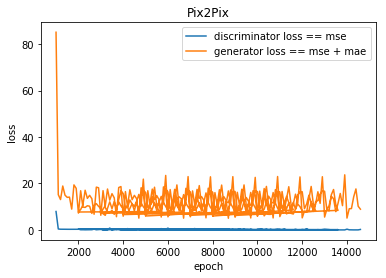

In [10]:
x3=[xi[0]+1000 for xi in gan.lossesmsemae]
y3=[xi[1] for xi in gan.lossesmsemae]
z3=[xi[2] for xi in gan.lossesmsemae]
plt.plot(x3,y3,label='discriminator loss == mse')
plt.plot(x3,z3,label='generator loss == mse + mae')
plt.legend()
plt.title('Pix2Pix')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig('Lossmsemae.png')


In [ ]:
x3=[xi[0] for xi in gan.lossesmsemae]
y3=[xi[1] for xi in gan.lossesmsemae]
z3=[xi[2] for xi in gan.lossesmsemae]
plt.plot(x3,y3,label='discriminator loss == mse')
plt.plot(x3,z3,label='generator loss == mse + mae')
plt.legend()
plt.title('Pix2Pix')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig('Lossmsemae.png')


In [ ]:
gan.lossesmsemae

Evaluation

In [ ]:
model=Pix2Pix()
generator=model.generator

In [ ]:
generator.load_weights("/kaggle/working/generator.h5")

In [ ]:
img_A,img_B=load_data(1)

In [ ]:
predicted=generator.predict_on_batch(img_B)


In [ ]:
predicted

In [ ]:
predicted = 0.5 * predicted + 0.5


Display predicted image